<a href="https://colab.research.google.com/github/elliemci/agents/blob/main/document_analysis_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Document Analysis System using LangGraph

1. Process images document
2. Extract text using vision language models
3. Perform calculations when needed
4. Analyze content and provide concise summaries
5. Execute specific instructions related to documents

In [ ]:
!pip install -q -U langchain_openai langchain_core langgraph

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ColabNotebooks/AgentsCourse

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/AgentsCourse


In [3]:
import os
import base64  # provides encoding and decoding of bibary data to ASCII bytes

from typing import List, TypedDict, Annotated, Optional
from langchain.schema import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage #lngchain classes that define messages
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

from IPython.display import Image, display

from google.colab import userdata

openai_api_key = userdata.get('OPENAI_API_KEY')
vision_llm = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)

**ReAct** agent architecture consist in:
* Reason about the request
* Act - let the model calll specific tools
* Observe - pass the tool output back to the model
* Repeat - let the model reason about the tool output to decide to call another tool or respond directly

## Agent's State

Adding operators to state defines interactions, `add_messages` is an operator that add the latest message instad of overwritting it with the latest state

In [4]:
class AgentState(TypedDict):
  """ Custom class that defines the state of the agent."""
  input_file: Optional[str] # file path for .pdf or .png
  messages: Annotated[list[AnyMessage], add_messages]

## Tools

In [5]:
def extract_text(img_path: str) -> str:
  """
  Extract text from an image file using a multimodal model.
  """
  all_text = ""
  try:
    # read image and encode as base64
    with open(img_path, "rb") as image_file:
      img_bytes = image_file.read()

    # encode image data into base64 format than decode into a UTF-8 string
    image_base64 = base64.b64encode(img_bytes).decode("utf-8")

    # prepare the prompt including the base63 image data
    message = [
        HumanMessage( # formats a message from human input
            content=[
                {
                    "type": "text",
                    "text": (
                        "Extract all the text from this image."
                        "Return only the extracted text."
                    ),
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_base64}"
                    }
                }
            ]
        )
    ]

    # call the vision language model
    response = vision_llm.invoke(message)

    # append extracted text from the model response
    all_text += response.content + "\n\n"

    return all_text.strip()

  except Exception as e:
    error_msg = f"Error extracting text from image: {str(e)}"
    print(error_msg)
    return ""

In [17]:
!pip install --upgrade pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 64.1 MB/s eta 0:00:00


In [18]:
import base64
import fitz  # PyMuPDF
from PIL import Image
from io import BytesIO
from langchain.tools import Tool


def extract_pdf_content(pdf_path: str) -> str:
    """
    Extract text and images from a PDF file and format them for LLM processing.
    """
    all_text = ""
    images_base64 = []

    try:
        # Open PDF file
        doc = fitz.open(pdf_path)

        for page in doc:
            all_text += page.get_text("text") + "\n\n"

            # Extract images from page
            for img_index, img in enumerate(page.get_images(full=True)):
                xref = img[0]
                base_image = doc.extract_image(xref)
                image_bytes = base_image["image"]

                # Convert image to base64
                image_base64 = base64.b64encode(image_bytes).decode("utf-8")
                images_base64.append(f"data:image/jpeg;base64,{image_base64}")

        # Format extracted content
        extracted_content = {"text": all_text.strip(), "images": images_base64}
        return extracted_content

    except Exception as e:
        error_msg = f"Error extracting content from PDF: {str(e)}"
        print(error_msg)
        return {"text": "", "images": []}

In [ ]:
!pip install tavily-python

In [ ]:
!pip install langchain_community

In [56]:
import os
import fitz
import base64
import tiktoken

from PIL import Image
from io import BytesIO
from langchain.tools import Tool
from langchain.schema import HumanMessage

from langchain_community.tools.tavily_search import TavilySearchResults

tavili_api_key = userdata.get('TAVILY_API_KEY')

os.environ["TAVILY_API_KEY"] = tavili_api_key
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY", "your_api_key_here")



def count_tokens(text: str) -> int:
    """Estimate token count for a given text input."""
    enc = tiktoken.get_encoding("cl100k_base")
    return len(enc.encode(text))


def chunk_text(text: str, max_tokens: int = 5000) -> list:
    """Split text into chunks that fit within the token limit."""
    words = text.split()
    chunks = []
    current_chunk = []
    current_token_count = 0

    for word in words:
        word_token_count = count_tokens(word)
        if current_token_count + word_token_count > max_tokens:
            chunks.append(" ".join(current_chunk))
            current_chunk = [word]
            current_token_count = word_token_count
        else:
            current_chunk.append(word)
            current_token_count += word_token_count

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks


def extract_pdf_content(pdf_path: str) -> dict:
    """
    Extract text and images from a PDF file and format them for LLM processing.
    """
    all_text = ""
    images_base64 = []

    try:
        # Open PDF file
        doc = fitz.open(pdf_path)

        for page in doc:
            all_text += page.get_text("text") + "\n\n"

            # Extract images from page
            for img_index, img in enumerate(page.get_images(full=True)):
                xref = img[0]
                base_image = doc.extract_image(xref)
                image_bytes = base_image["image"]

                # Convert image to base64
                image_base64 = base64.b64encode(image_bytes).decode("utf-8")
                images_base64.append(f"data:image/jpeg;base64,{image_base64}")

        # Format extracted content
        extracted_content = {"text": all_text.strip(), "images": images_base64}
        return extracted_content

    except Exception as e:
        error_msg = f"Error extracting content from PDF: {str(e)}"
        print(error_msg)
        return {"text": "", "images": []}


def process_pdf_for_llm(pdf_path: str):
    """
    Process the extracted content and send it to the LLM while handling rate limits.
    """
    content = extract_pdf_content(pdf_path)
    message = []

    if content["text"]:
        text_chunks = chunk_text(content["text"], max_tokens=5000)
        for chunk in text_chunks:
            message.append({"type": "text", "text": chunk})

    for img in content["images"]:
        message.append({"type": "image_url", "image_url": {"url": img}})

    # Call LLM with extracted content in manageable chunks
    responses = []
    for msg in message:
        try:
            response = llm_with_tools.invoke([HumanMessage(content=[msg])])
            responses.append(response.content)
        except Exception as e:
            print(f"Error processing chunk: {str(e)}")
            responses.append("[Error in processing this chunk]")

    return "\n\n".join(responses)


pdf_tool = Tool(
    name="extract_pdf",
    func=process_pdf_for_llm,
    description="Extract text and images from a PDF document and pass them to the LLM for processing, ensuring request size stays within API limits."
)

def web_search(query: str) -> str:
    """Perform a web search and return relevant information using TavilySearchResults."""
    search_tool = TavilySearchResults(api_key=TAVILY_API_KEY)
    return search_tool.run(query)

# a LangChaoin Tool wrapper of the web_search() function
web_search_tool = Tool(
    name="web_search",
    func=web_search,
    description="Search the web for relevant information based on a query using TavilySearchResults."
)


In [6]:
def simple_calculation(a: float, b: float, operation: str) -> float:
  """
  Perform simple mathematical operations of addition, substraction, multiplication and division mathematical on two numbers.
  """
  return eval(f"{a} {operation} {b}")

In [7]:
import math

def calculator(a: float, b: float, operation: str) -> float:
  """
  Perform a mathematical operation on two numbers.
  Supports basic arithmetic, logarithm, power, and root operations.
  """
  if operation == "+":
    return a + b
  elif operation == "-":
    return a - b
  elif operation == "*":
    return a * b
  elif operation == "/":
    if b == 0:
      raise ZeroDivisionError("Cannot divide by zero")
    return a / b
  elif operation == "log":  # Logarithm (base b)
    if a <= 0 or b <= 0 or b == 1:
      raise ValueError("Invalid input for logarithm")
    return math.log(a, b)
  elif operation == "power":  # Power (a raised to the power of b)
    return math.pow(a, b)
  elif operation == "root":  # Root (b-th root of a)
    if a < 0 and b % 2 == 0:  # Even root of a negative number
      raise ValueError("Cannot calculate even root of a negative number")
    return math.pow(a, 1/b)
  else:
    raise ValueError(f"Invalid operation: {operation}")

In [59]:
tools = [
    calculator,
    extract_text,
    extract_pdf_content,
    web_search_tool,
    pdf_tool
    ]

# equipt the agent with tools
llm_with_tools = vision_llm.bind_tools(tools, parallel_tool_calls=False)

### Test Tools

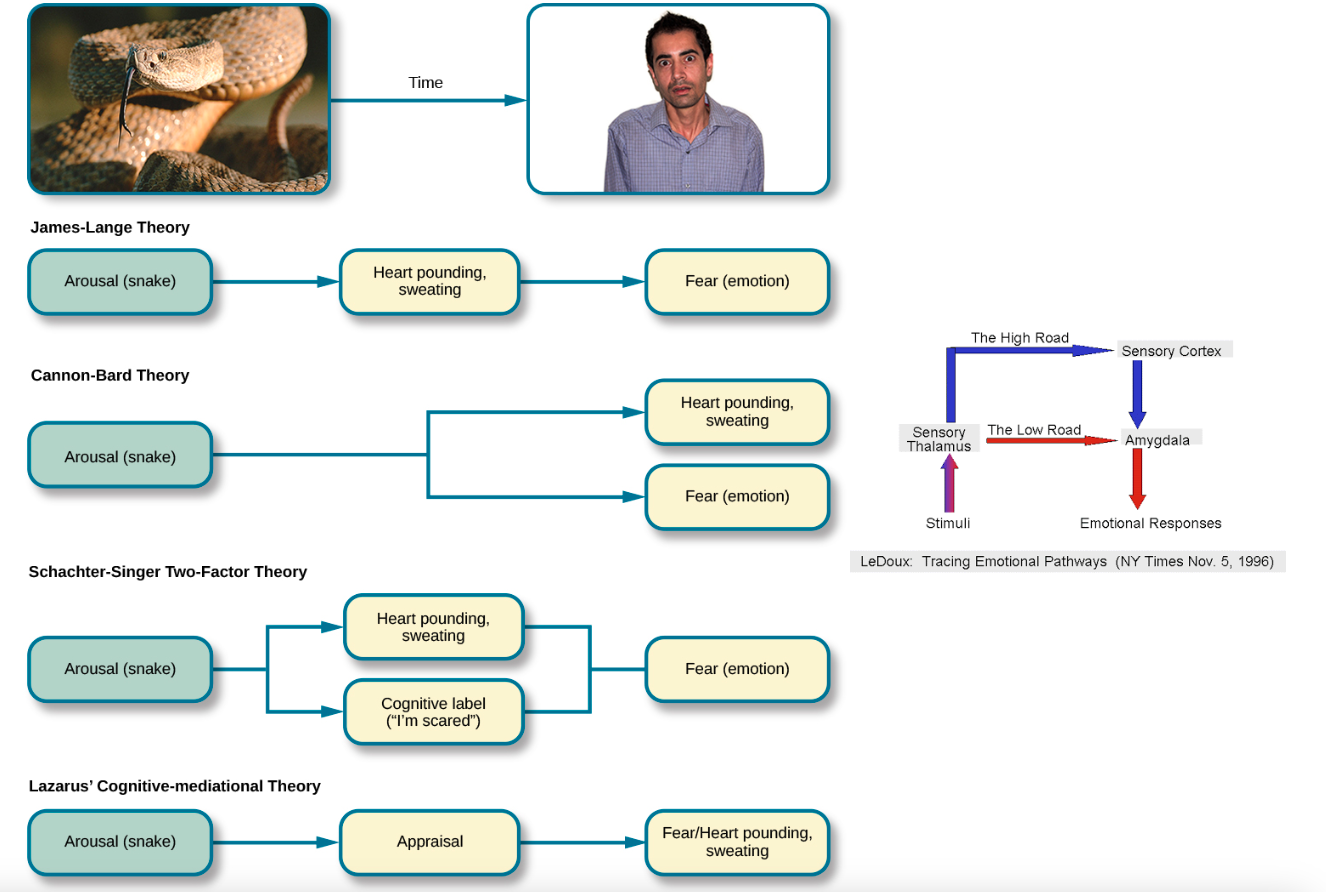

In [21]:
from IPython.display import Image, display

display(Image('theories_of_emotions.png'))

In [25]:
print(extract_text('theories_of_emotions.png'))

'Time\n\nJames-Lange Theory\n\nArousal (snake)\n\nHeart pounding, sweating\n\nFear (emotion)\n\nCannon-Bard Theory\n\nArousal (snake)\n\nHeart pounding, sweating\n\nFear (emotion)\n\nSchachter-Singer Two-Factor Theory\n\nArousal (snake)\n\nHeart pounding, sweating\n\nCognitive label (“I’m scared”)\n\nFear (emotion)\n\nLazarus’ Cognitive-mediational Theory\n\nArousal (snake)\n\nAppraisal\n\nFear/Heart pounding, sweating\n\nThe High Road\n\nSensory Cortex\n\nSensory Thalamus\n\nThe Low Road\n\nAmygdala\n\nStimuli\n\nEmotional Responses\n\nLeDoux: Tracing Emotional Pathways (NY Times Nov. 5, 1996)'

{'text': '', 'images': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']}

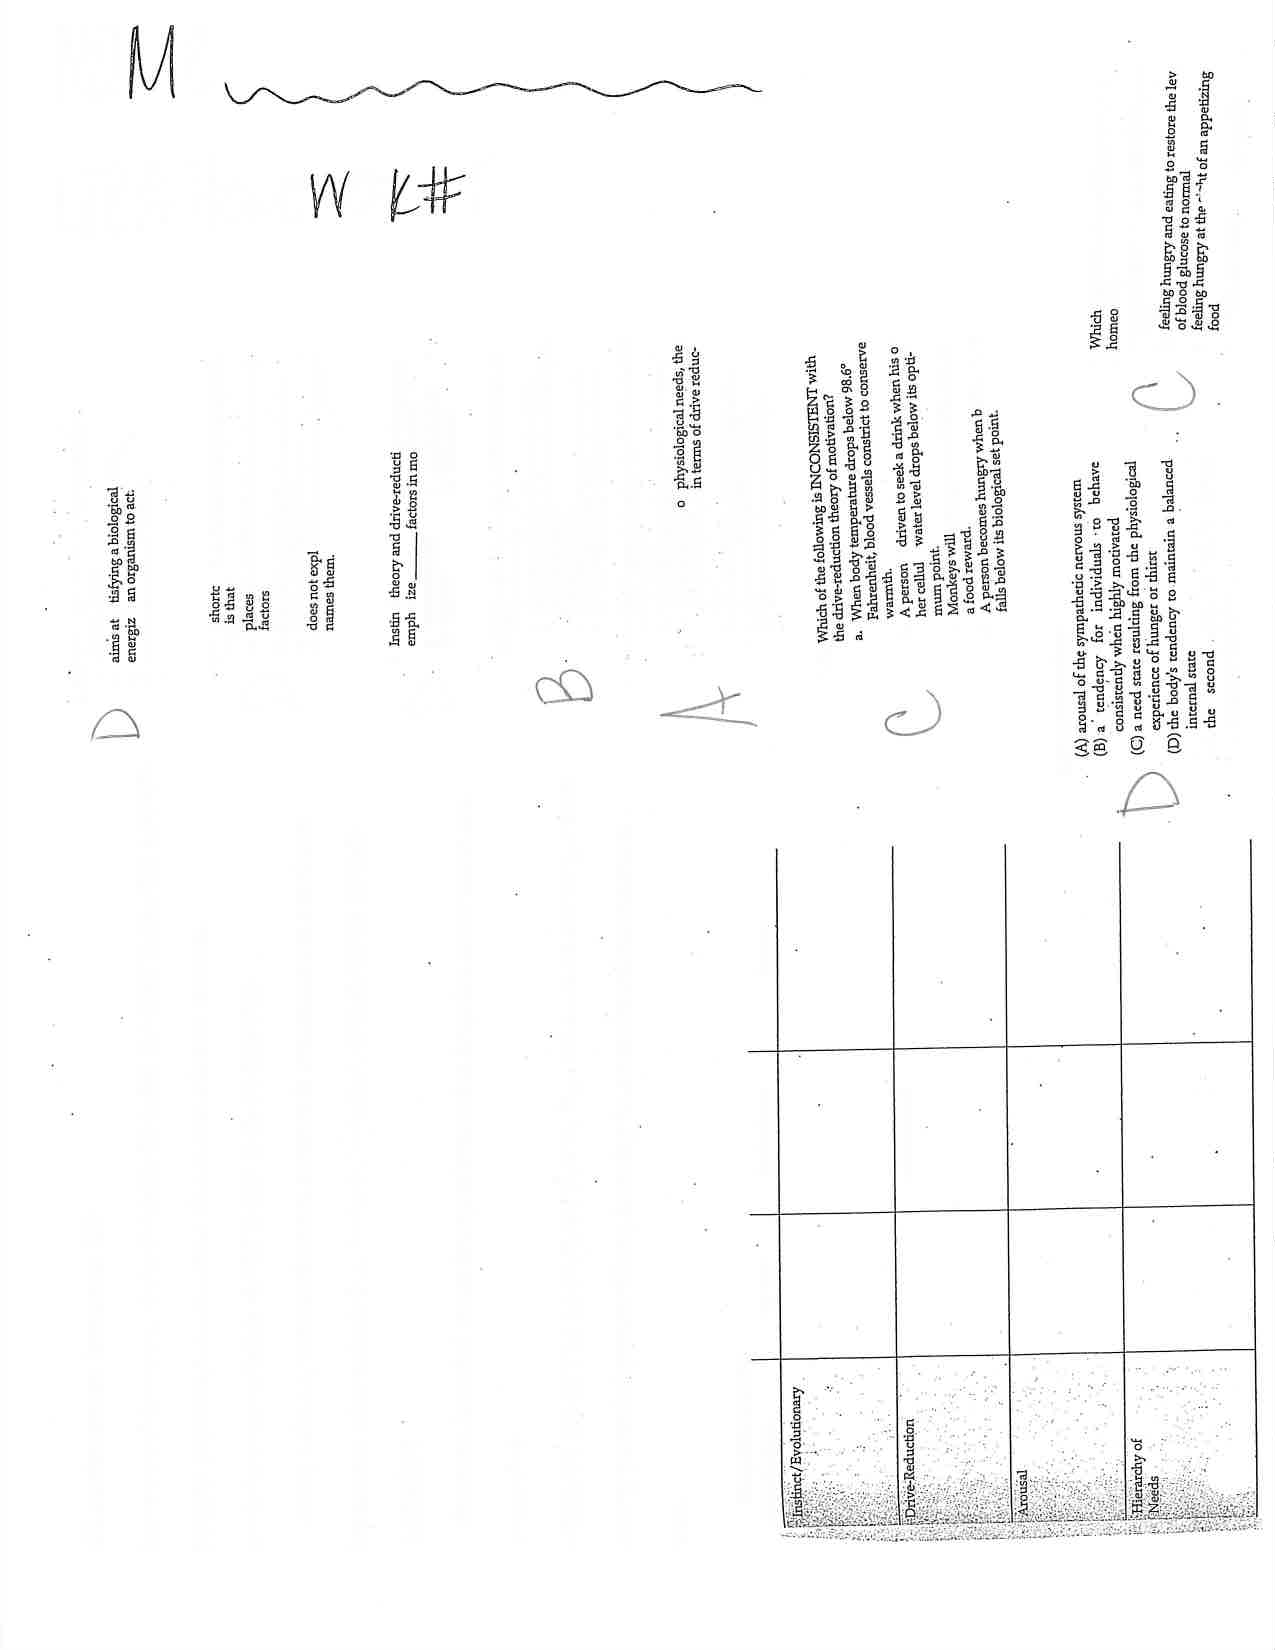
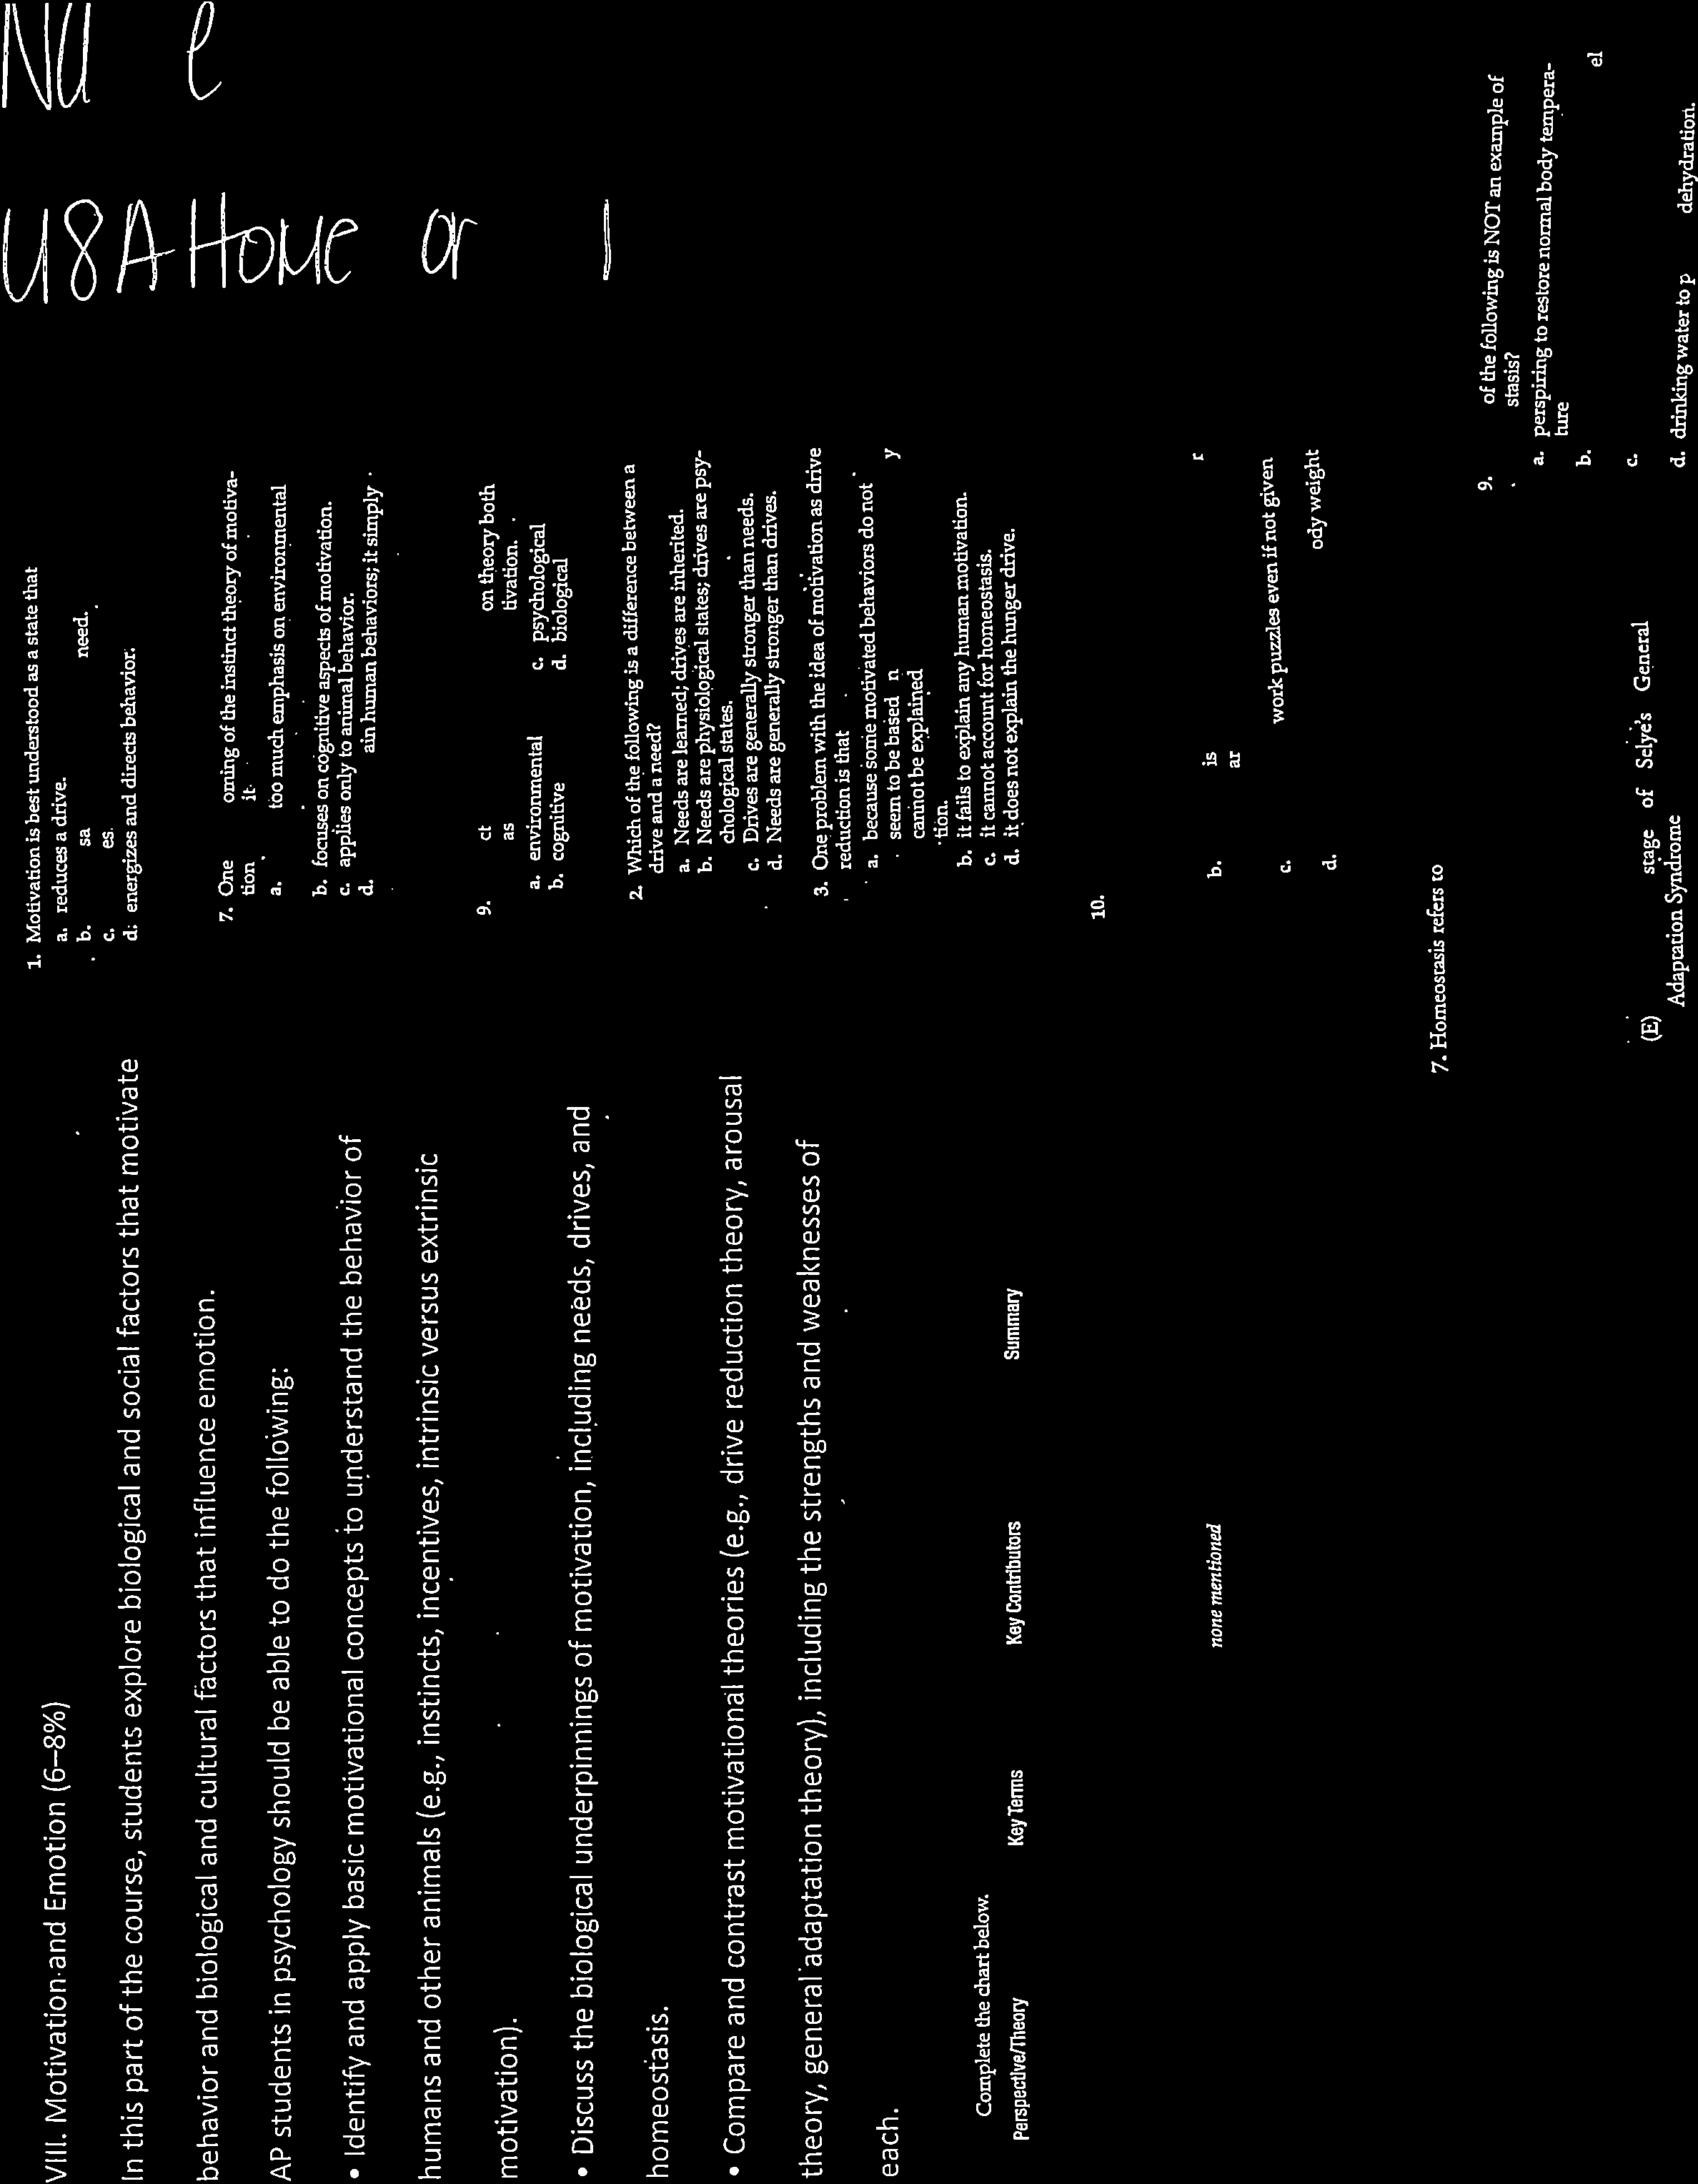
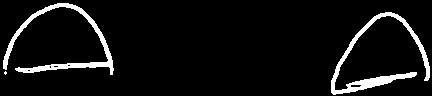
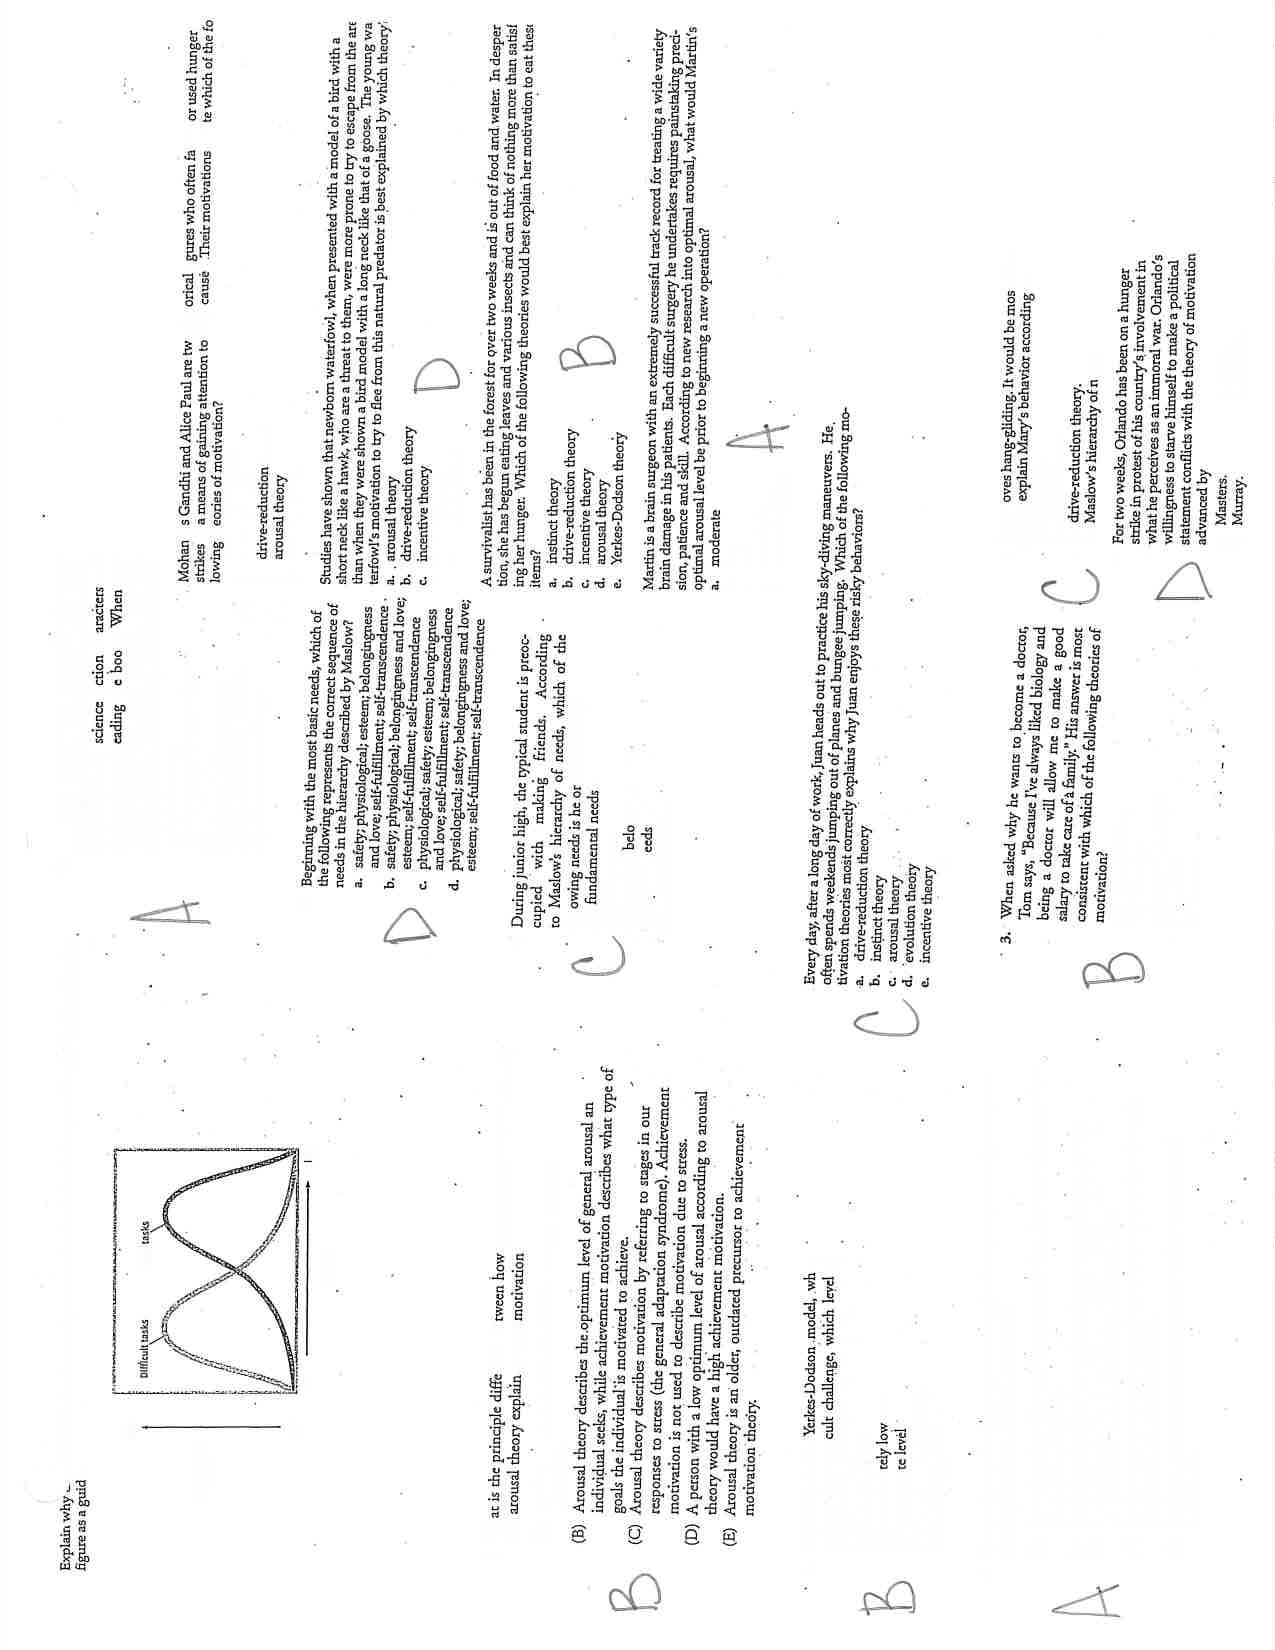
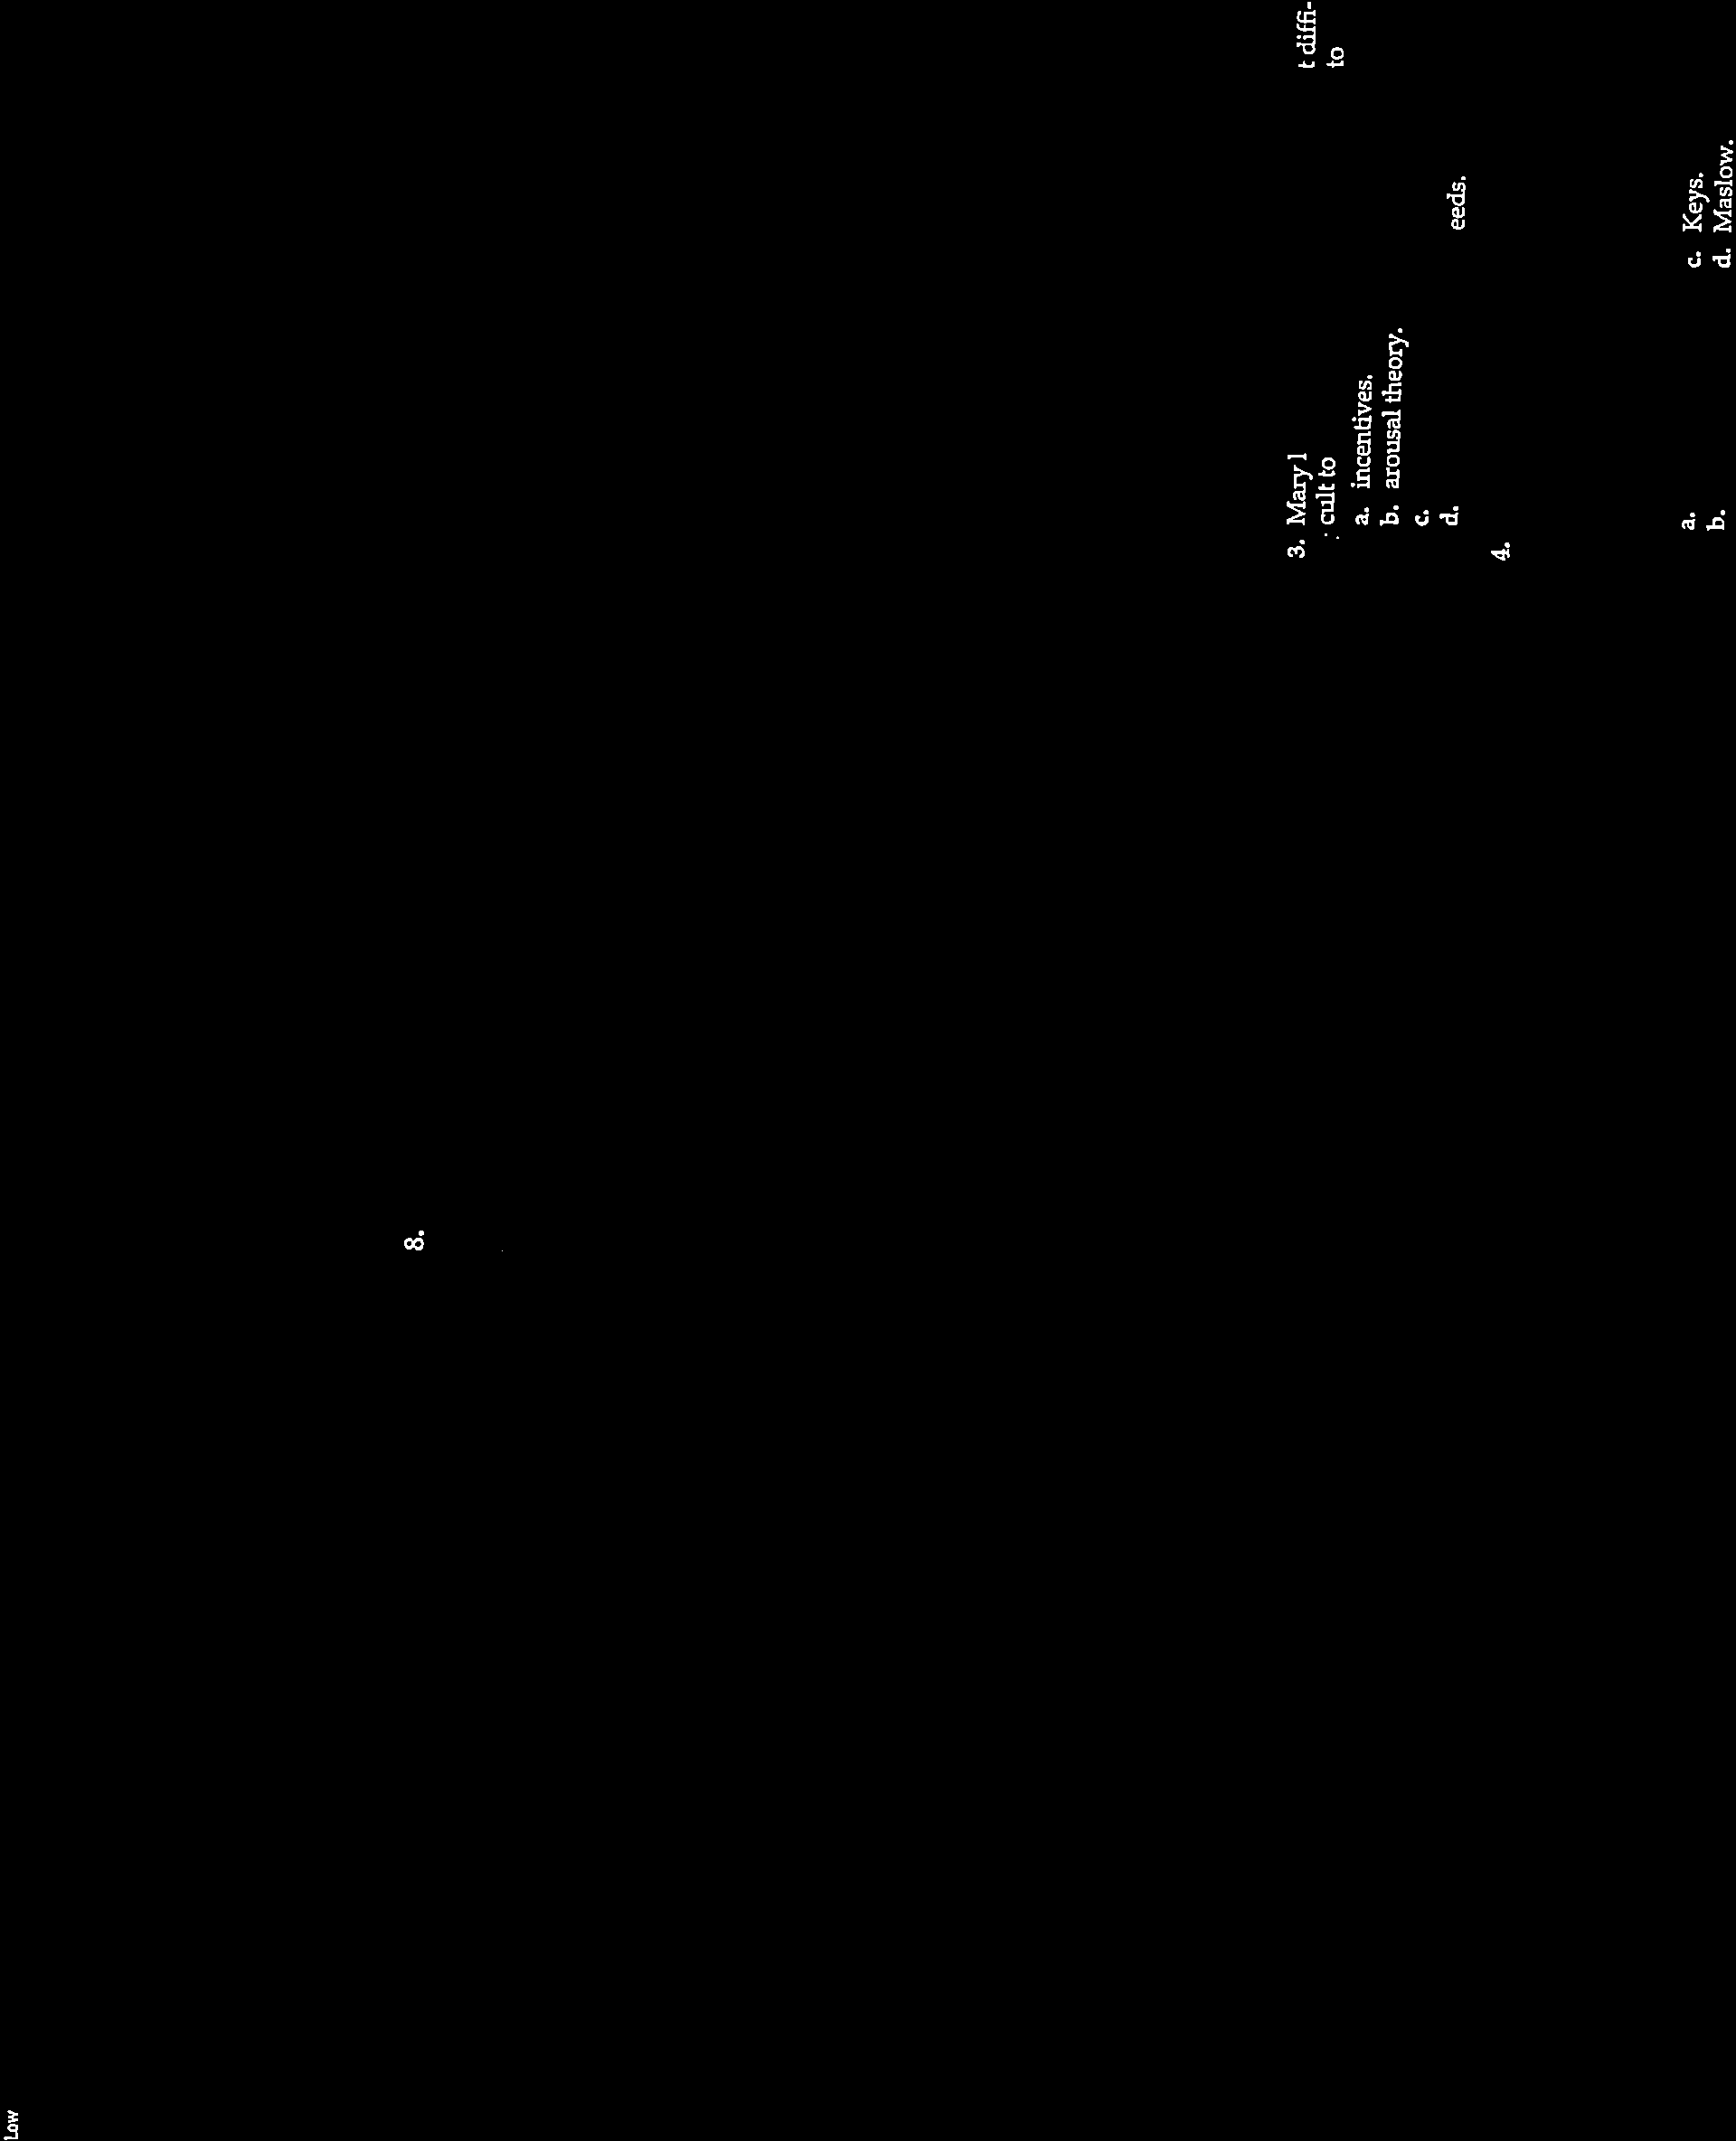
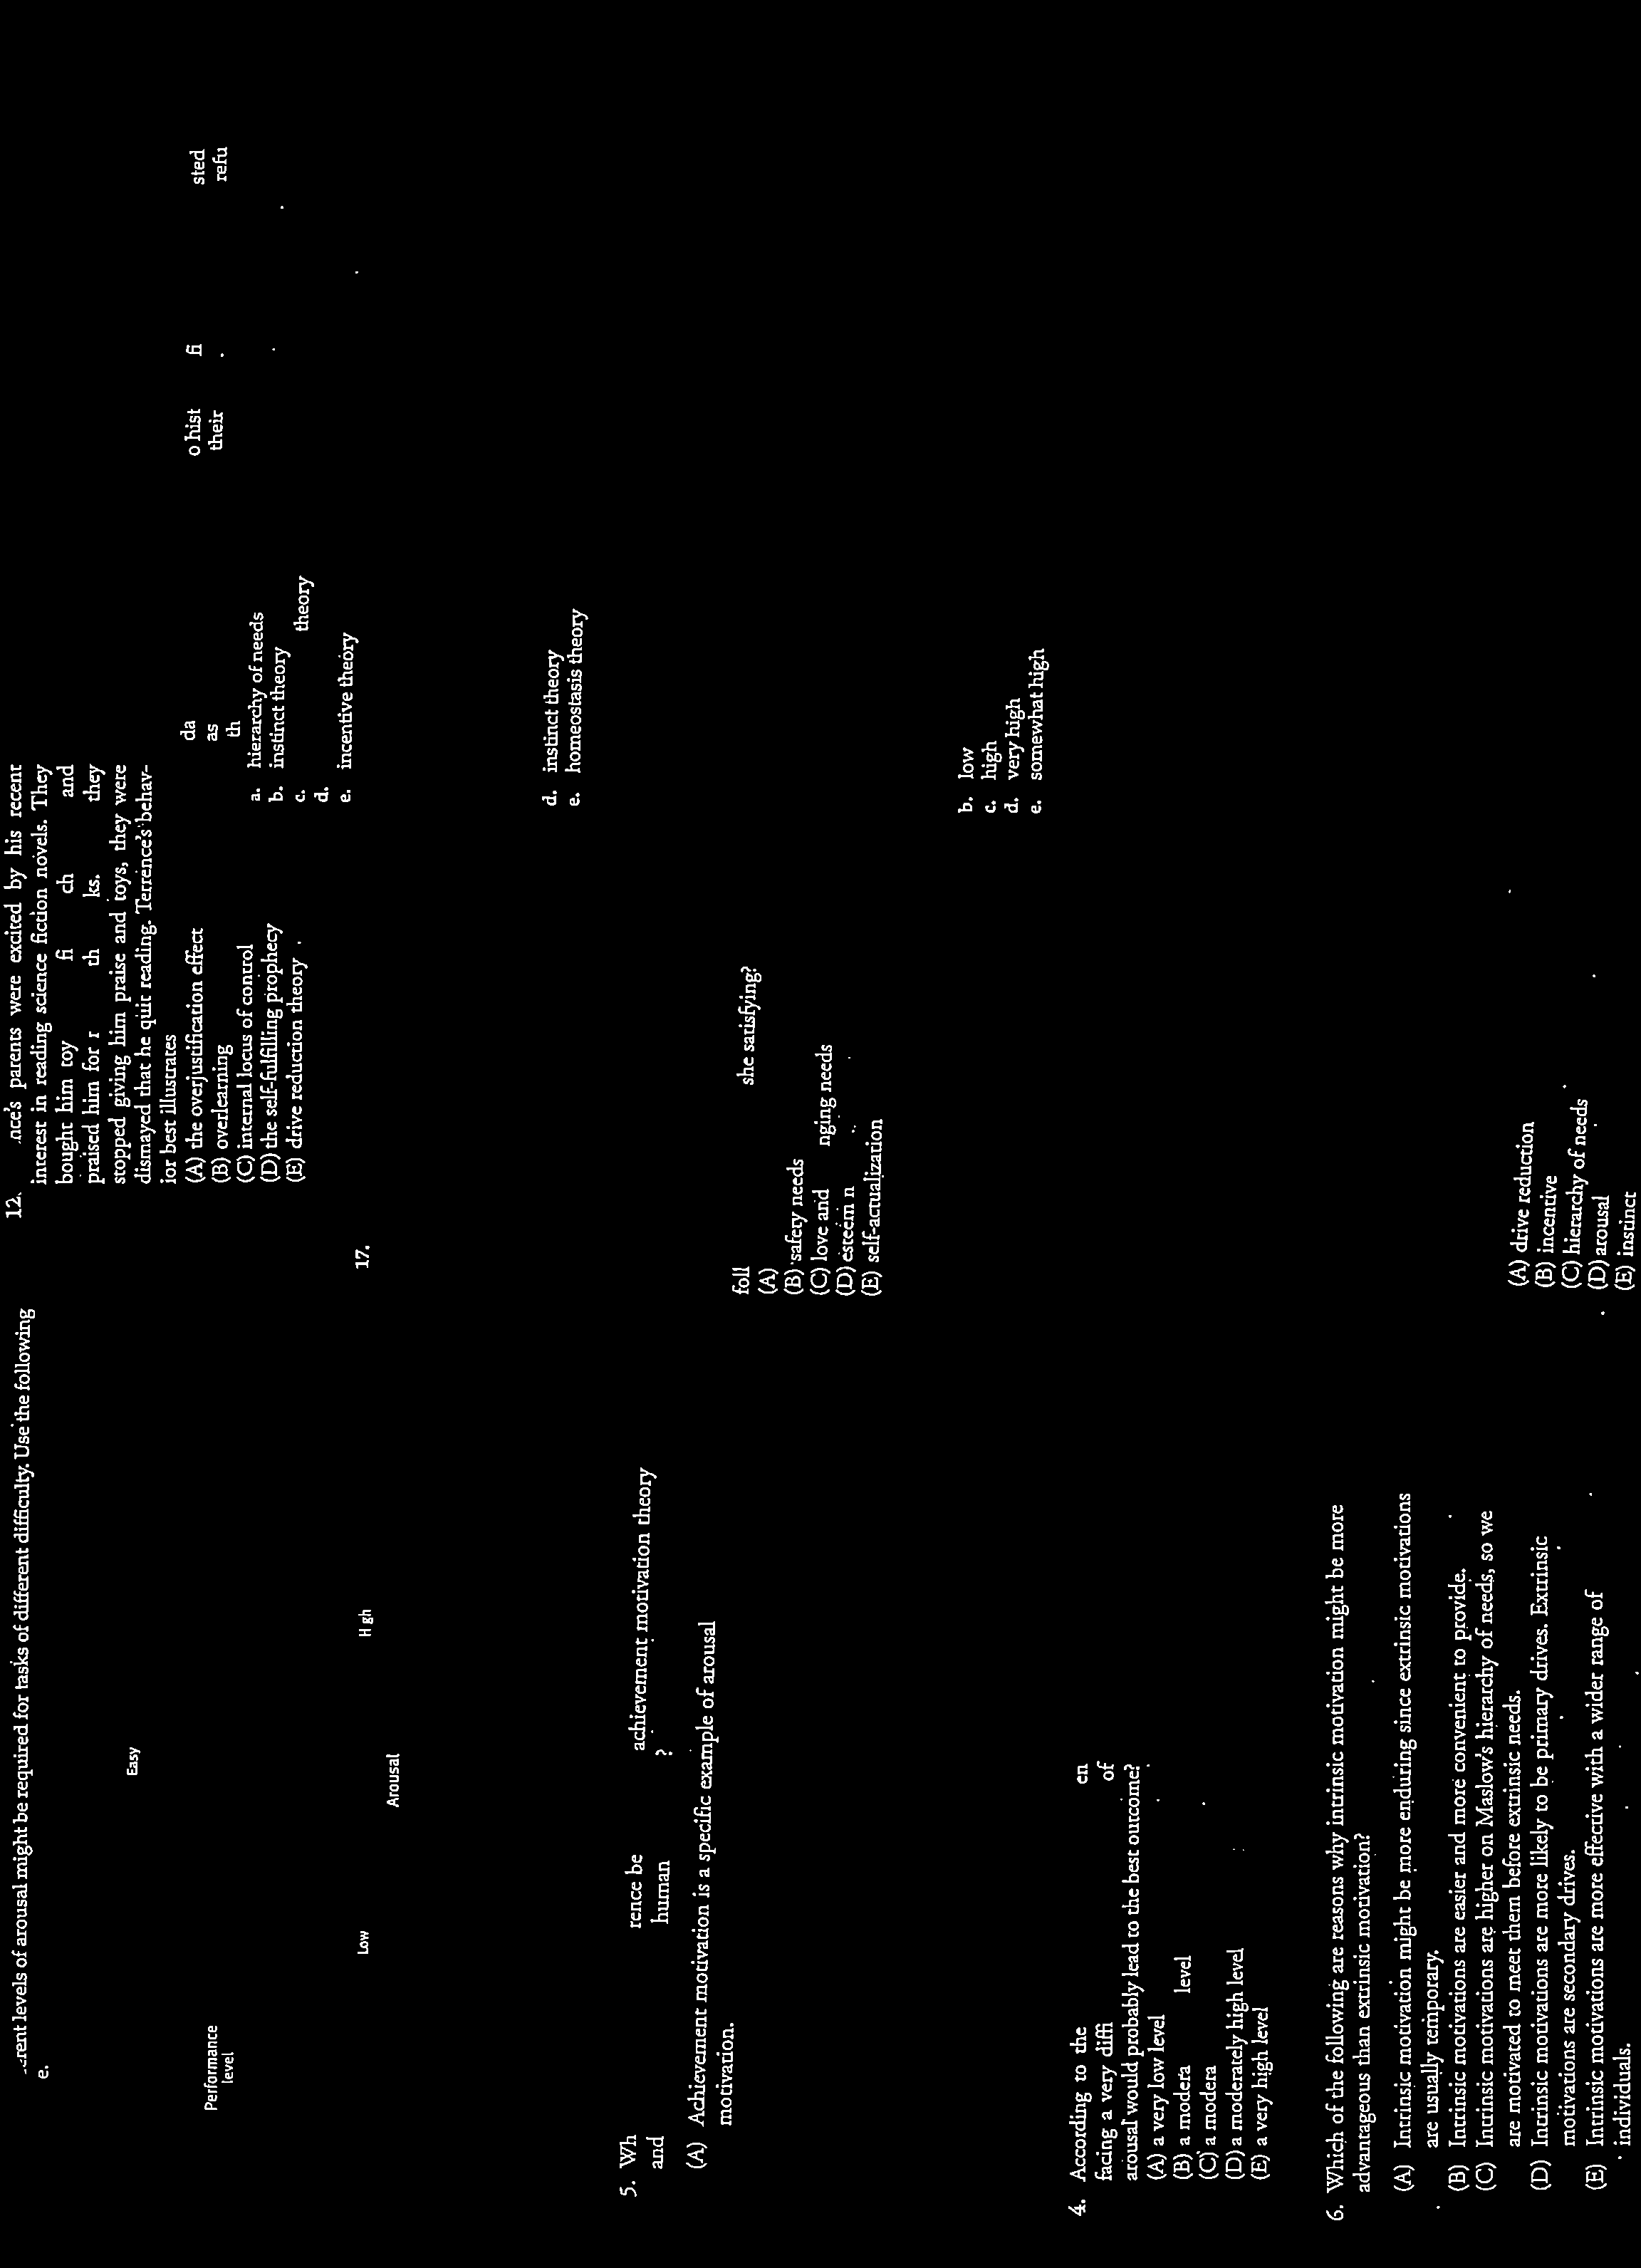
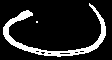
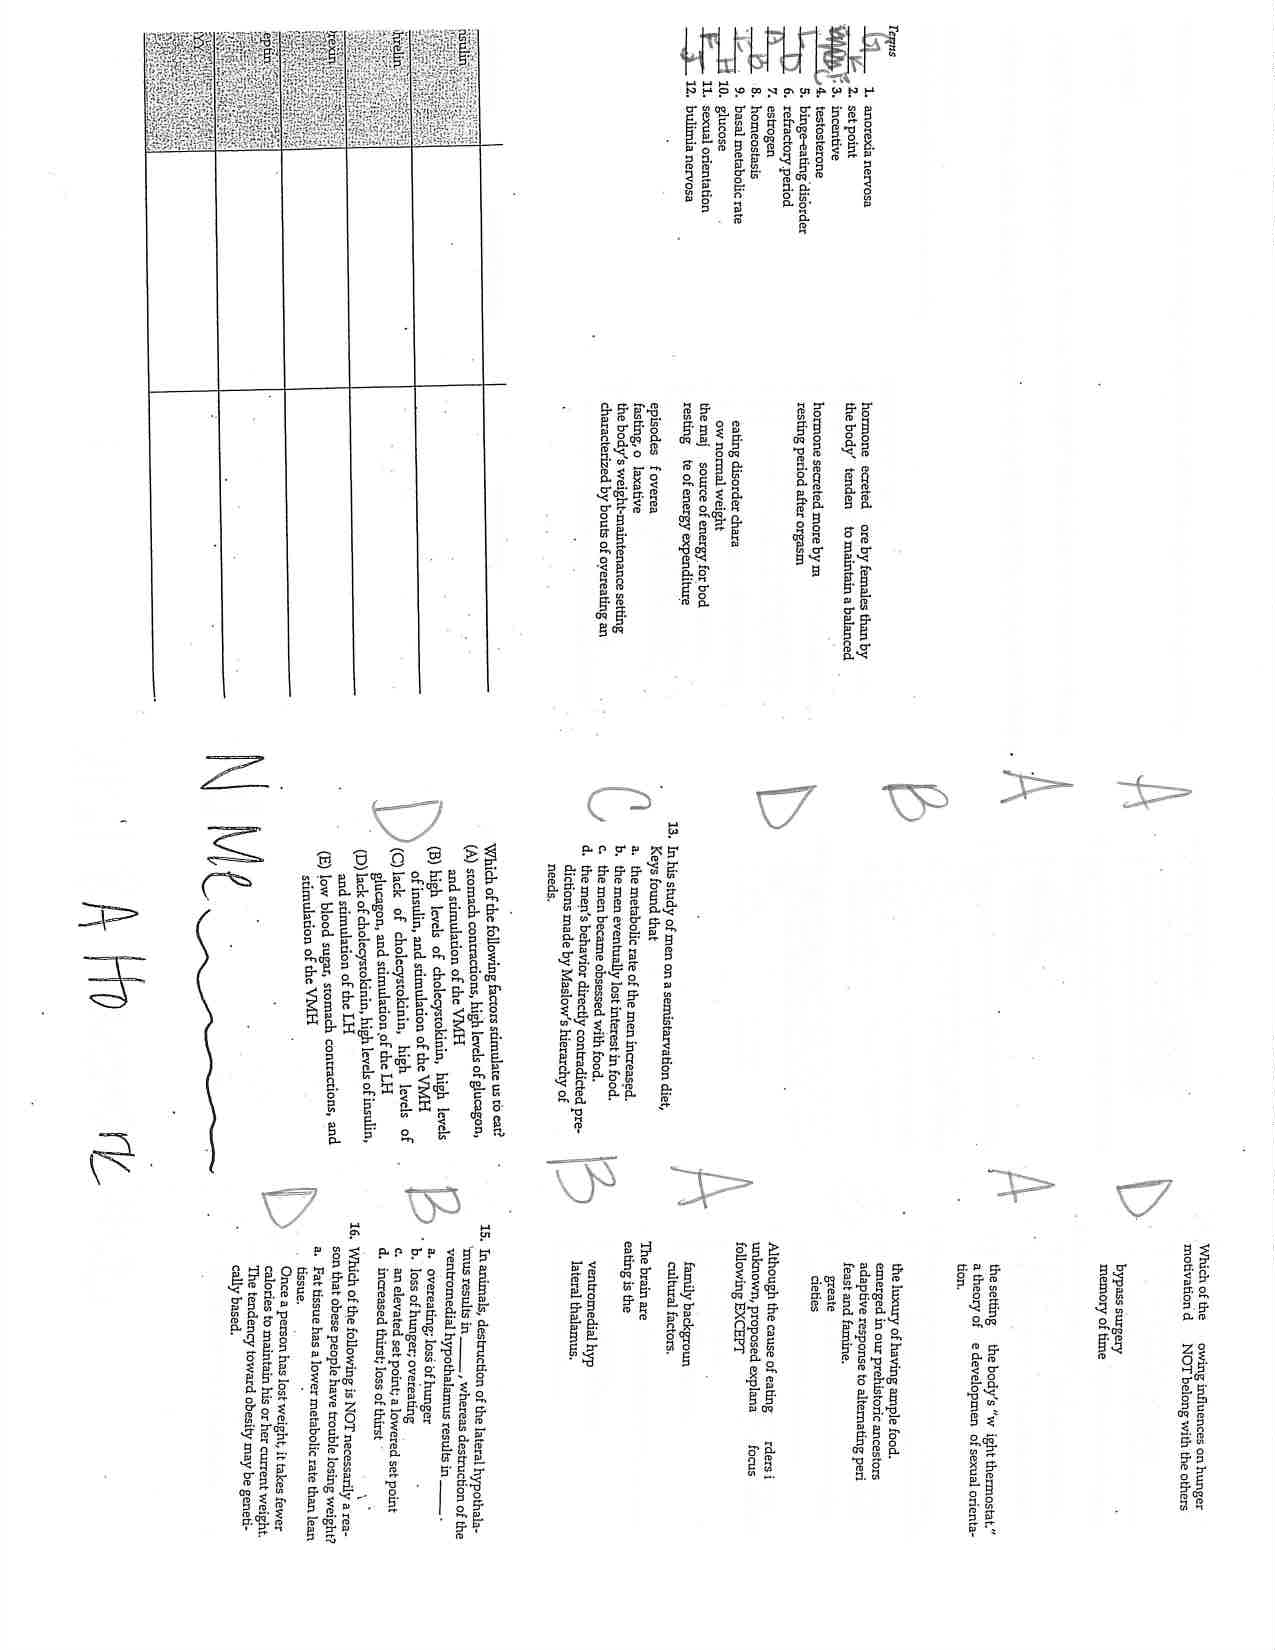
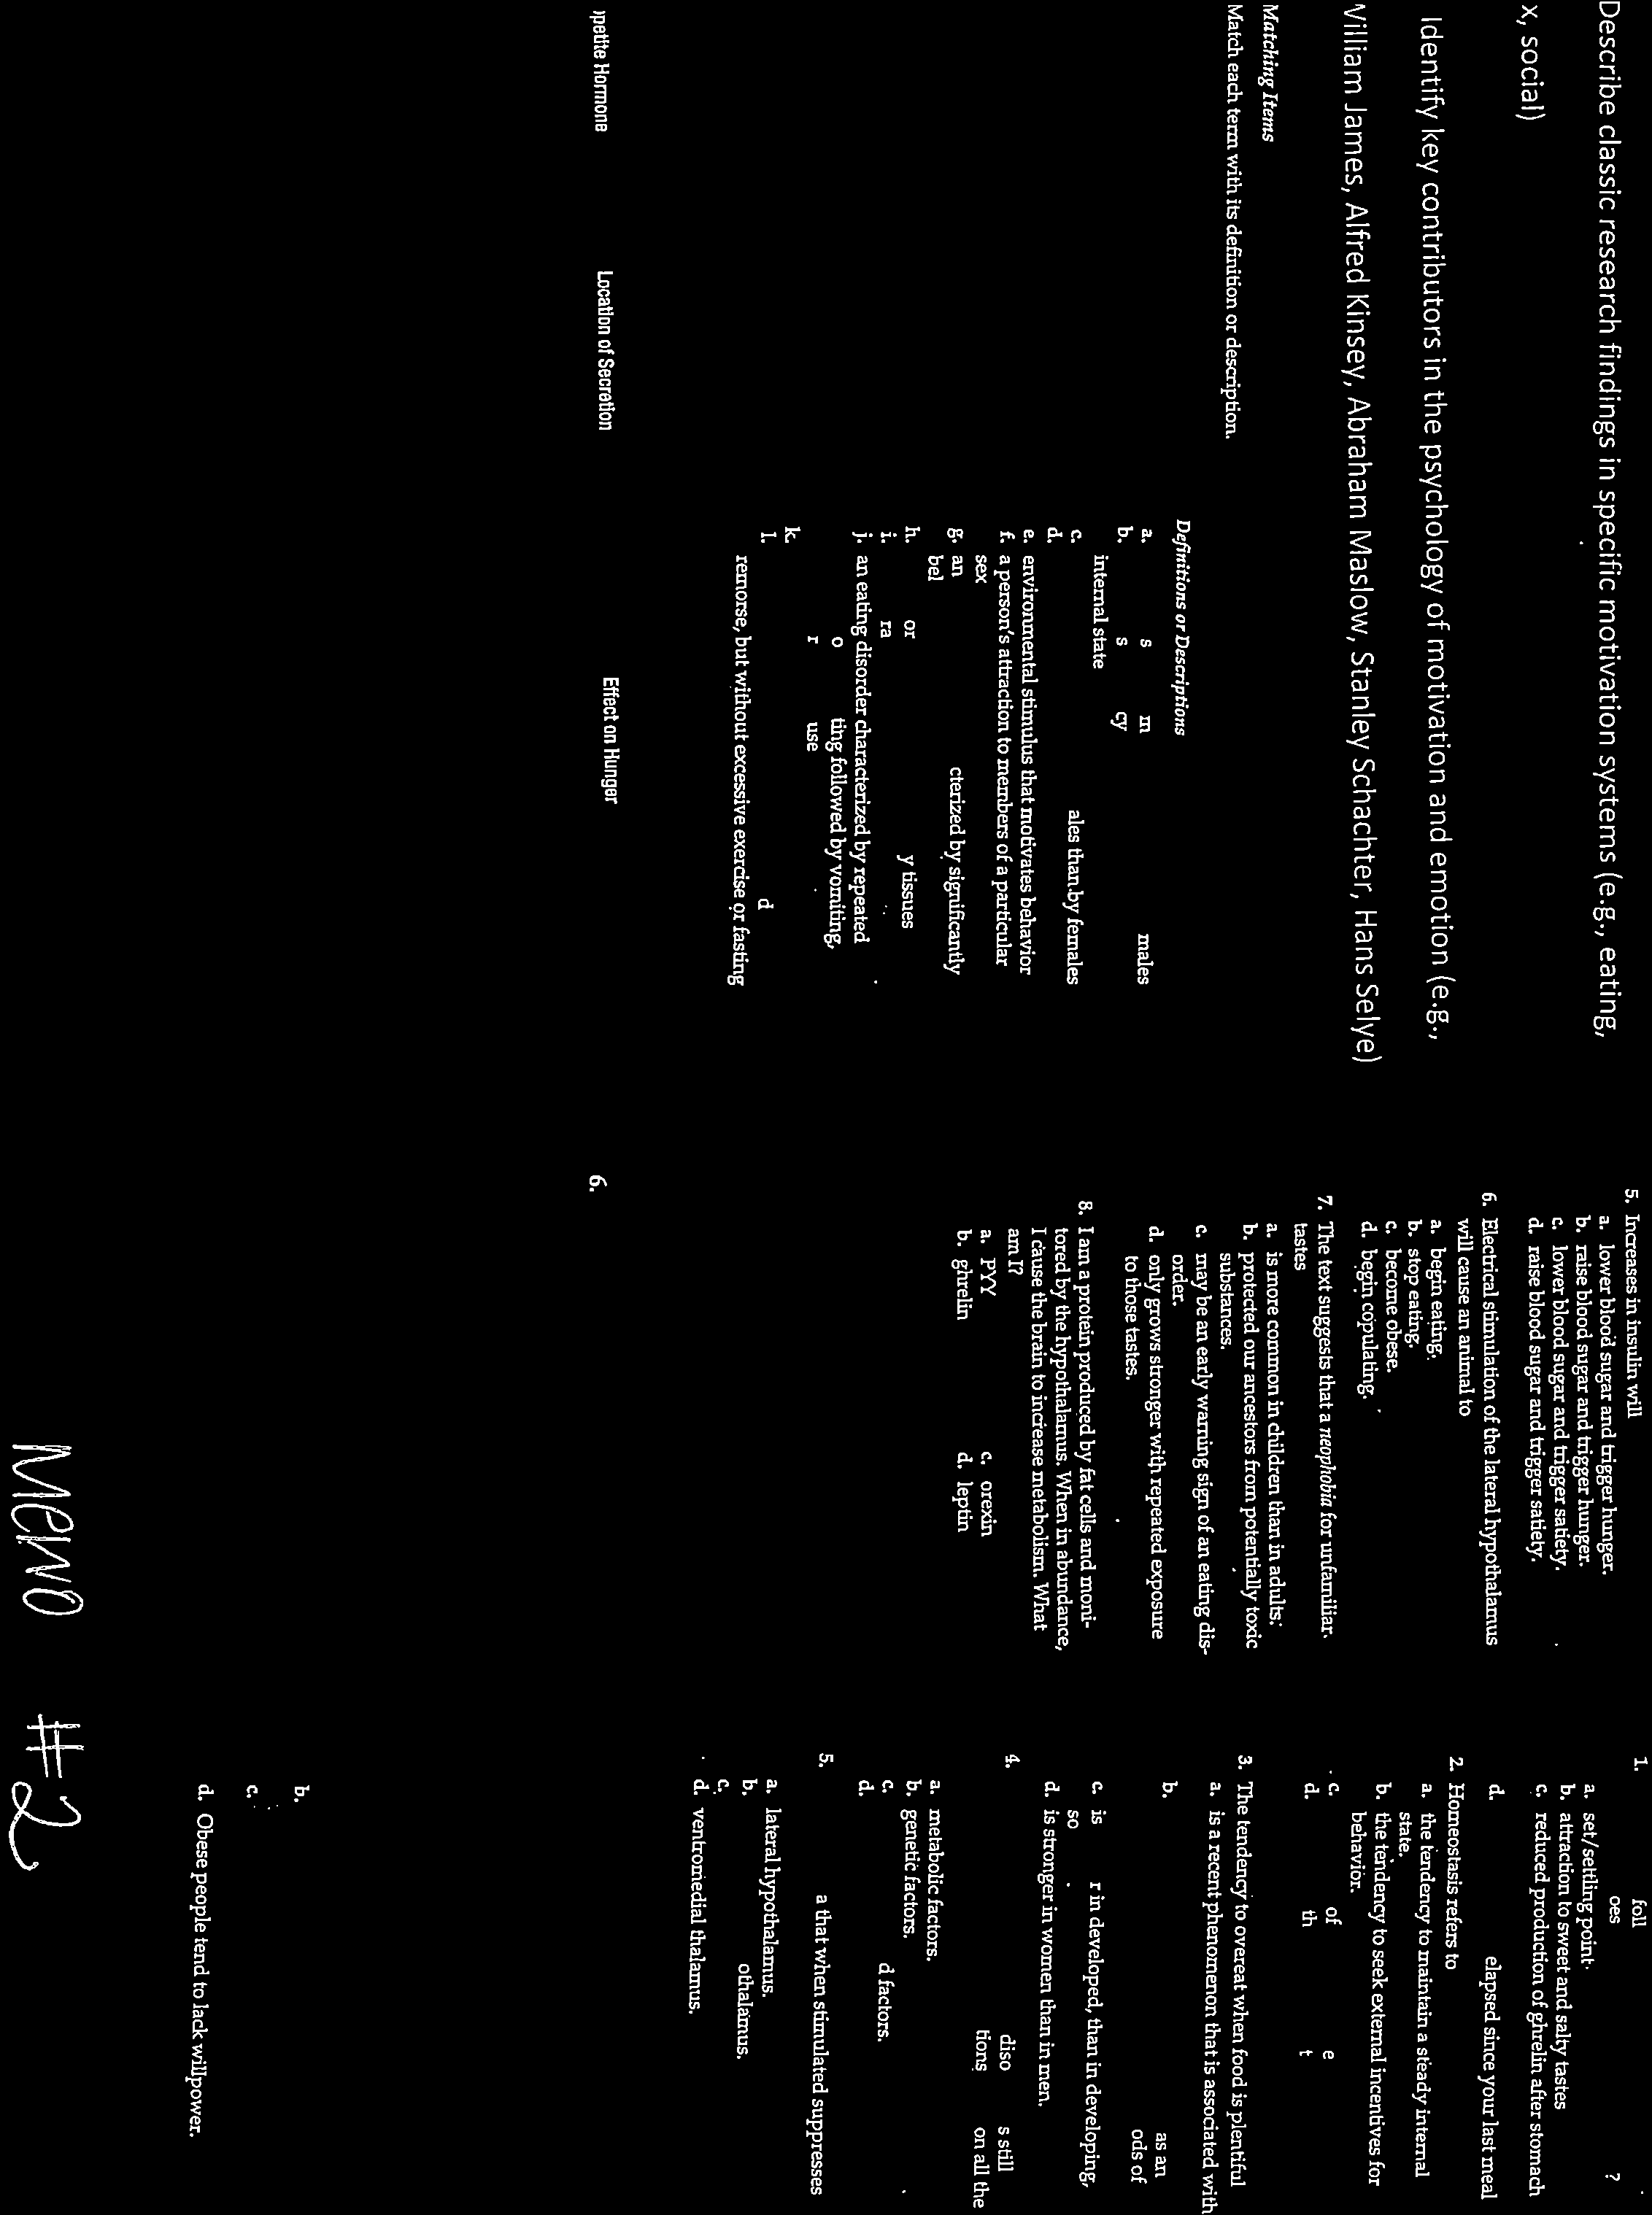
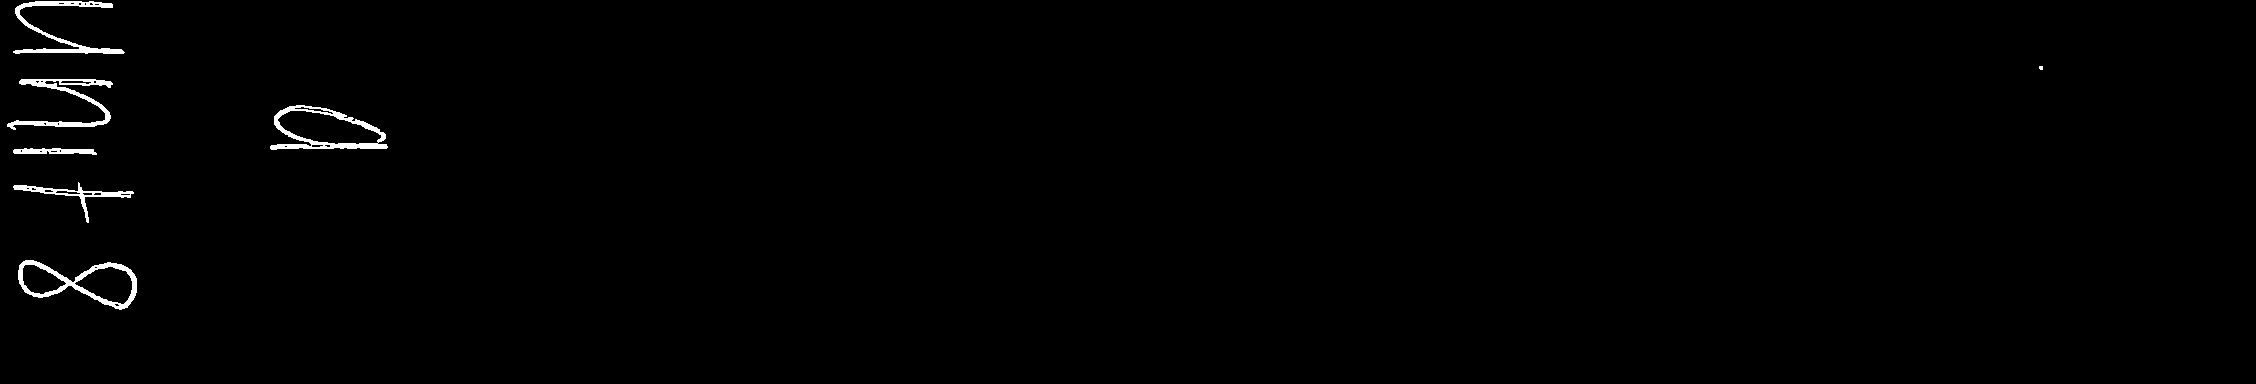
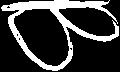
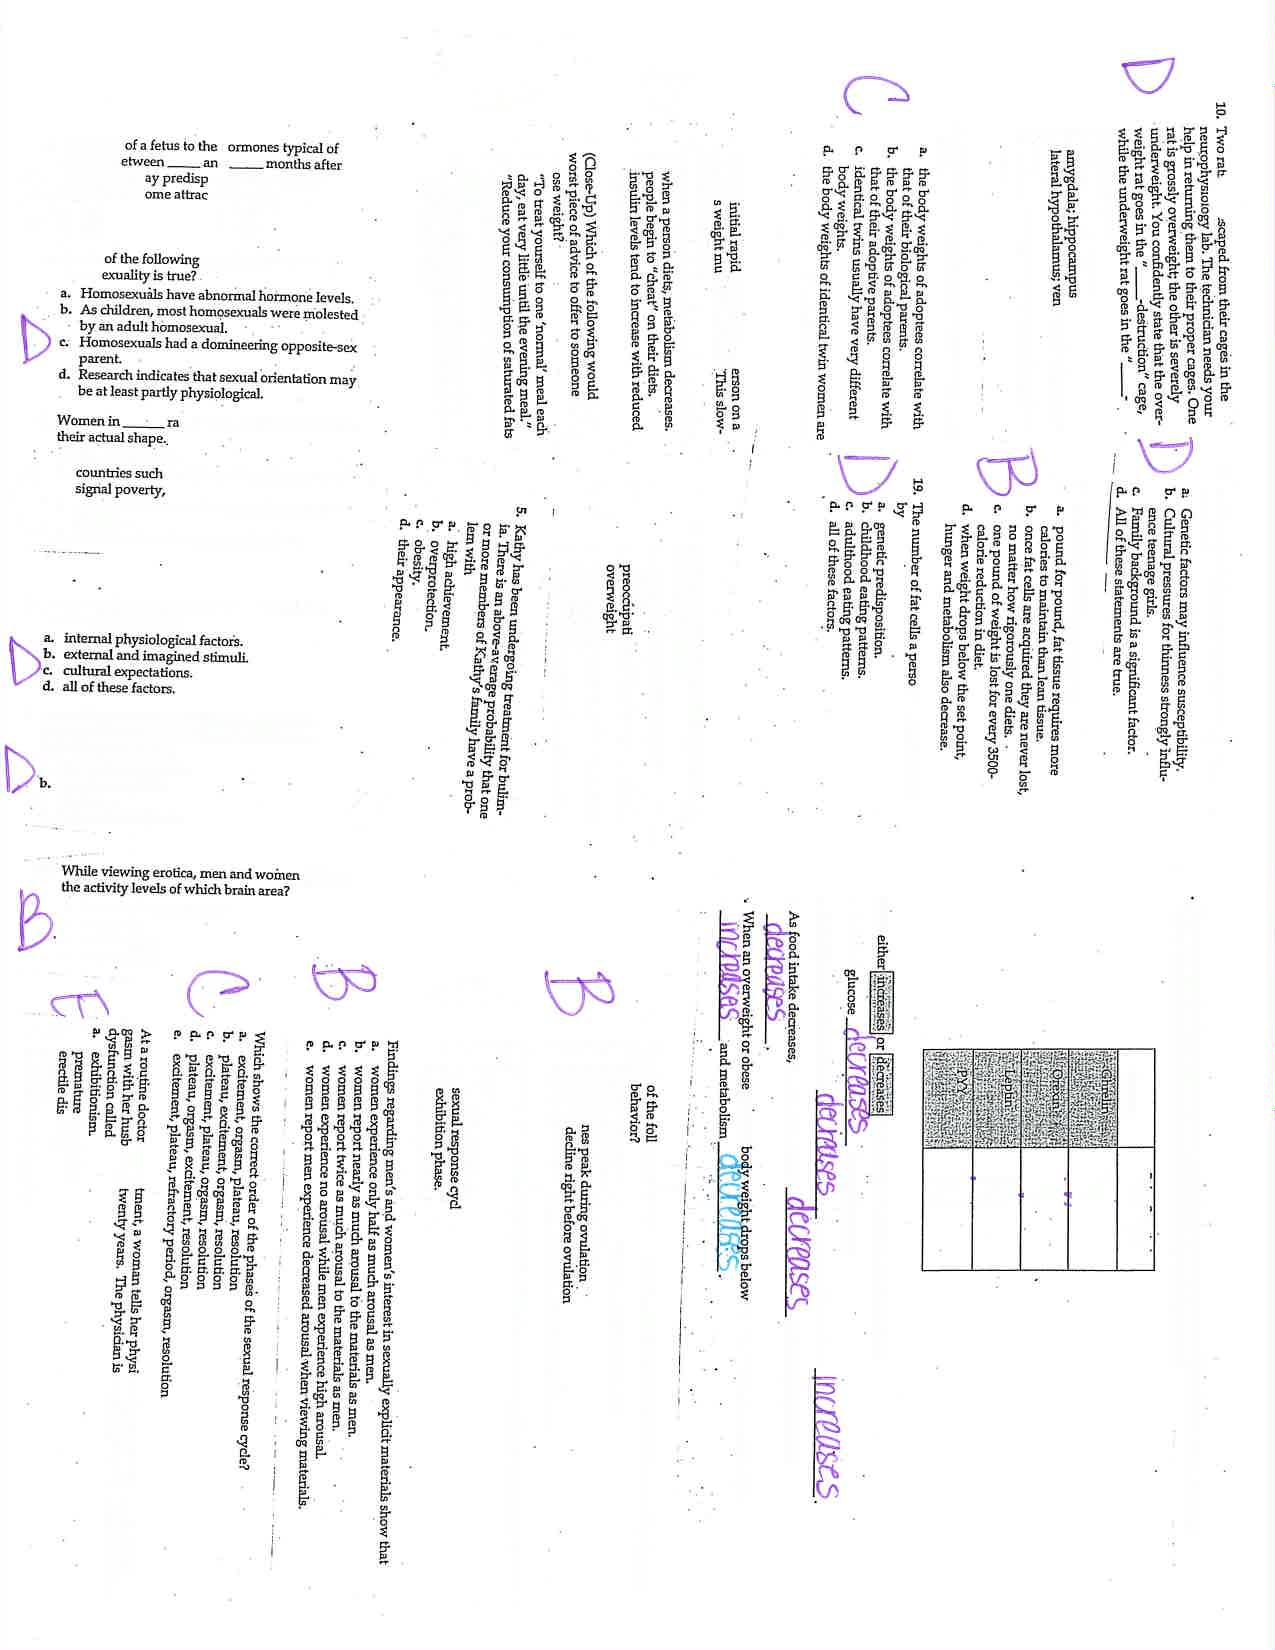
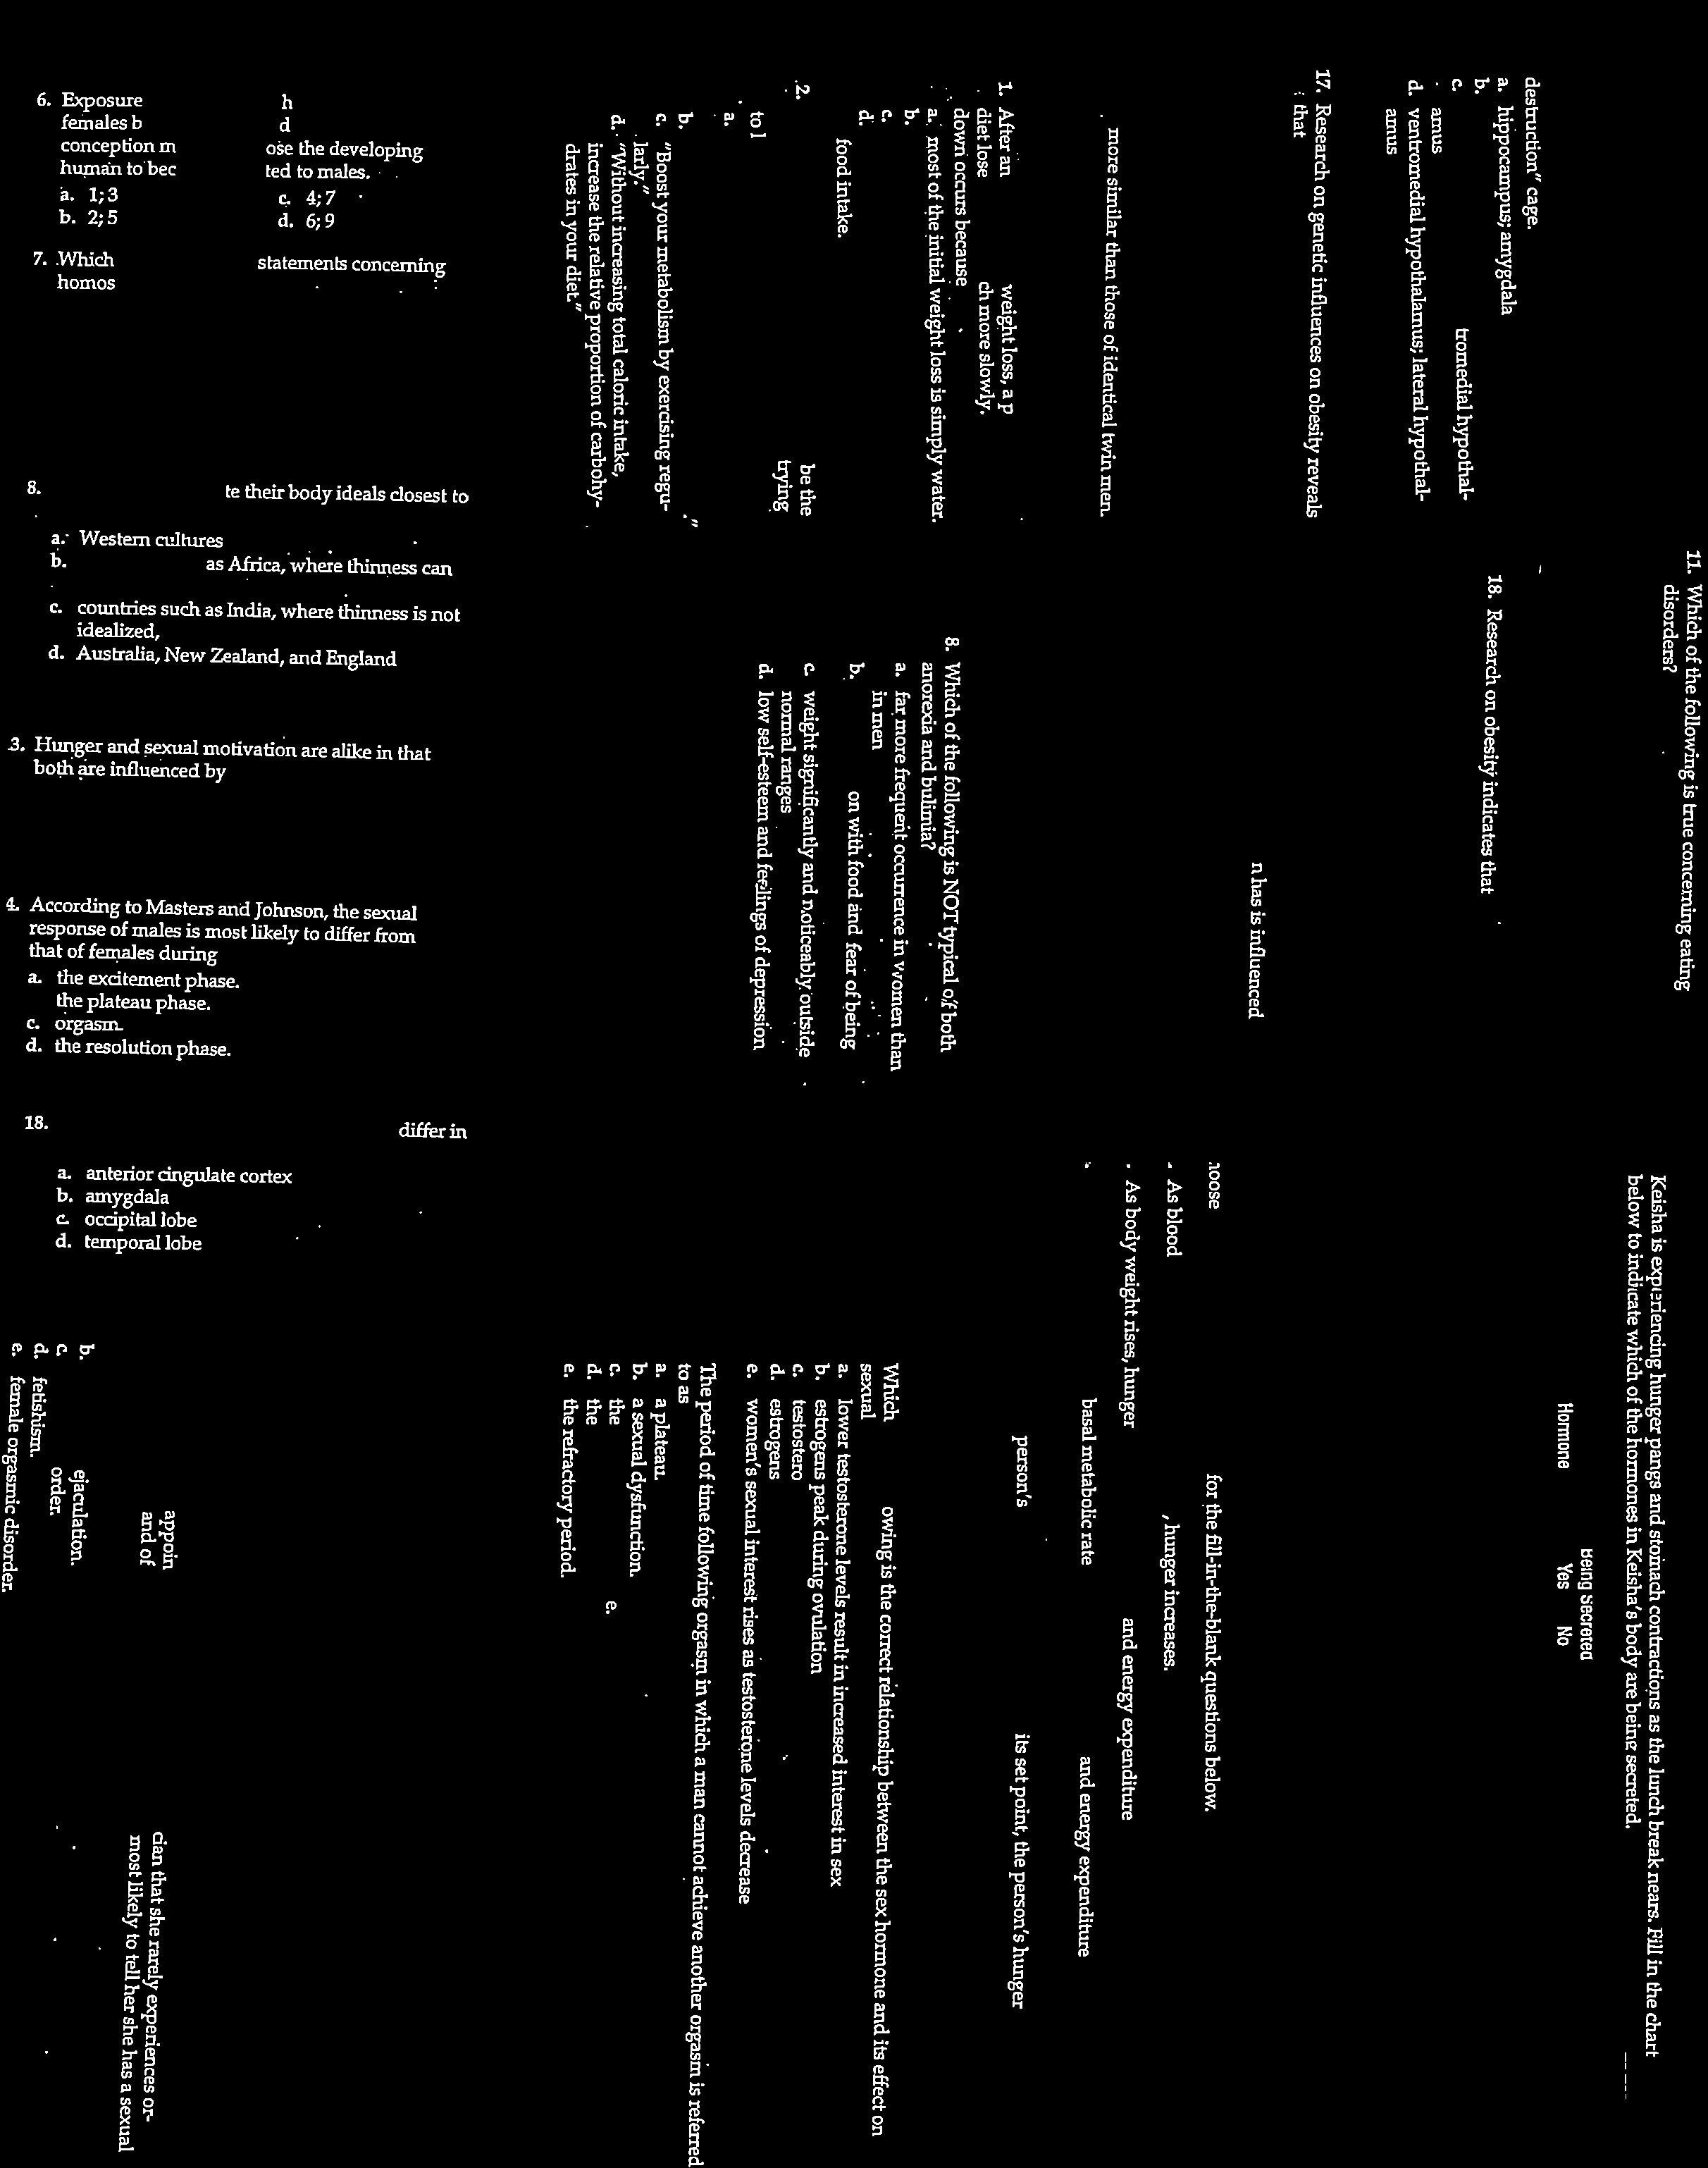
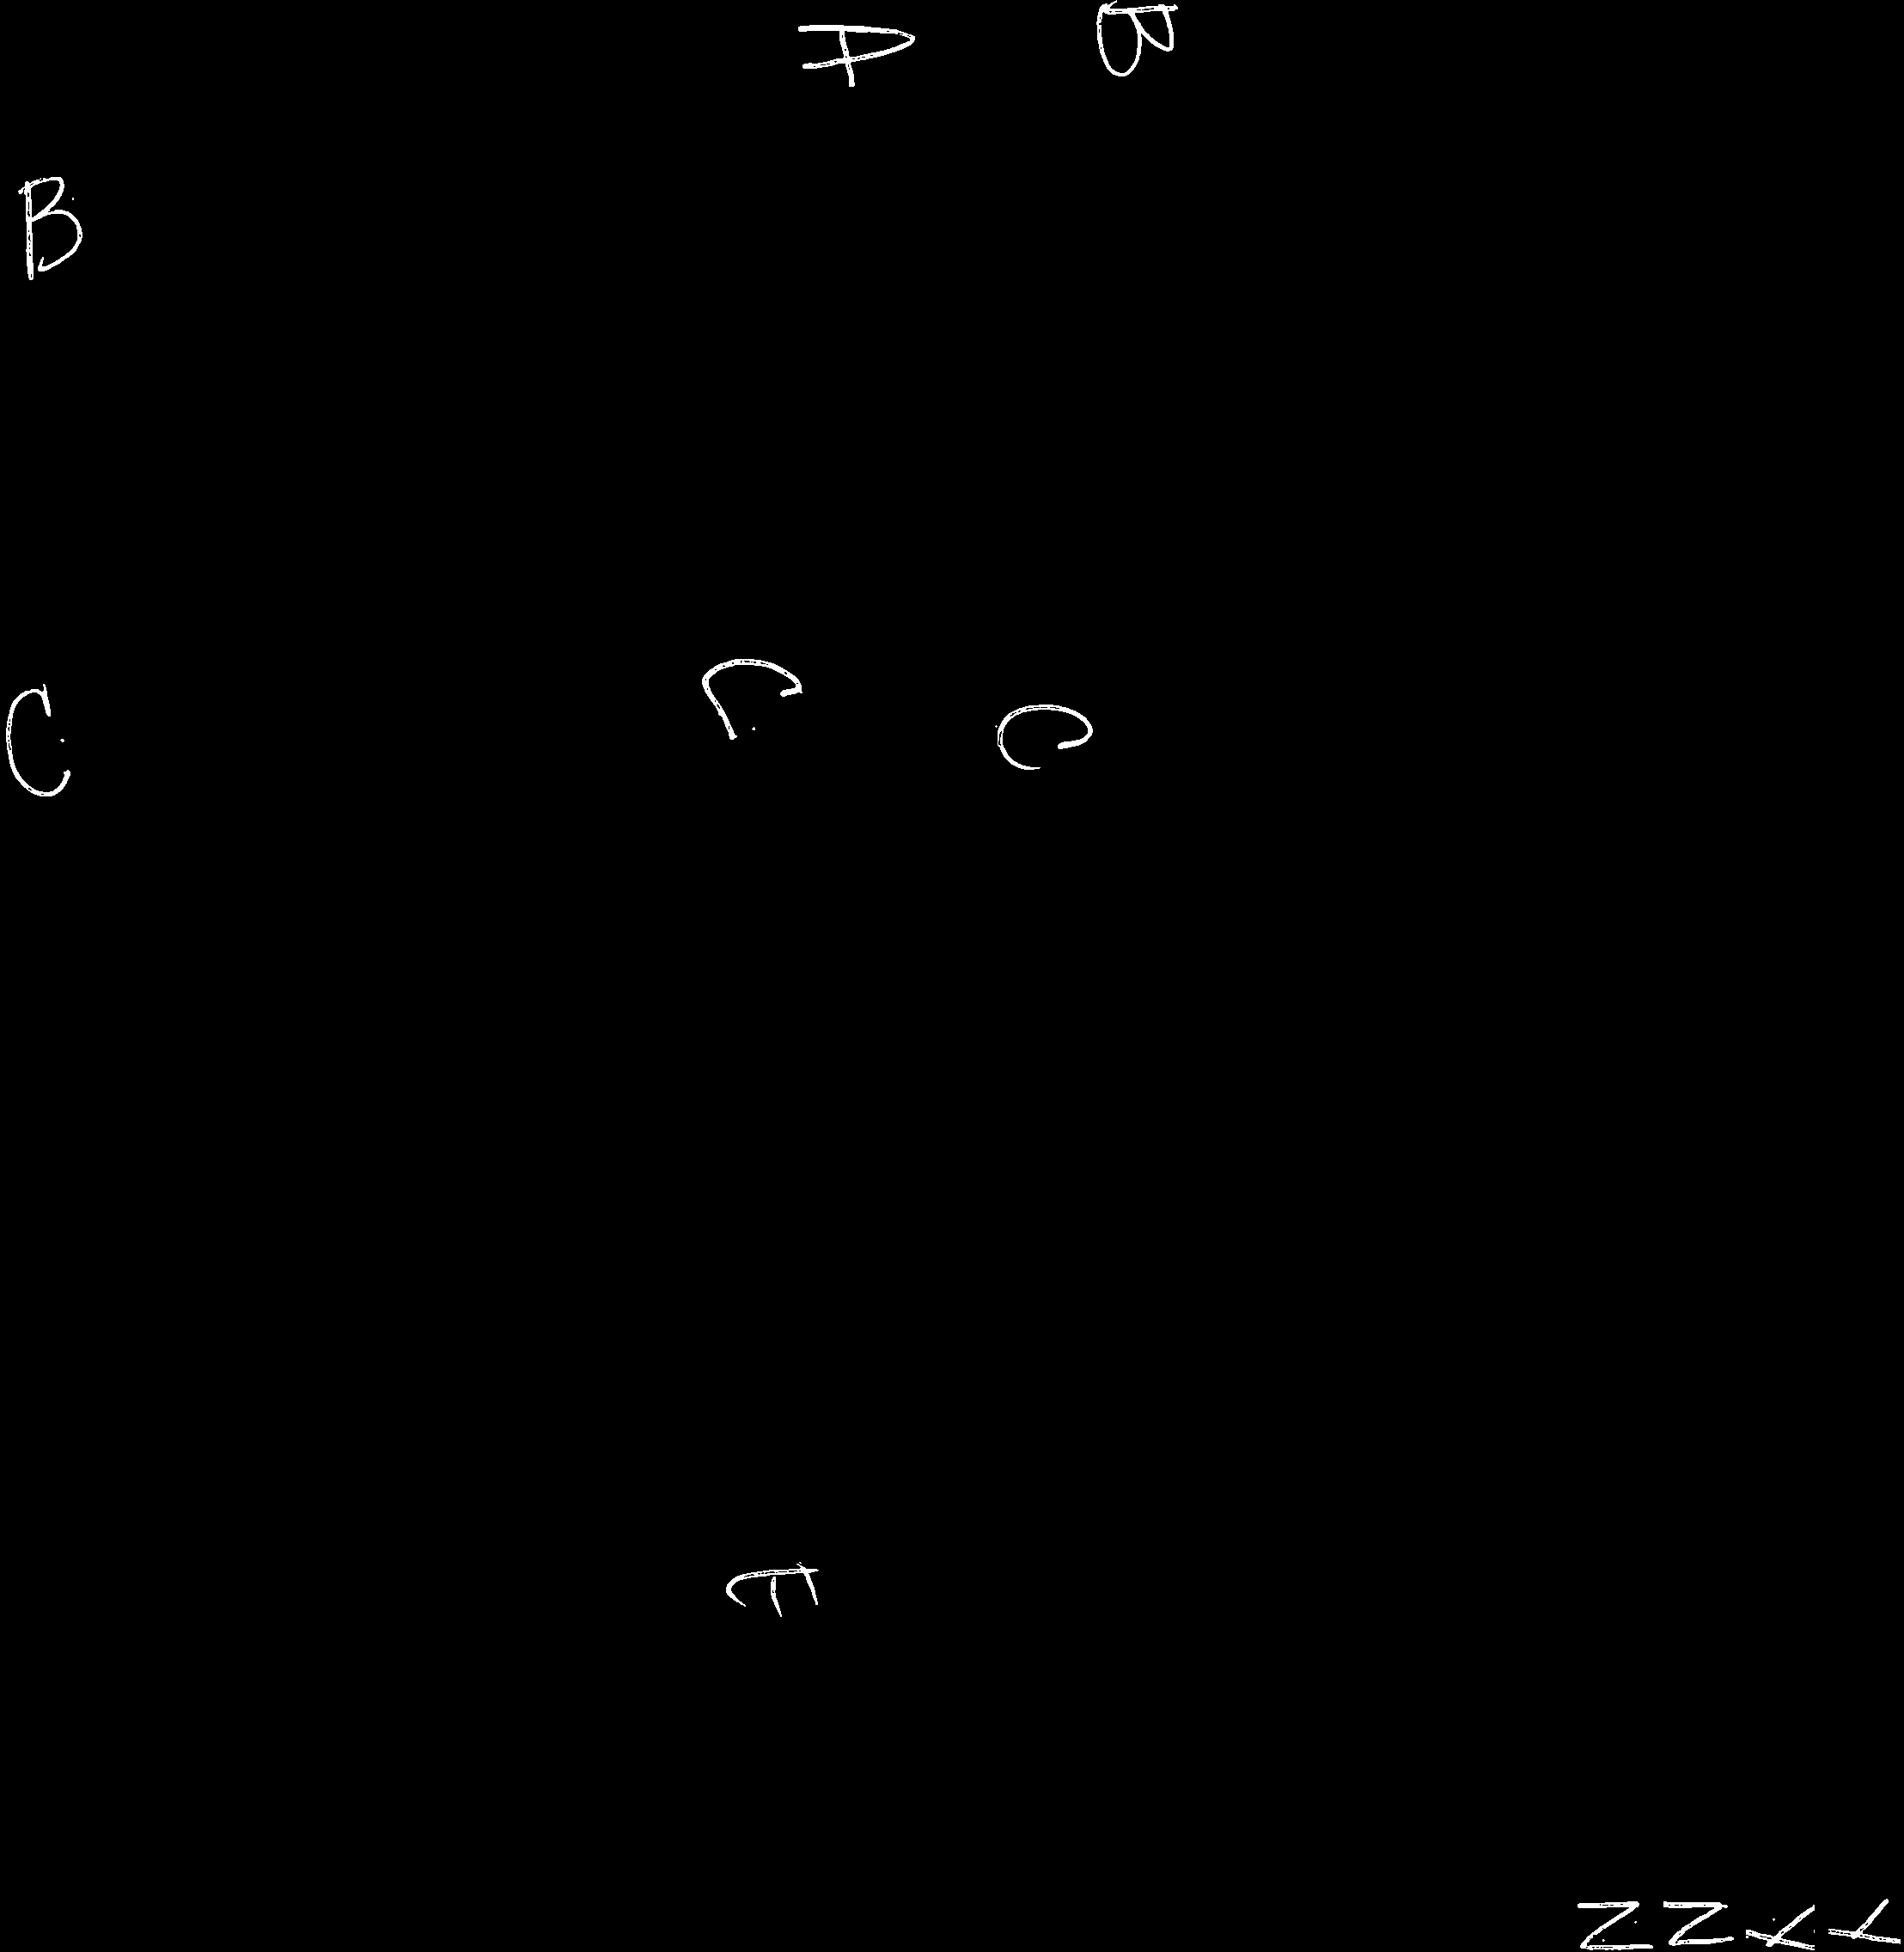
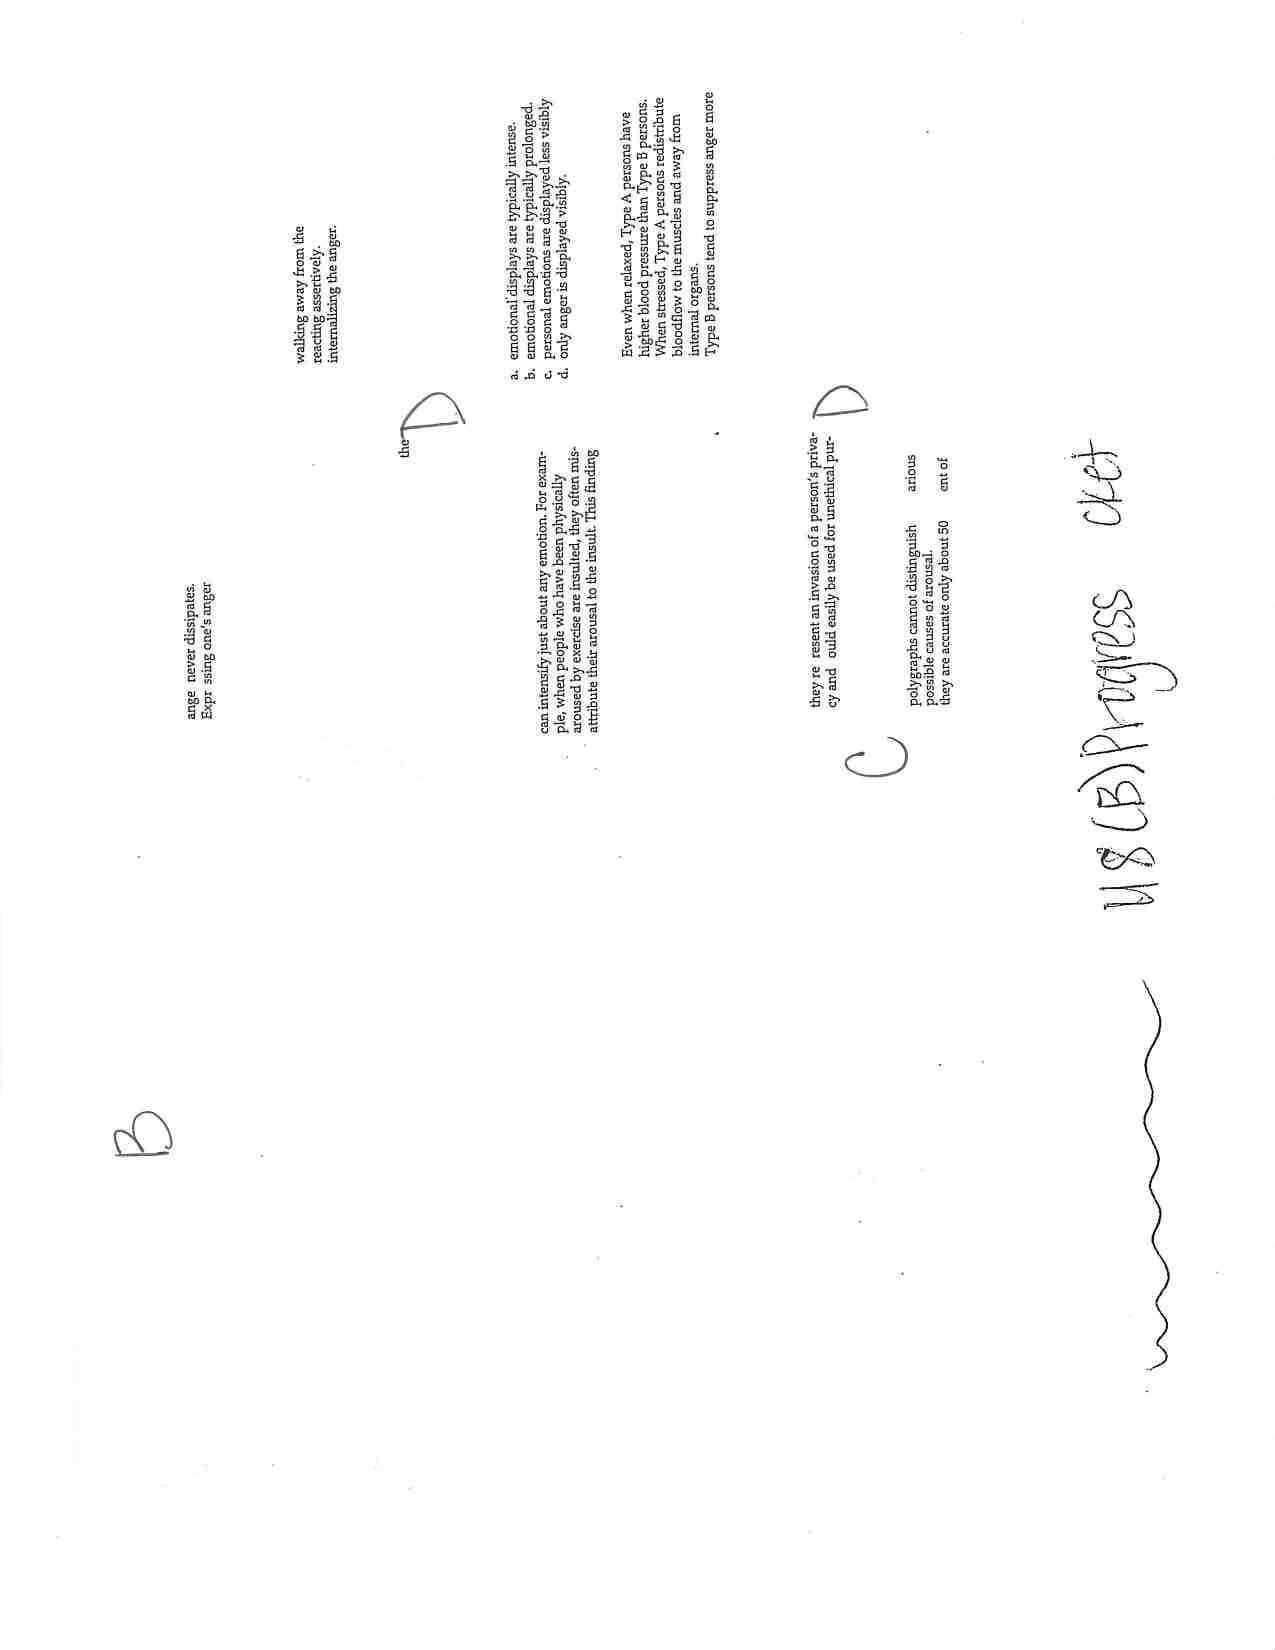
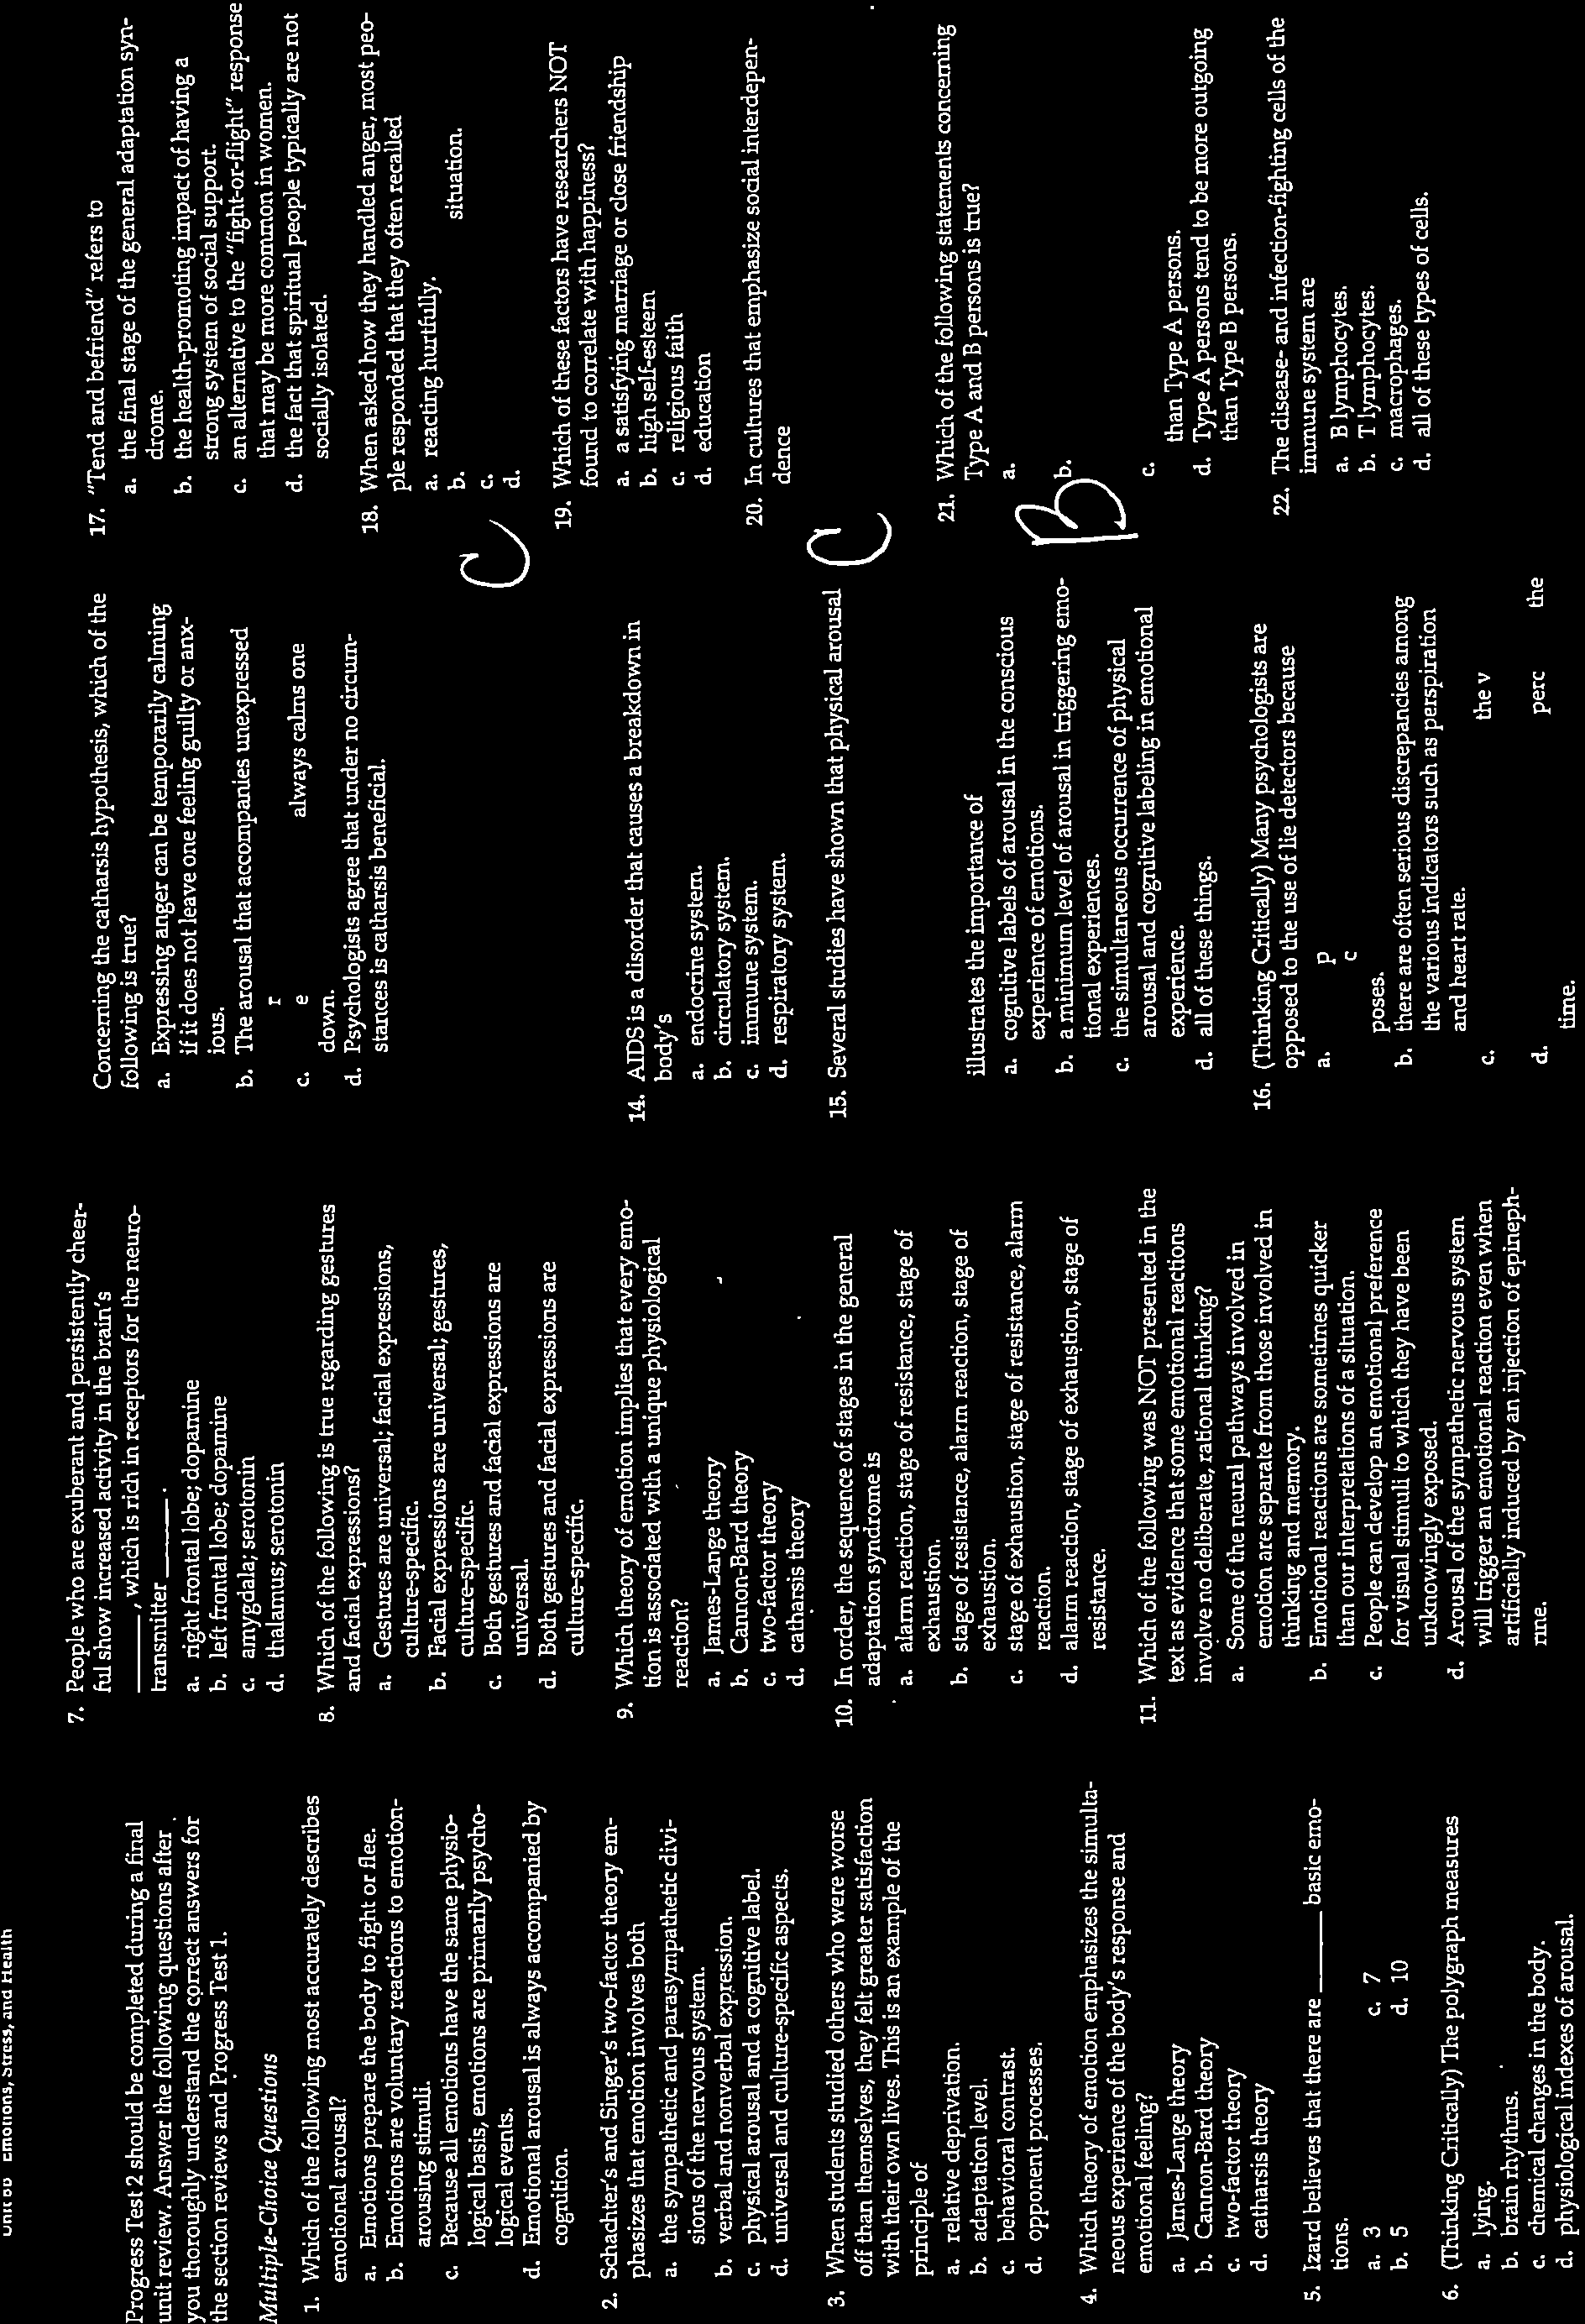
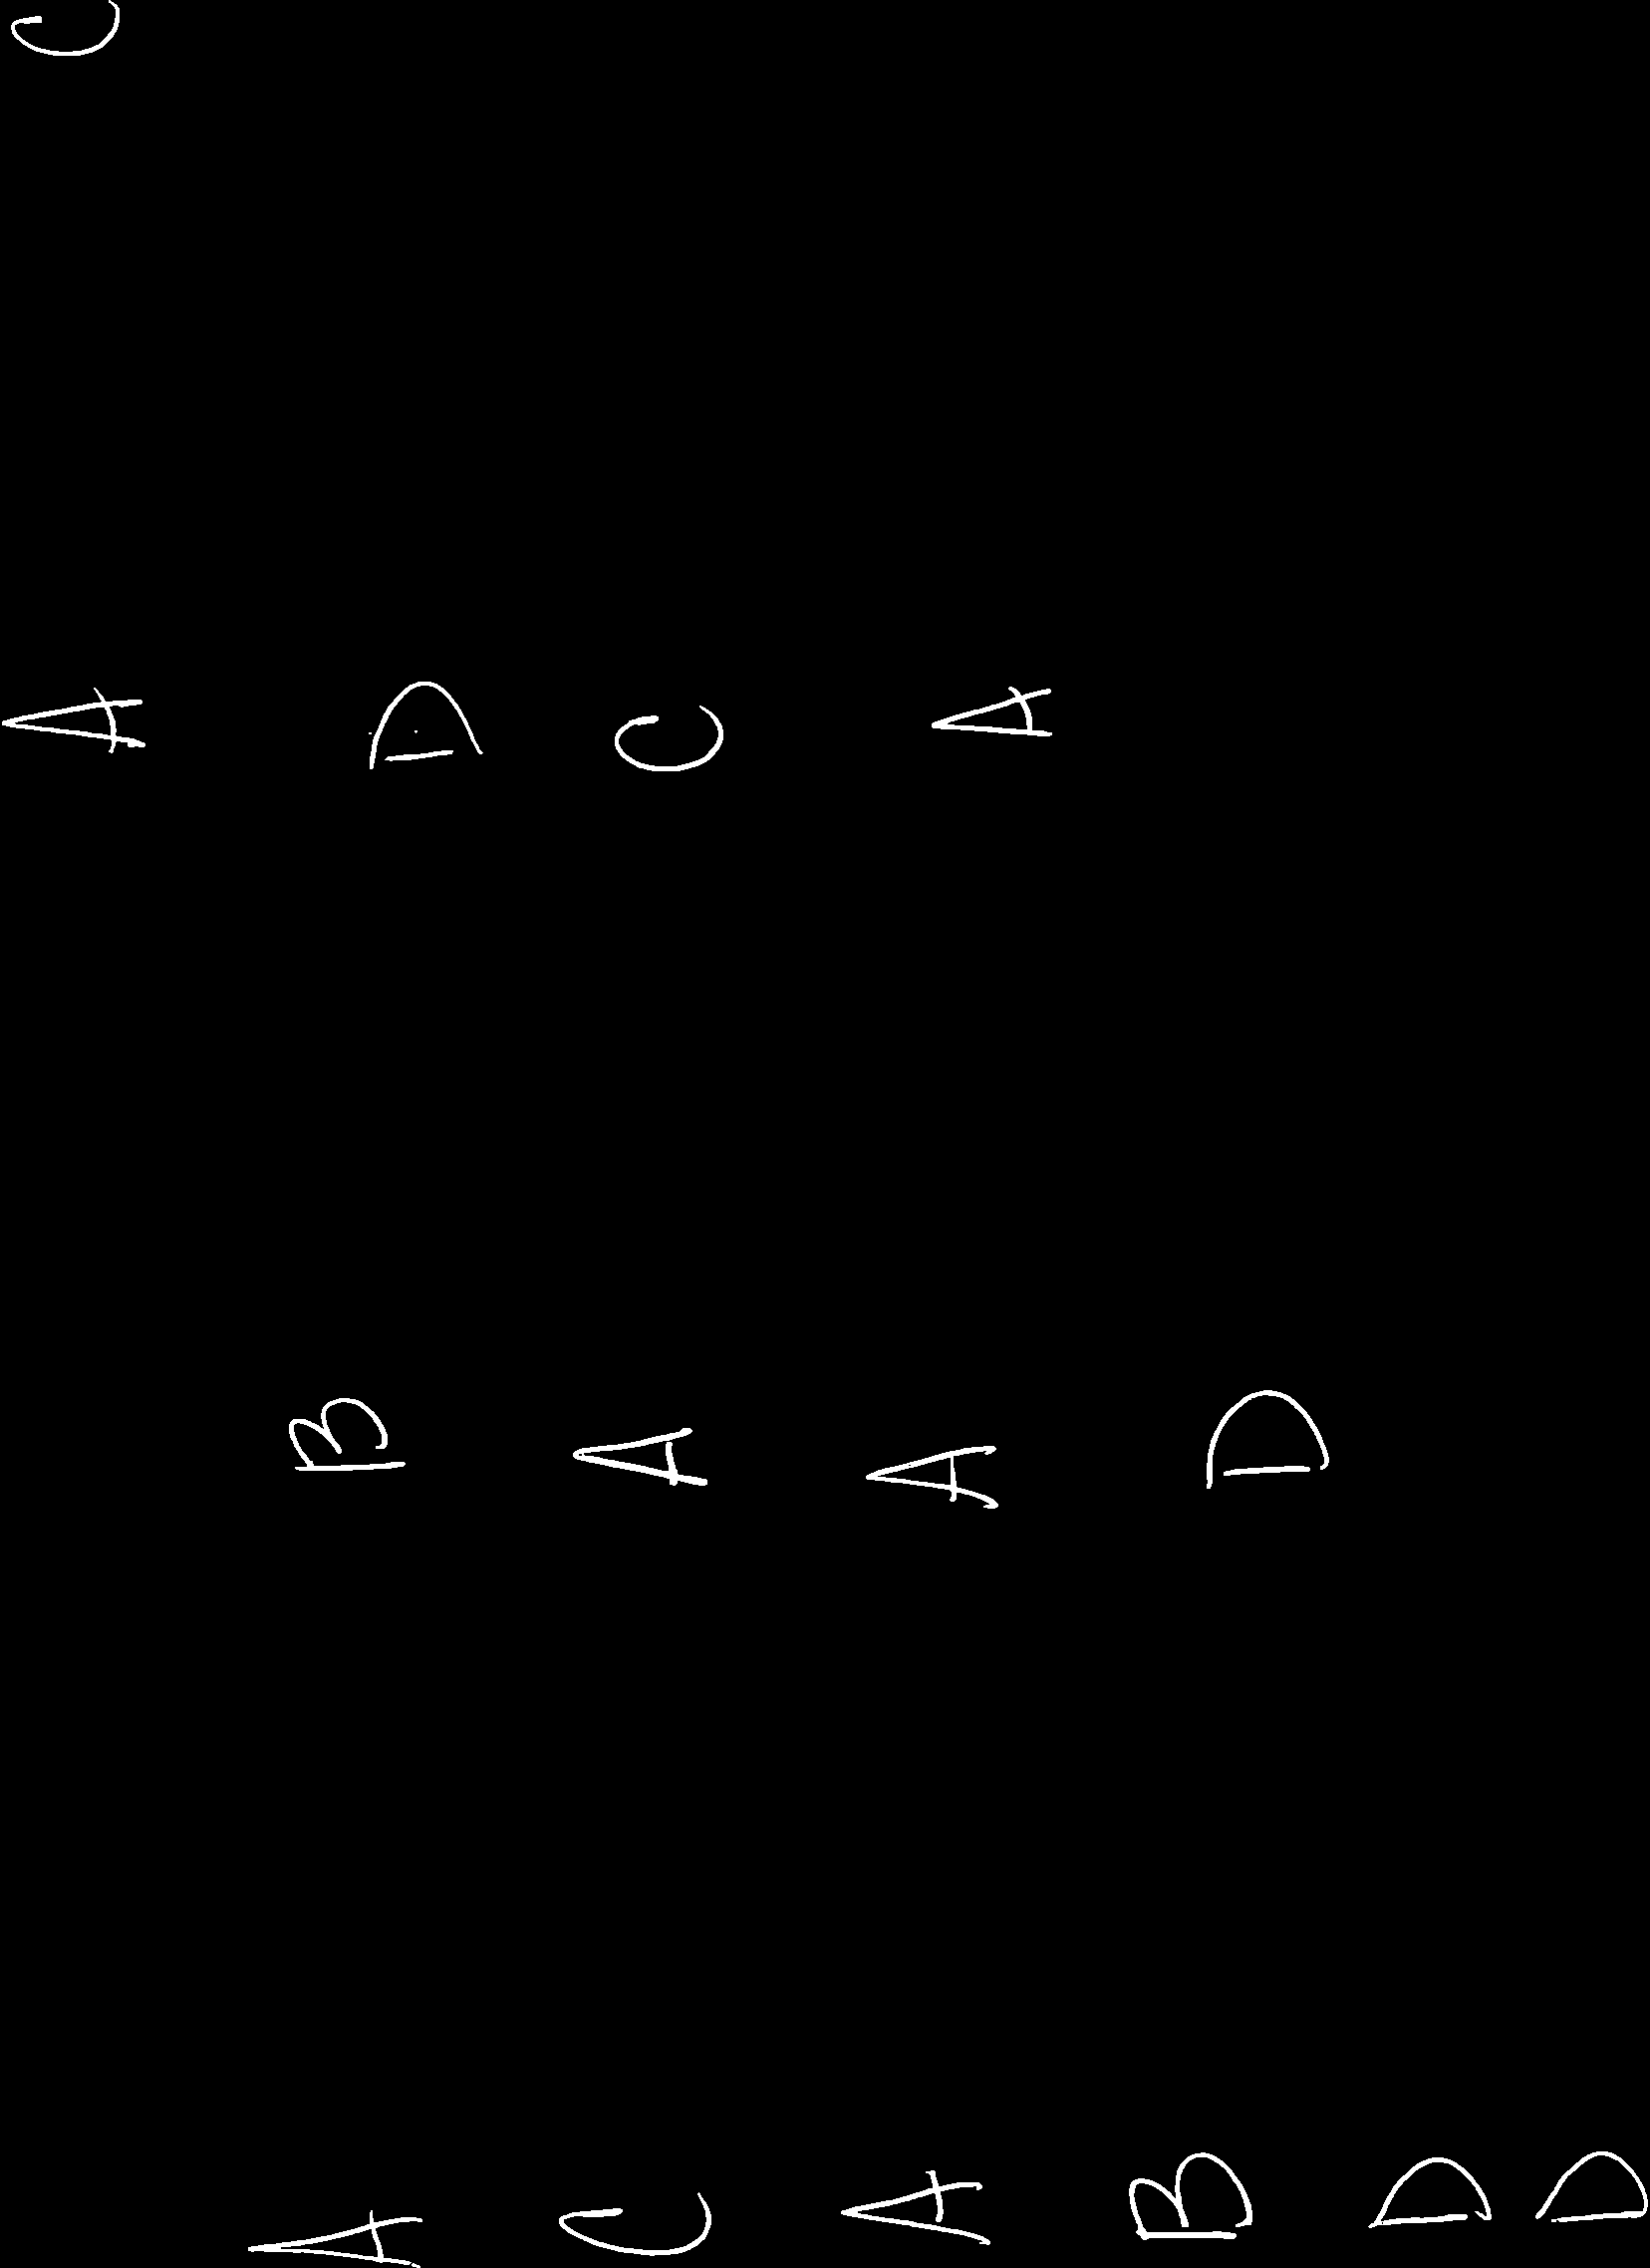
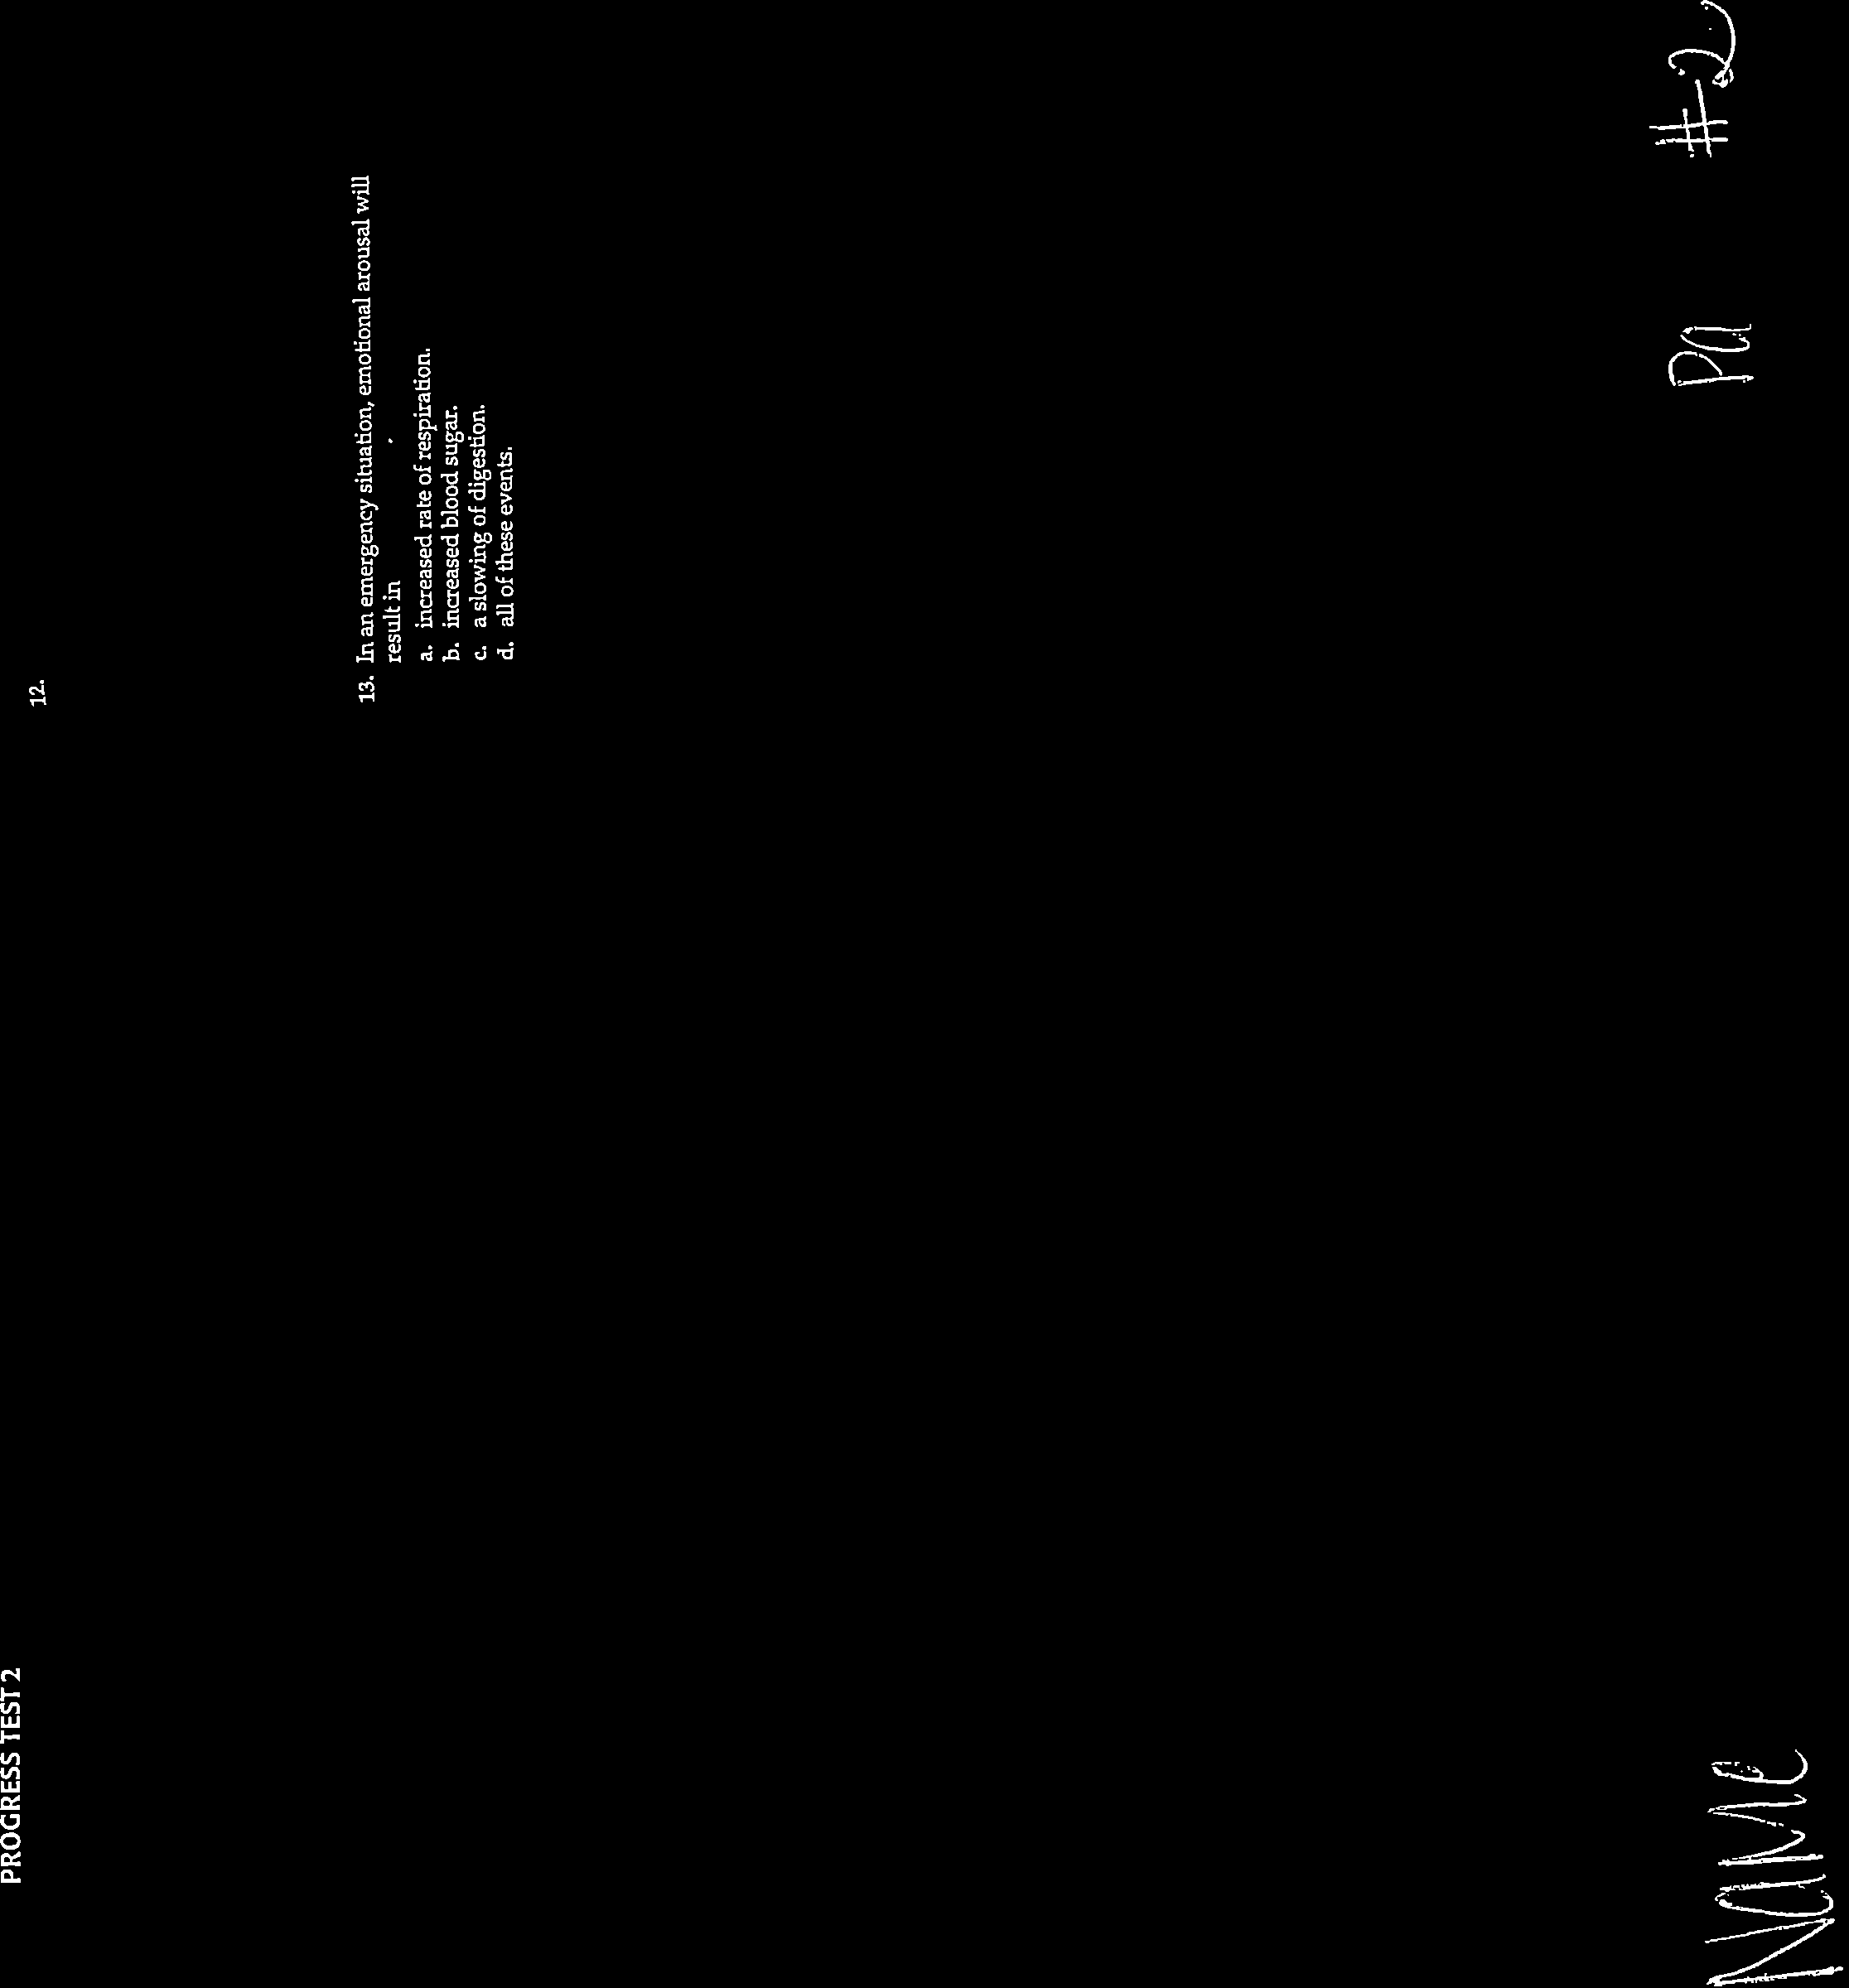
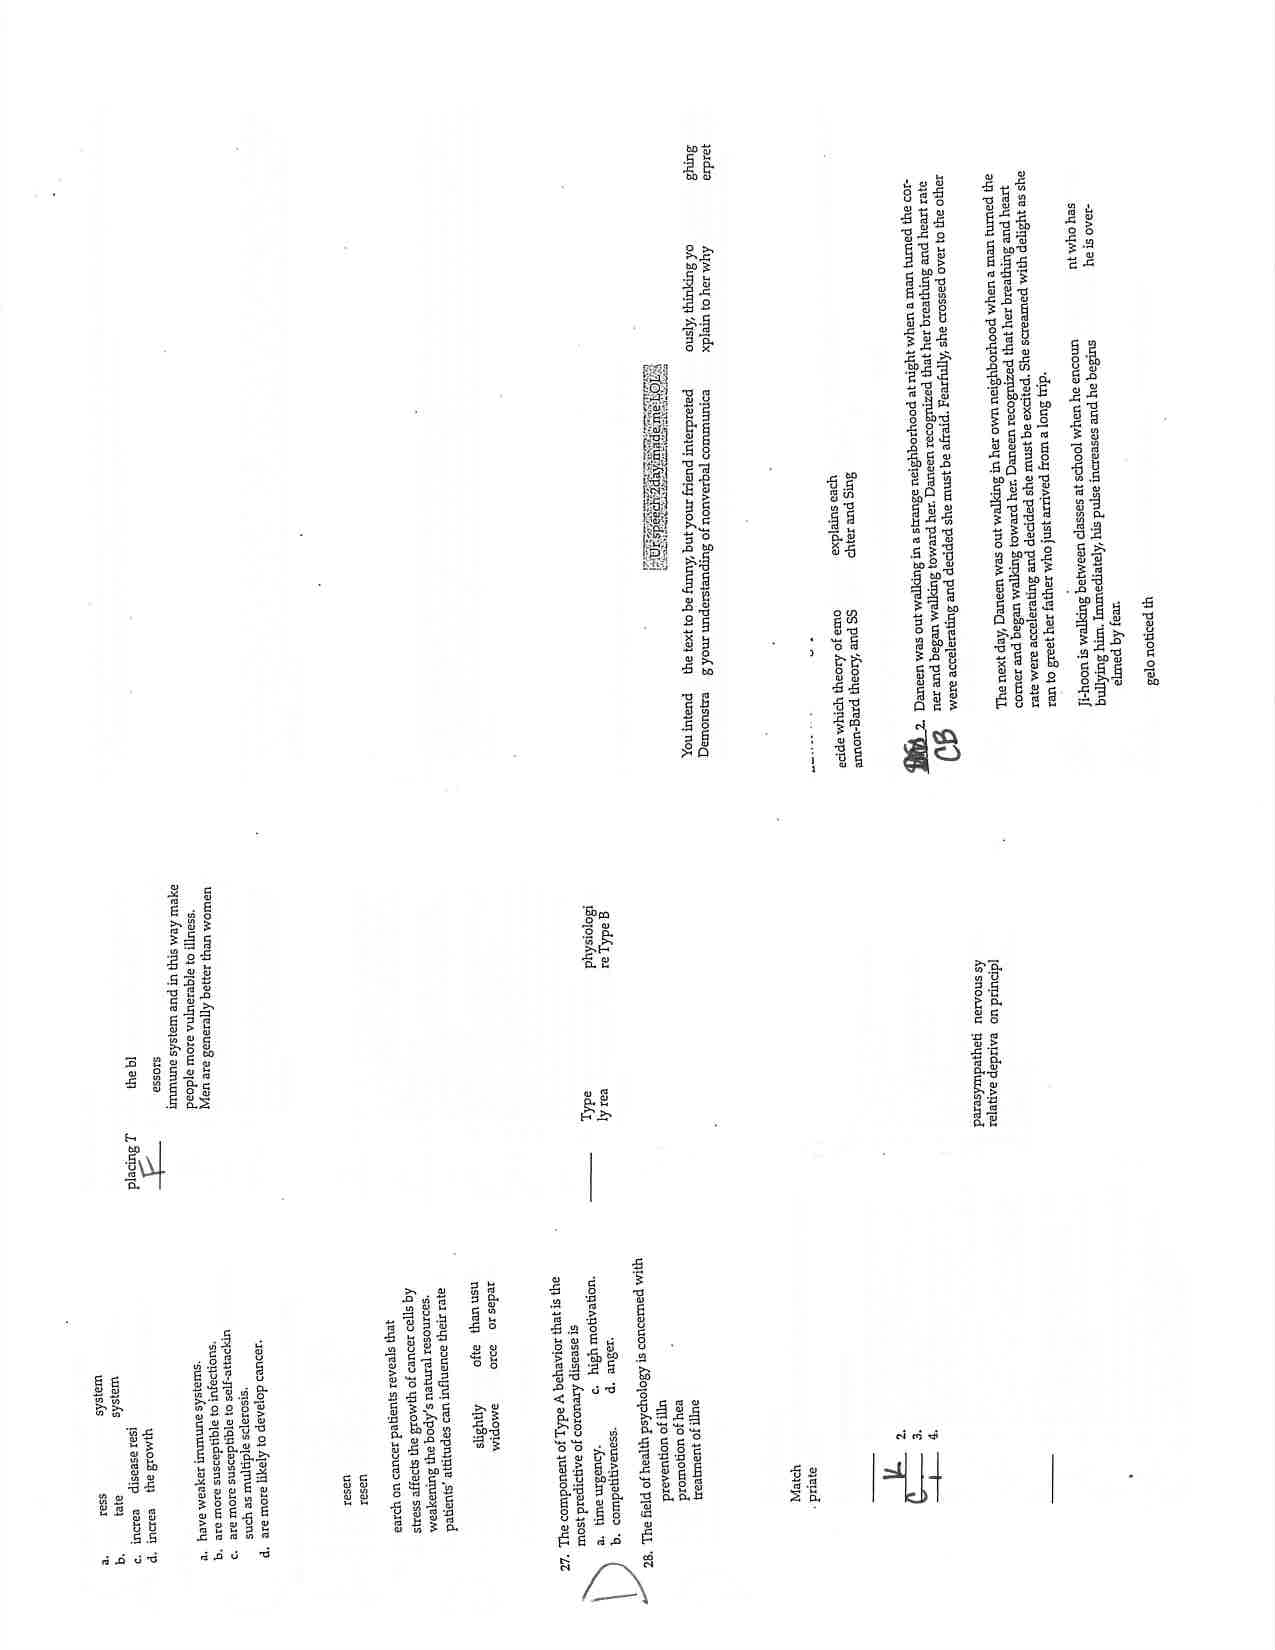
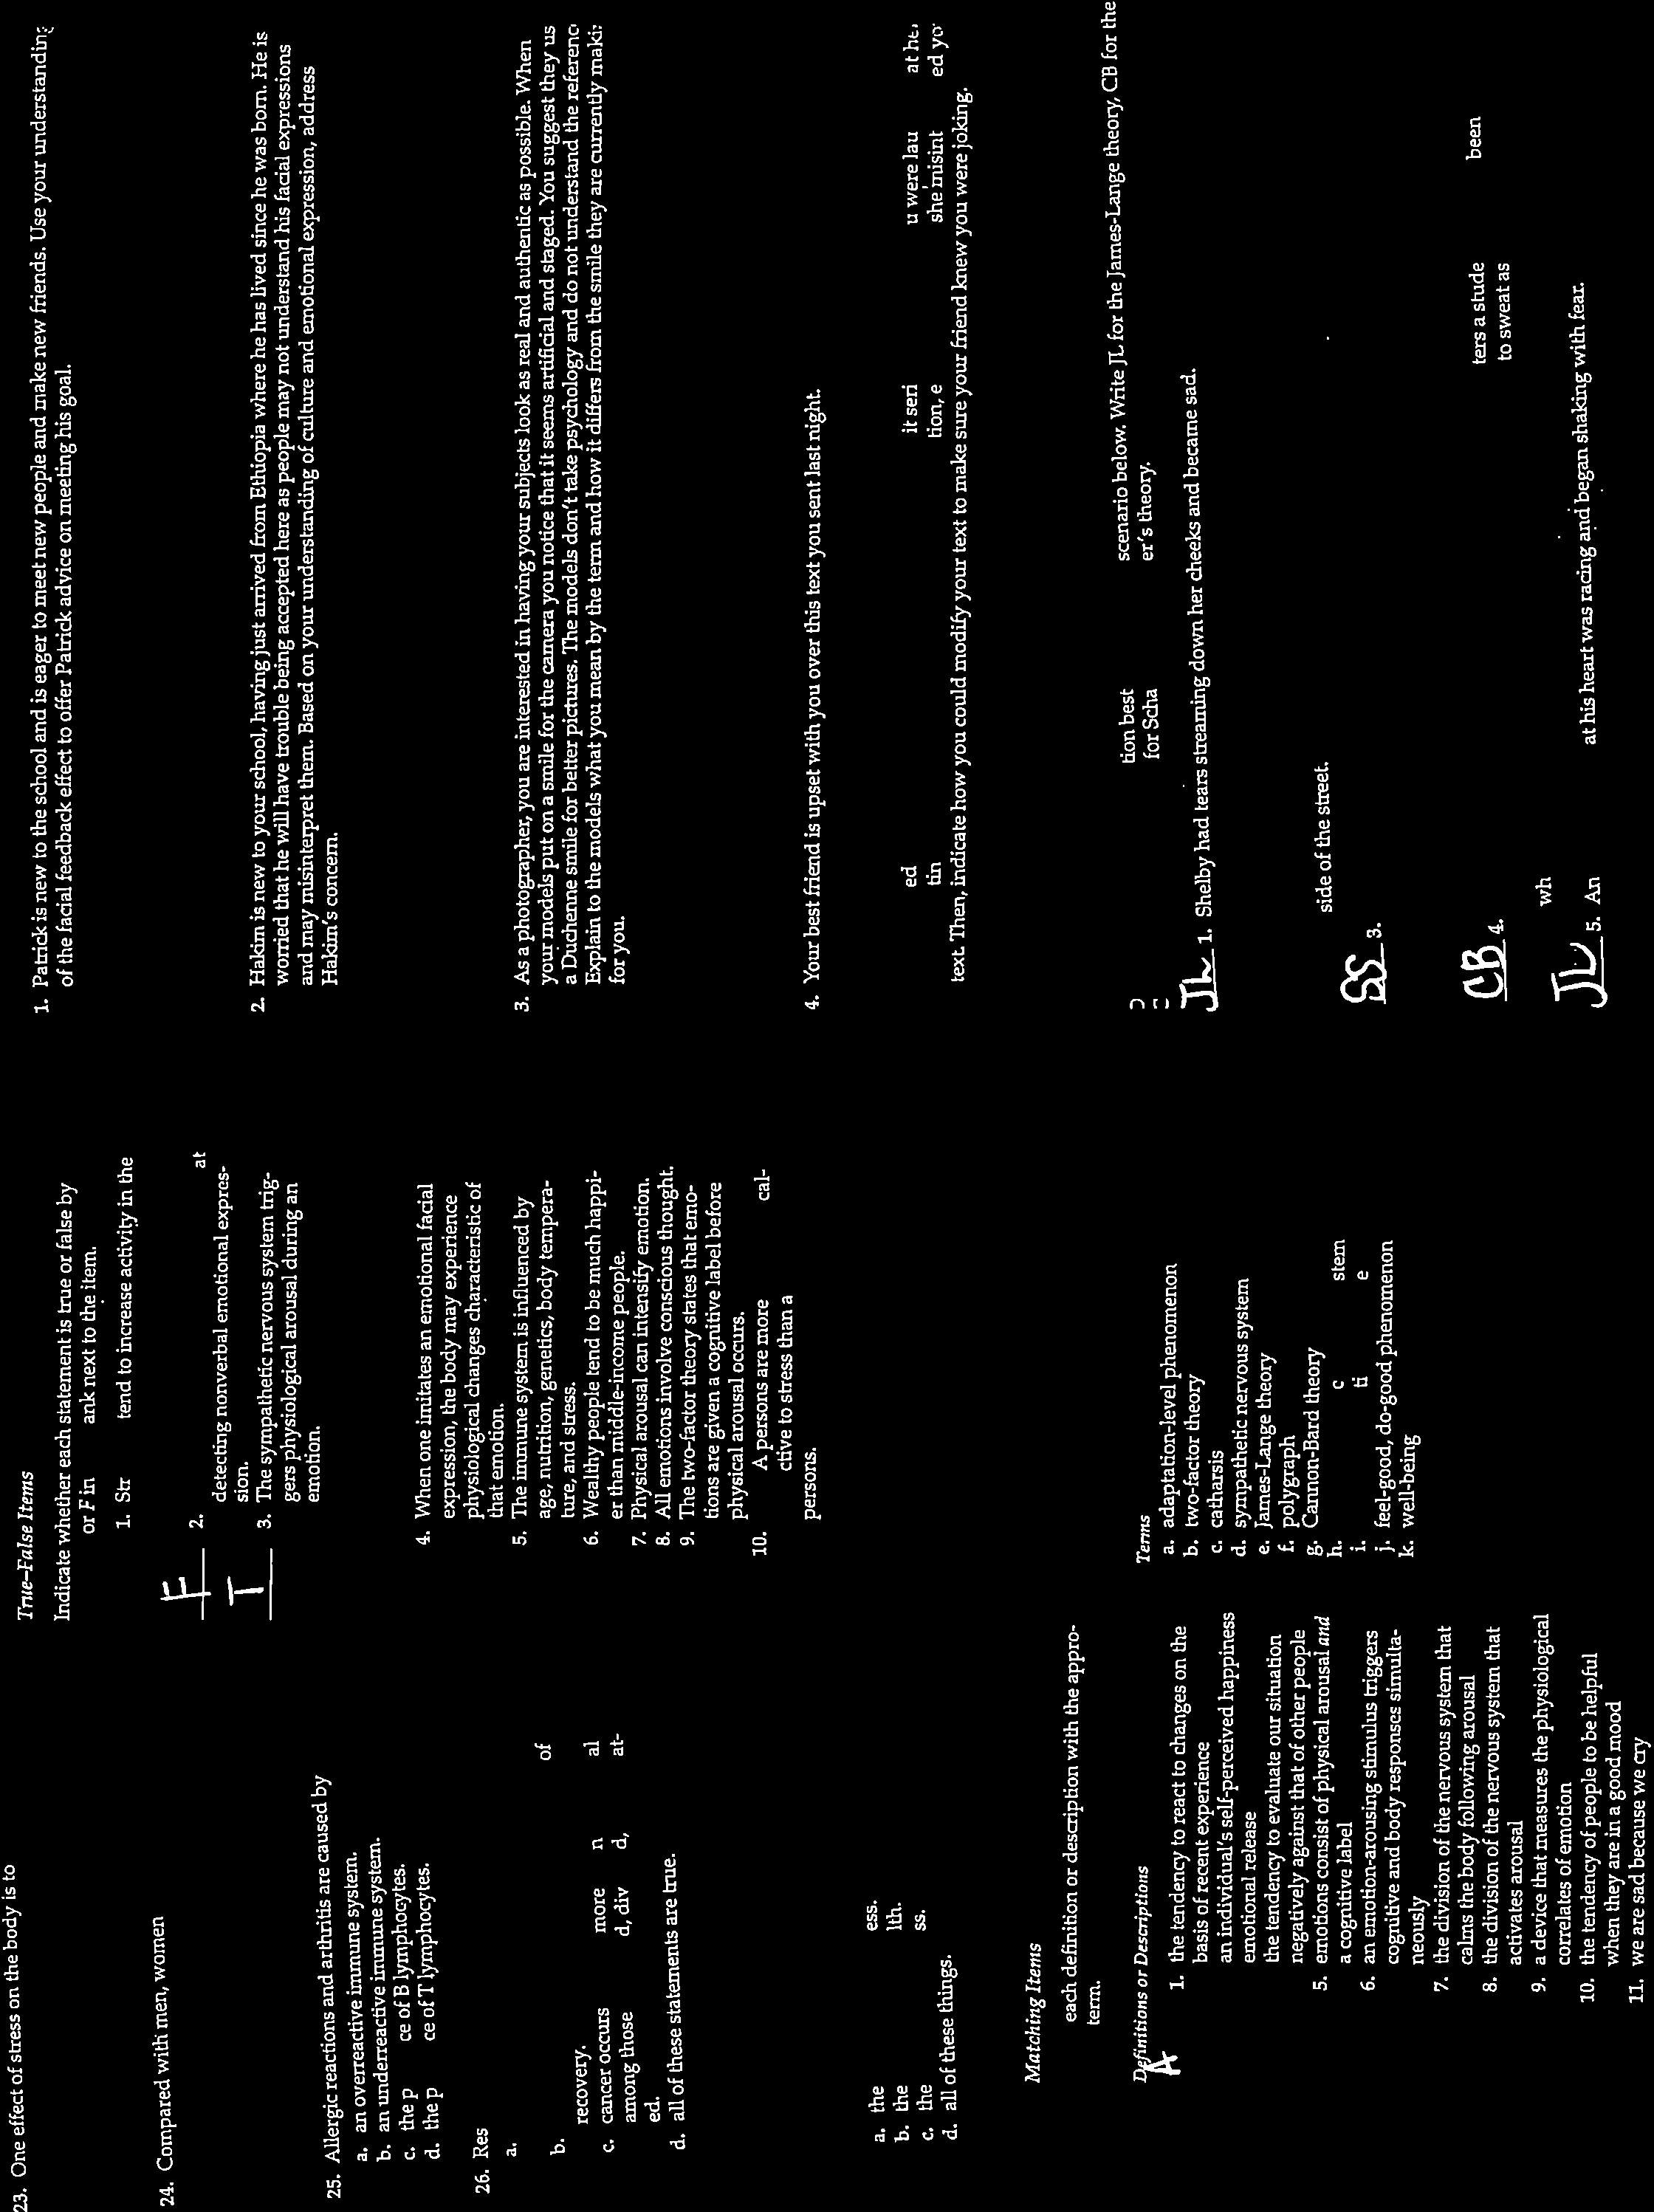
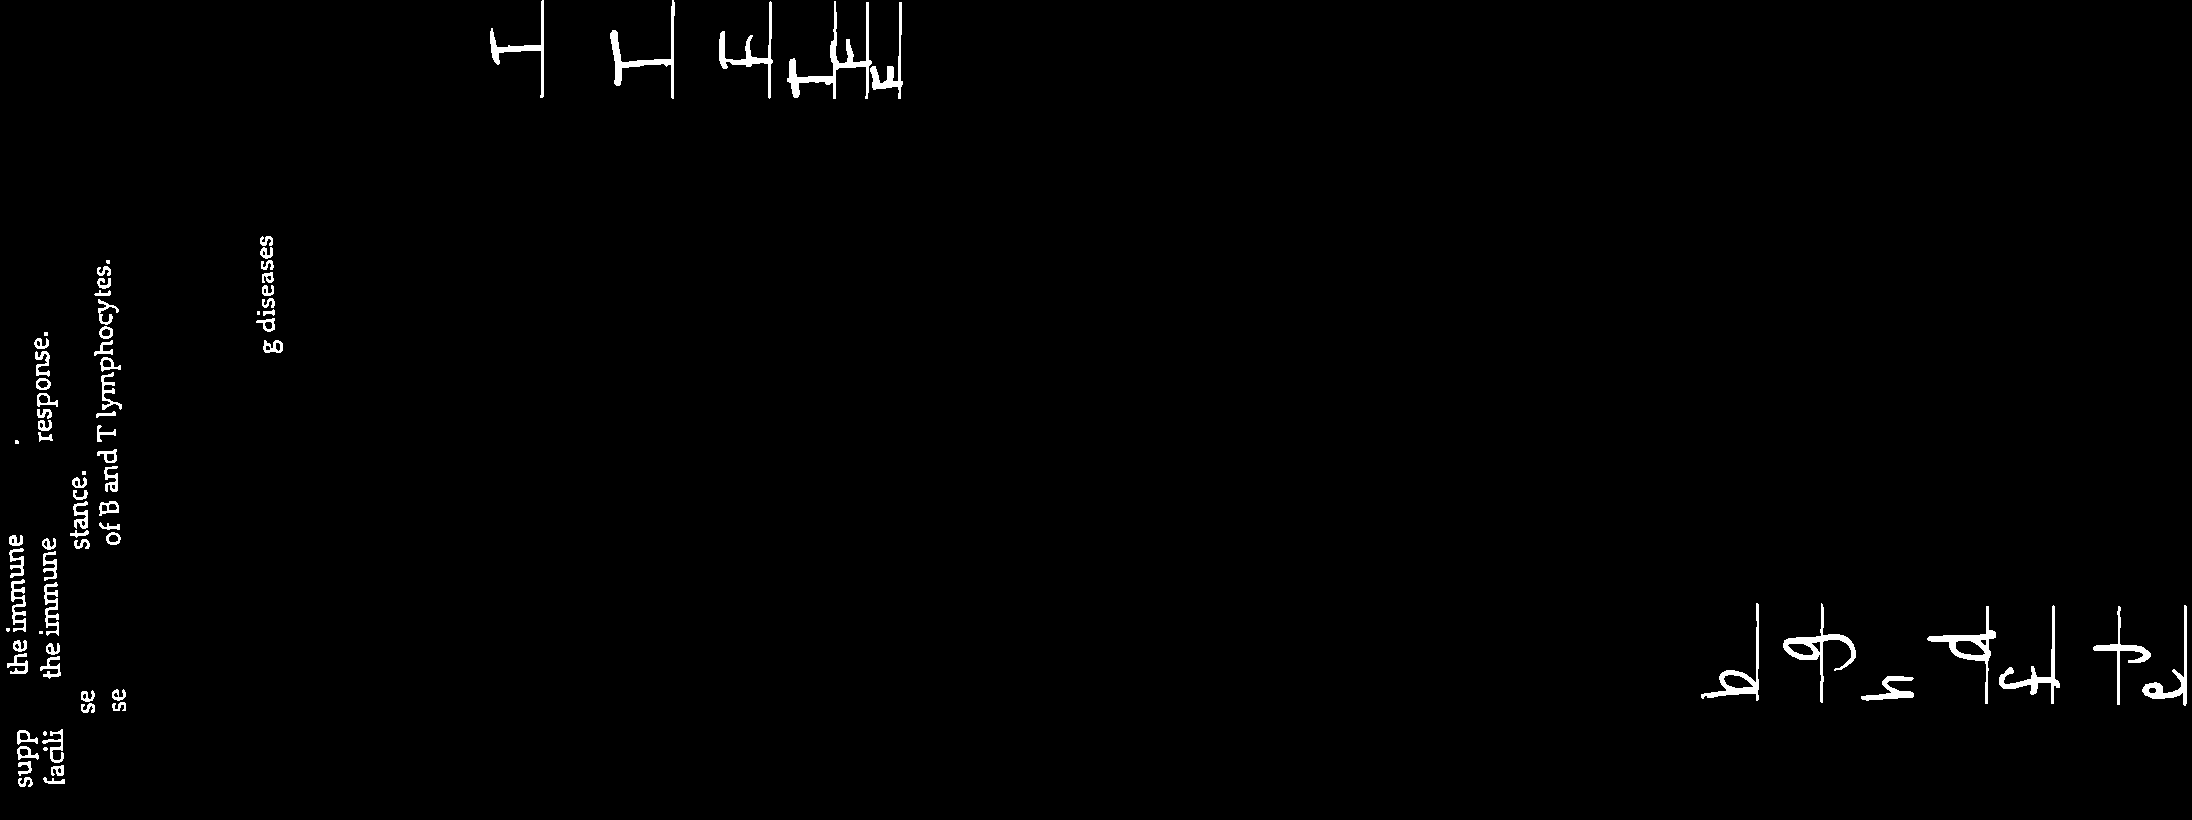
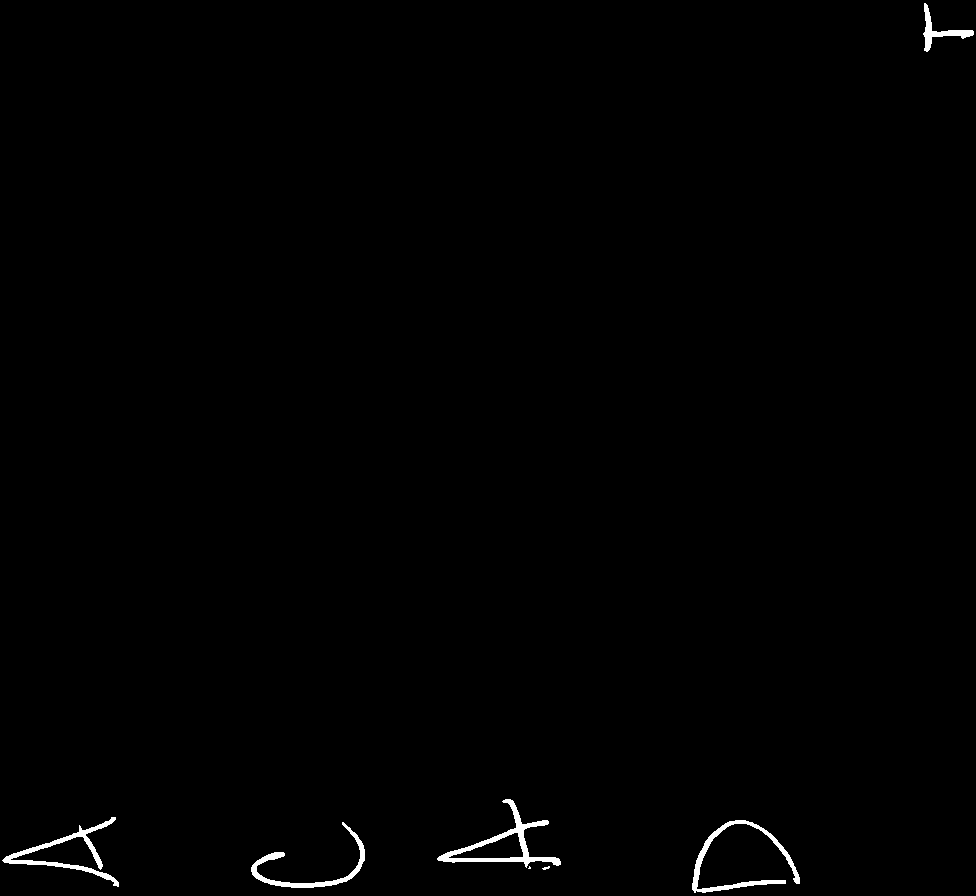
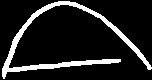
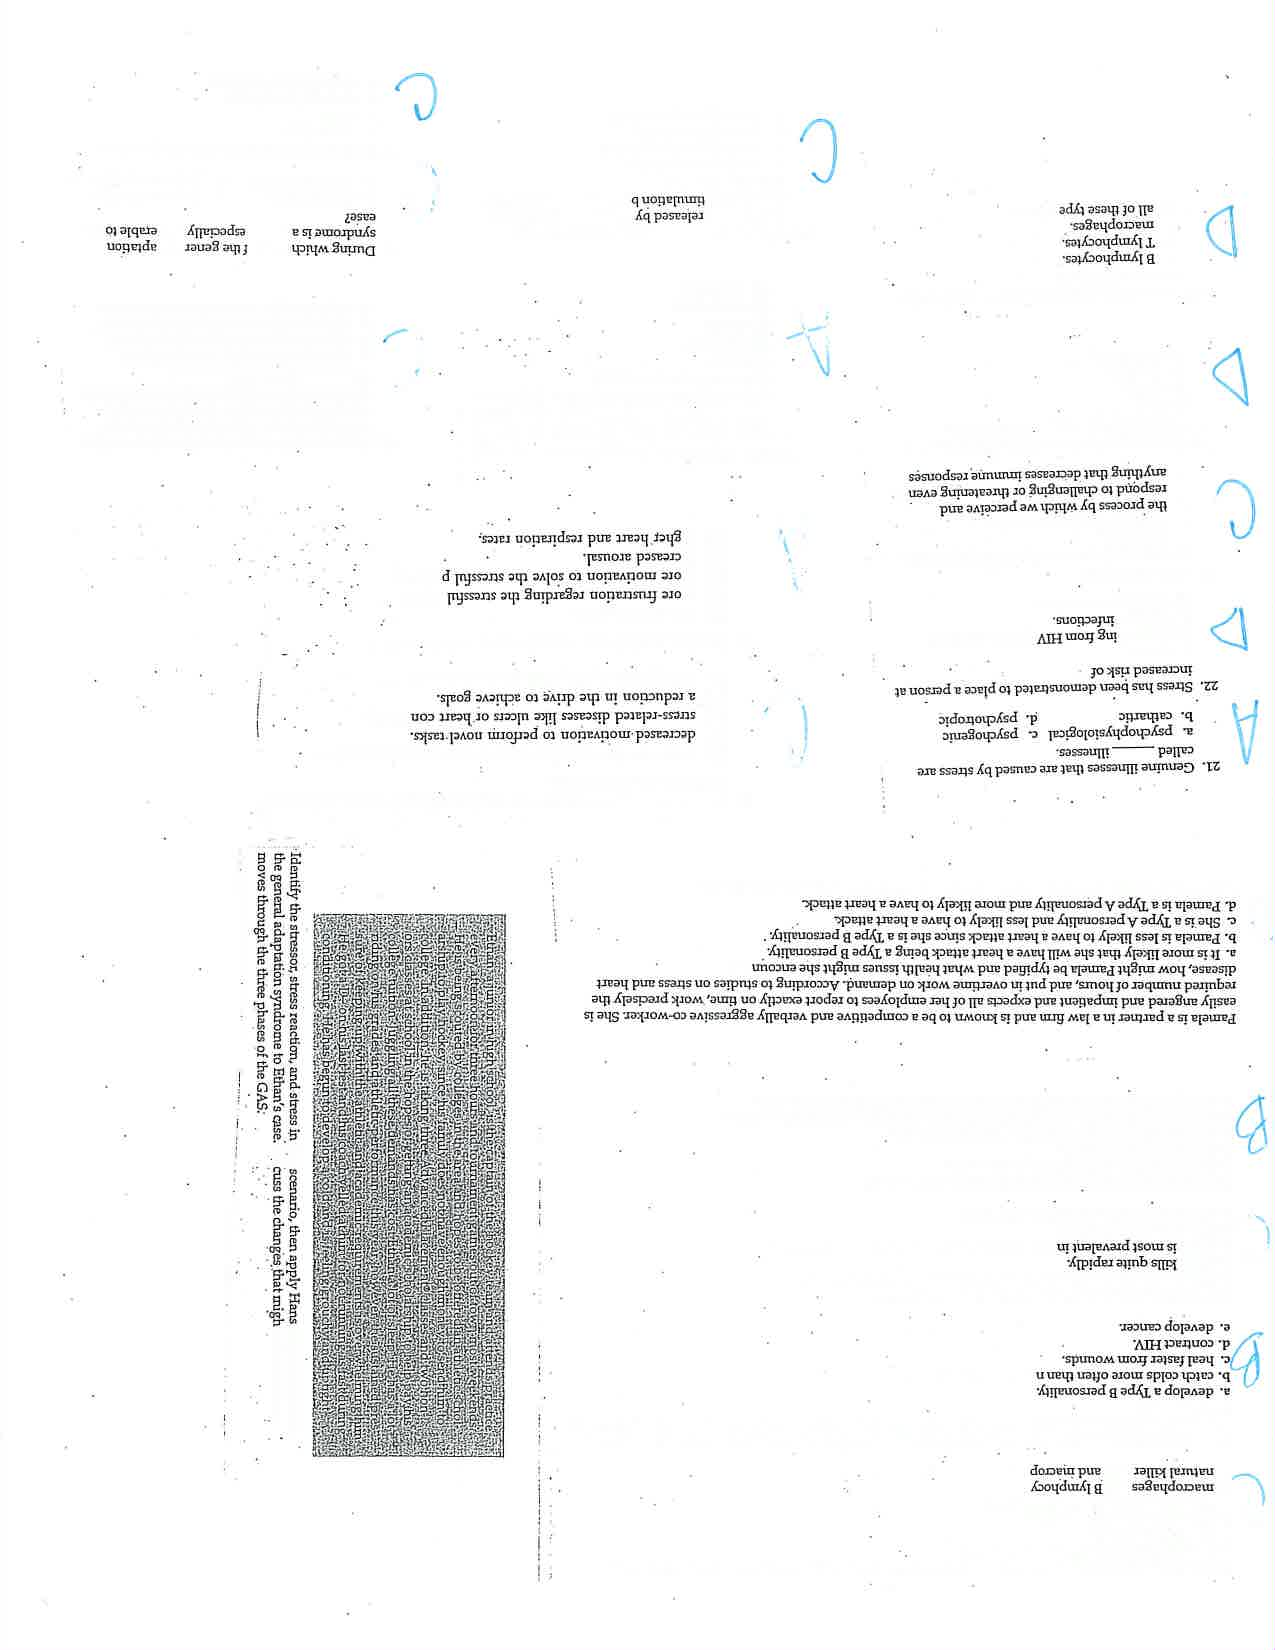
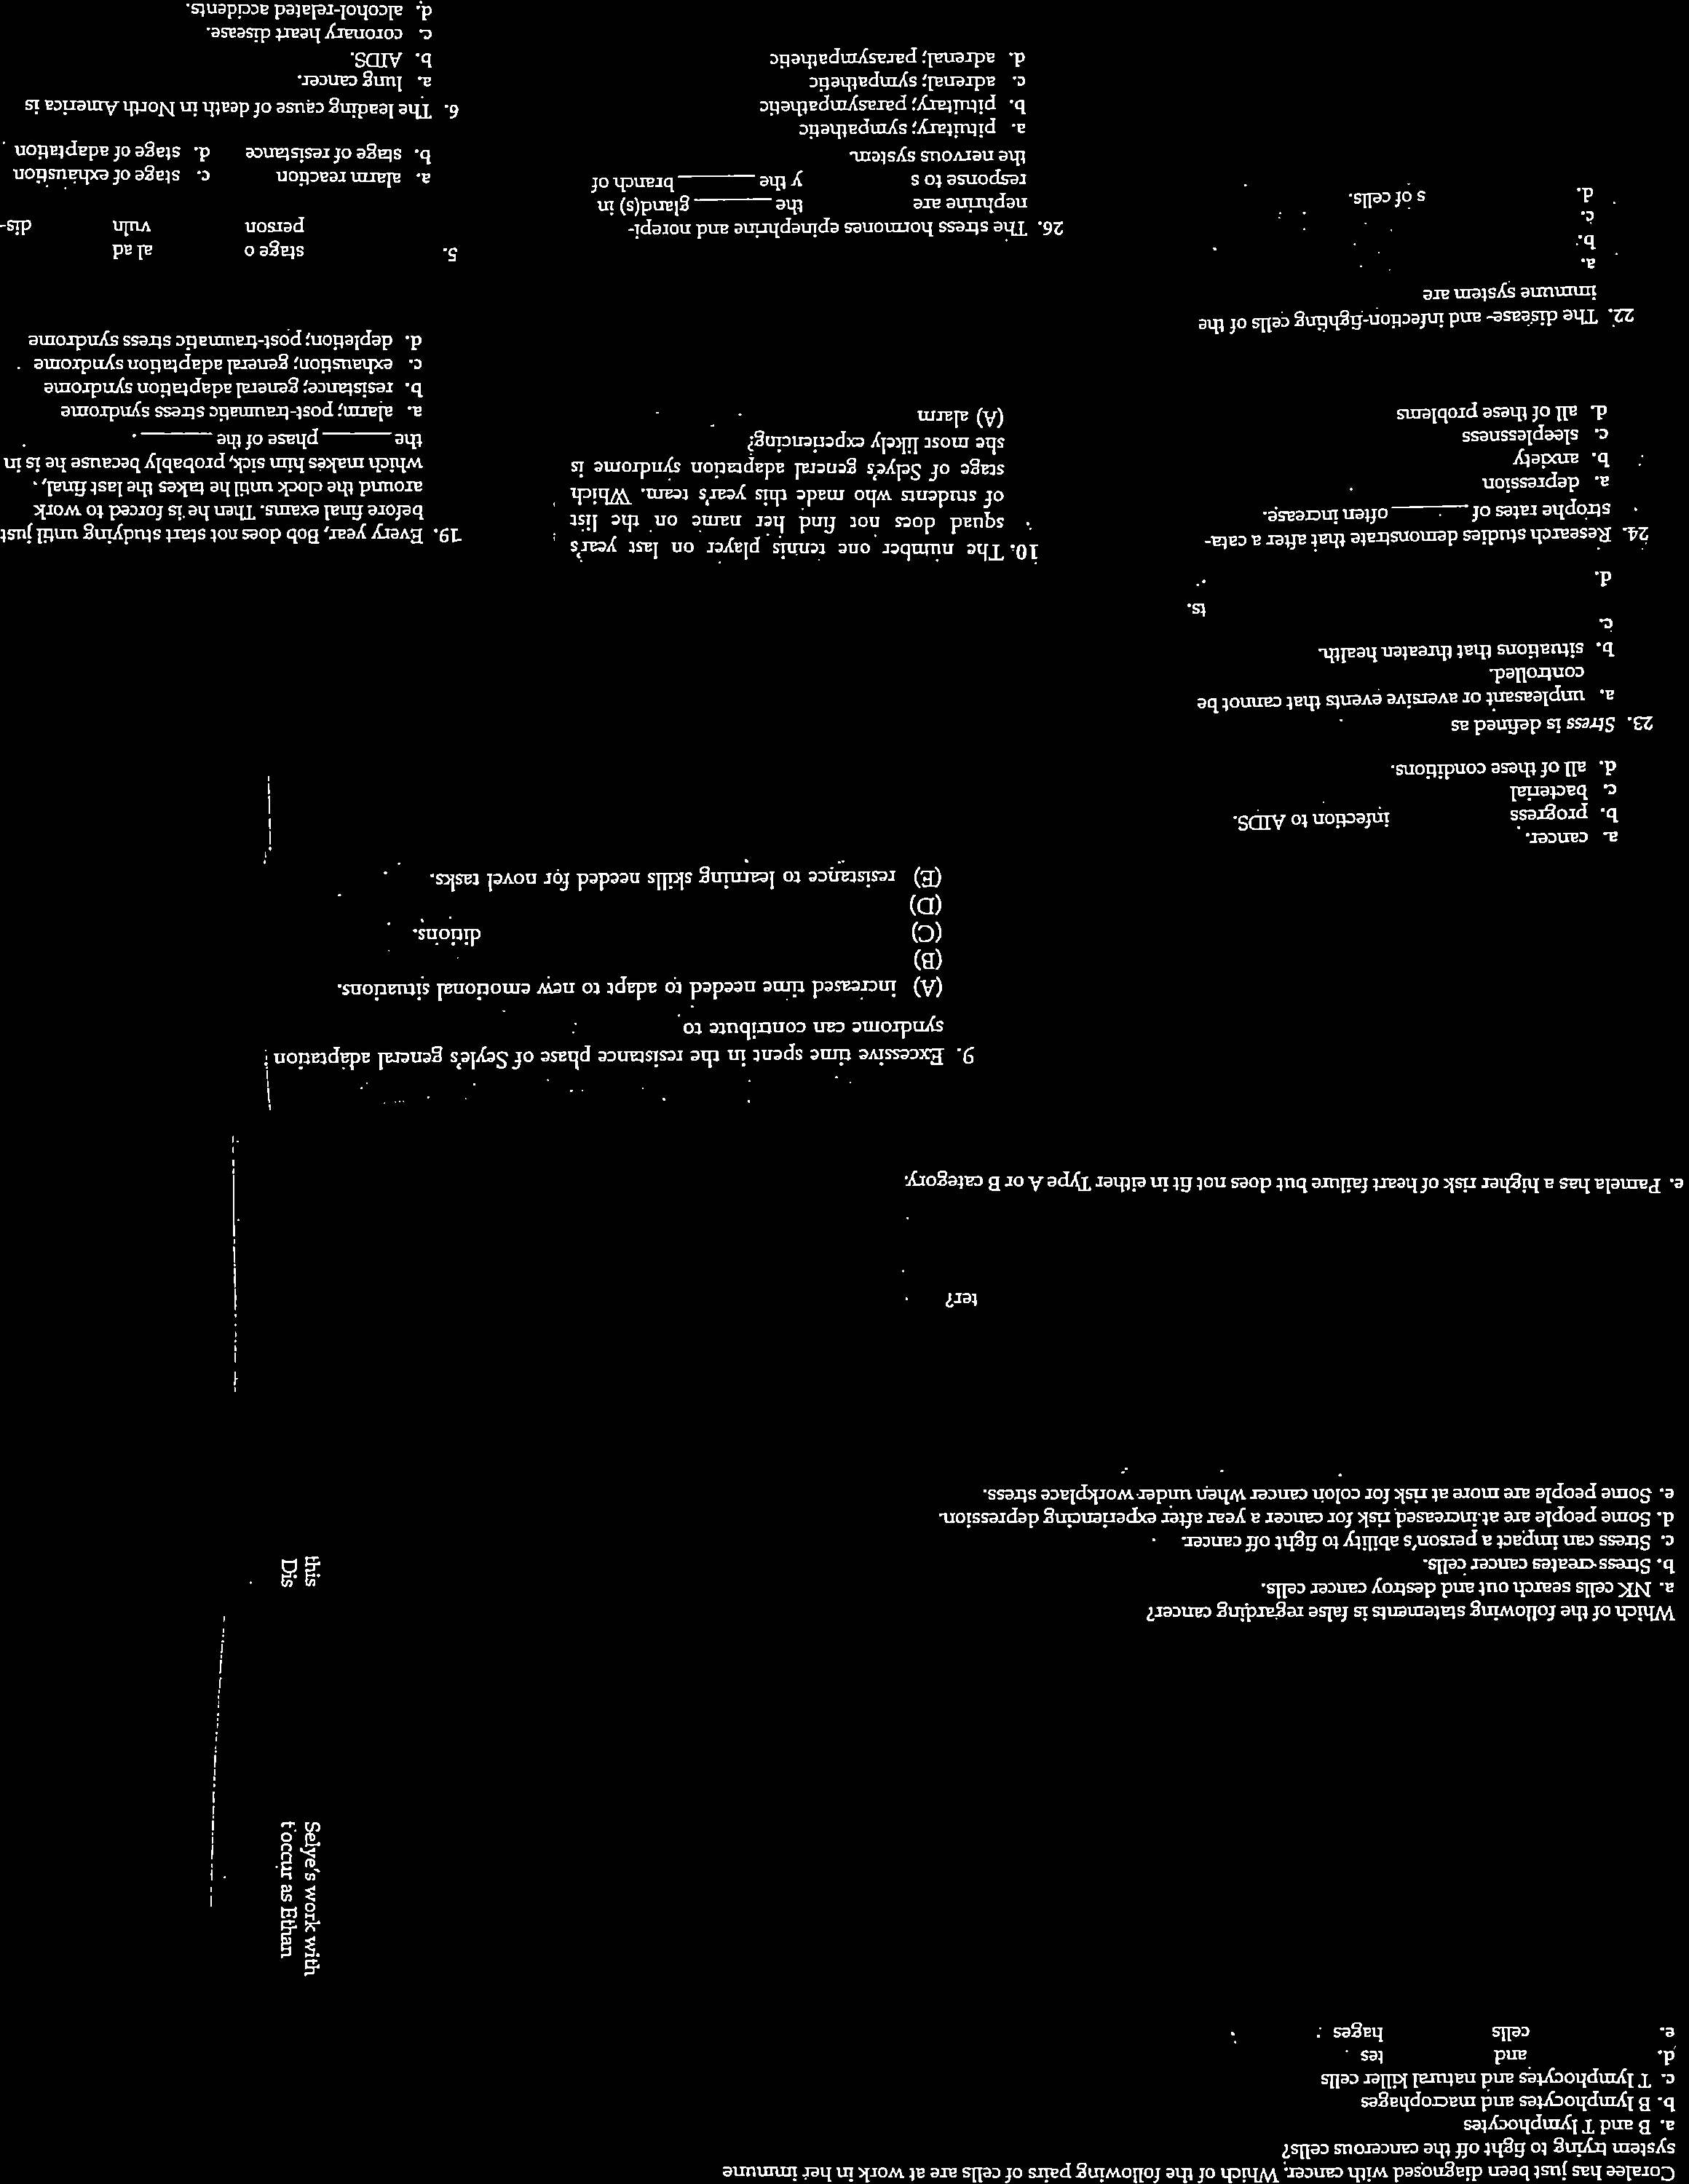
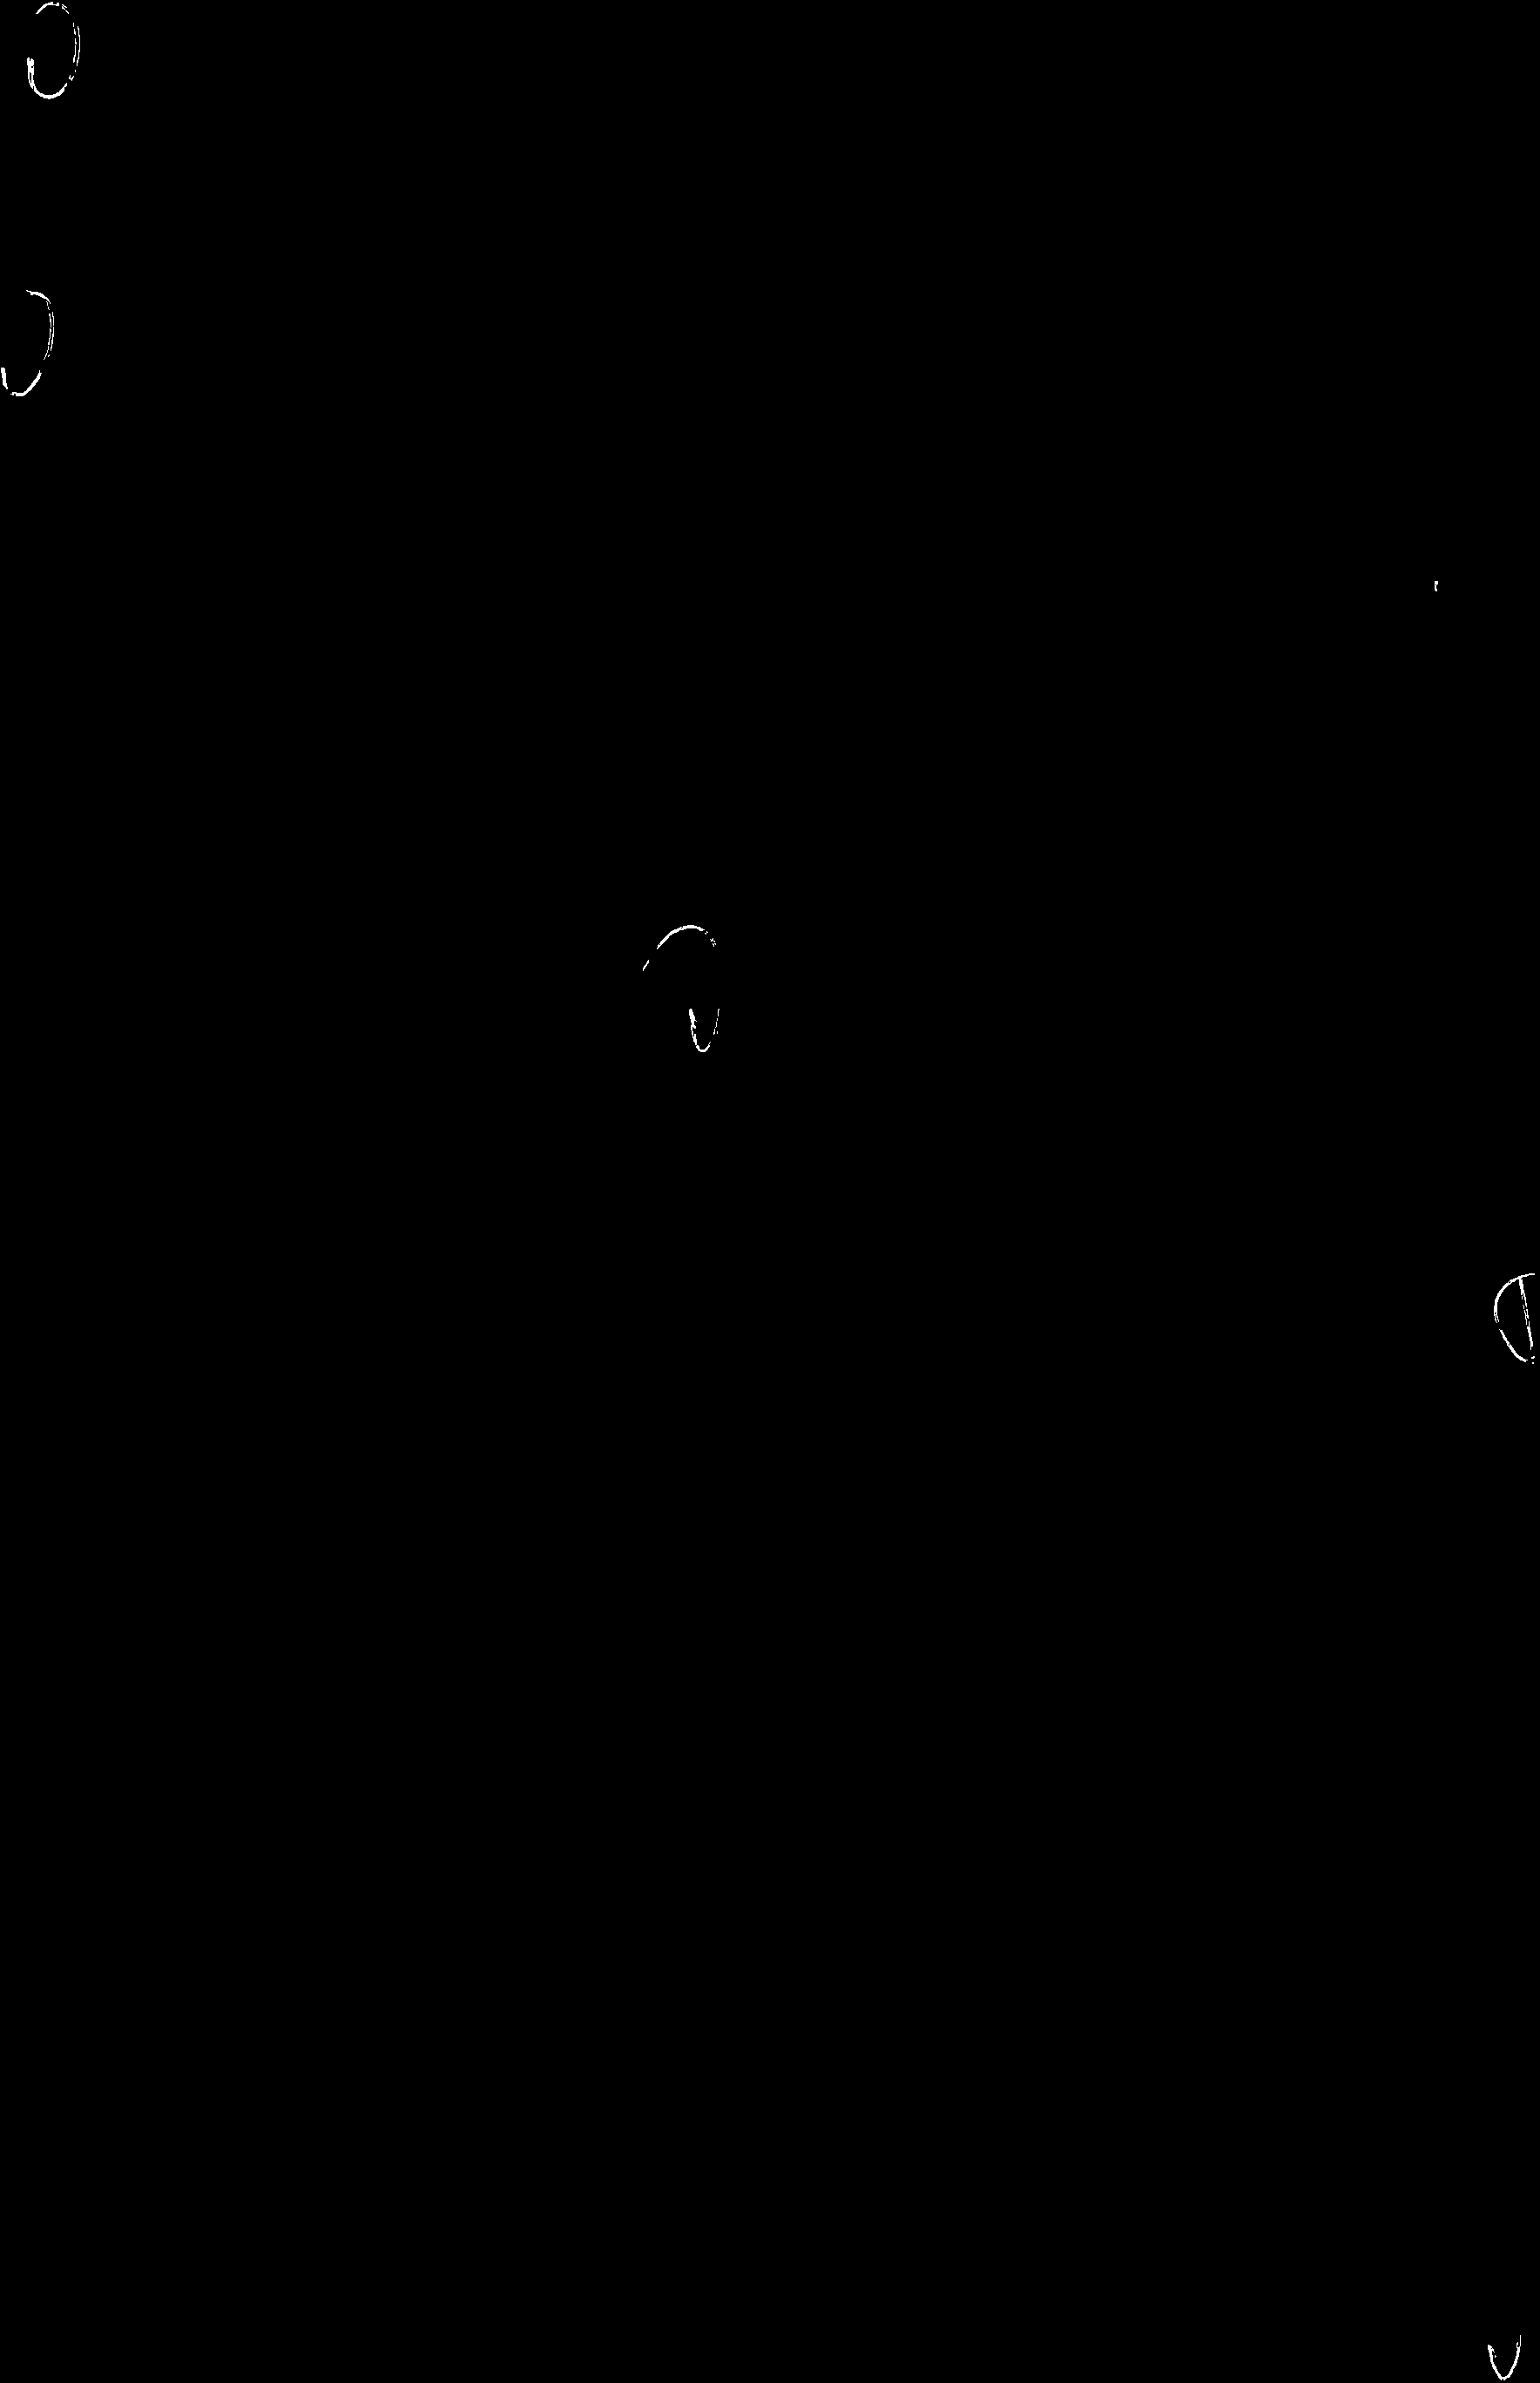
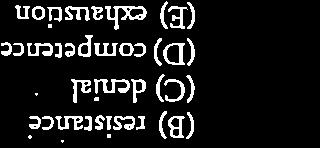
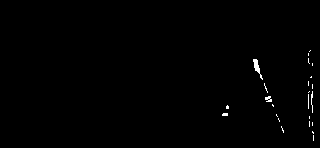
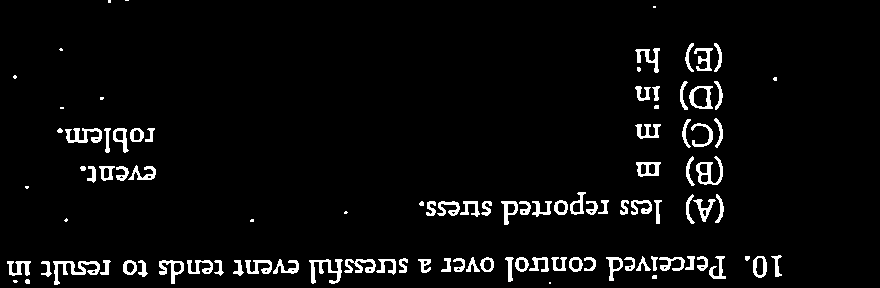
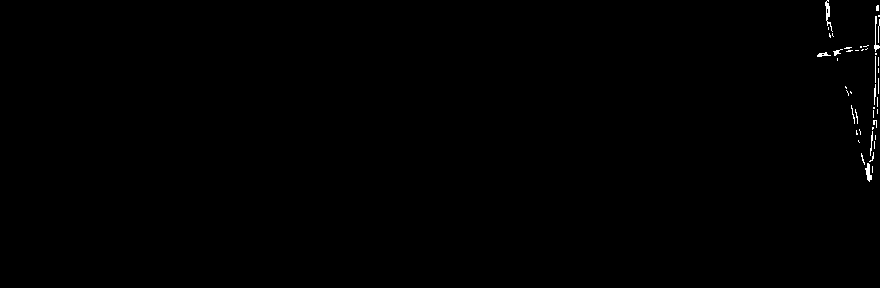
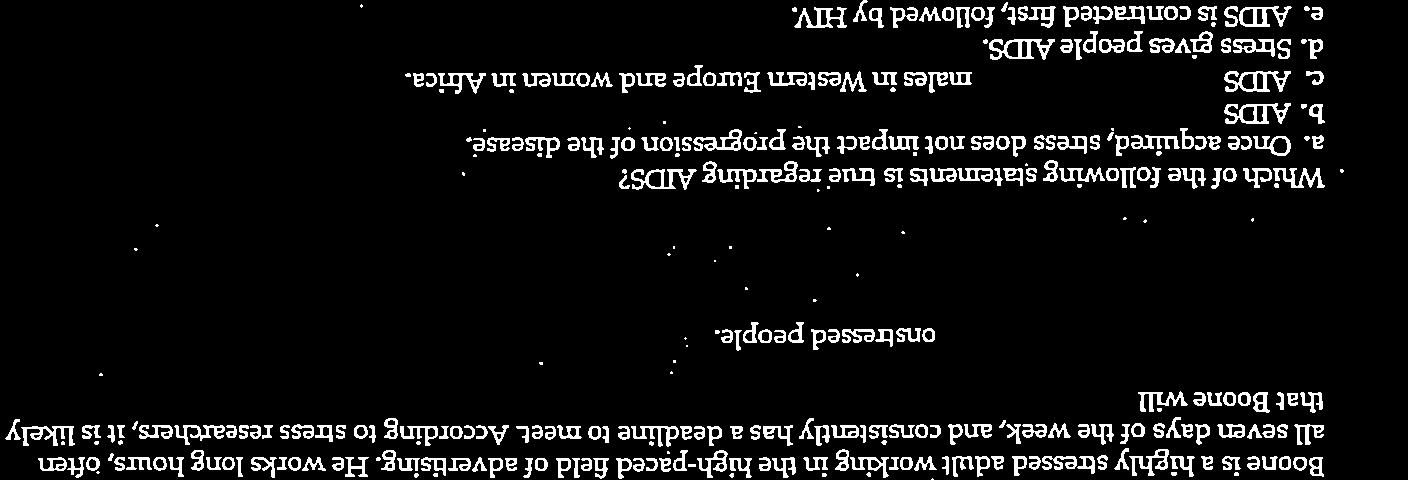
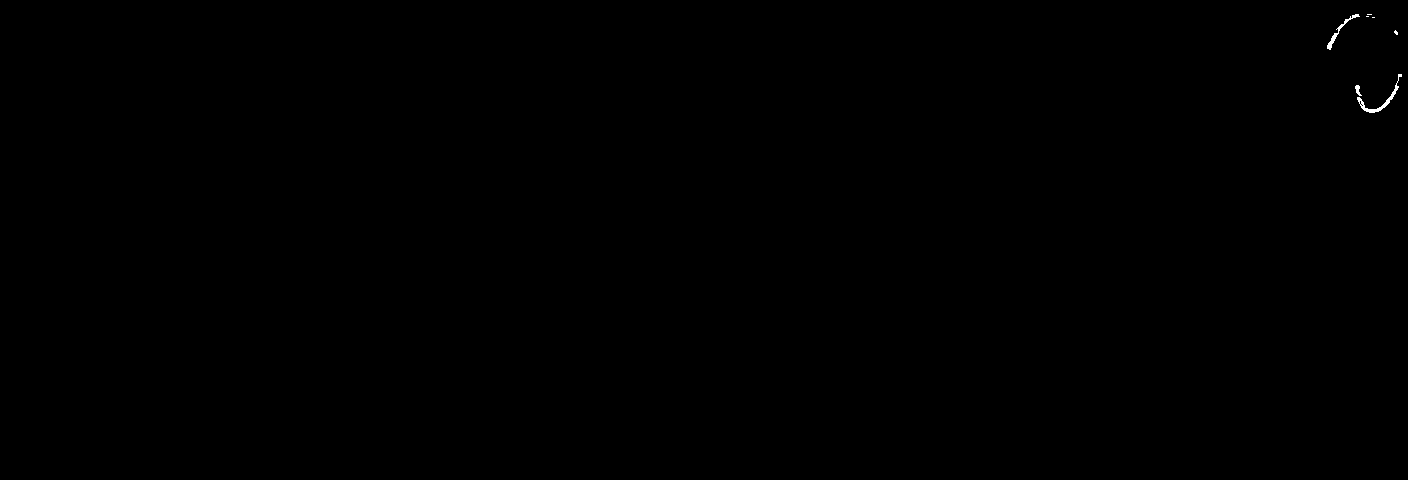
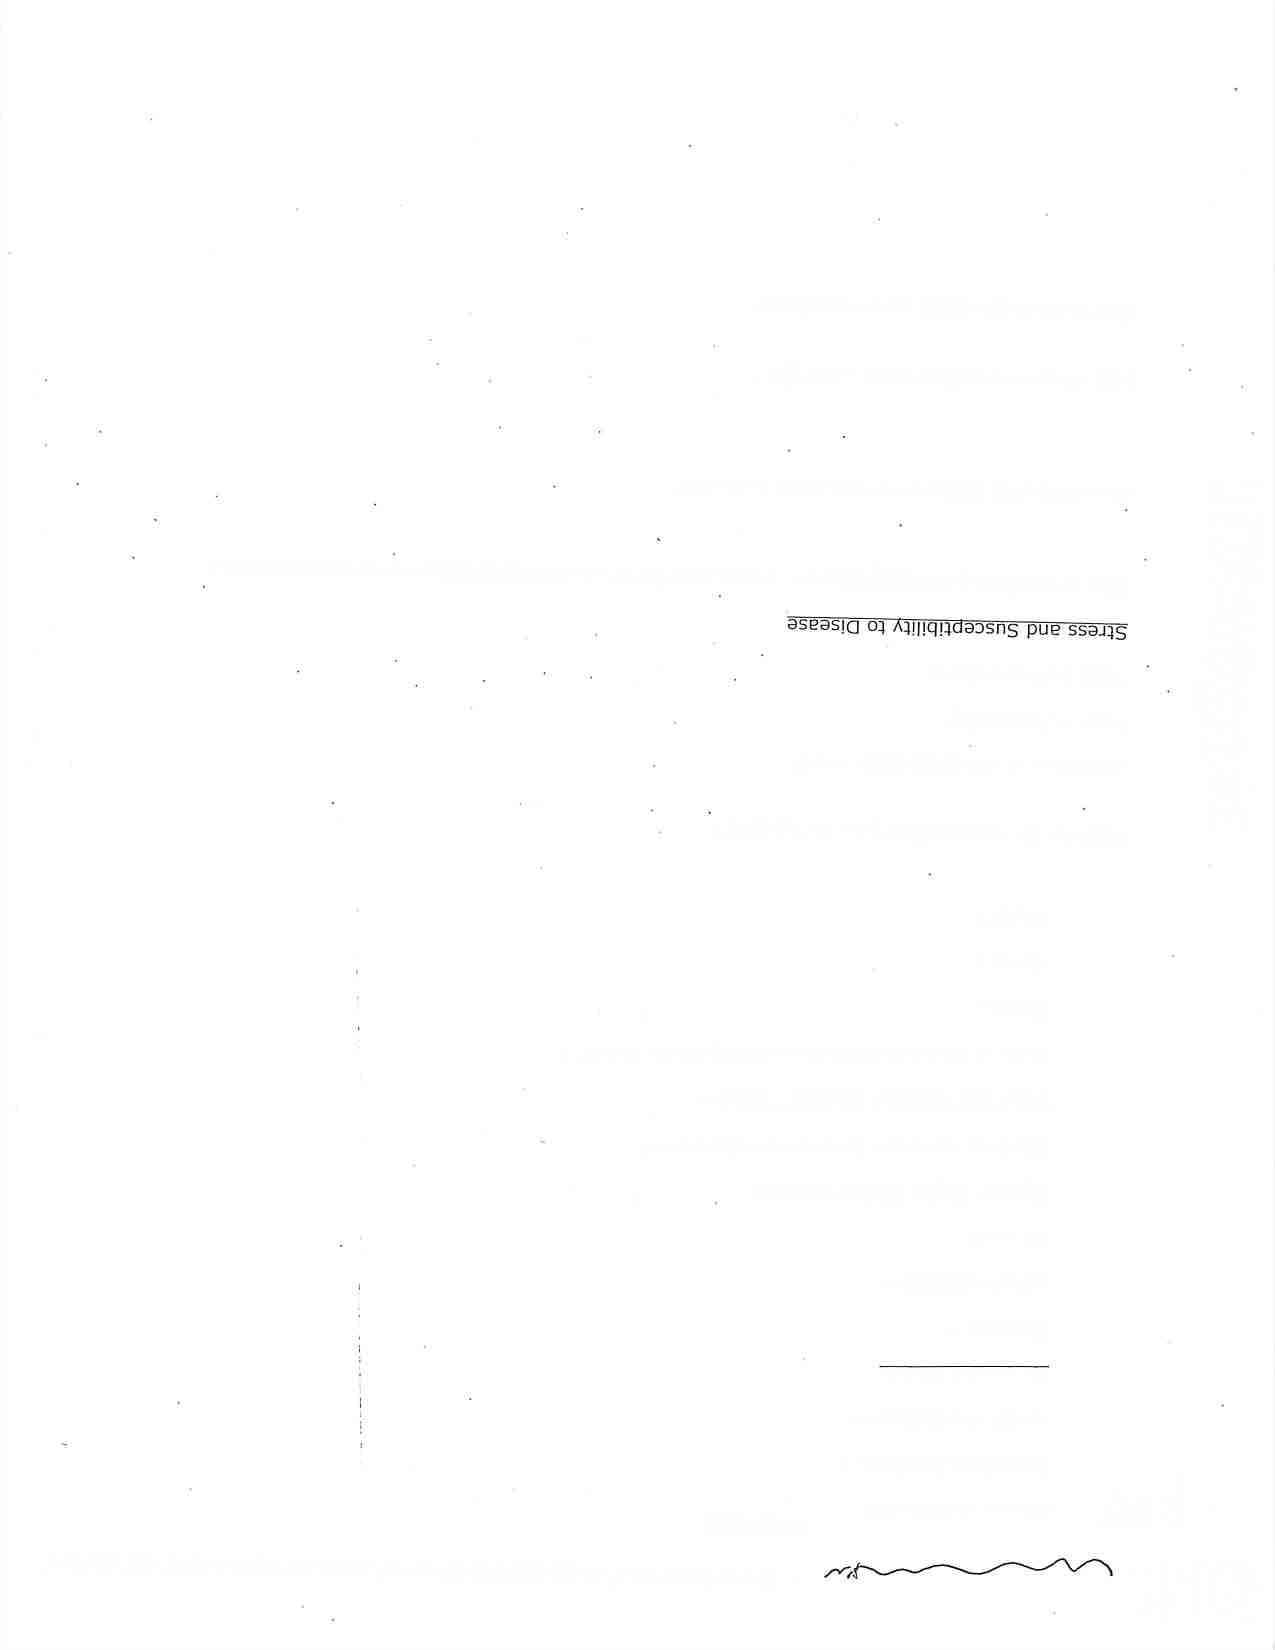
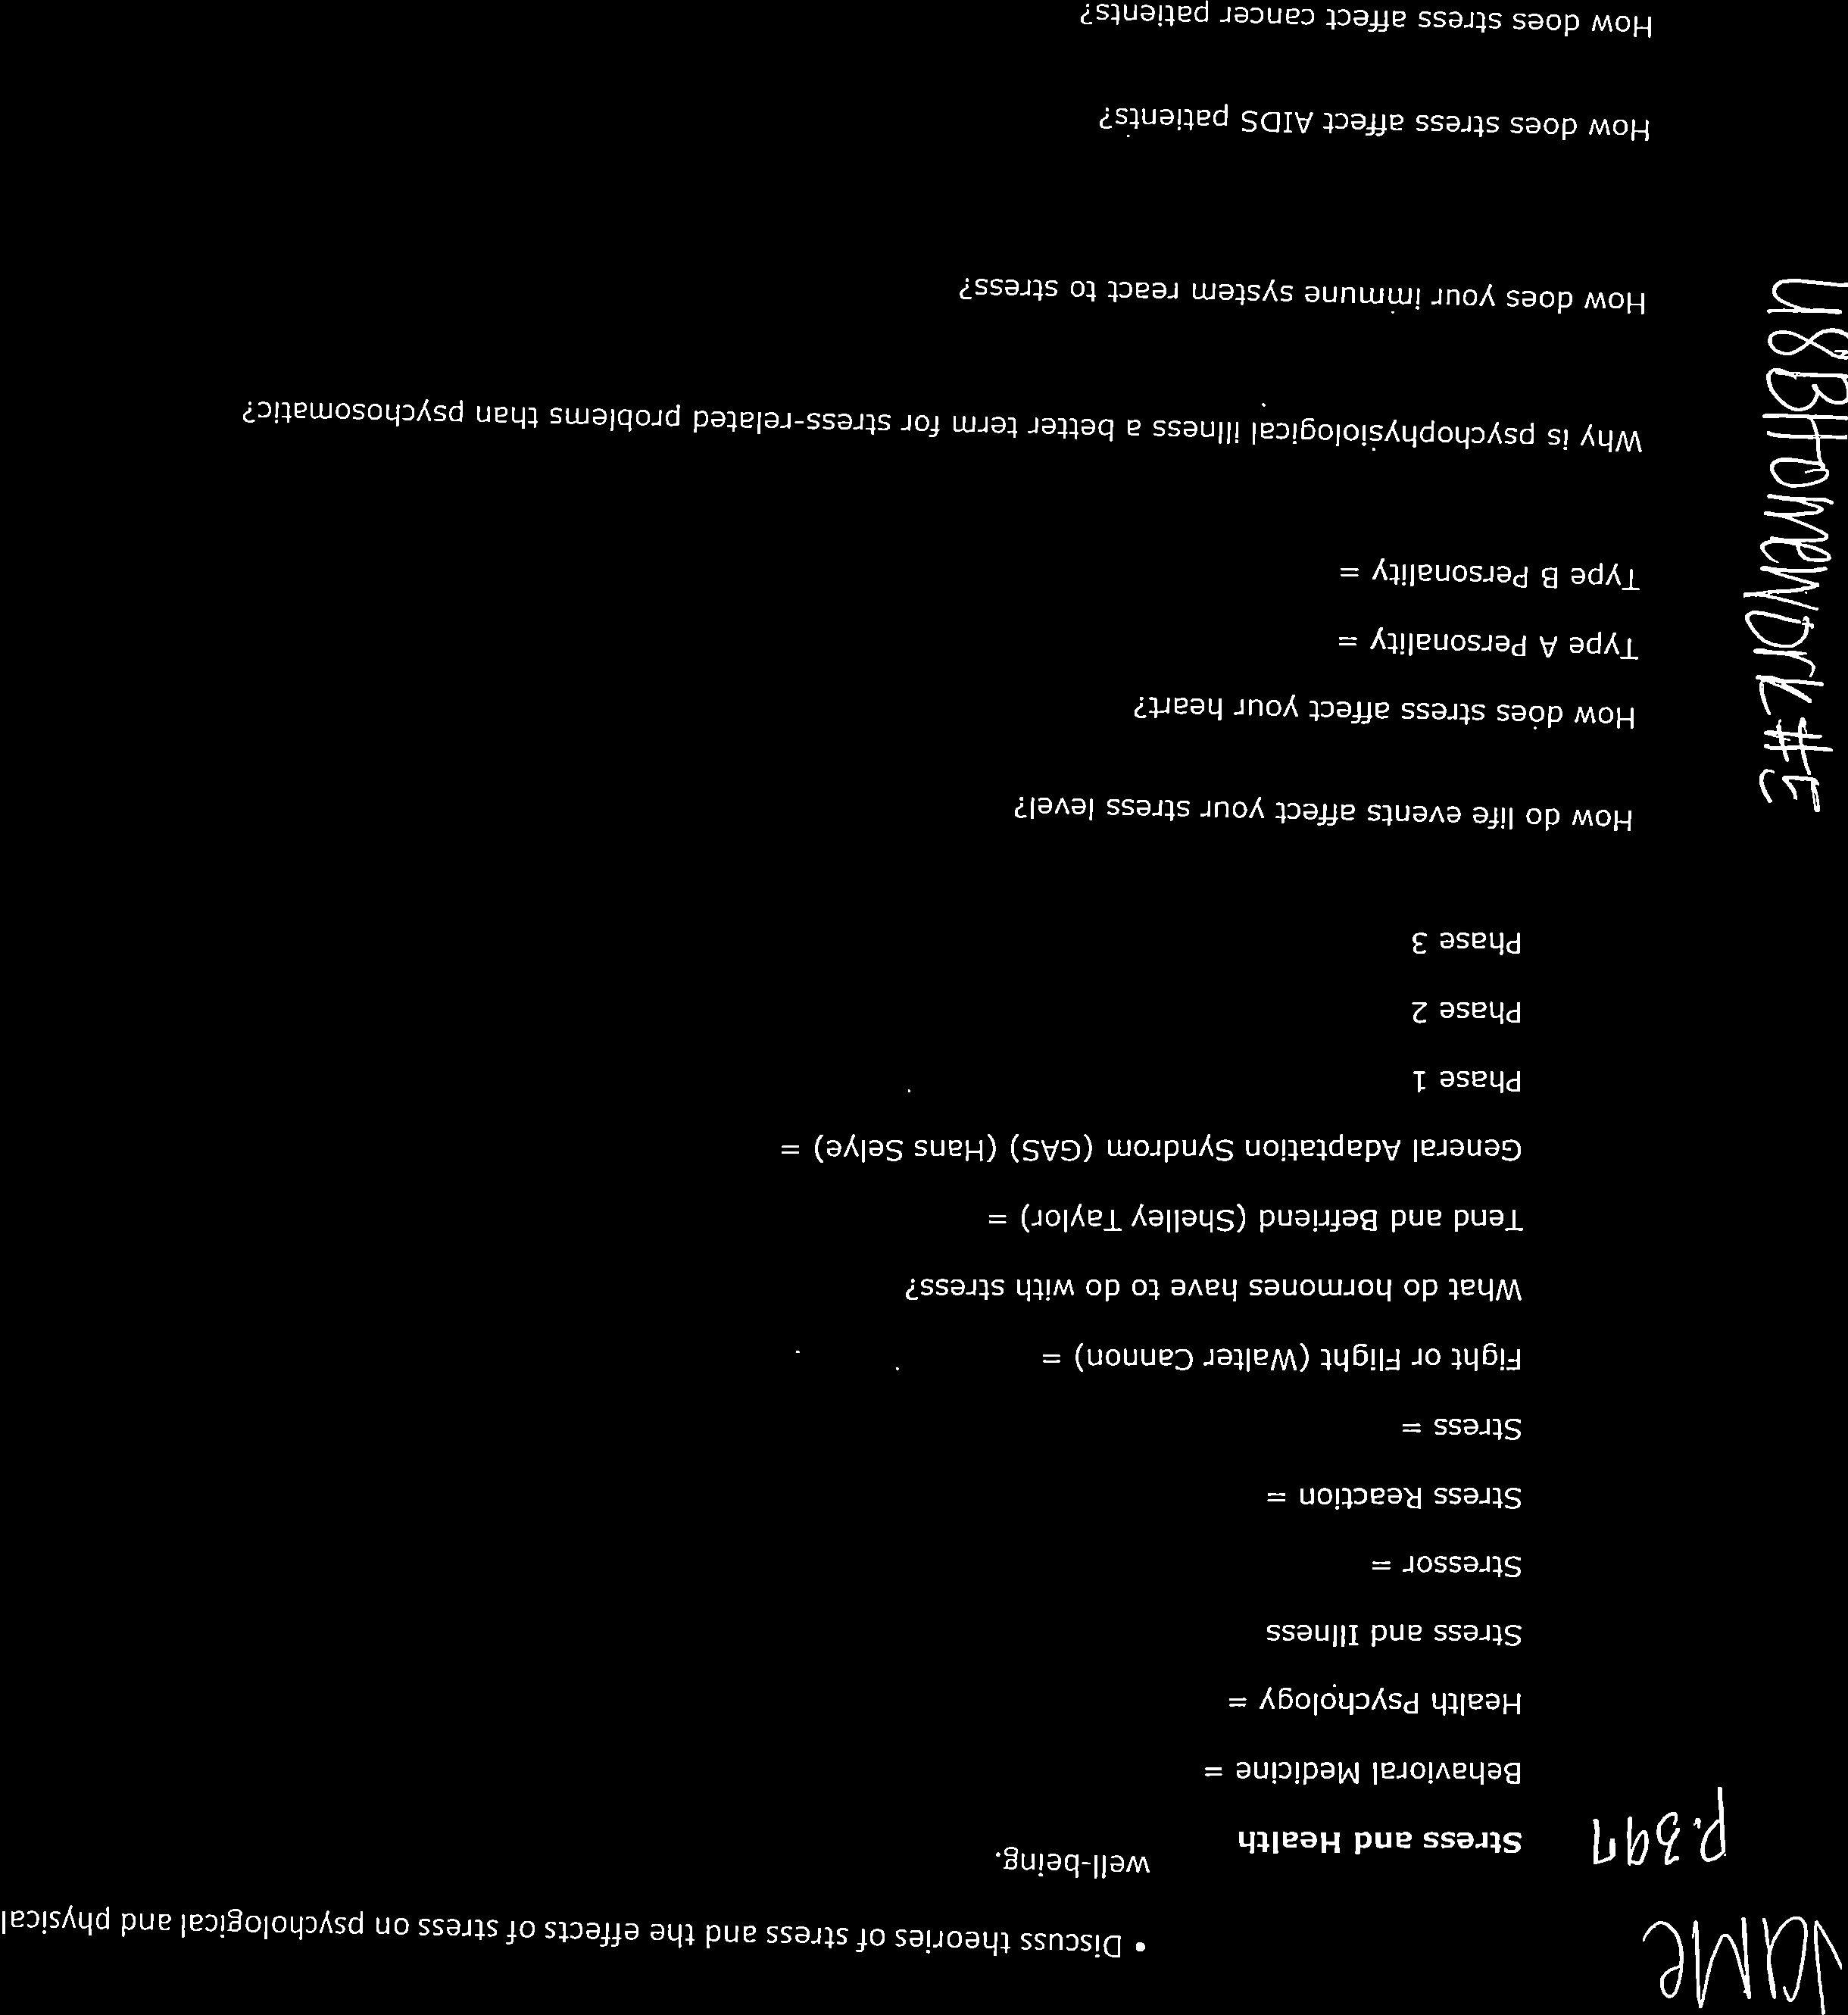
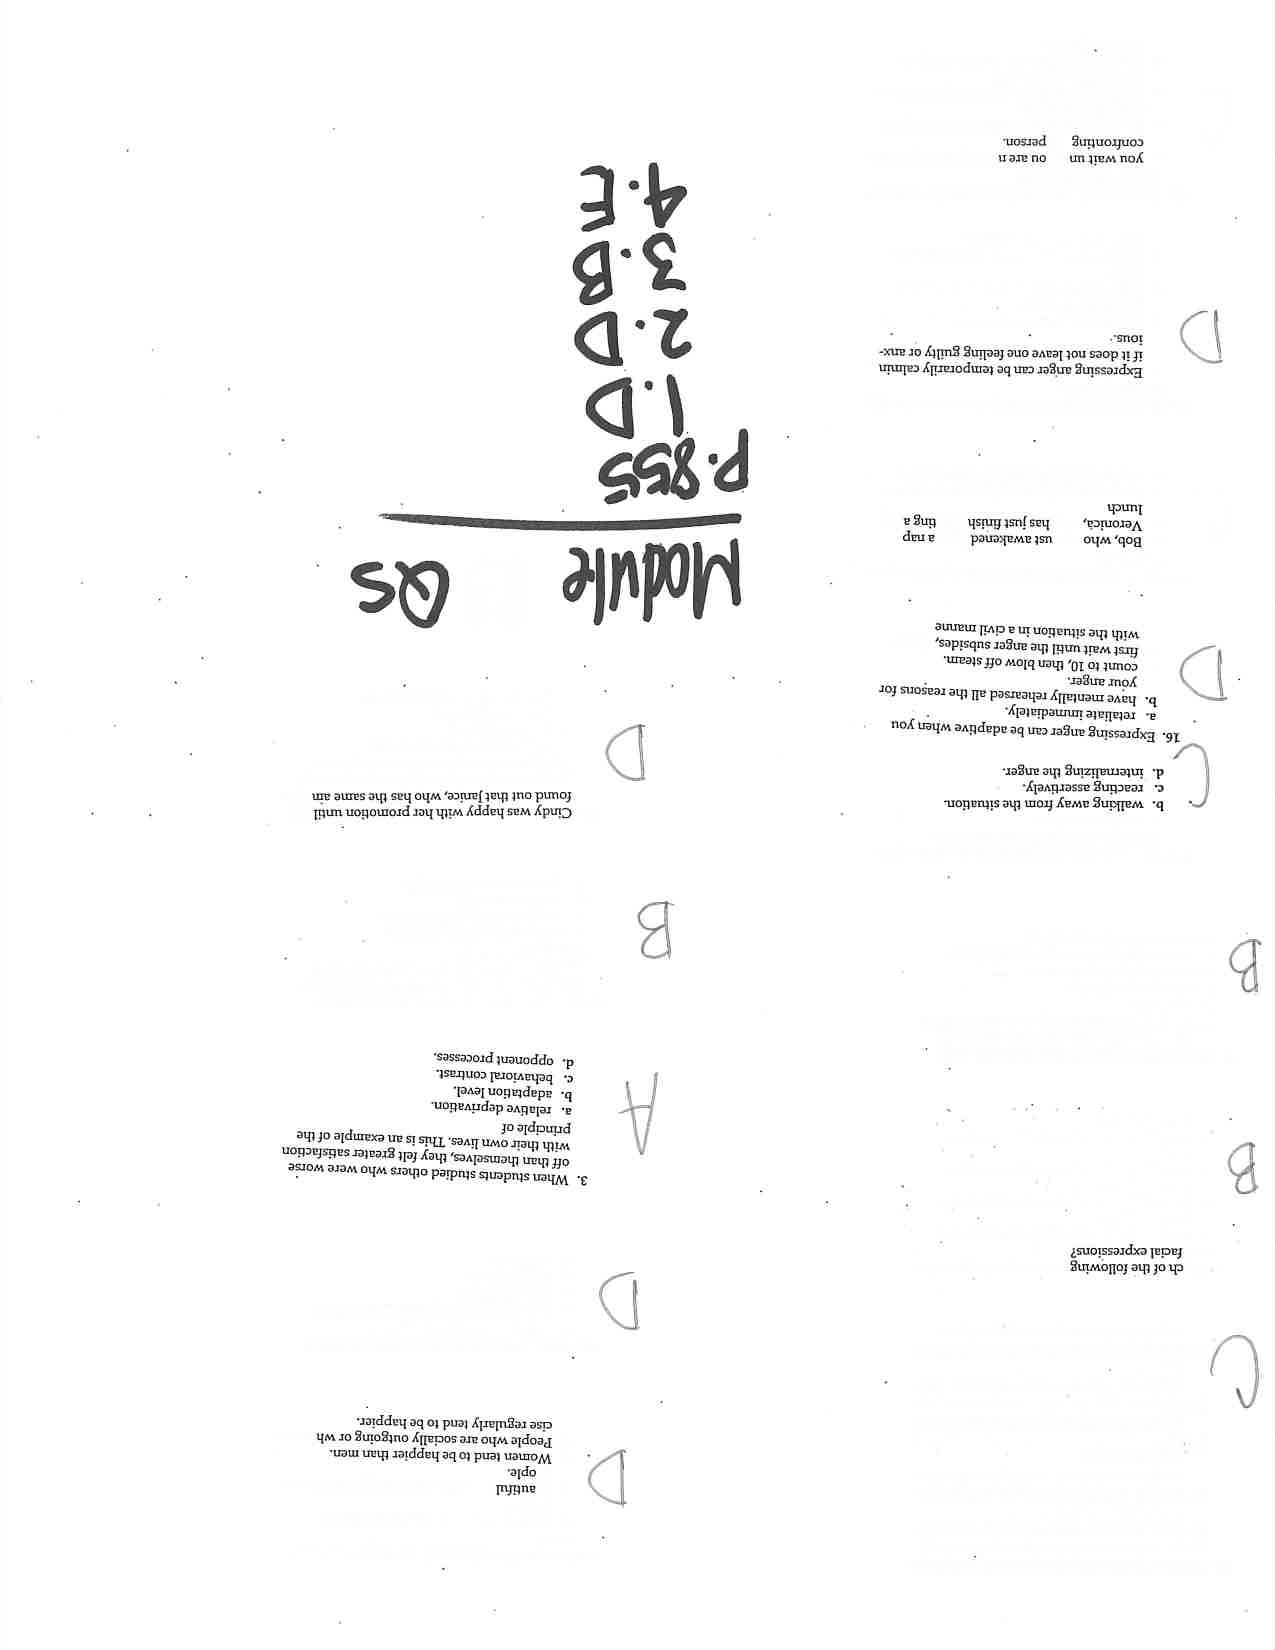
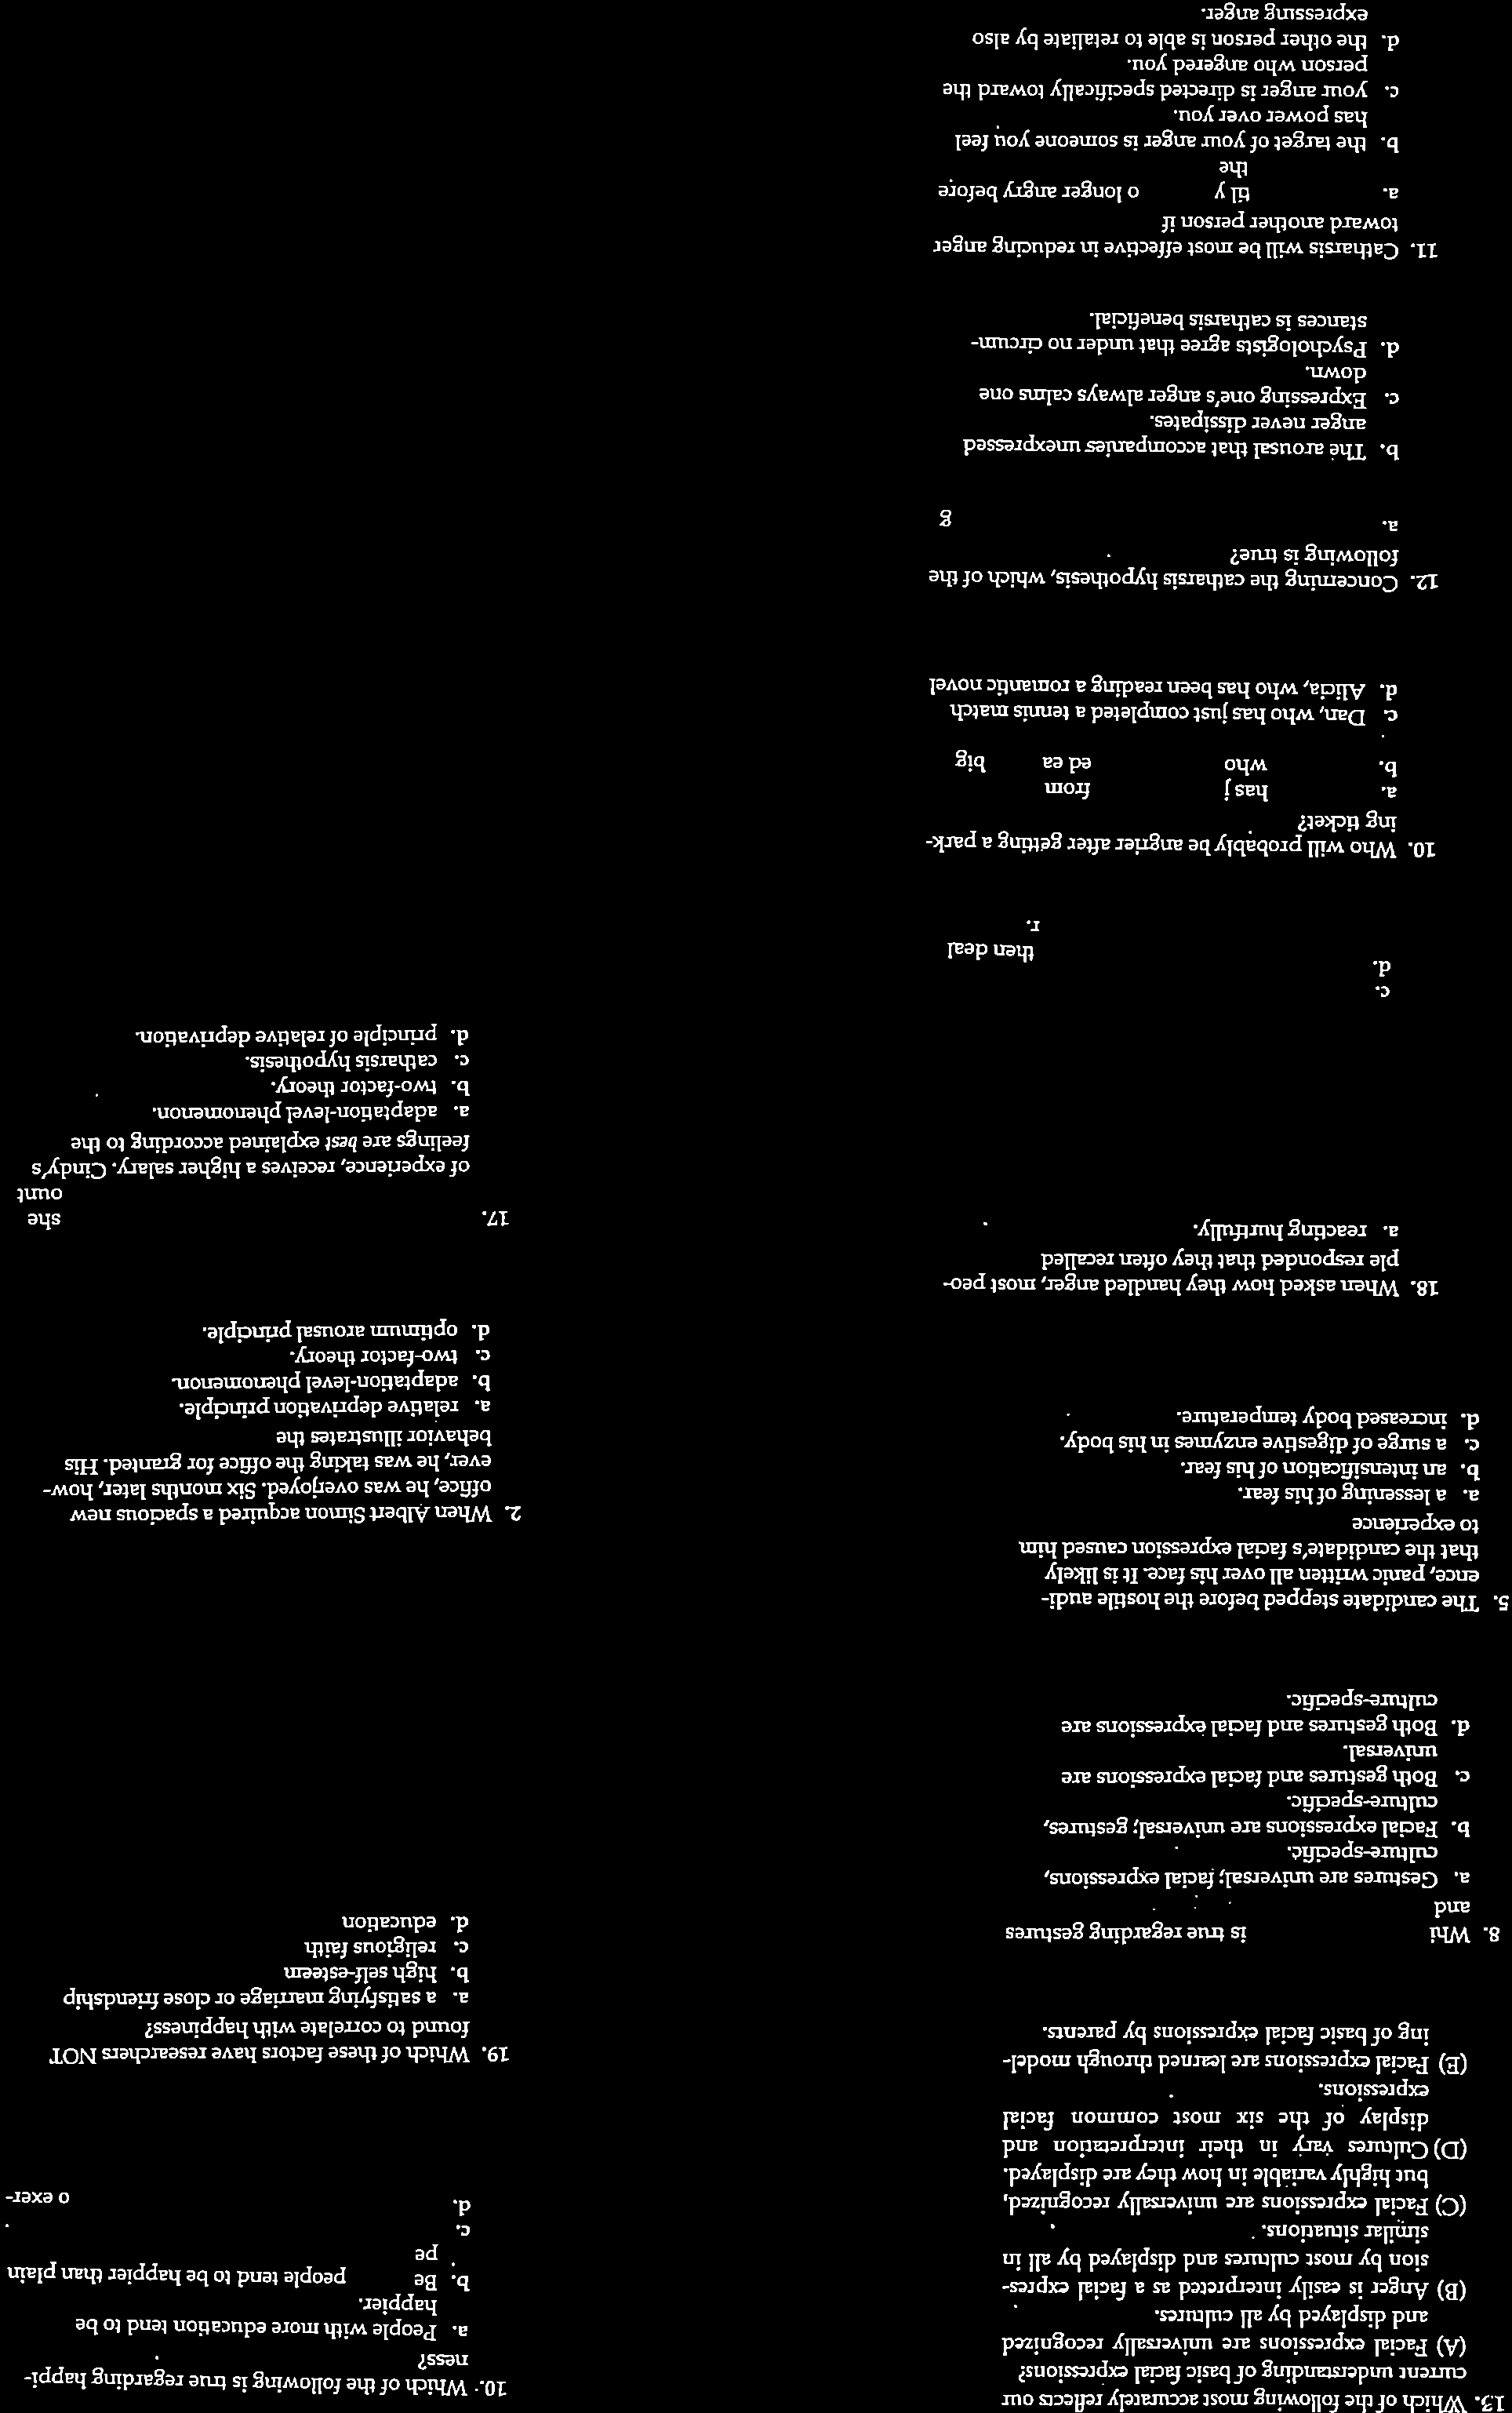
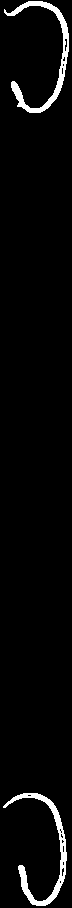
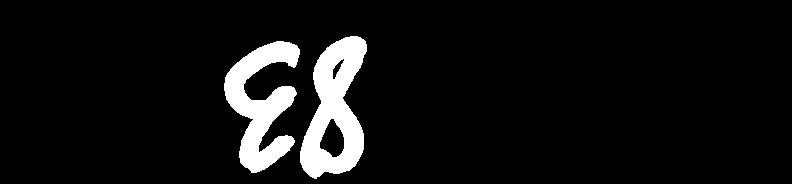
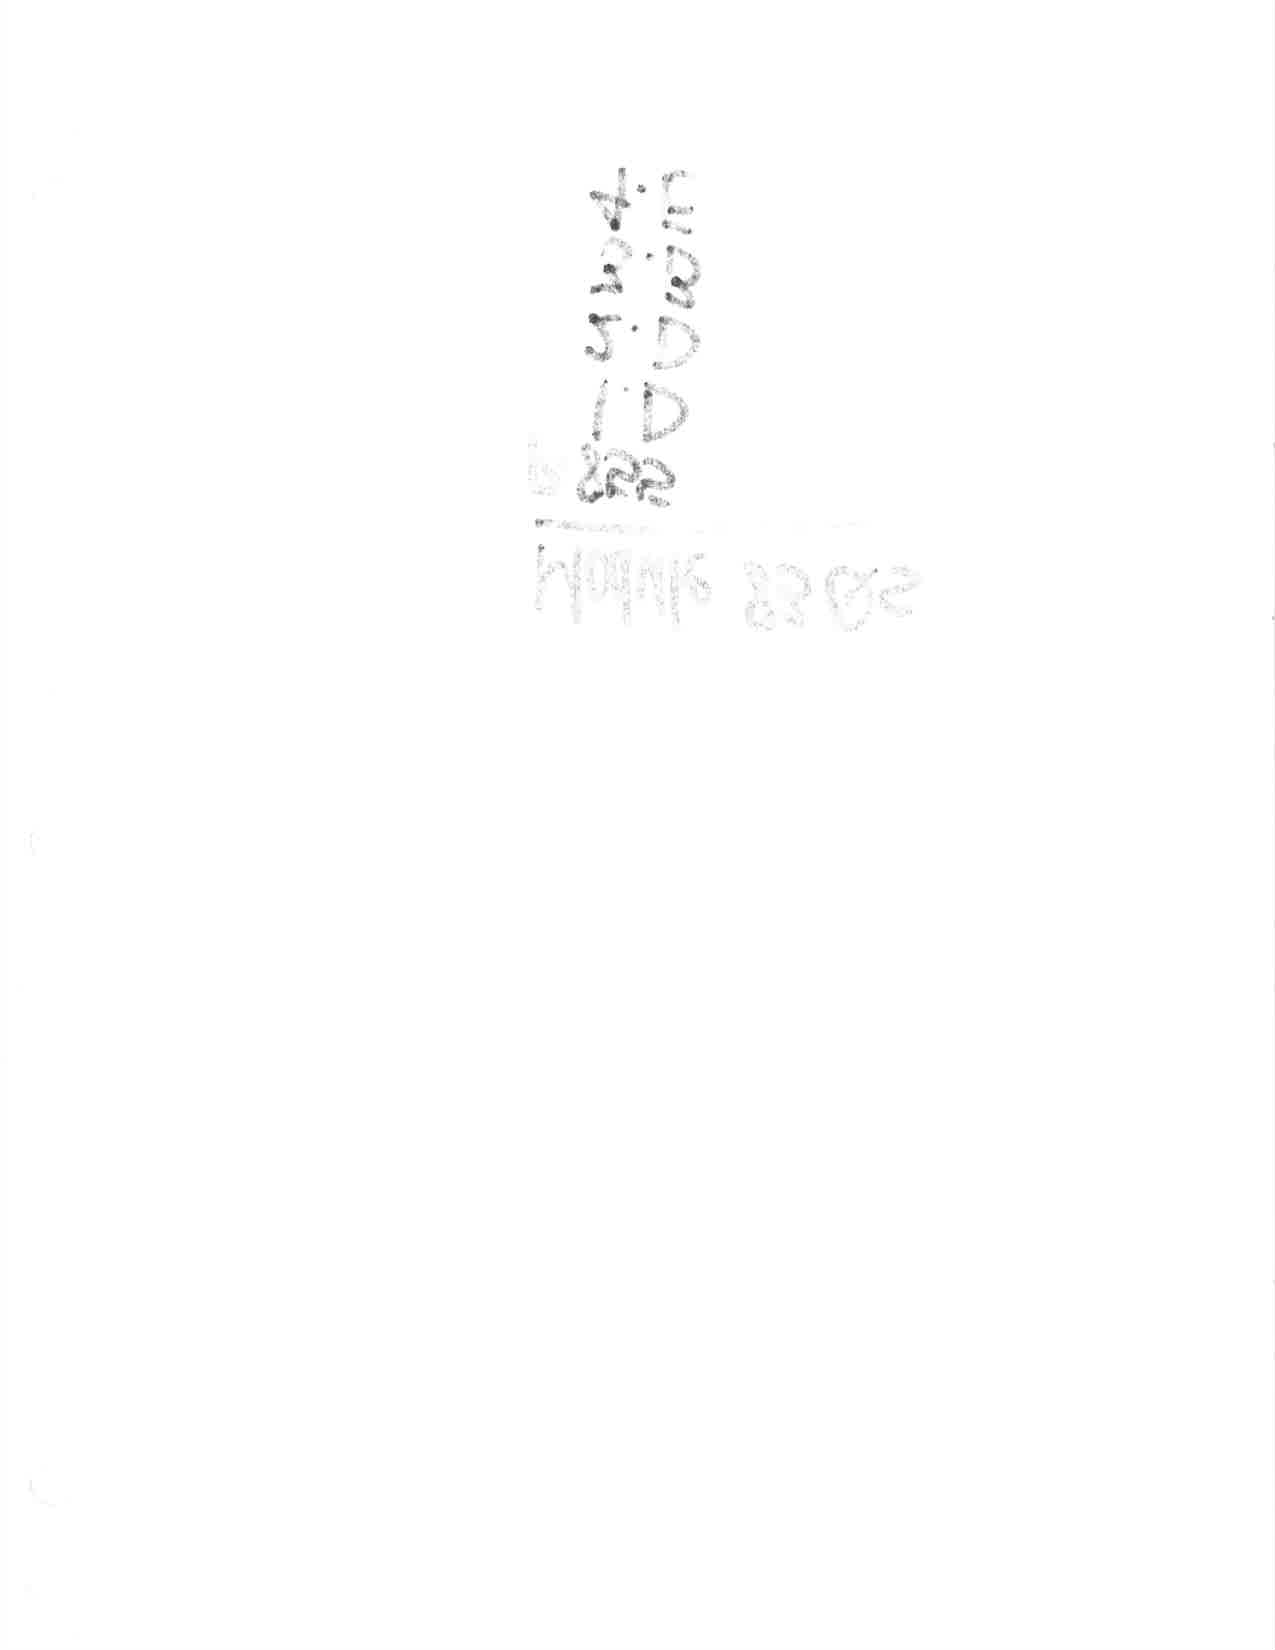
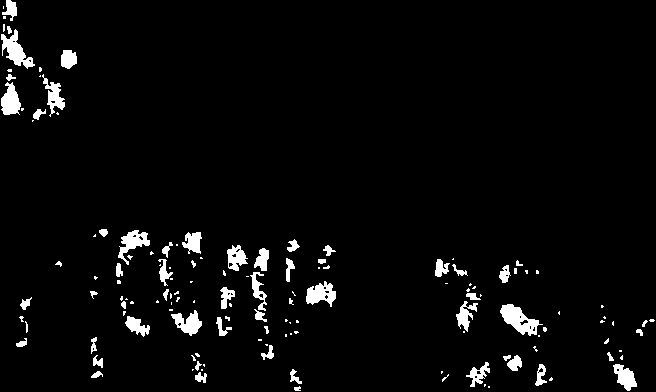
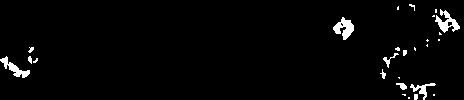
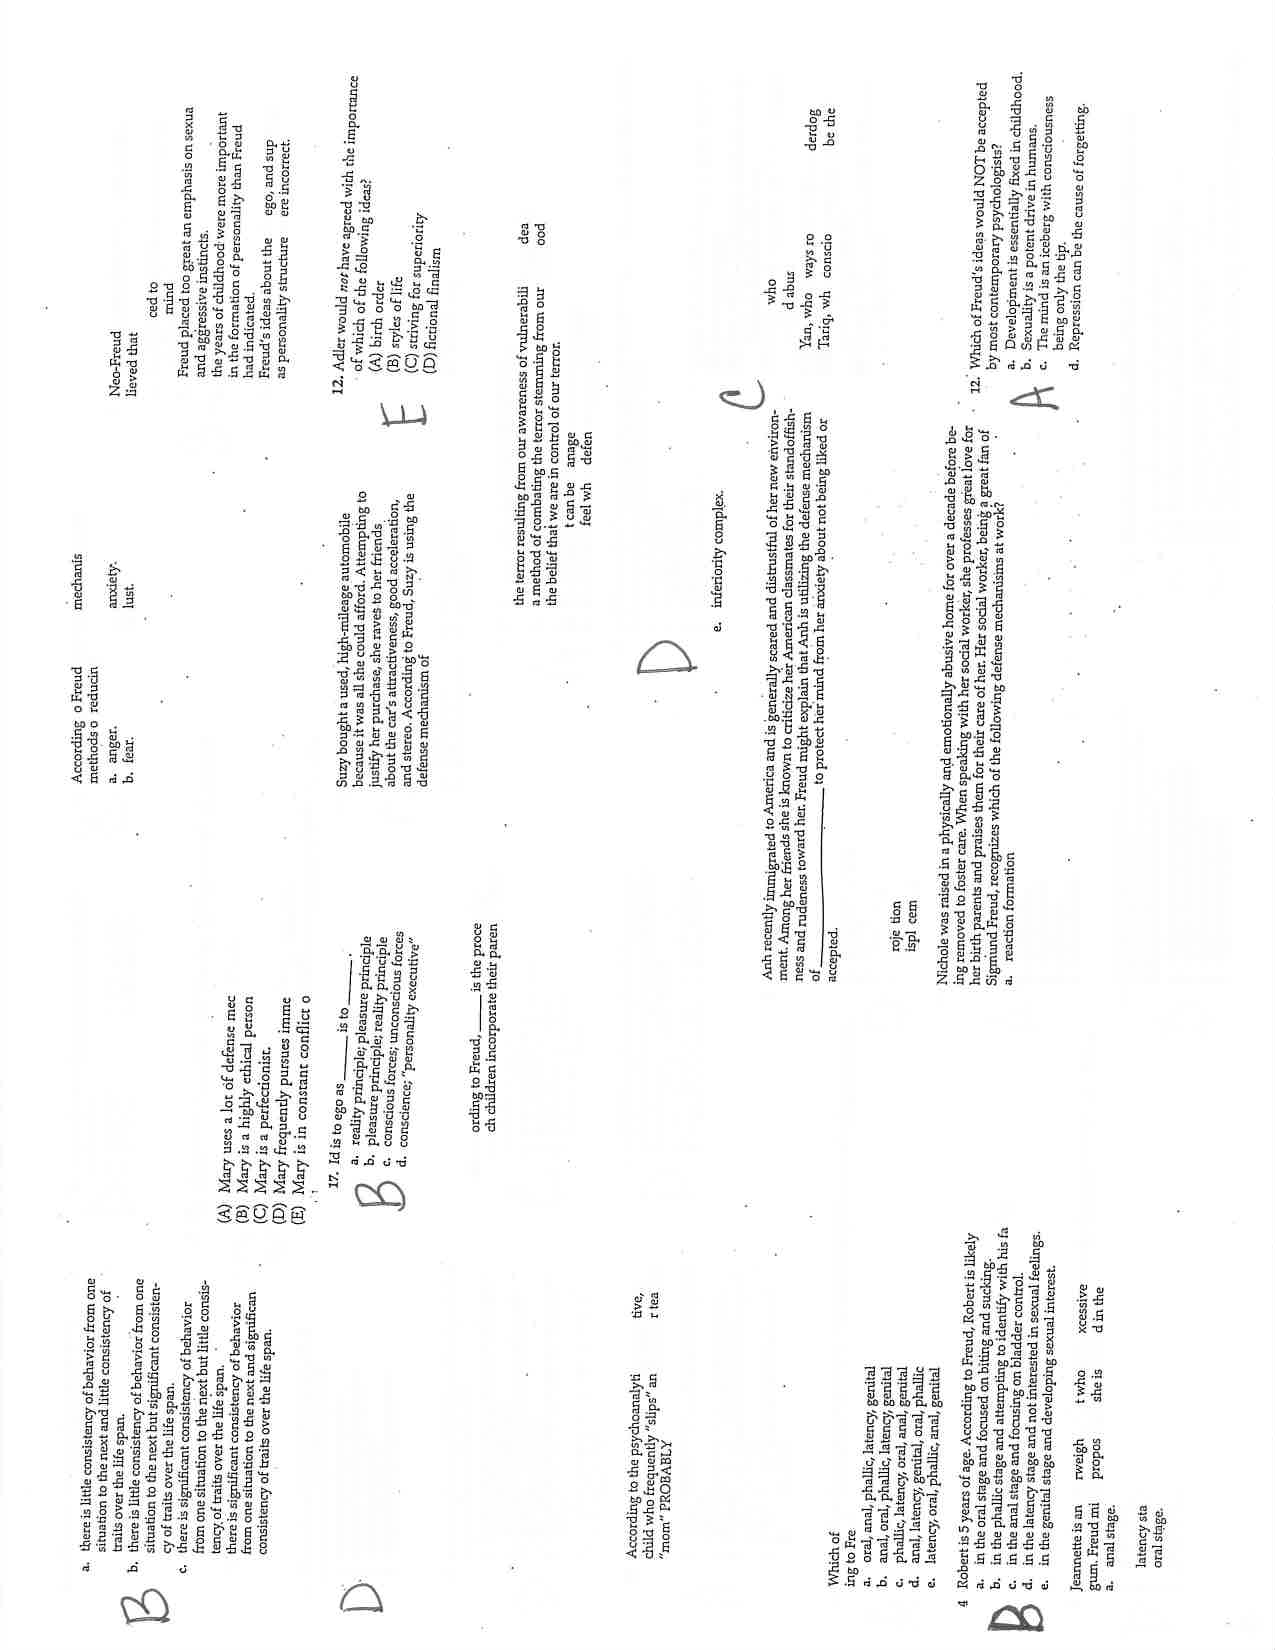
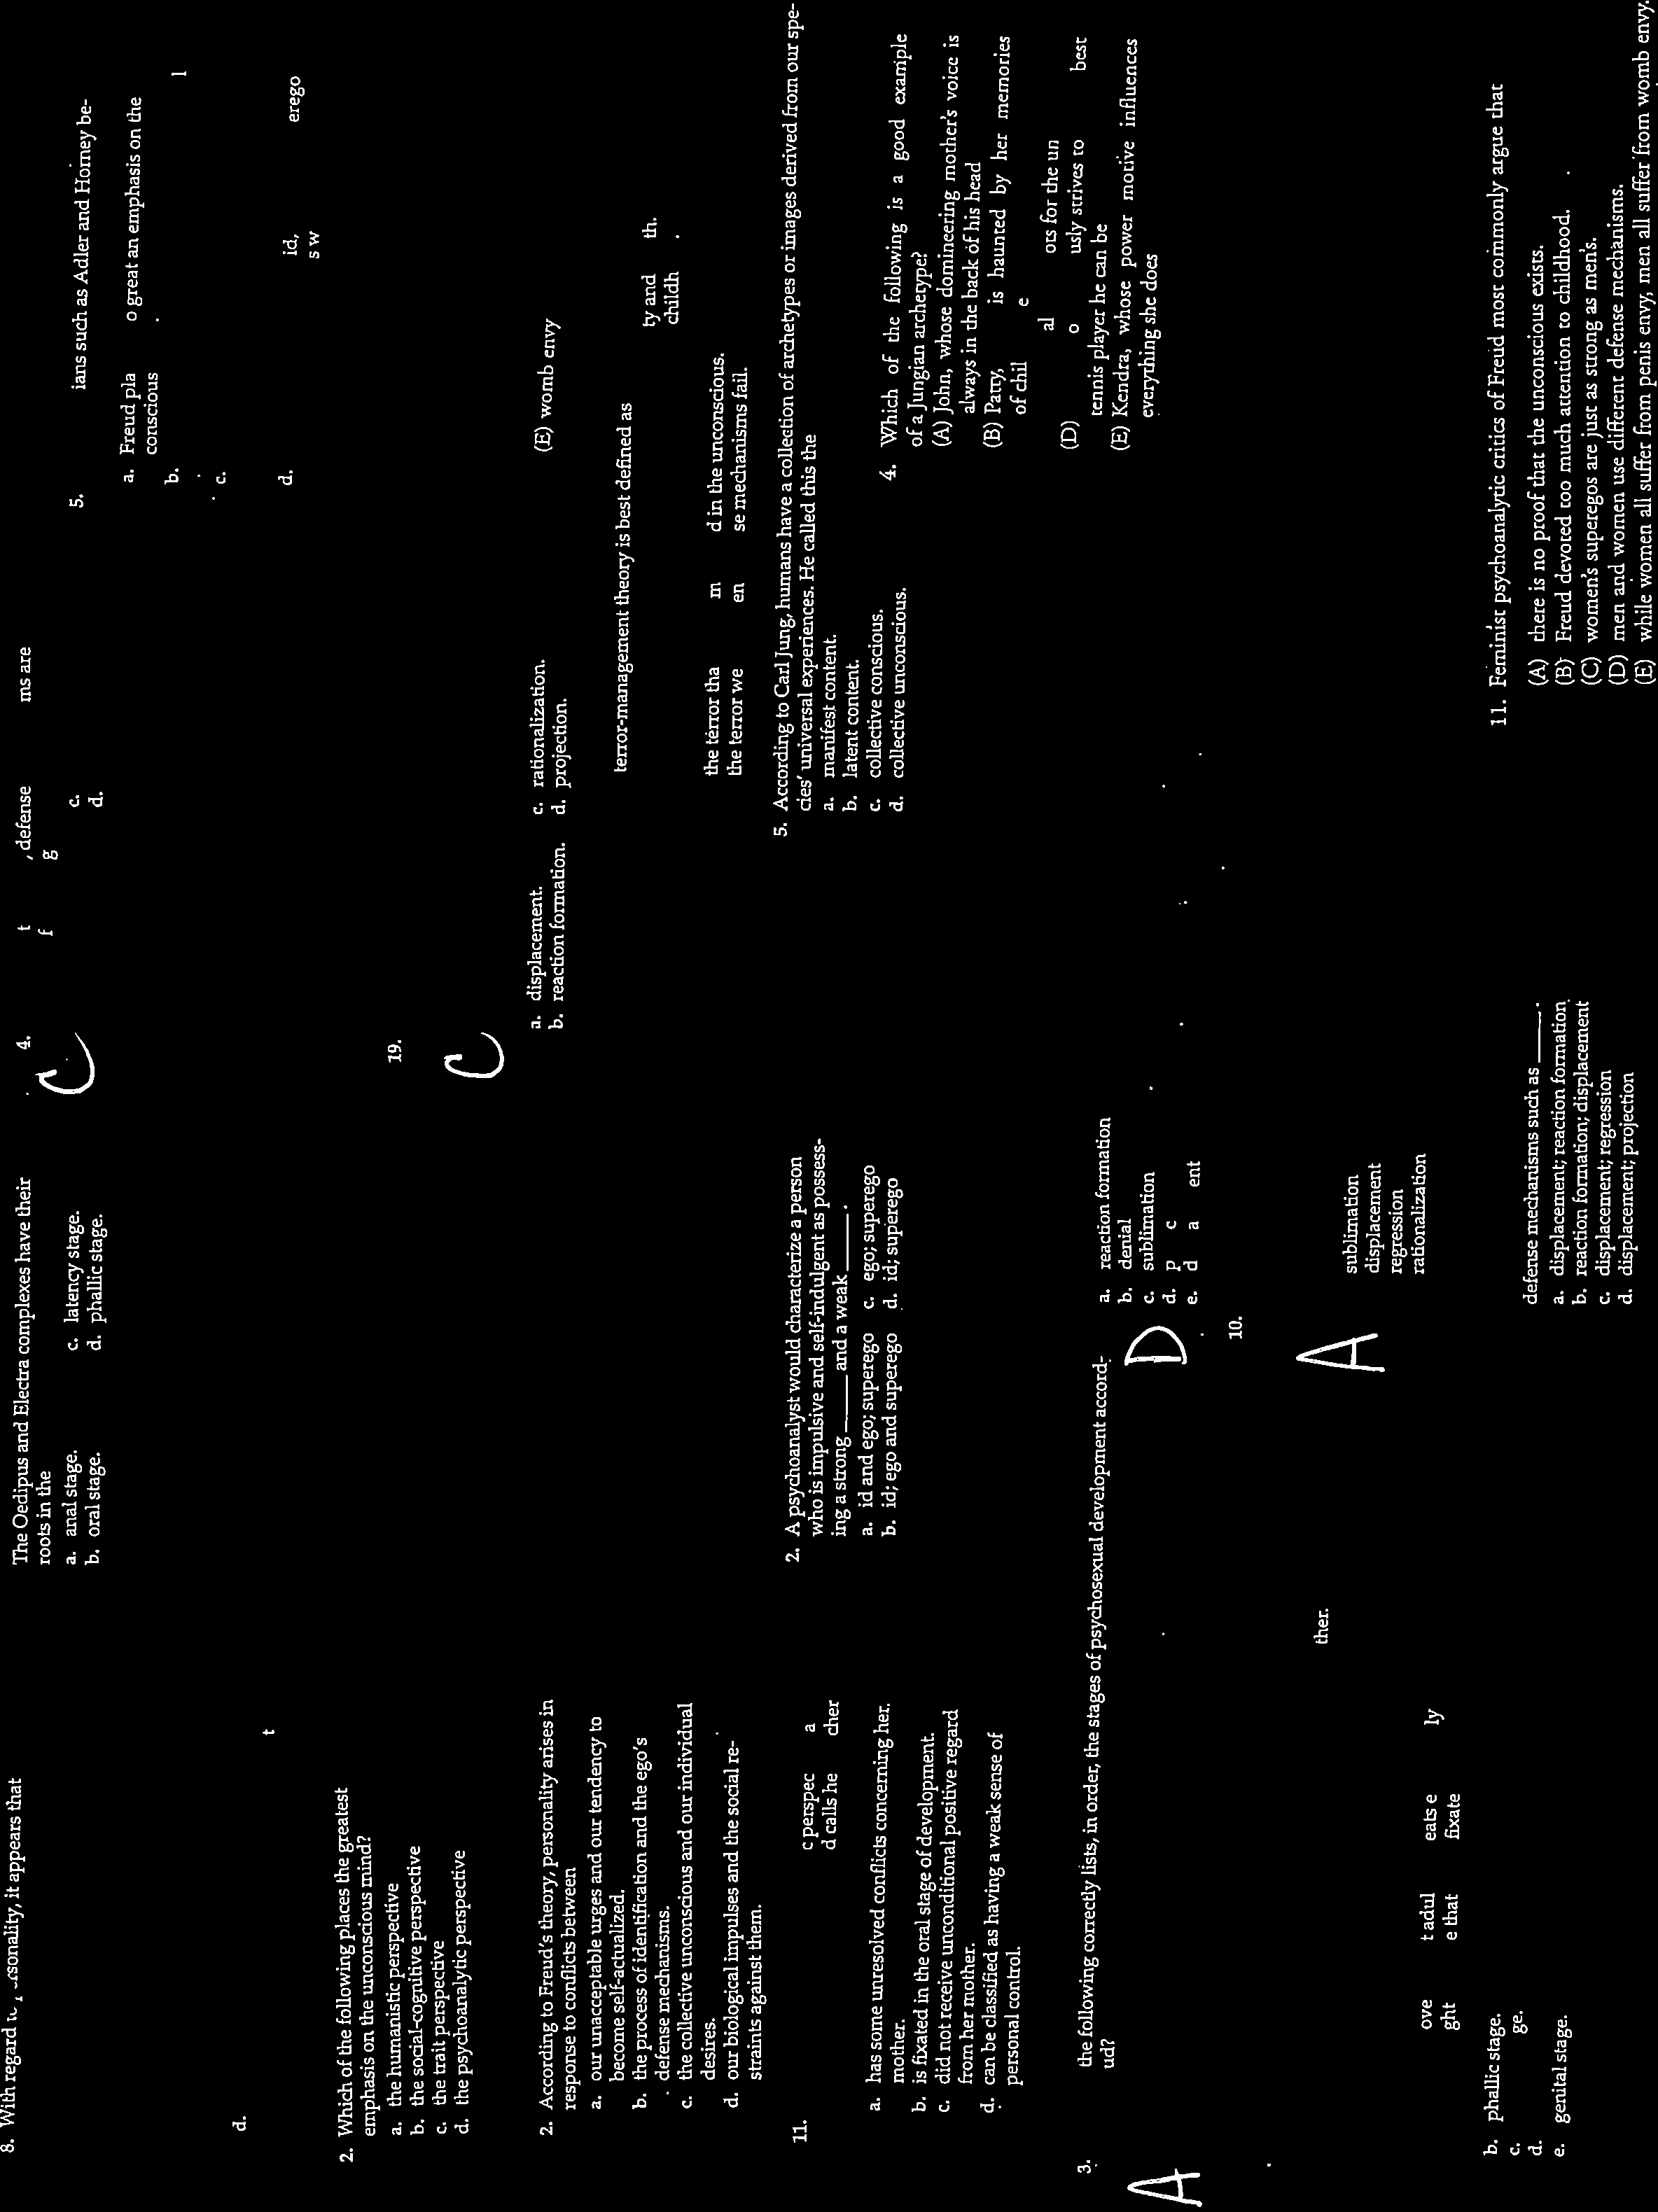
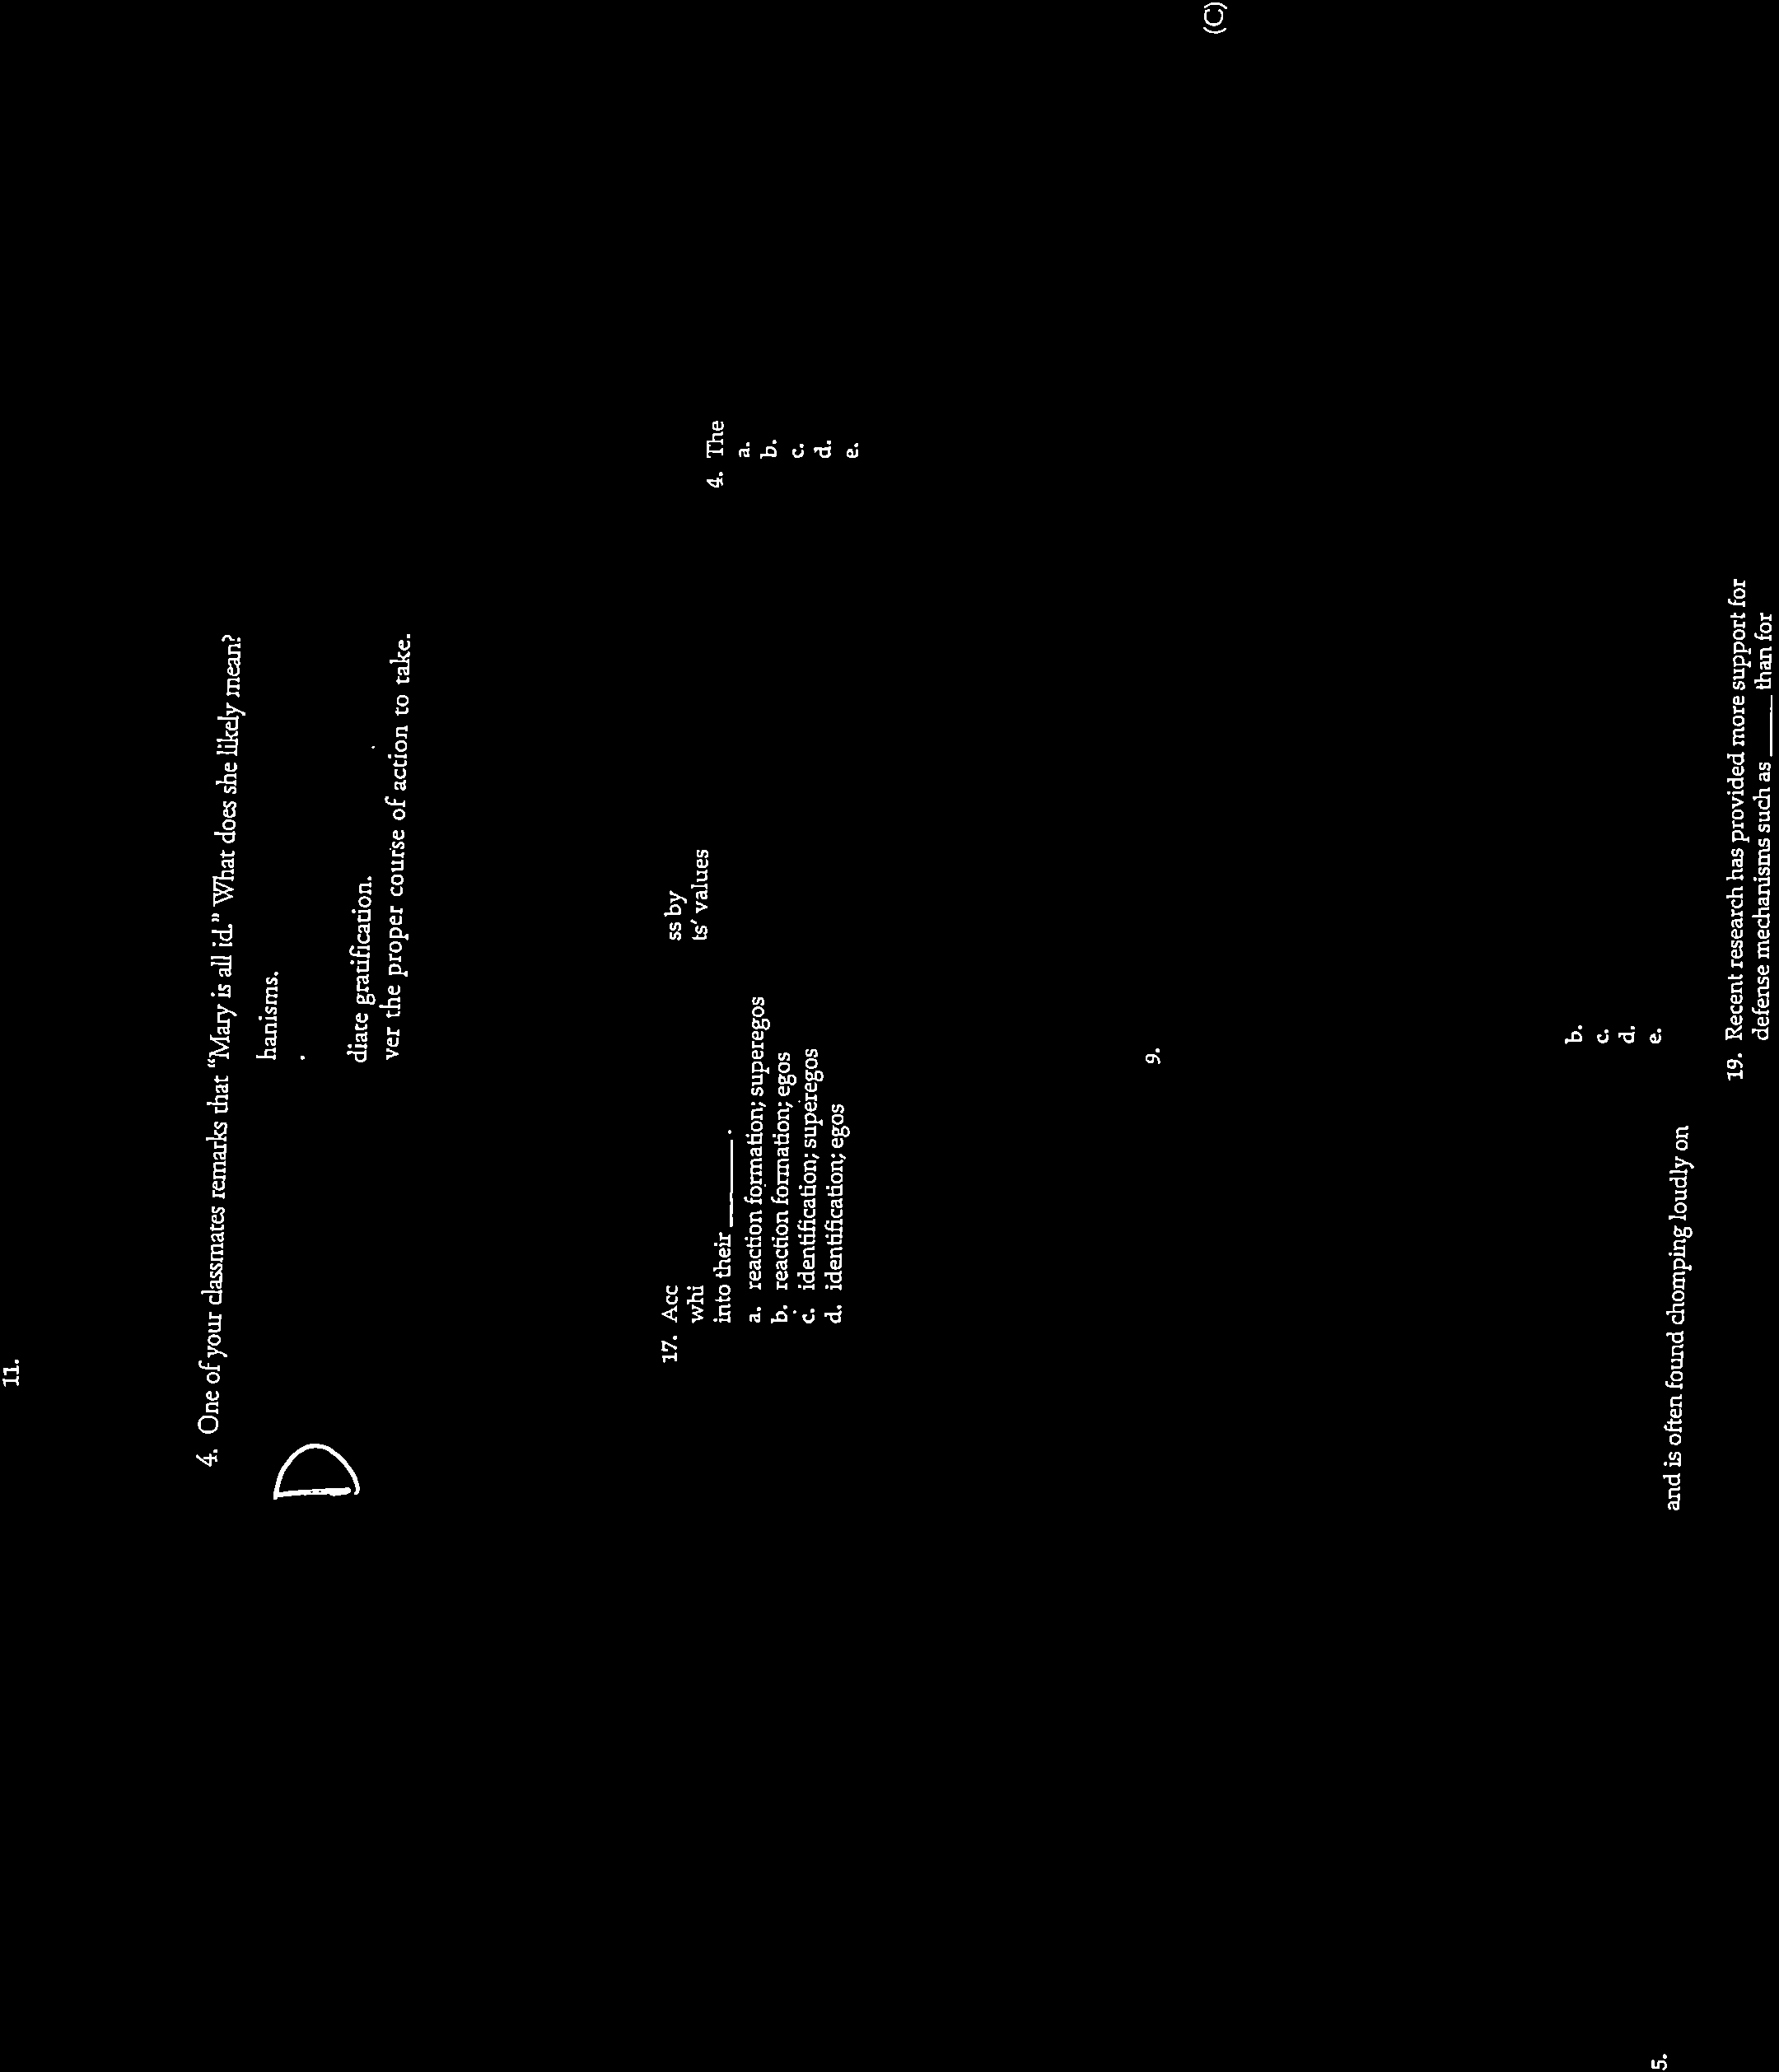
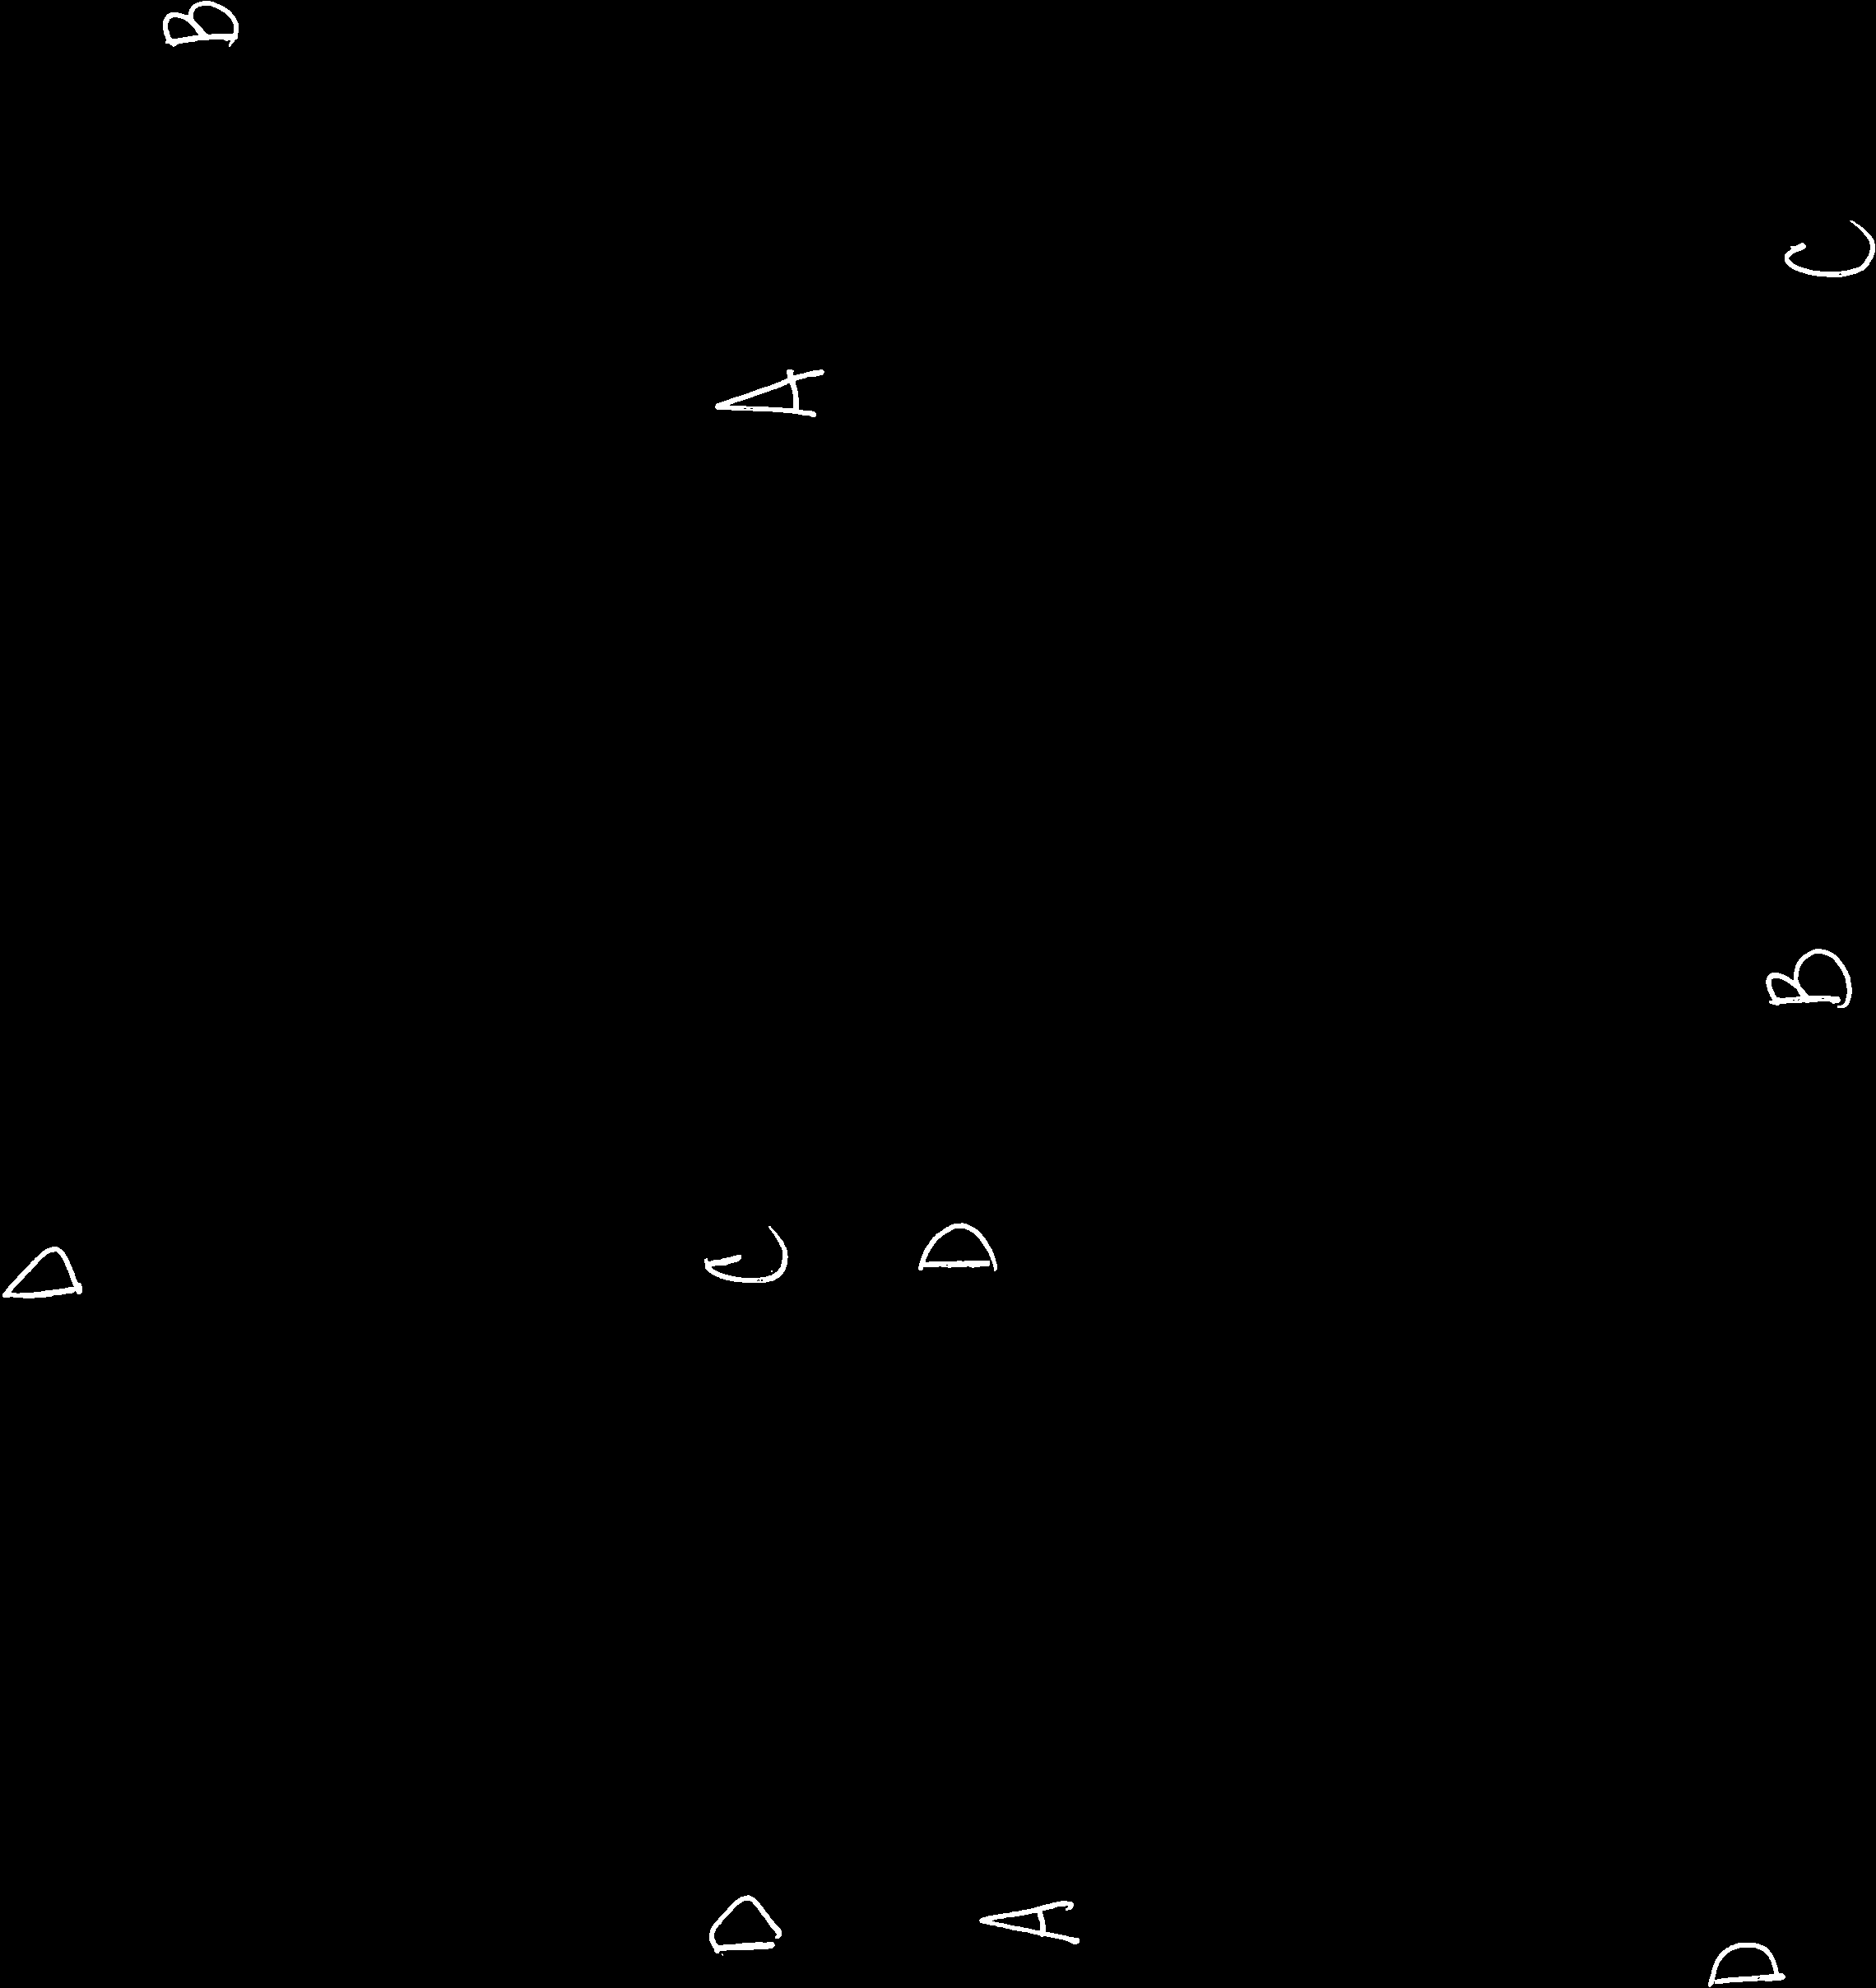
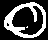
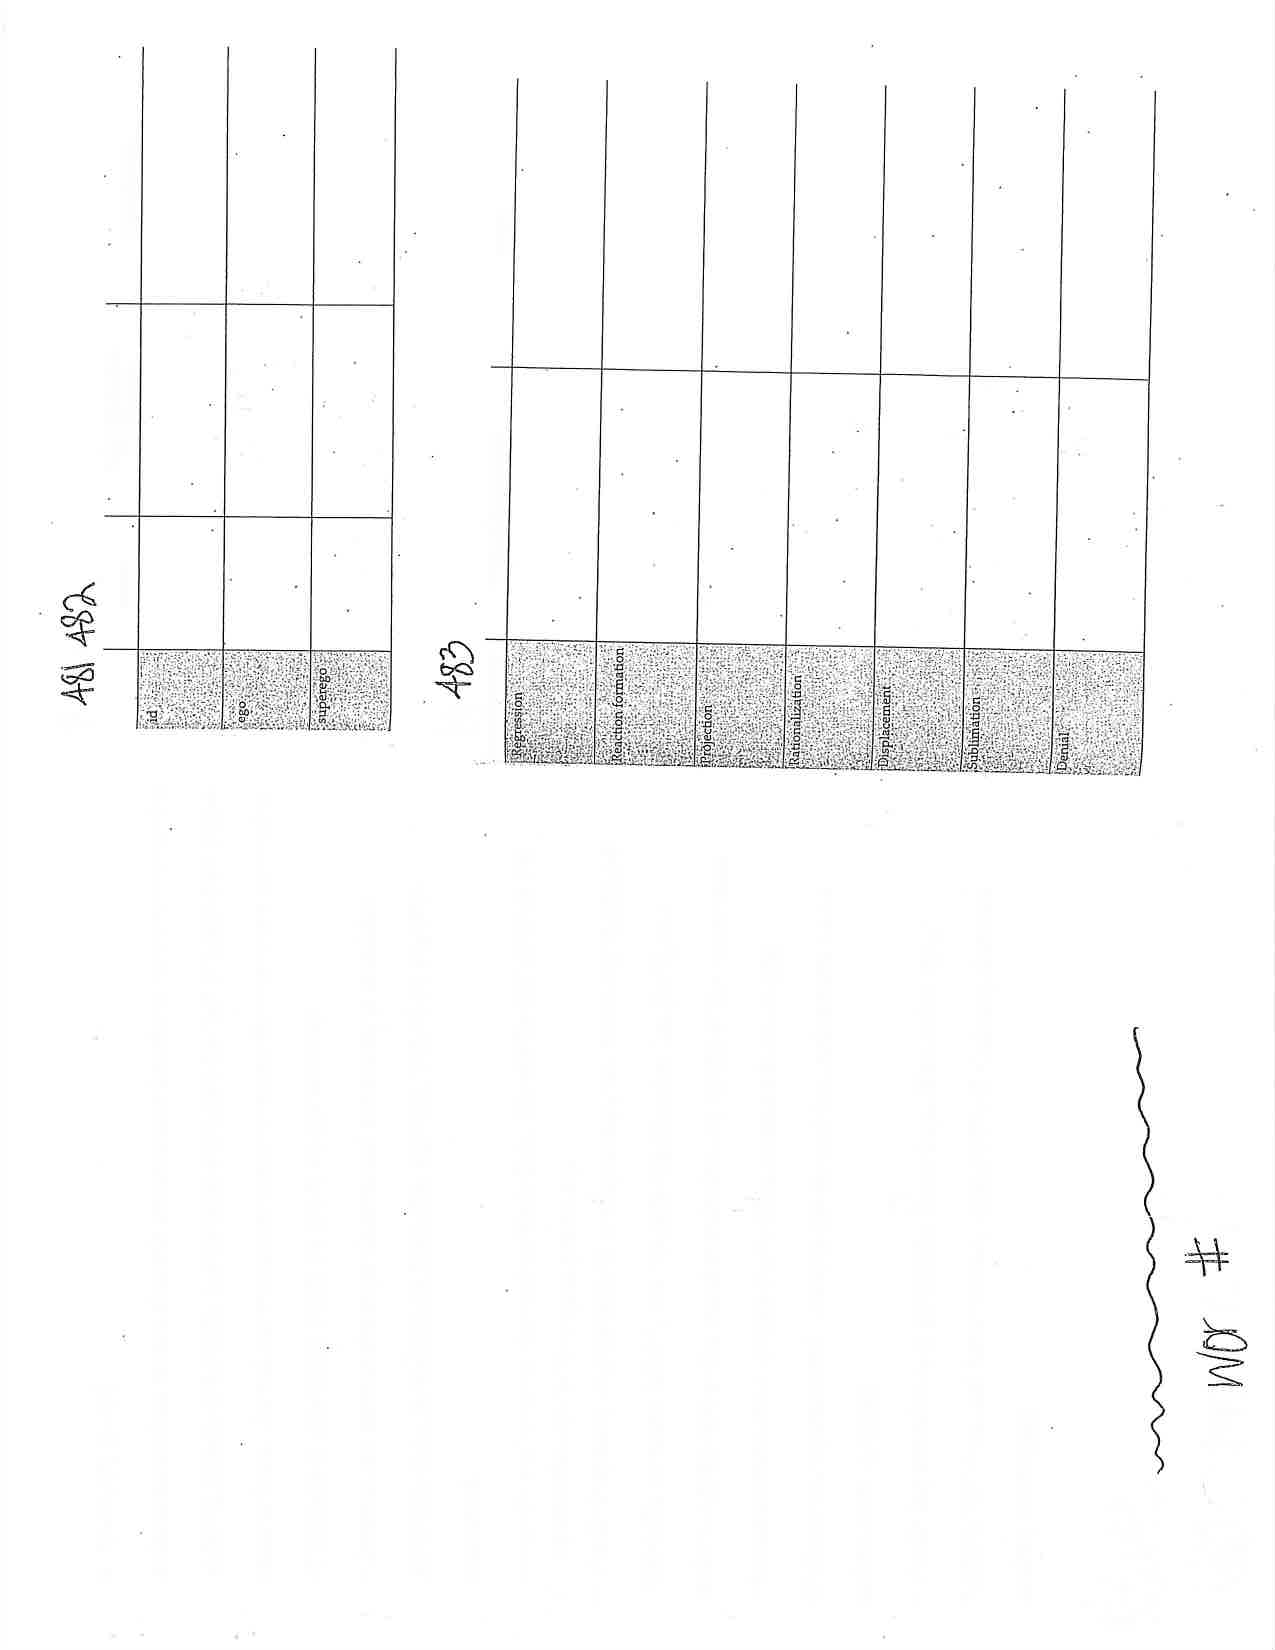
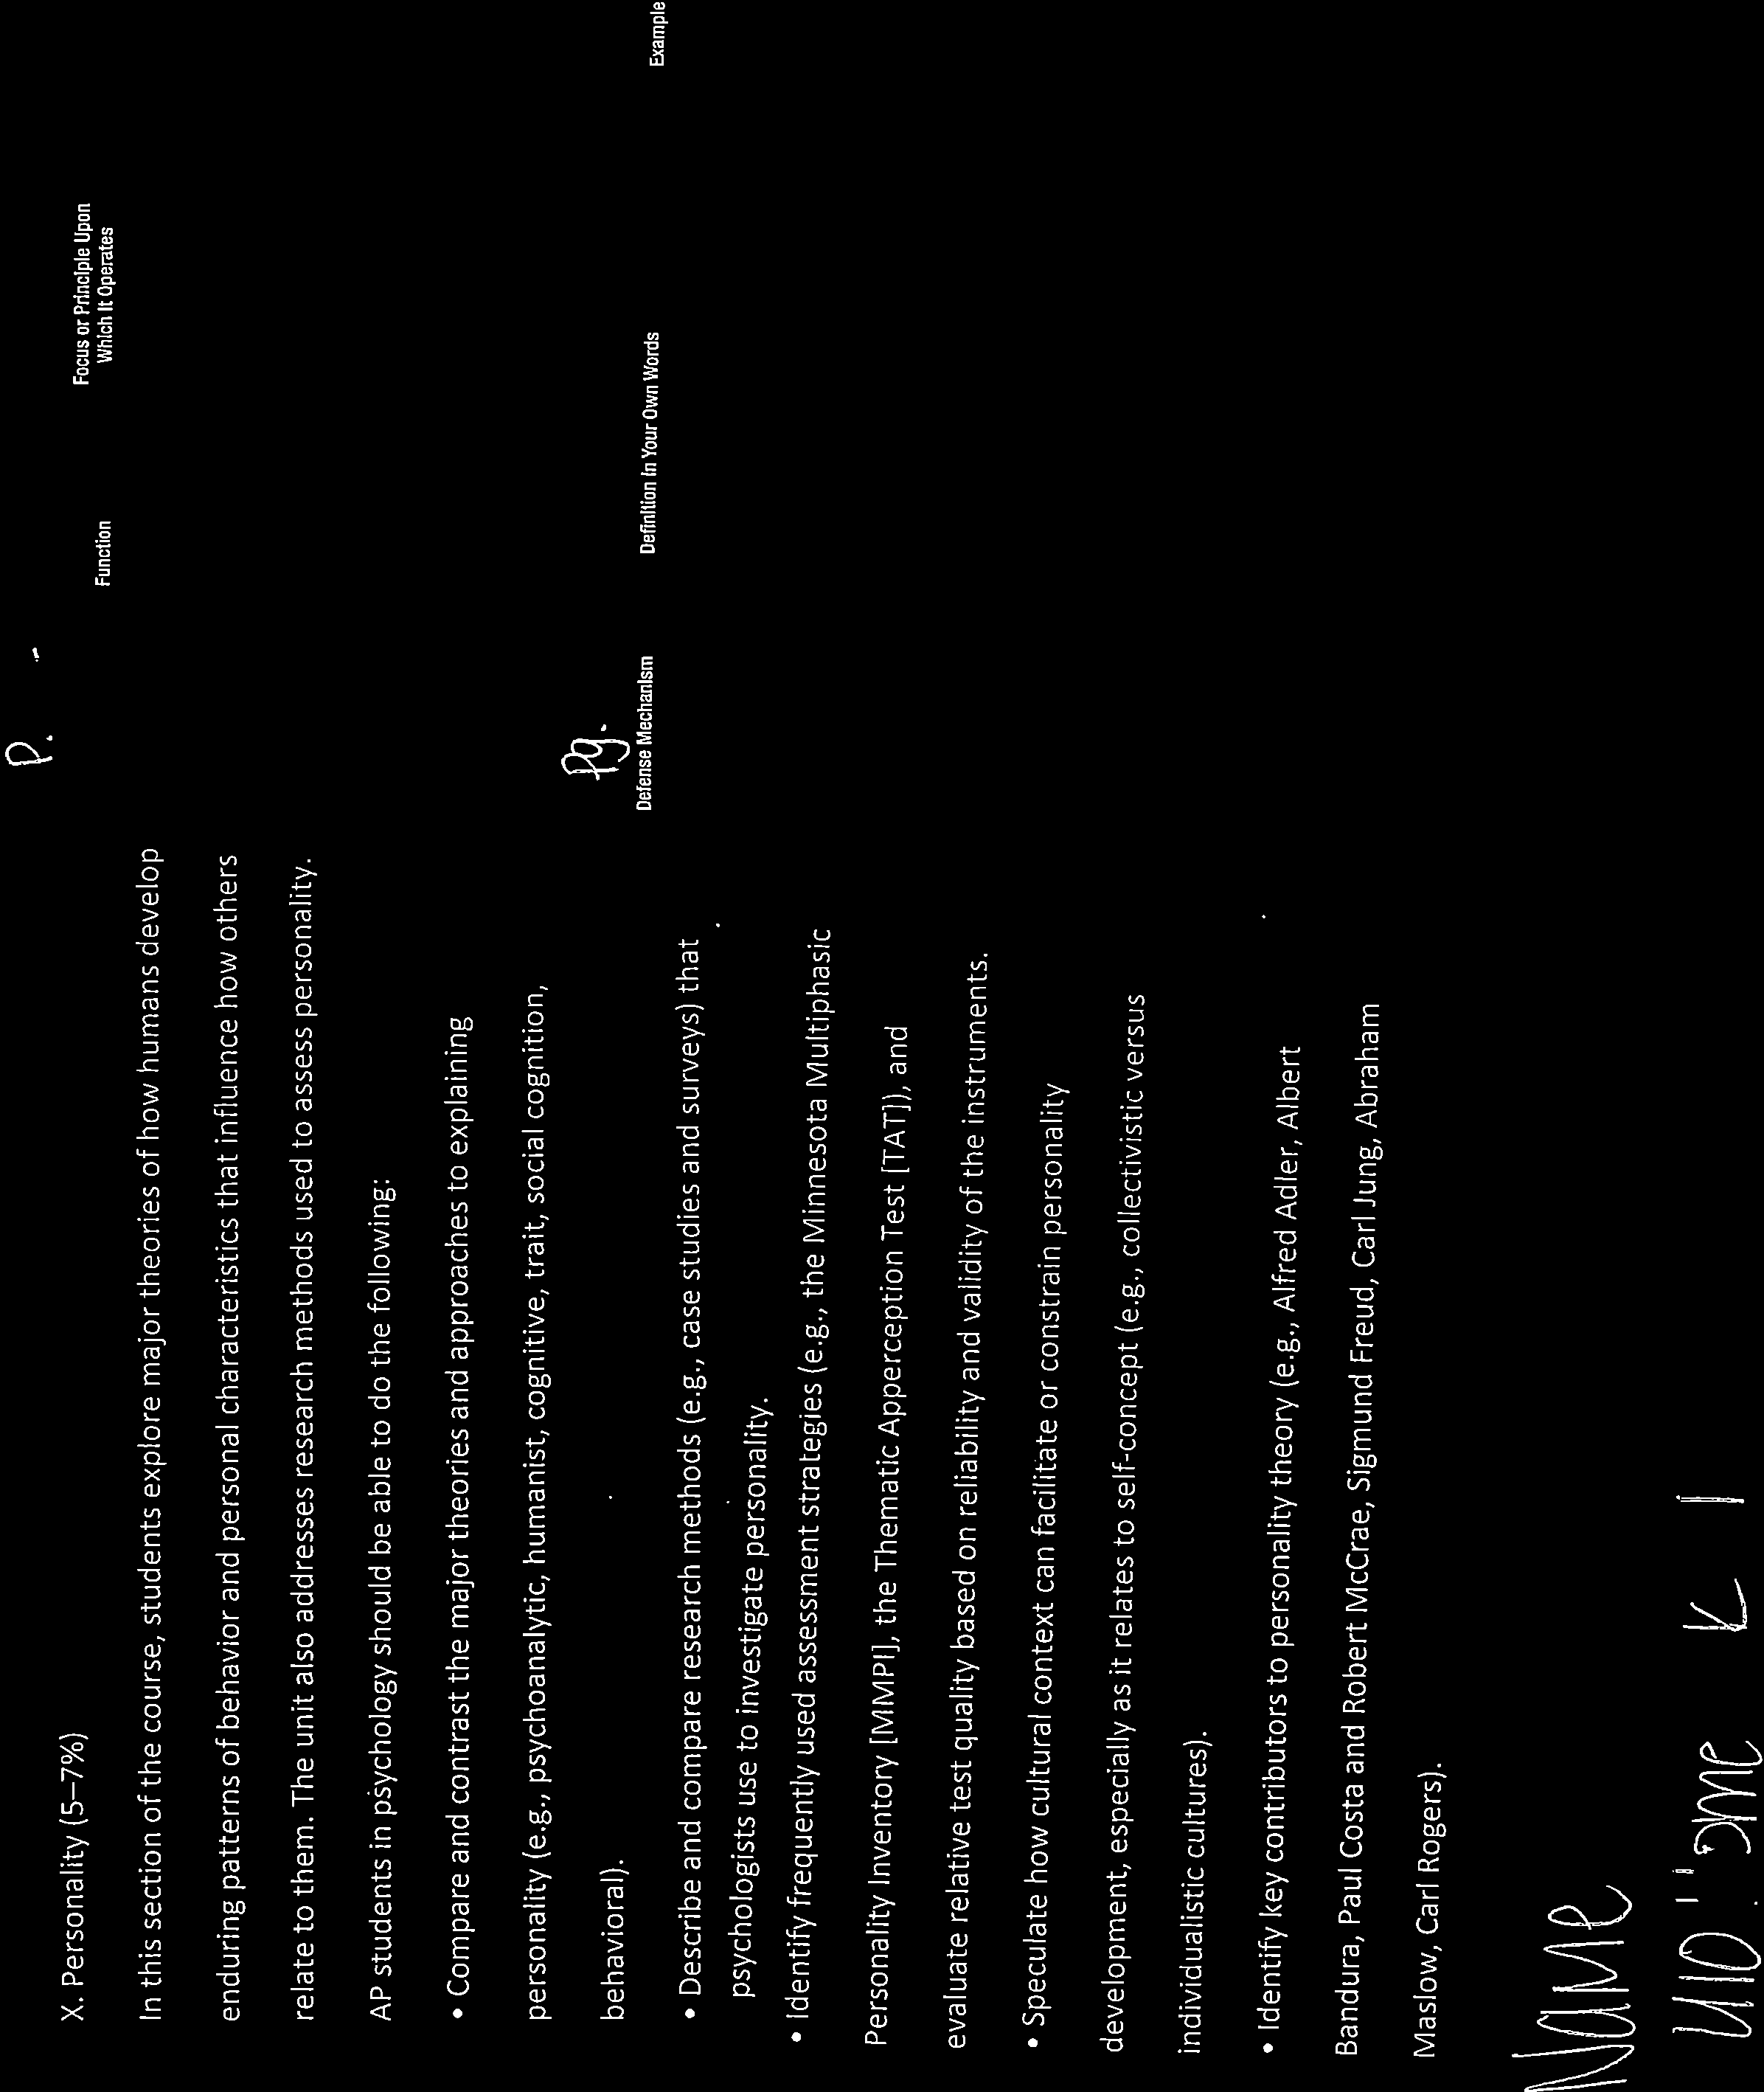
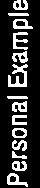
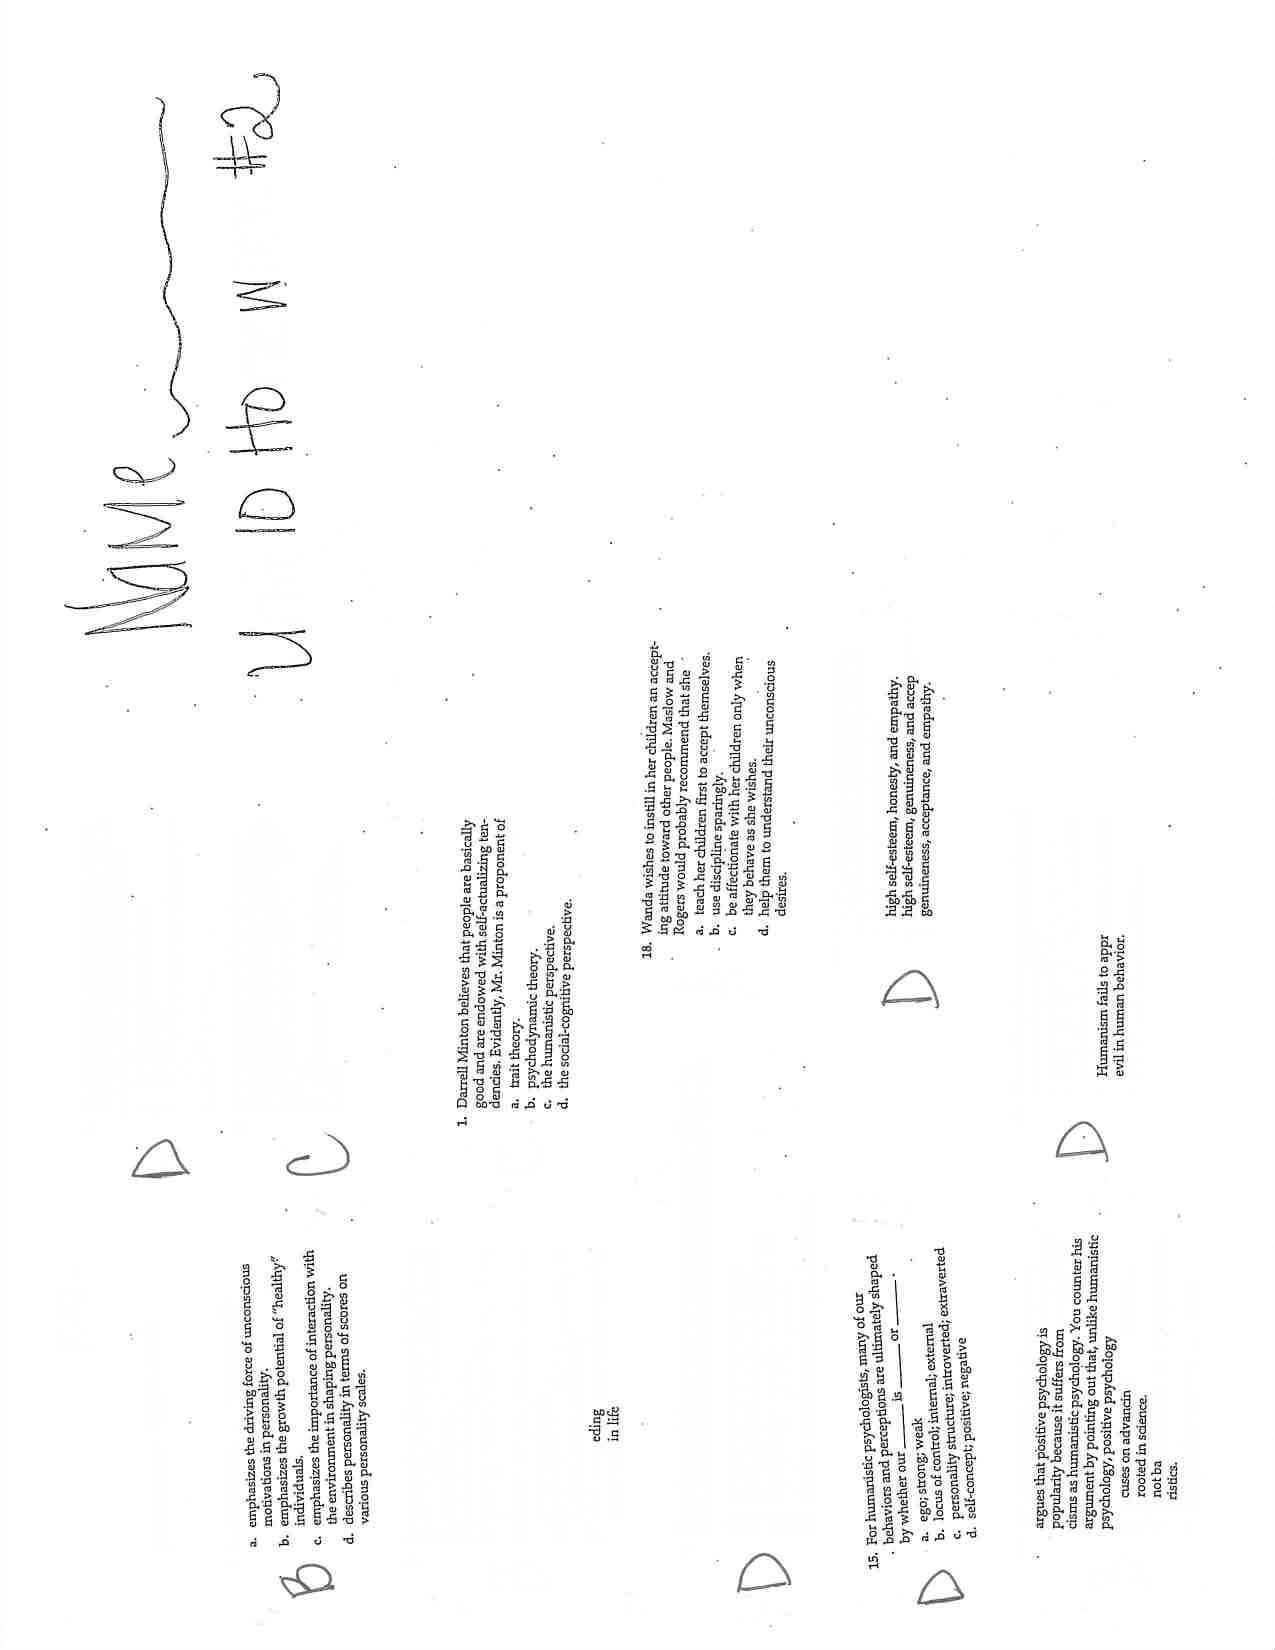
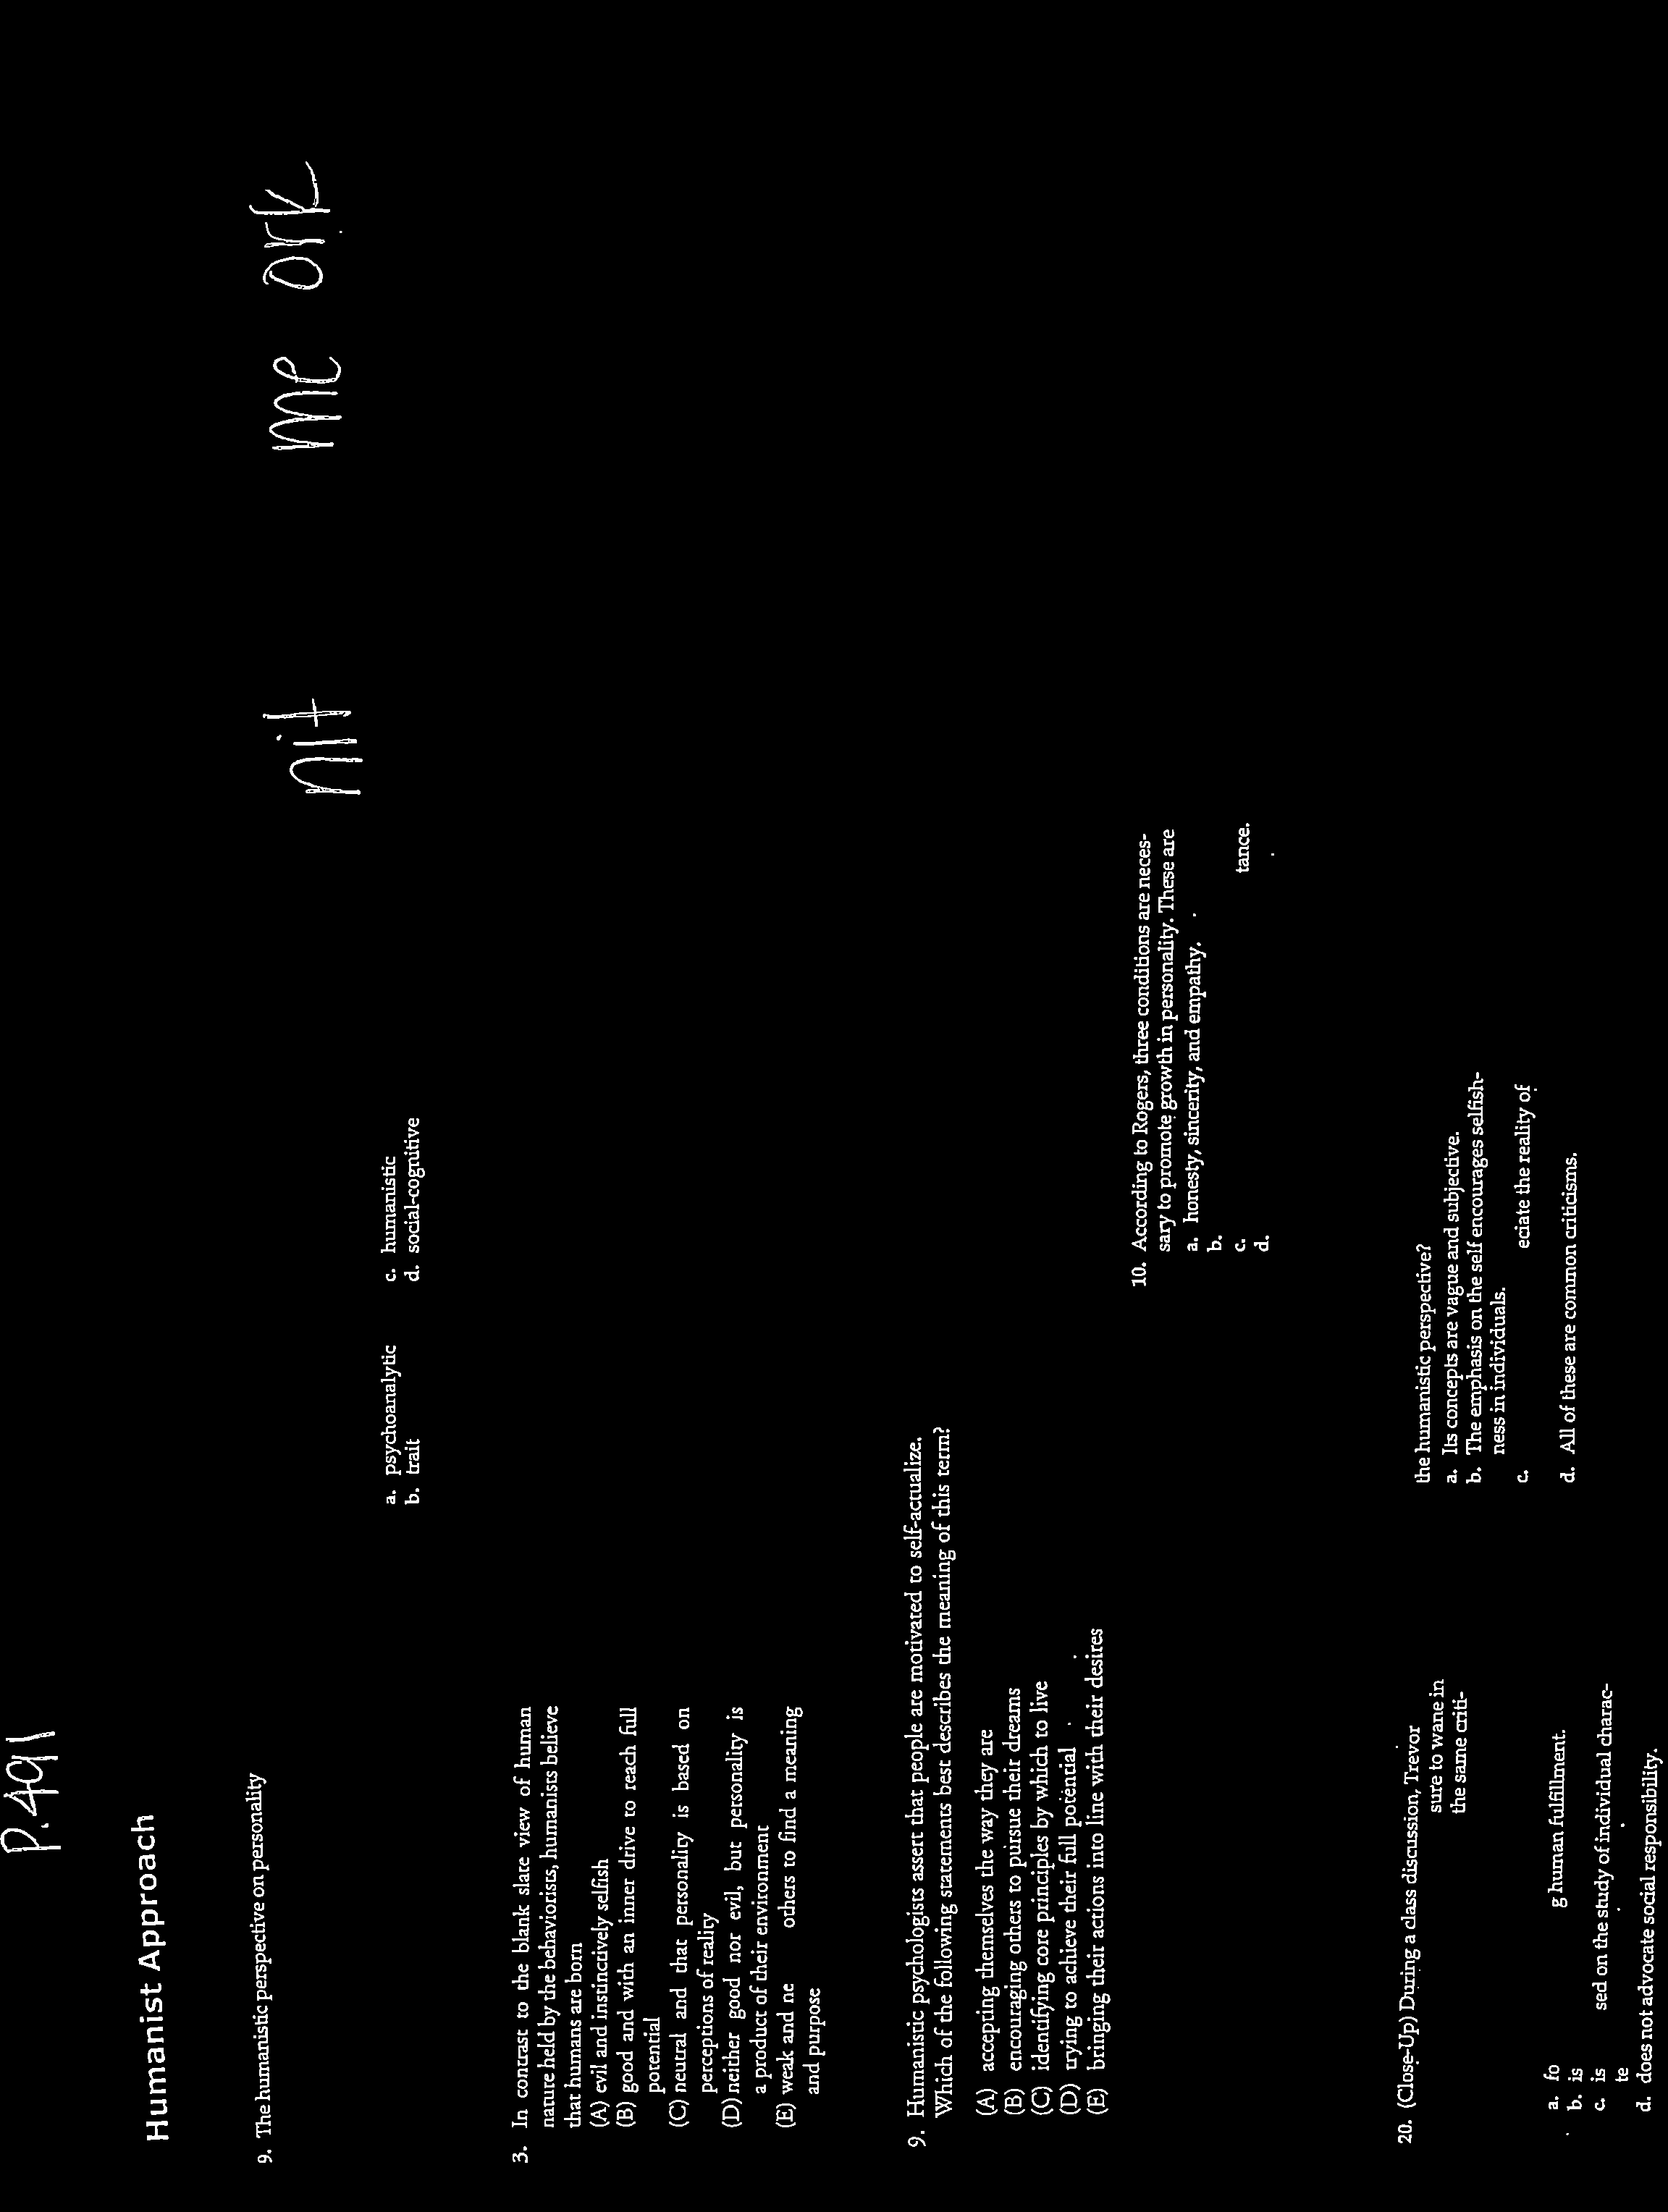
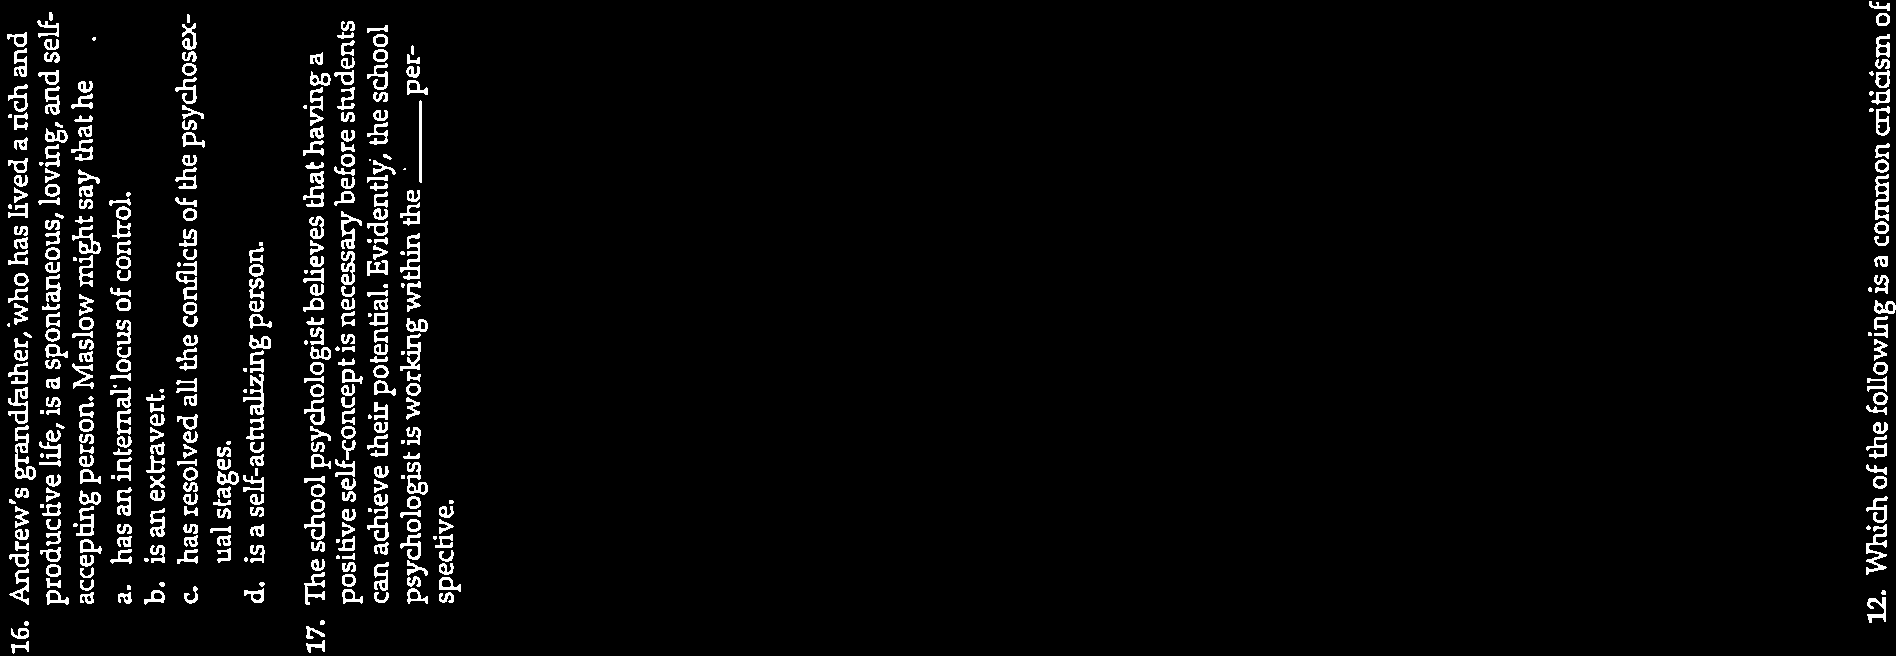
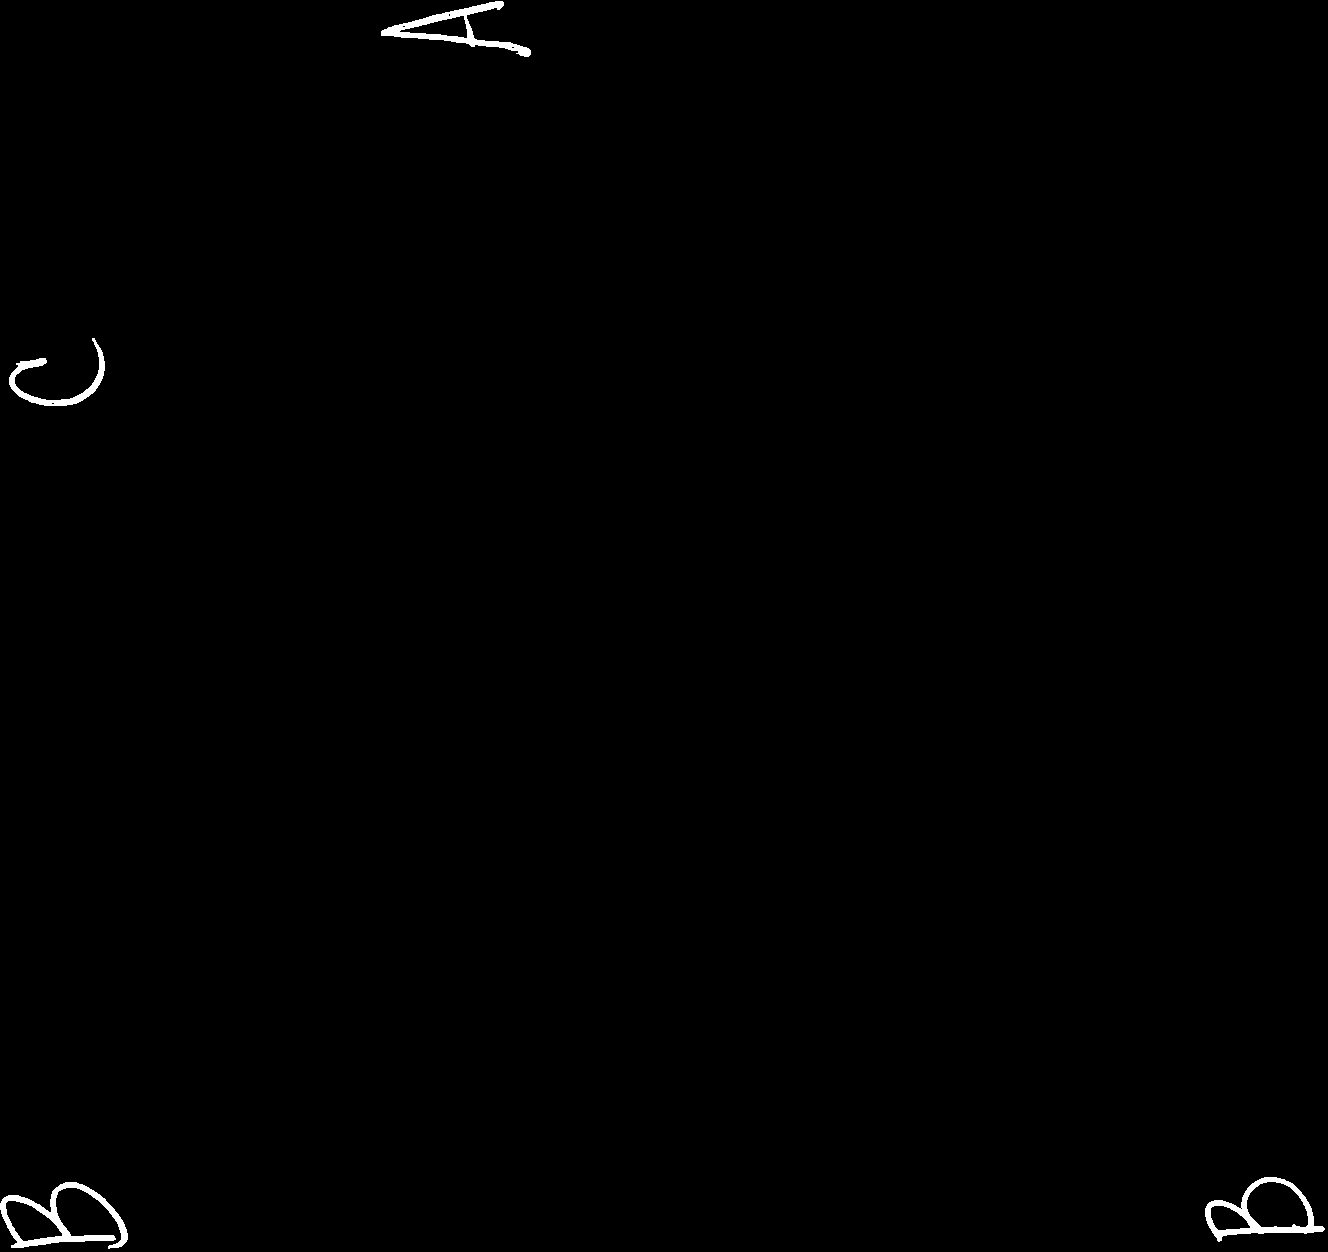
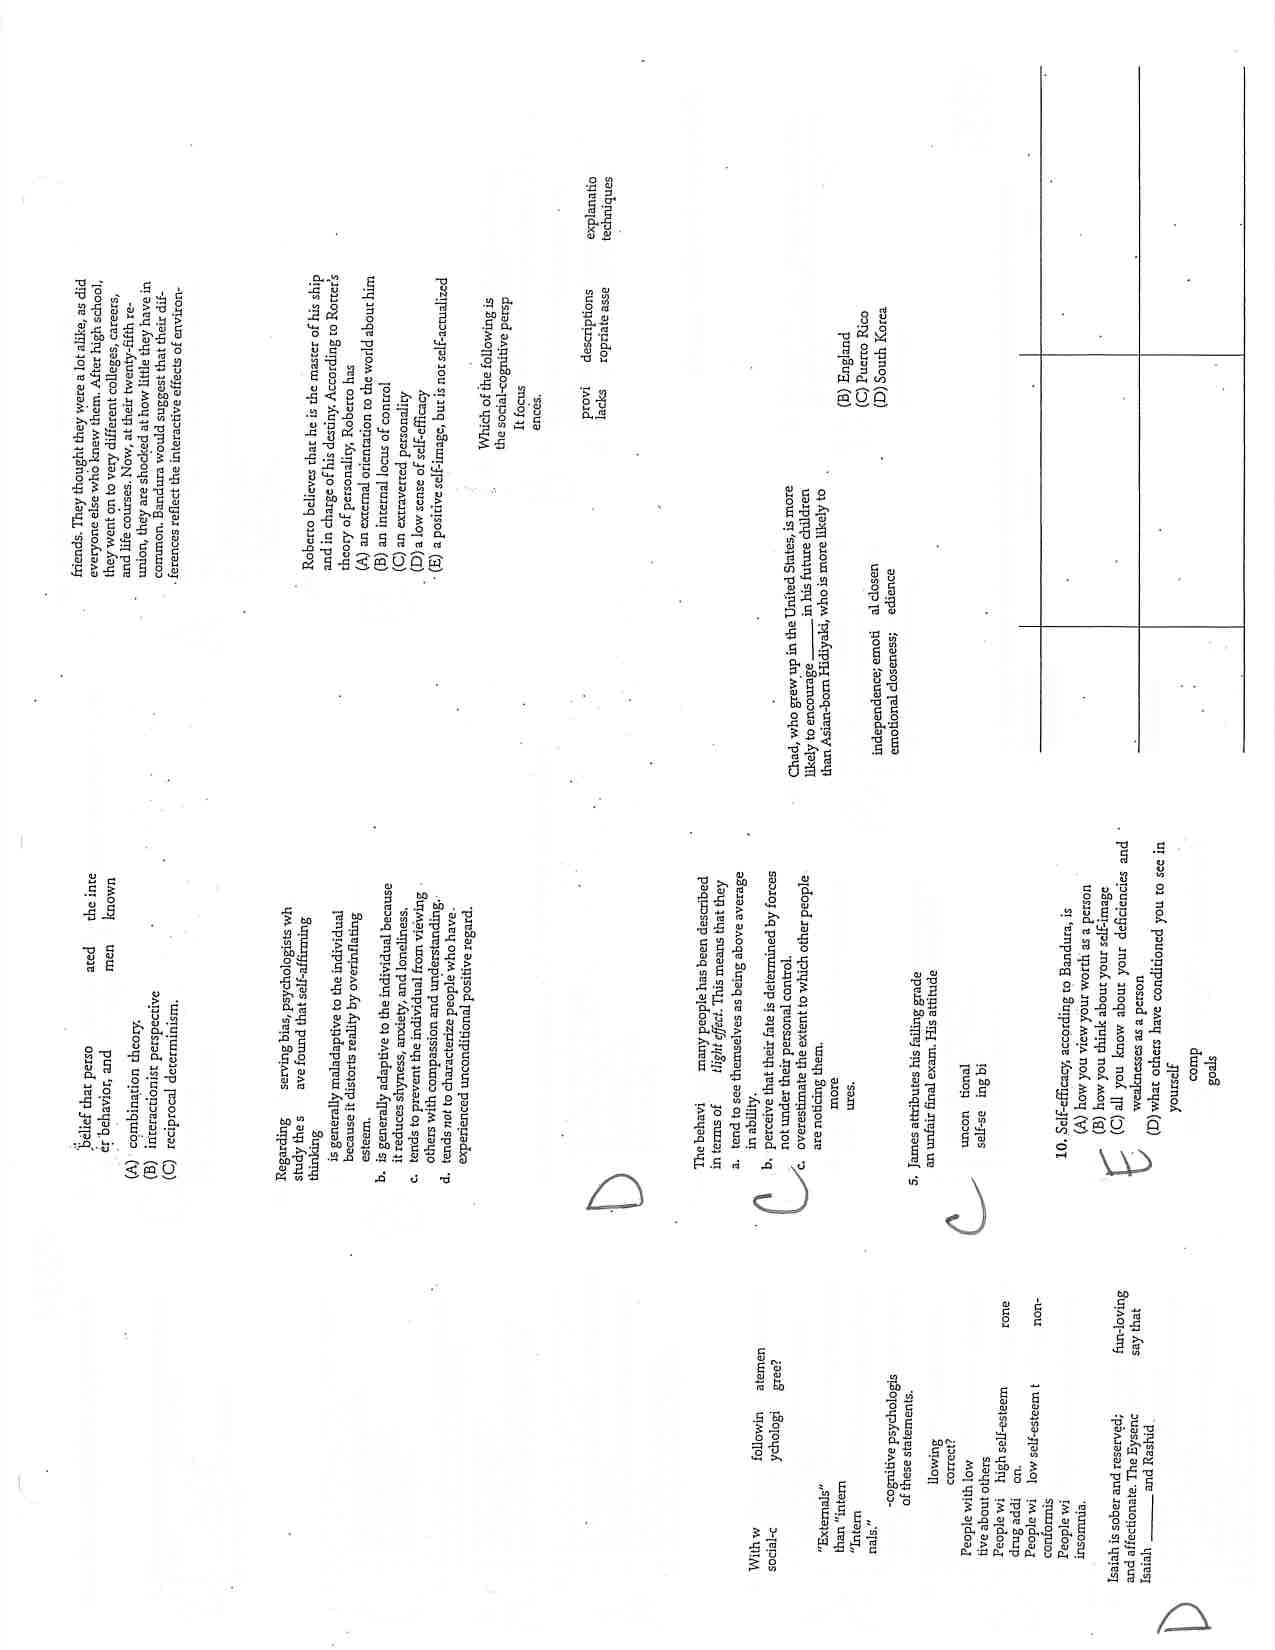
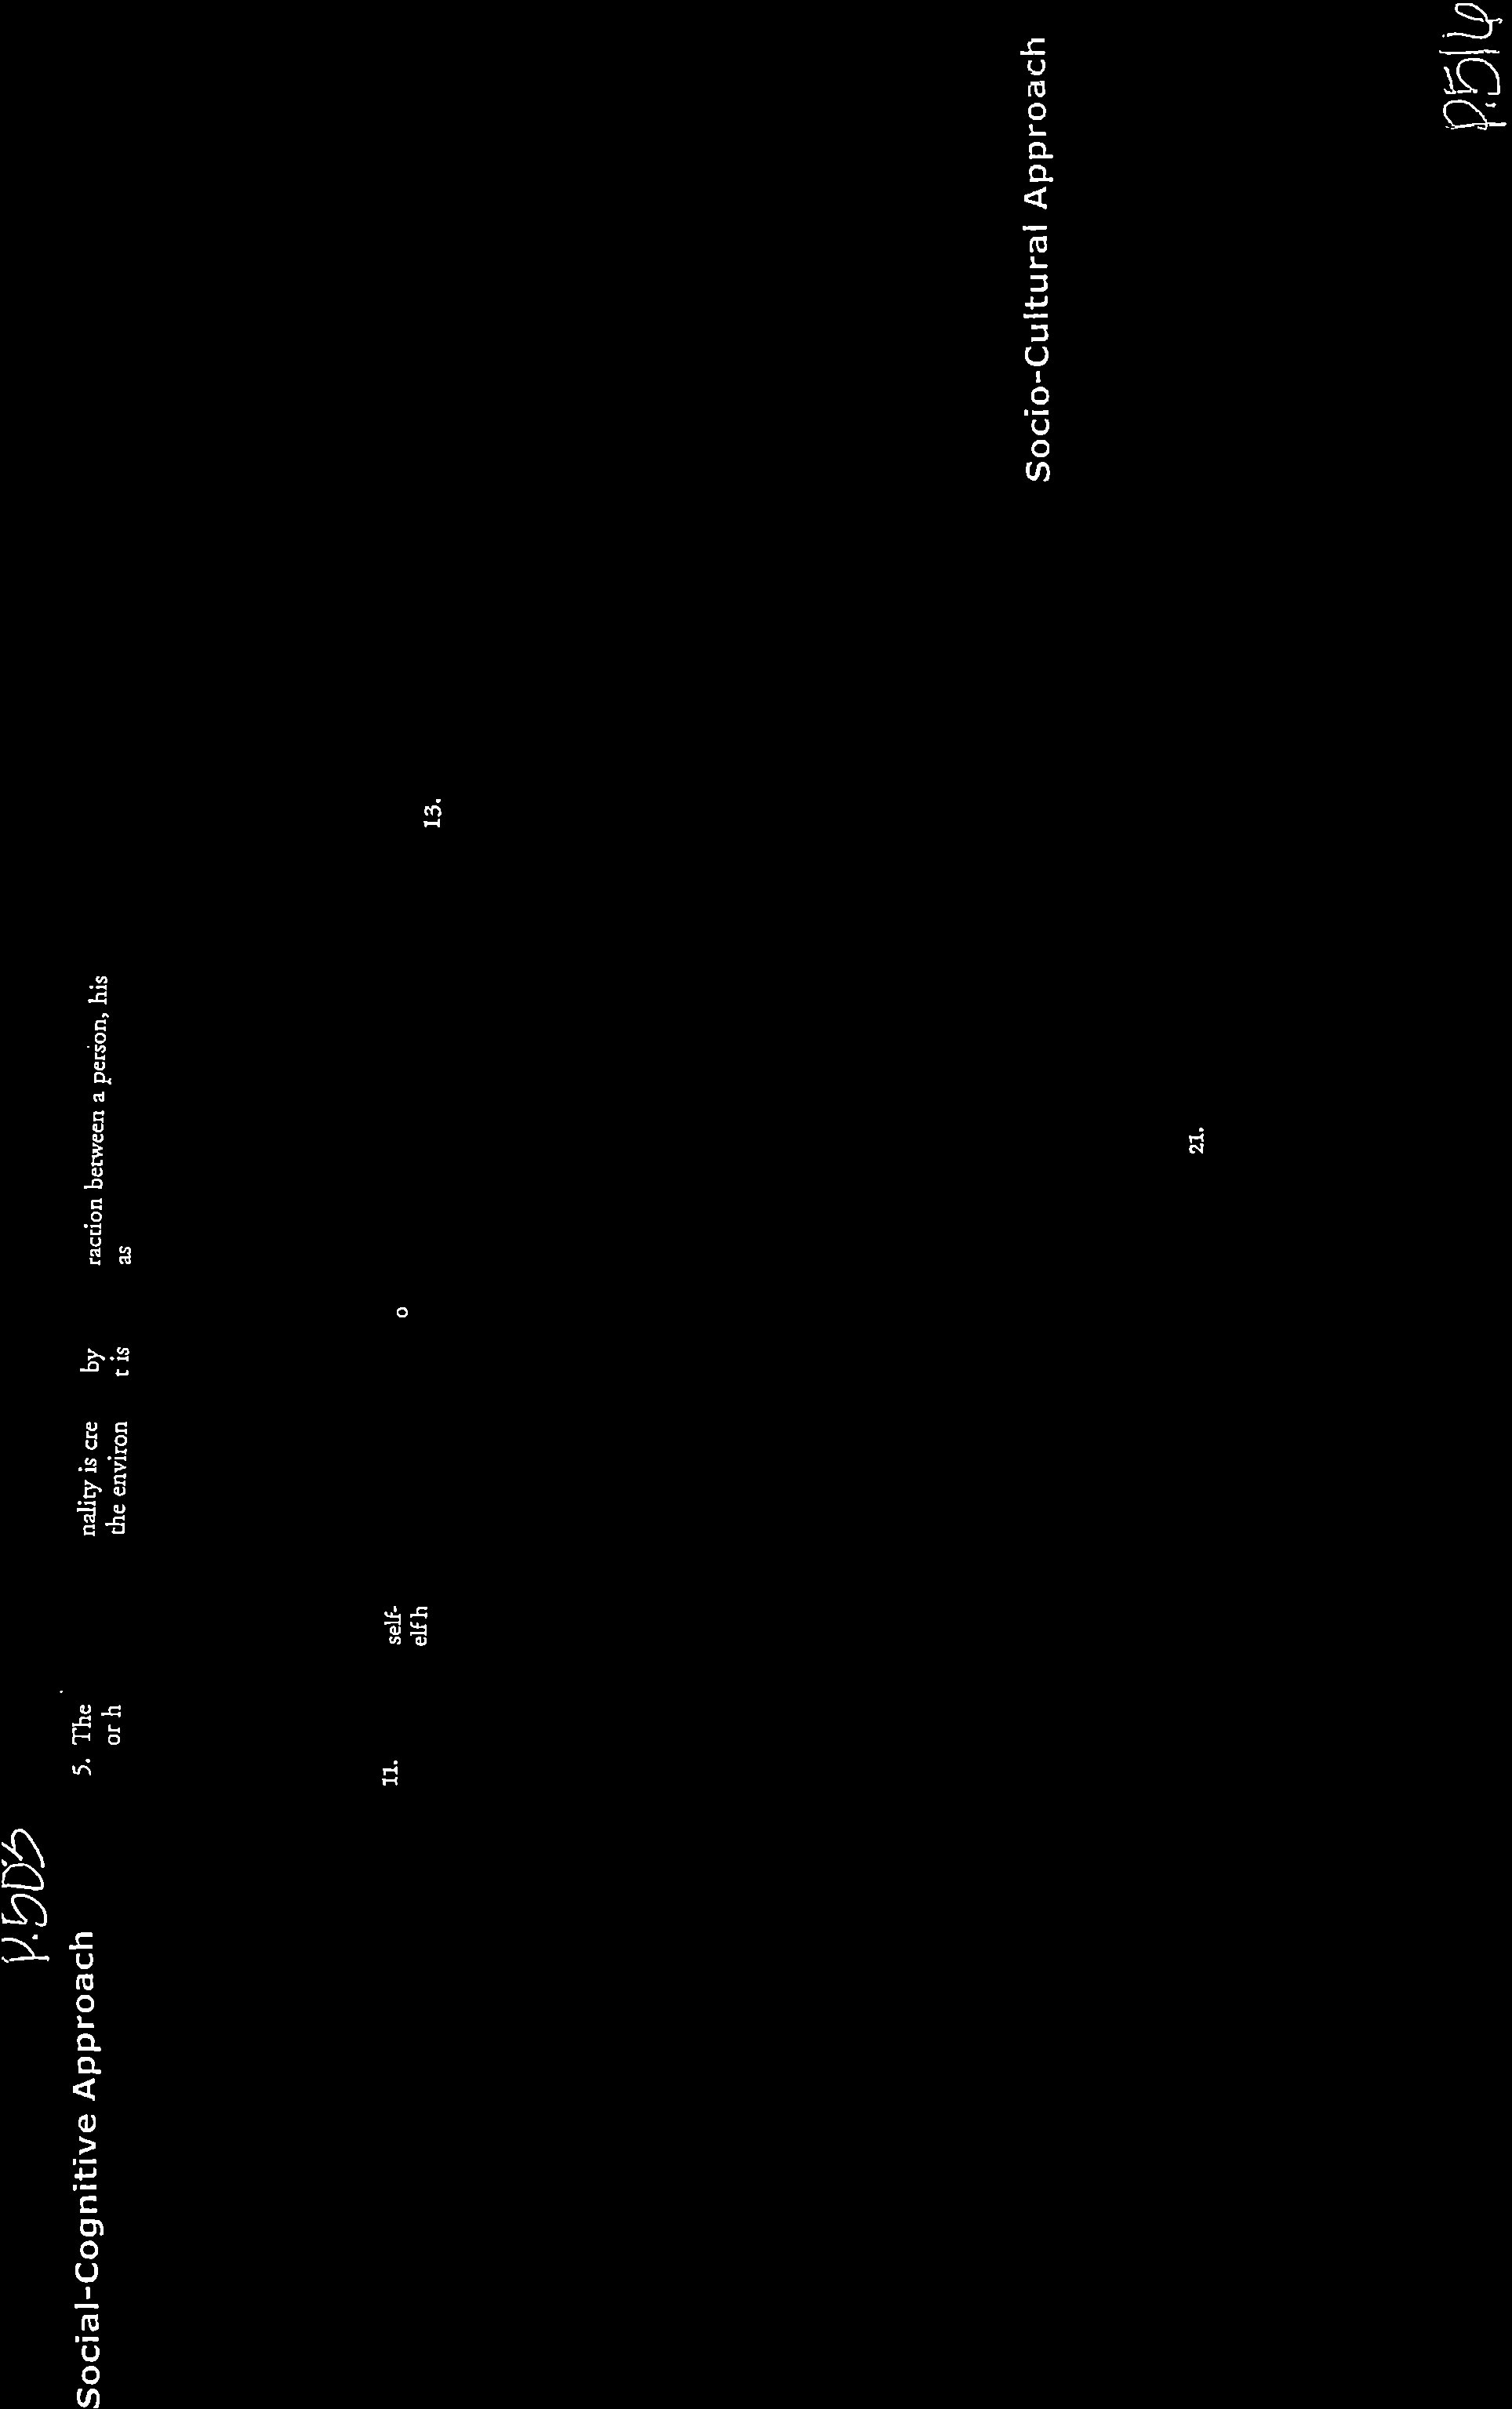
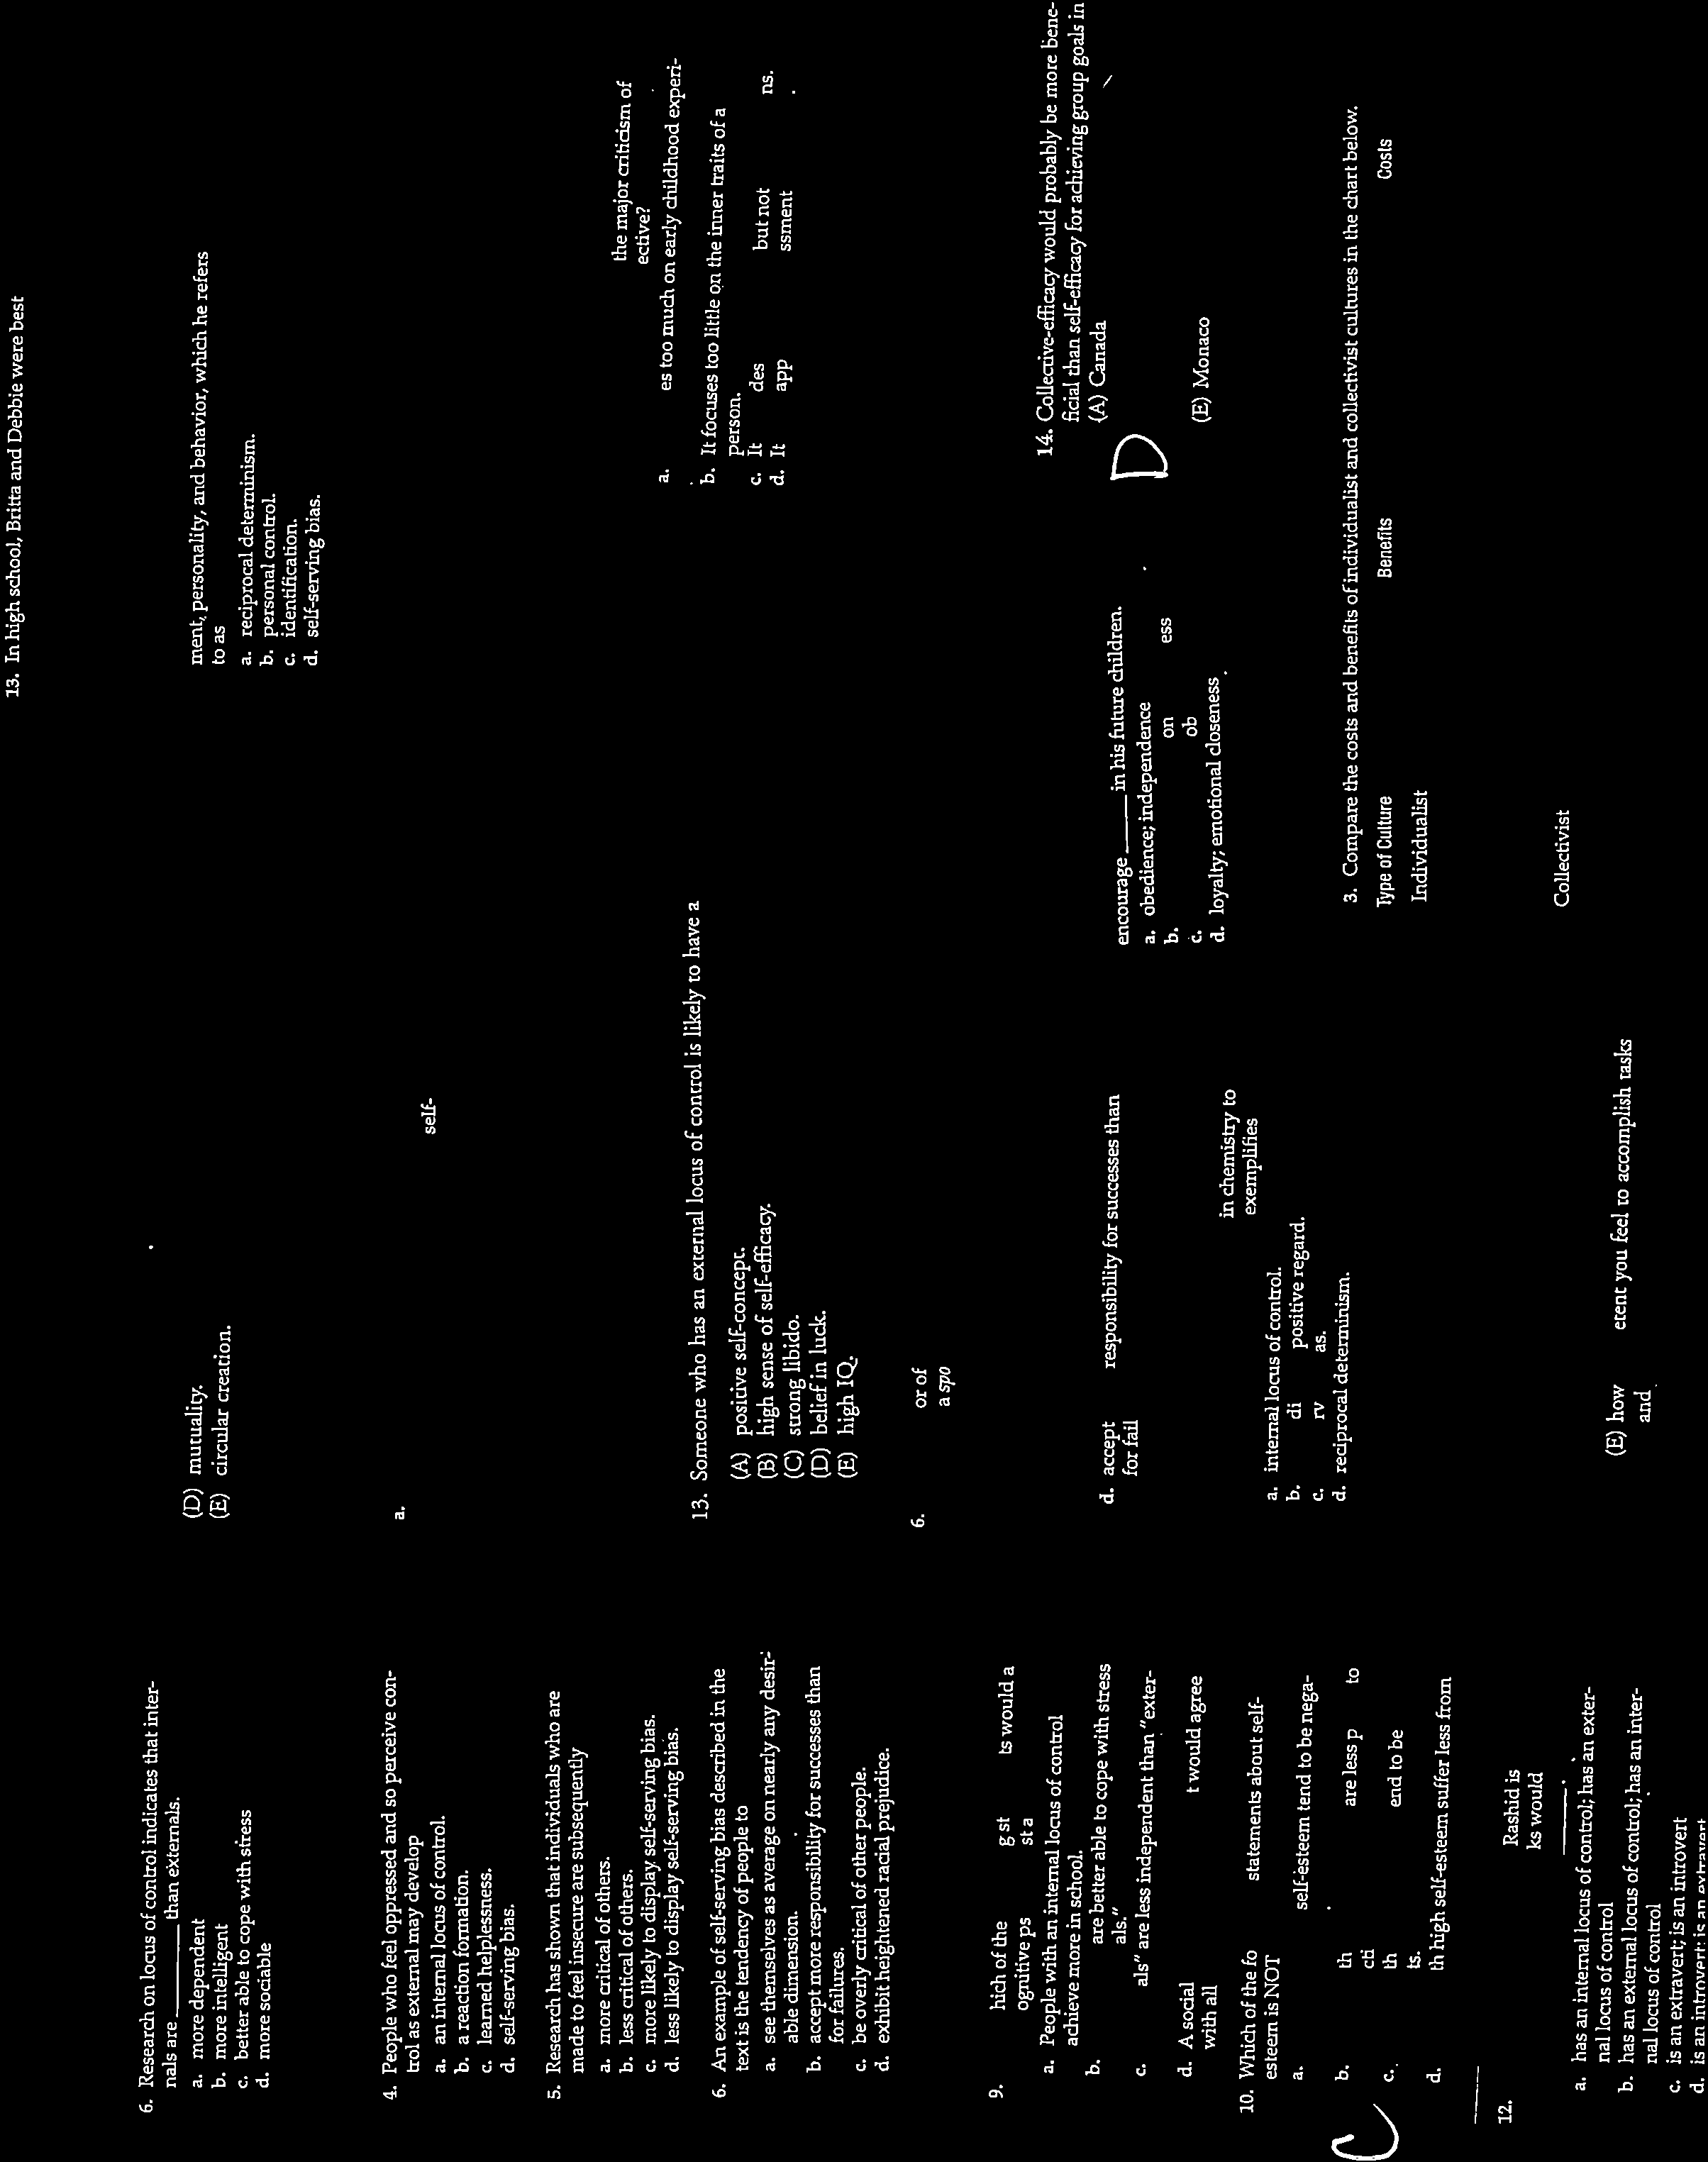
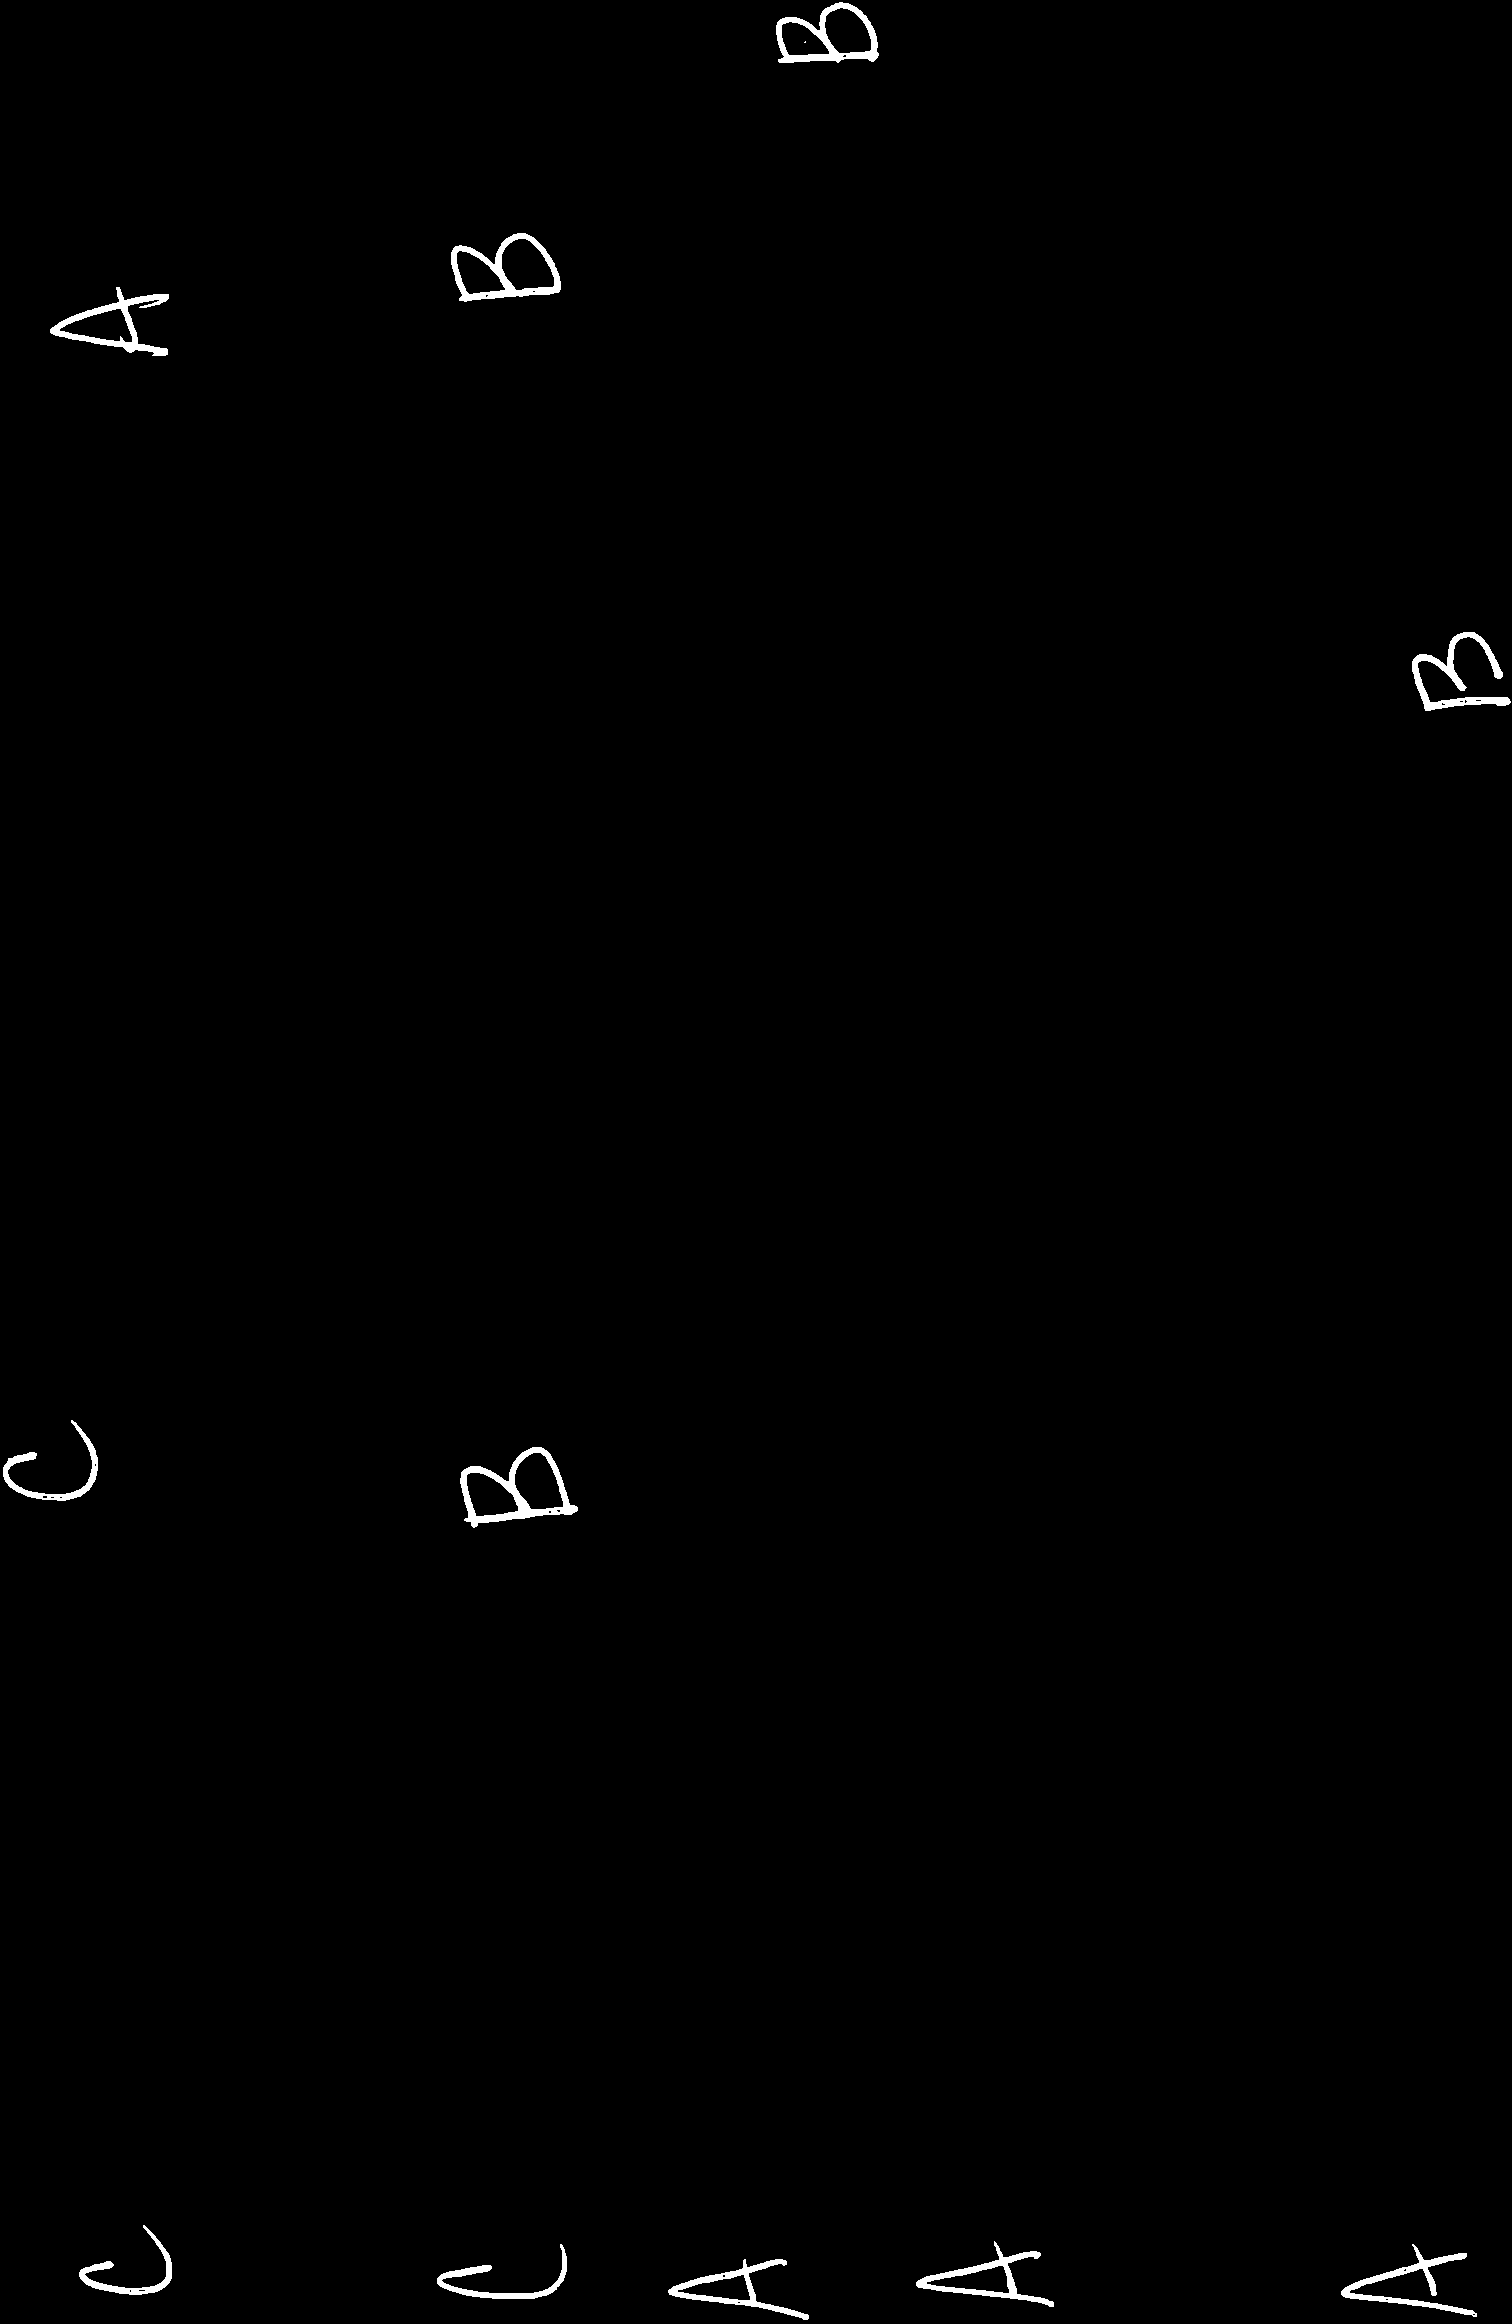
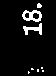
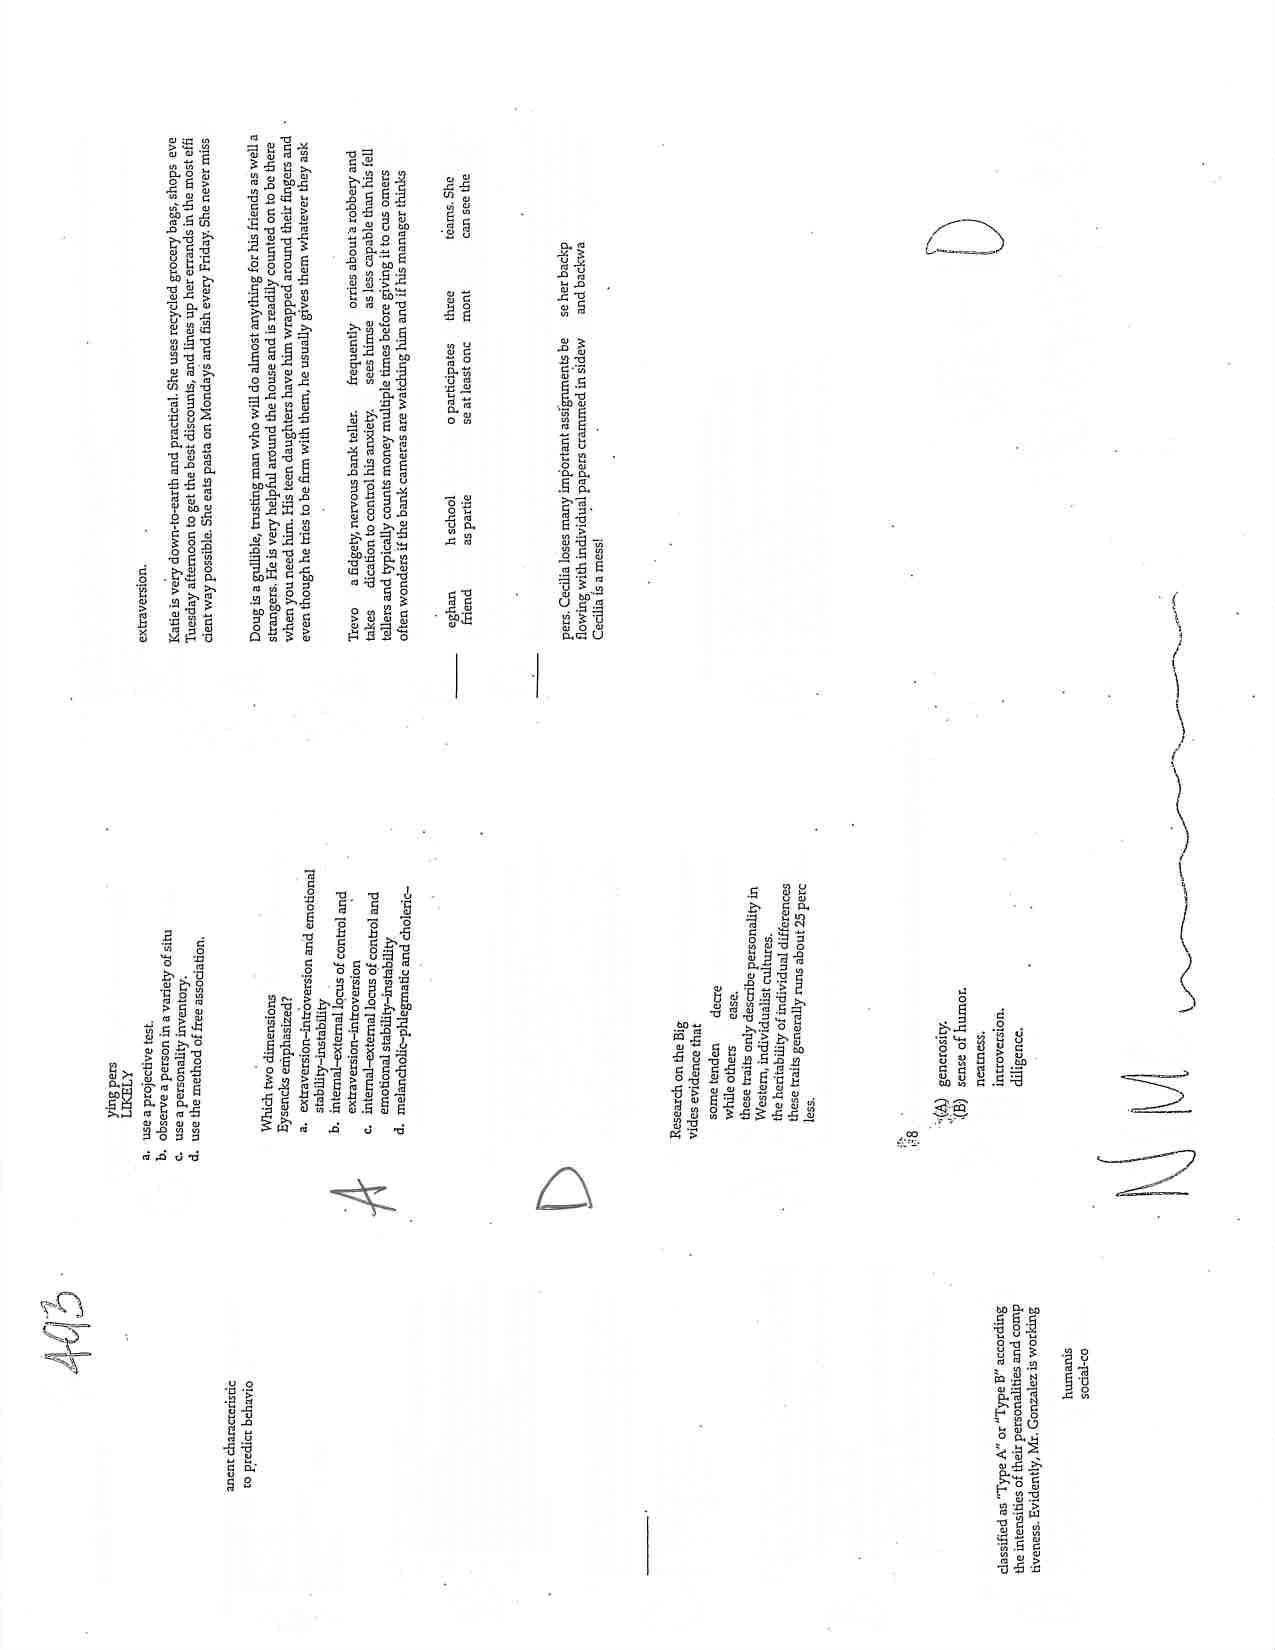
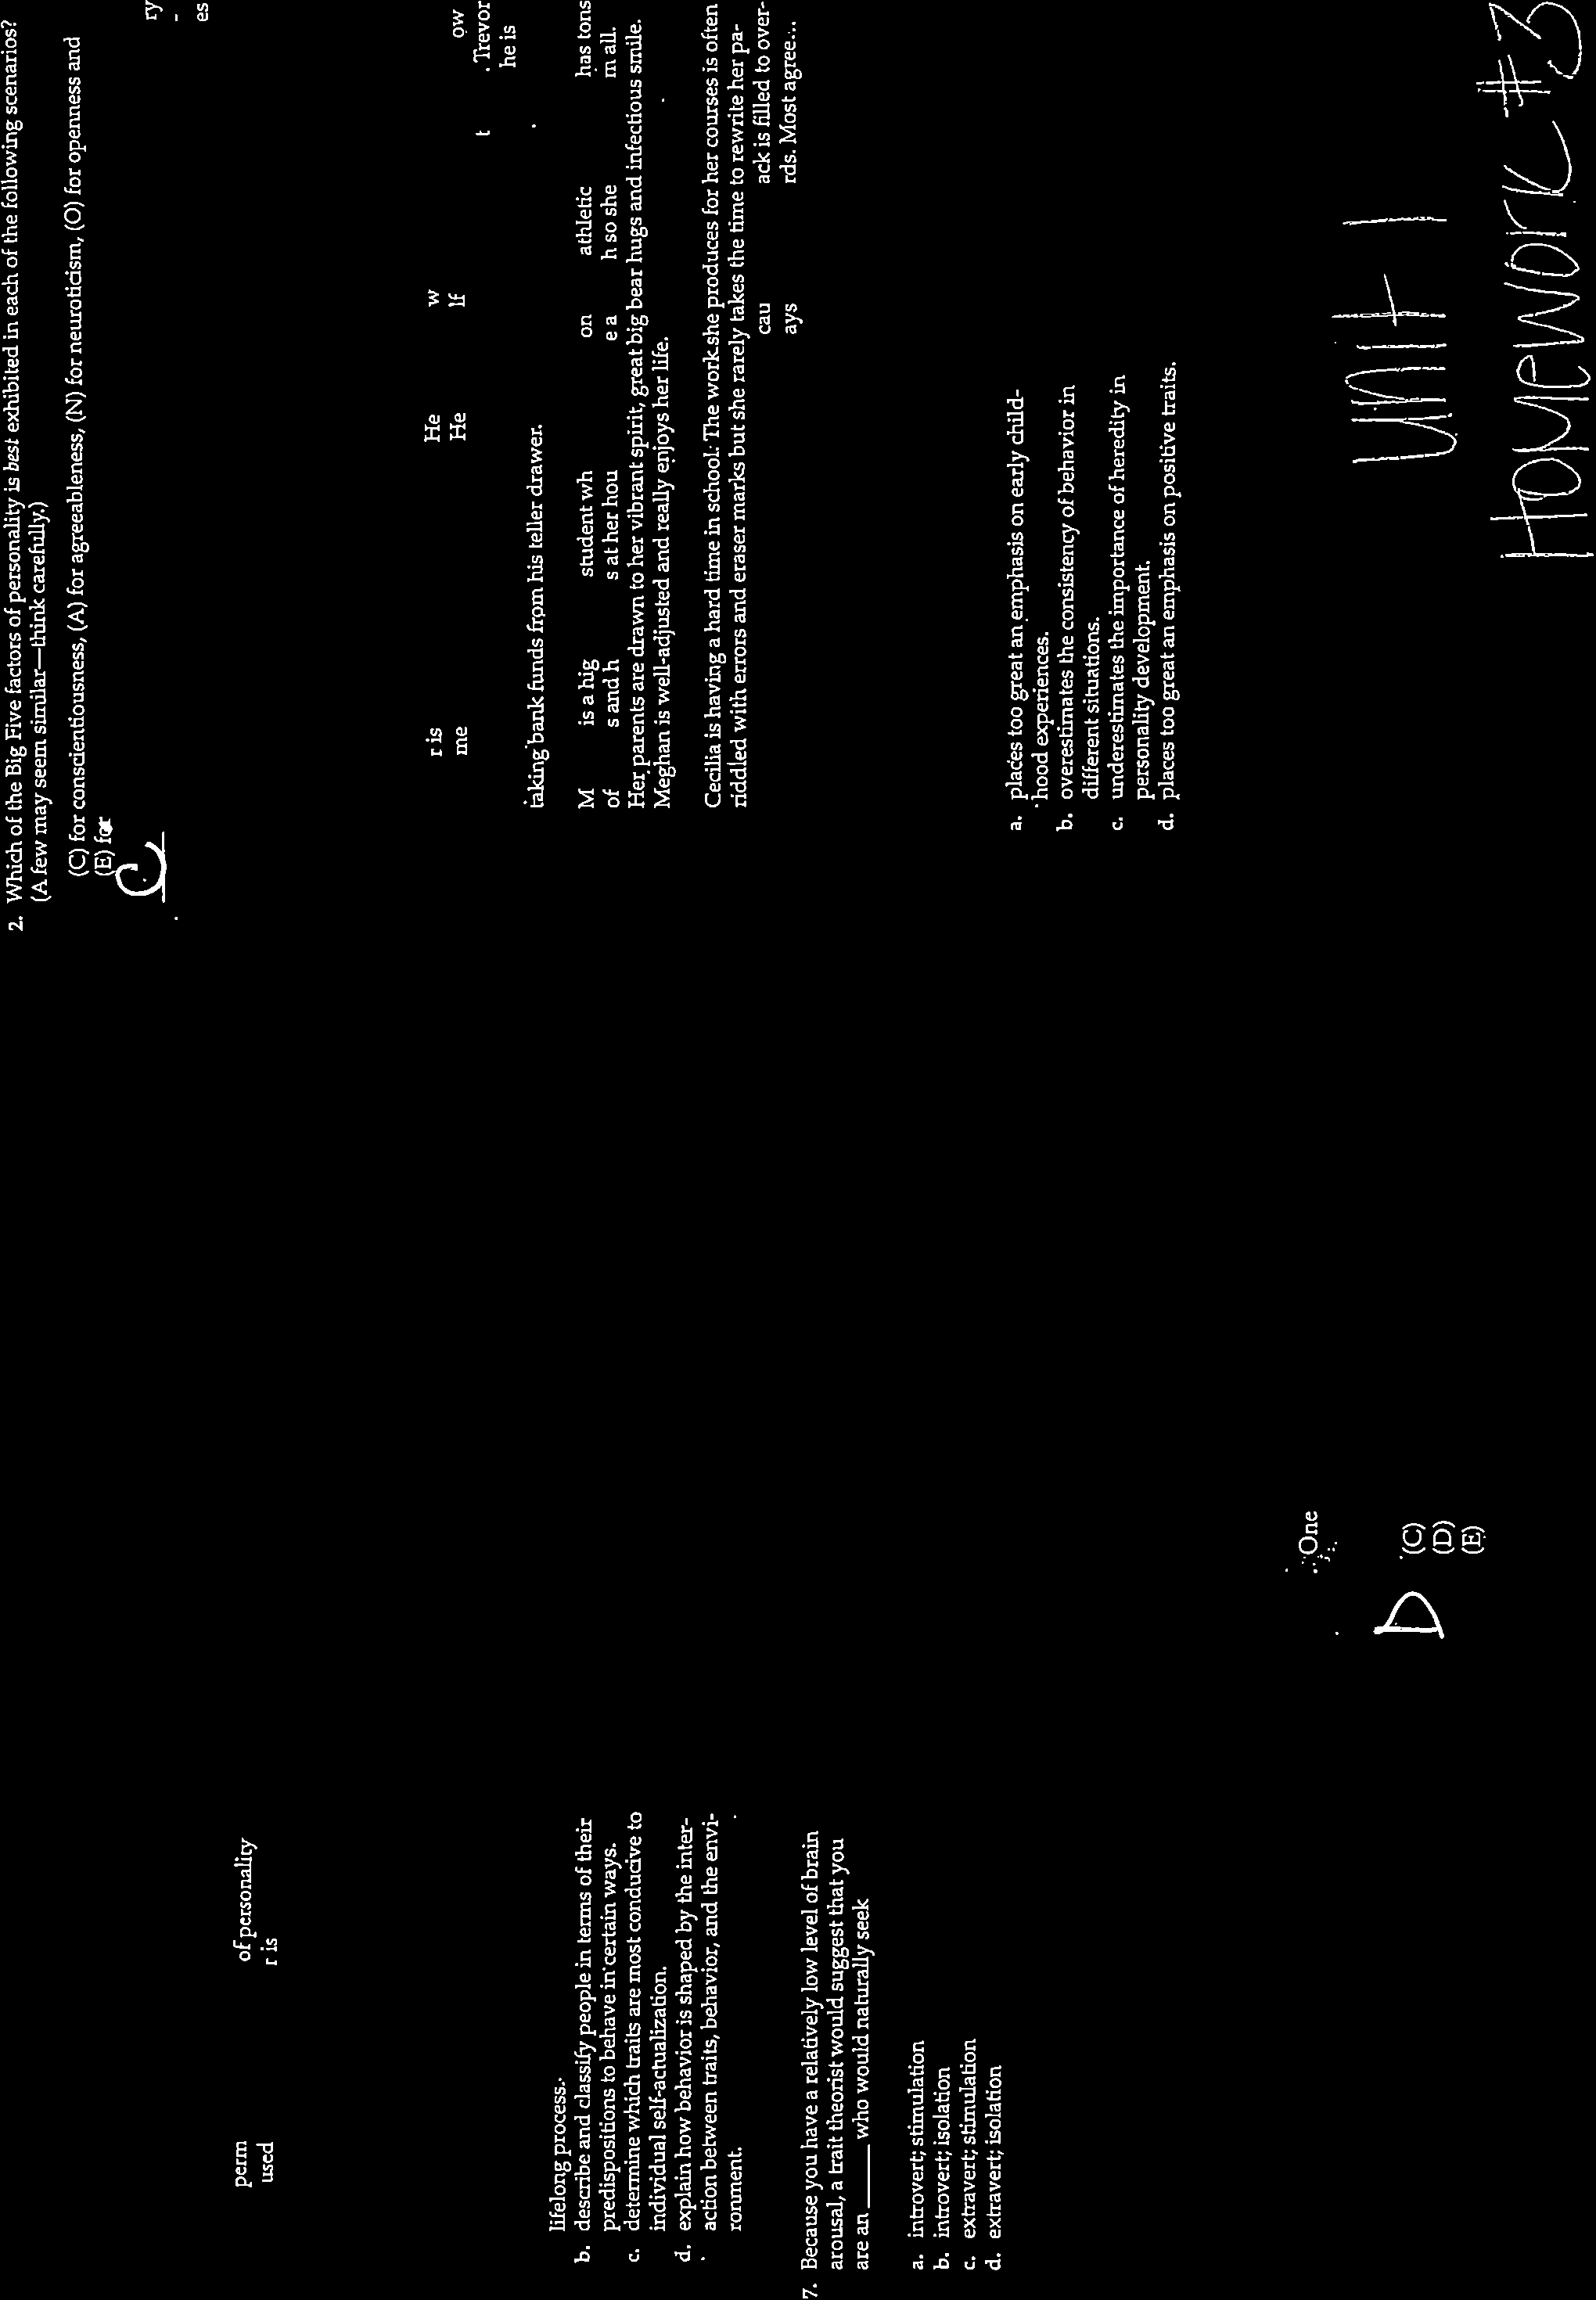
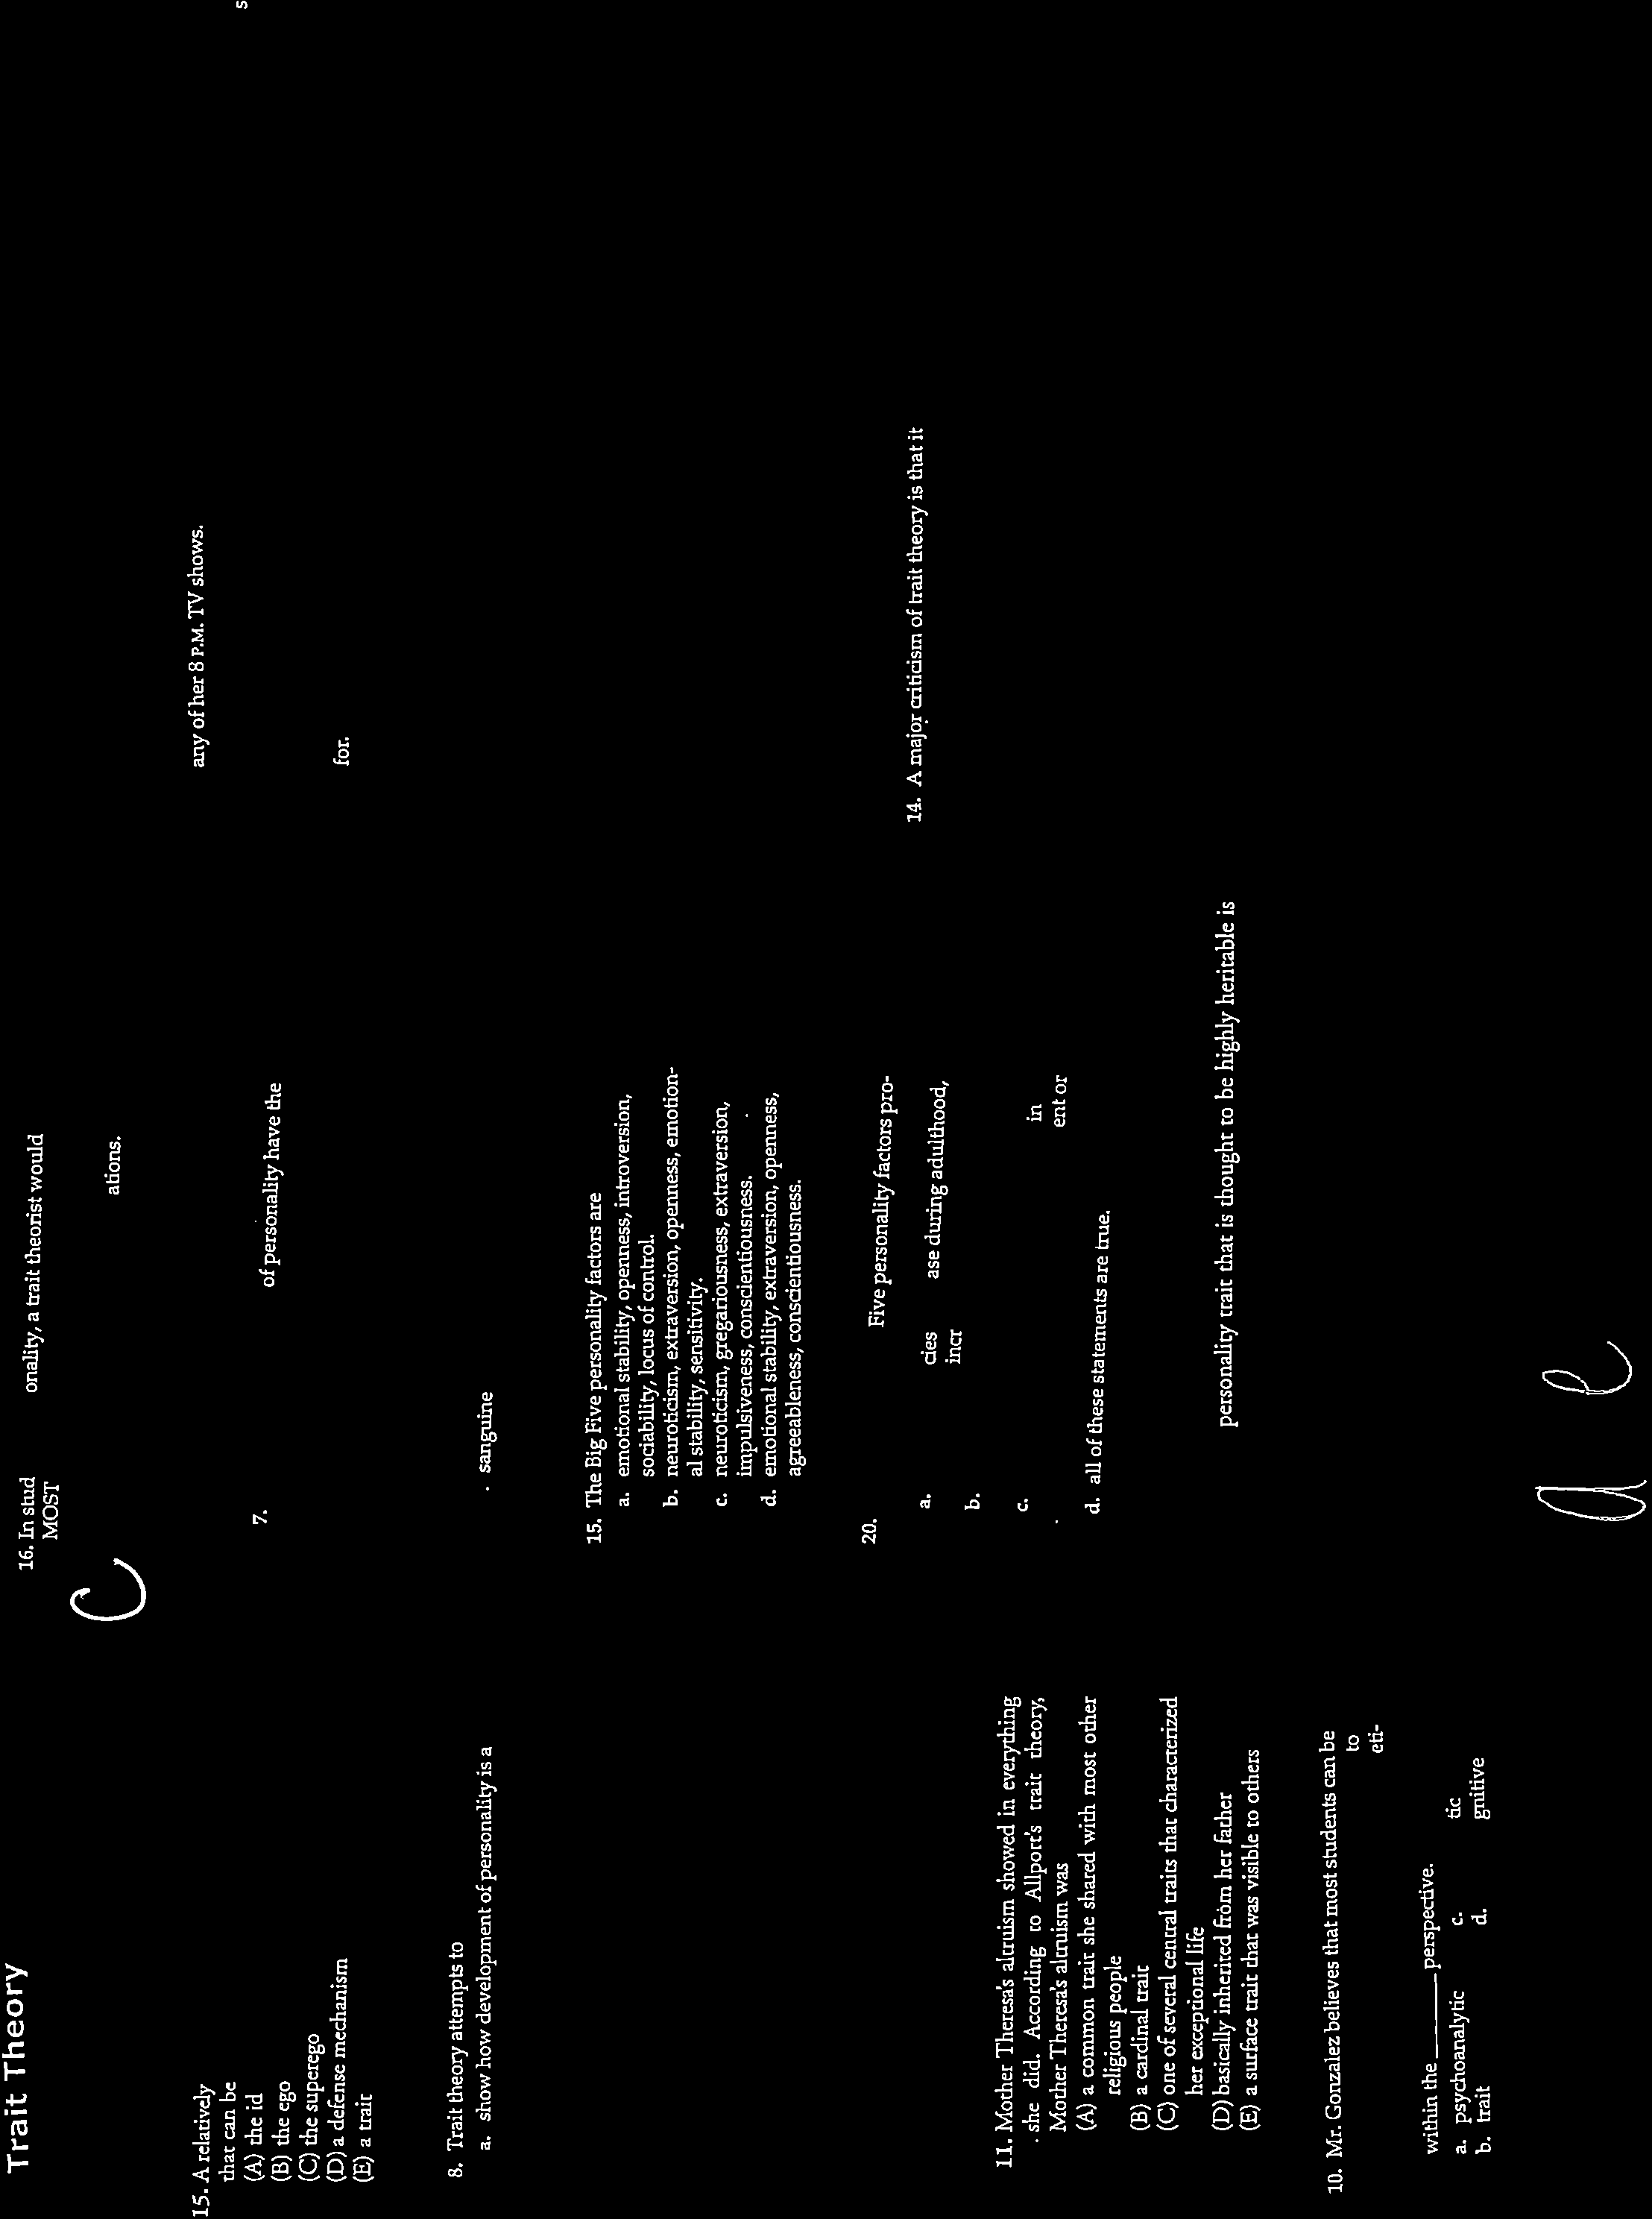
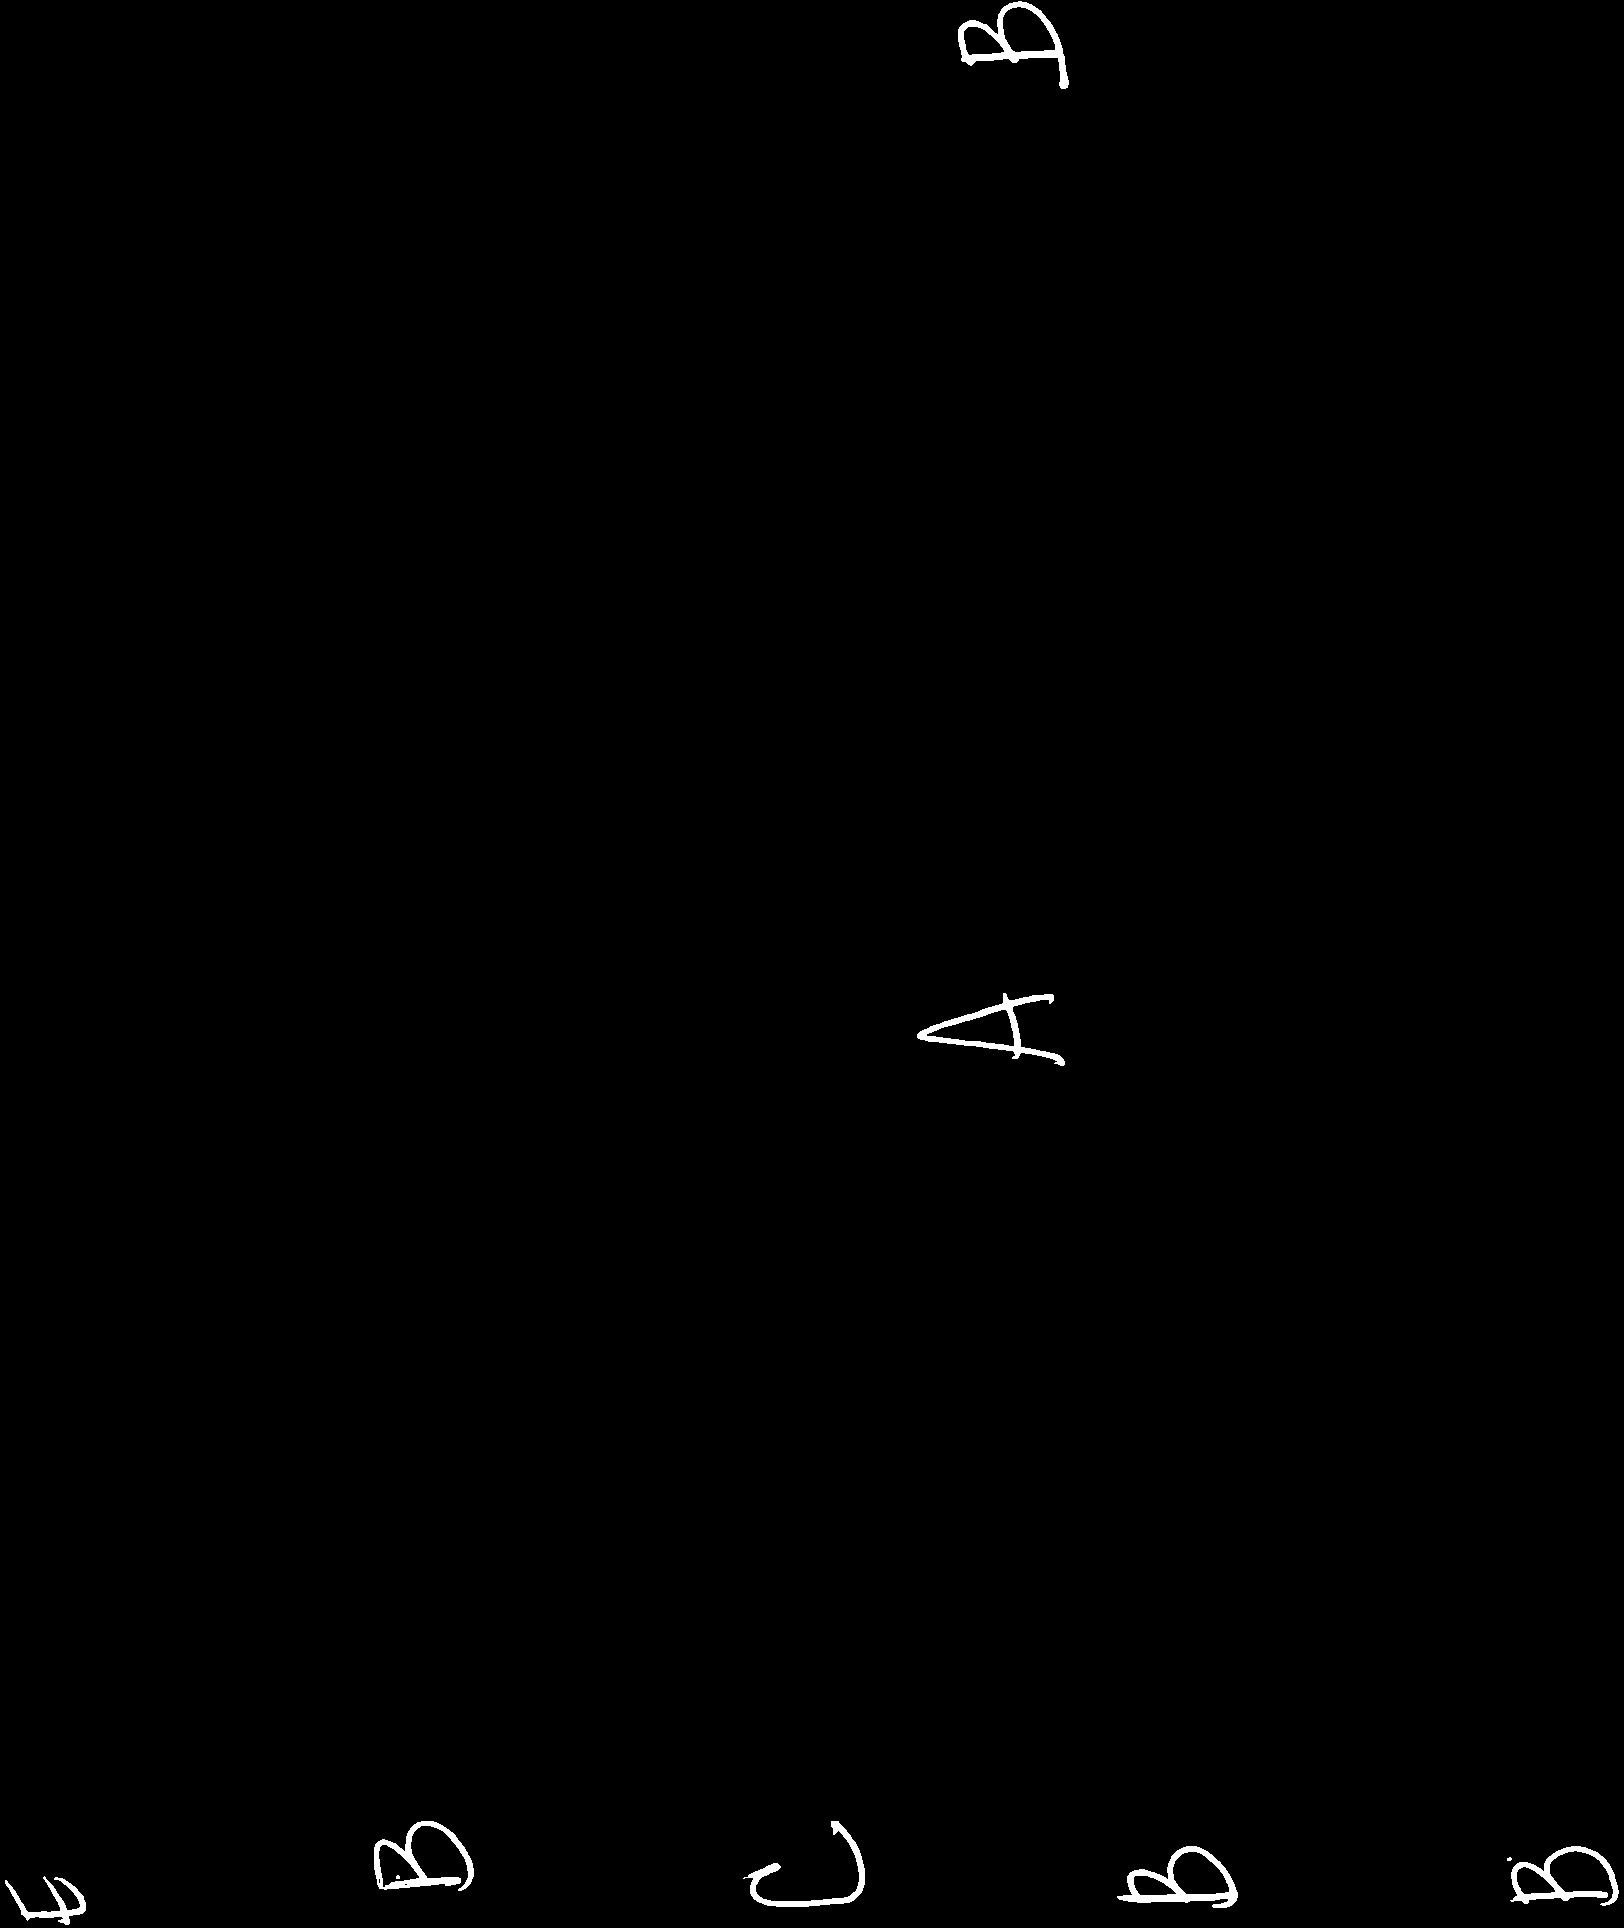
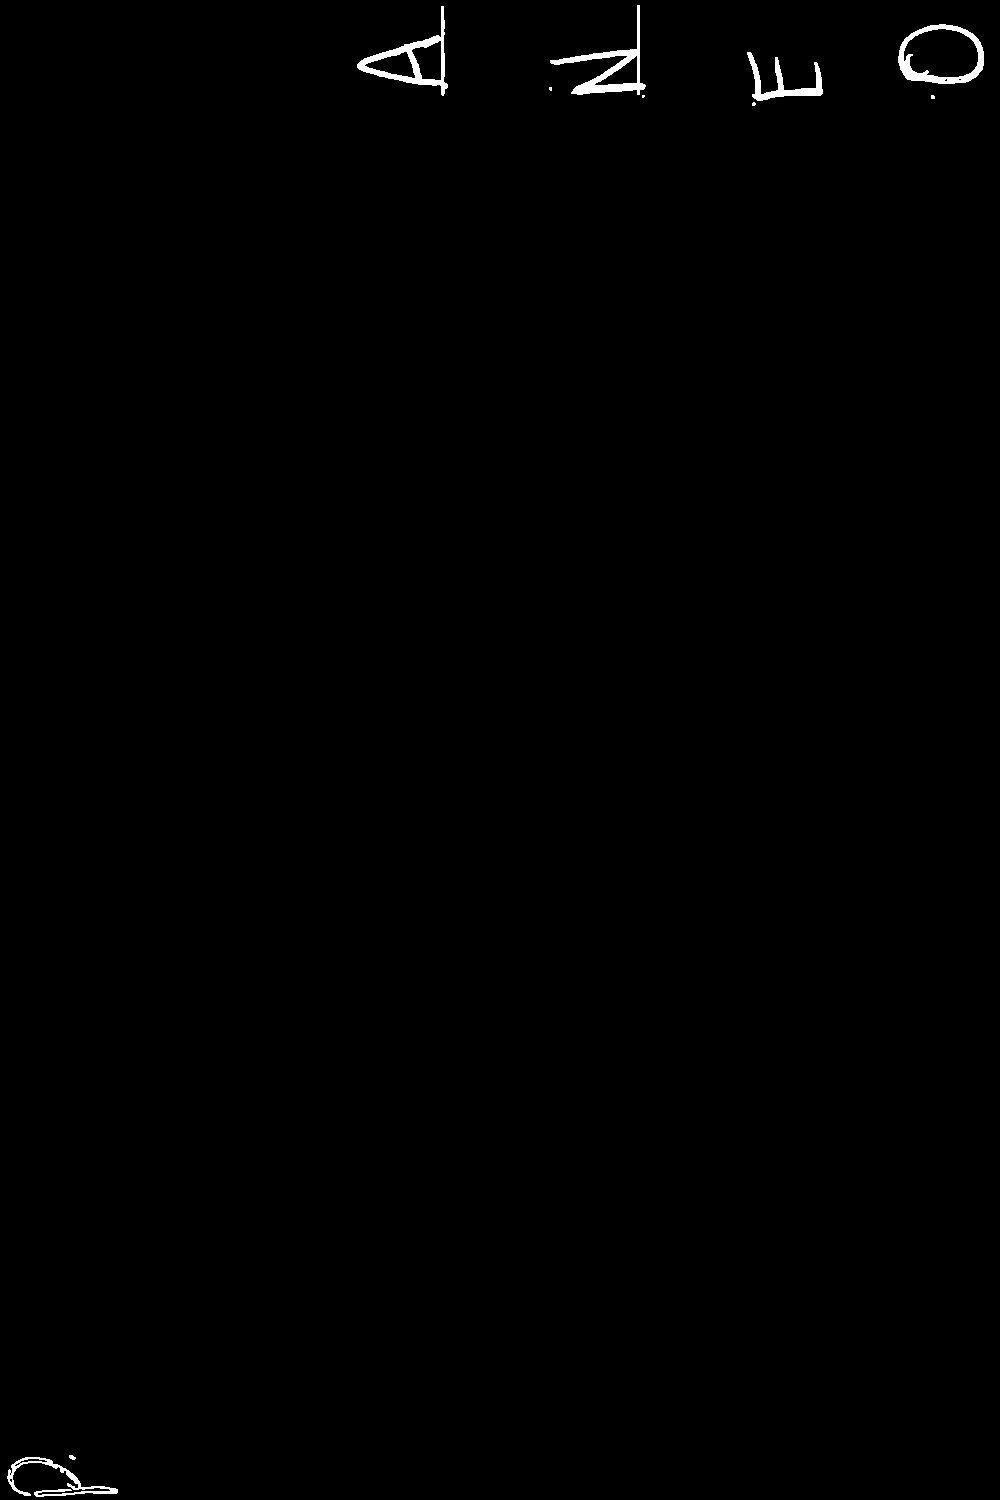
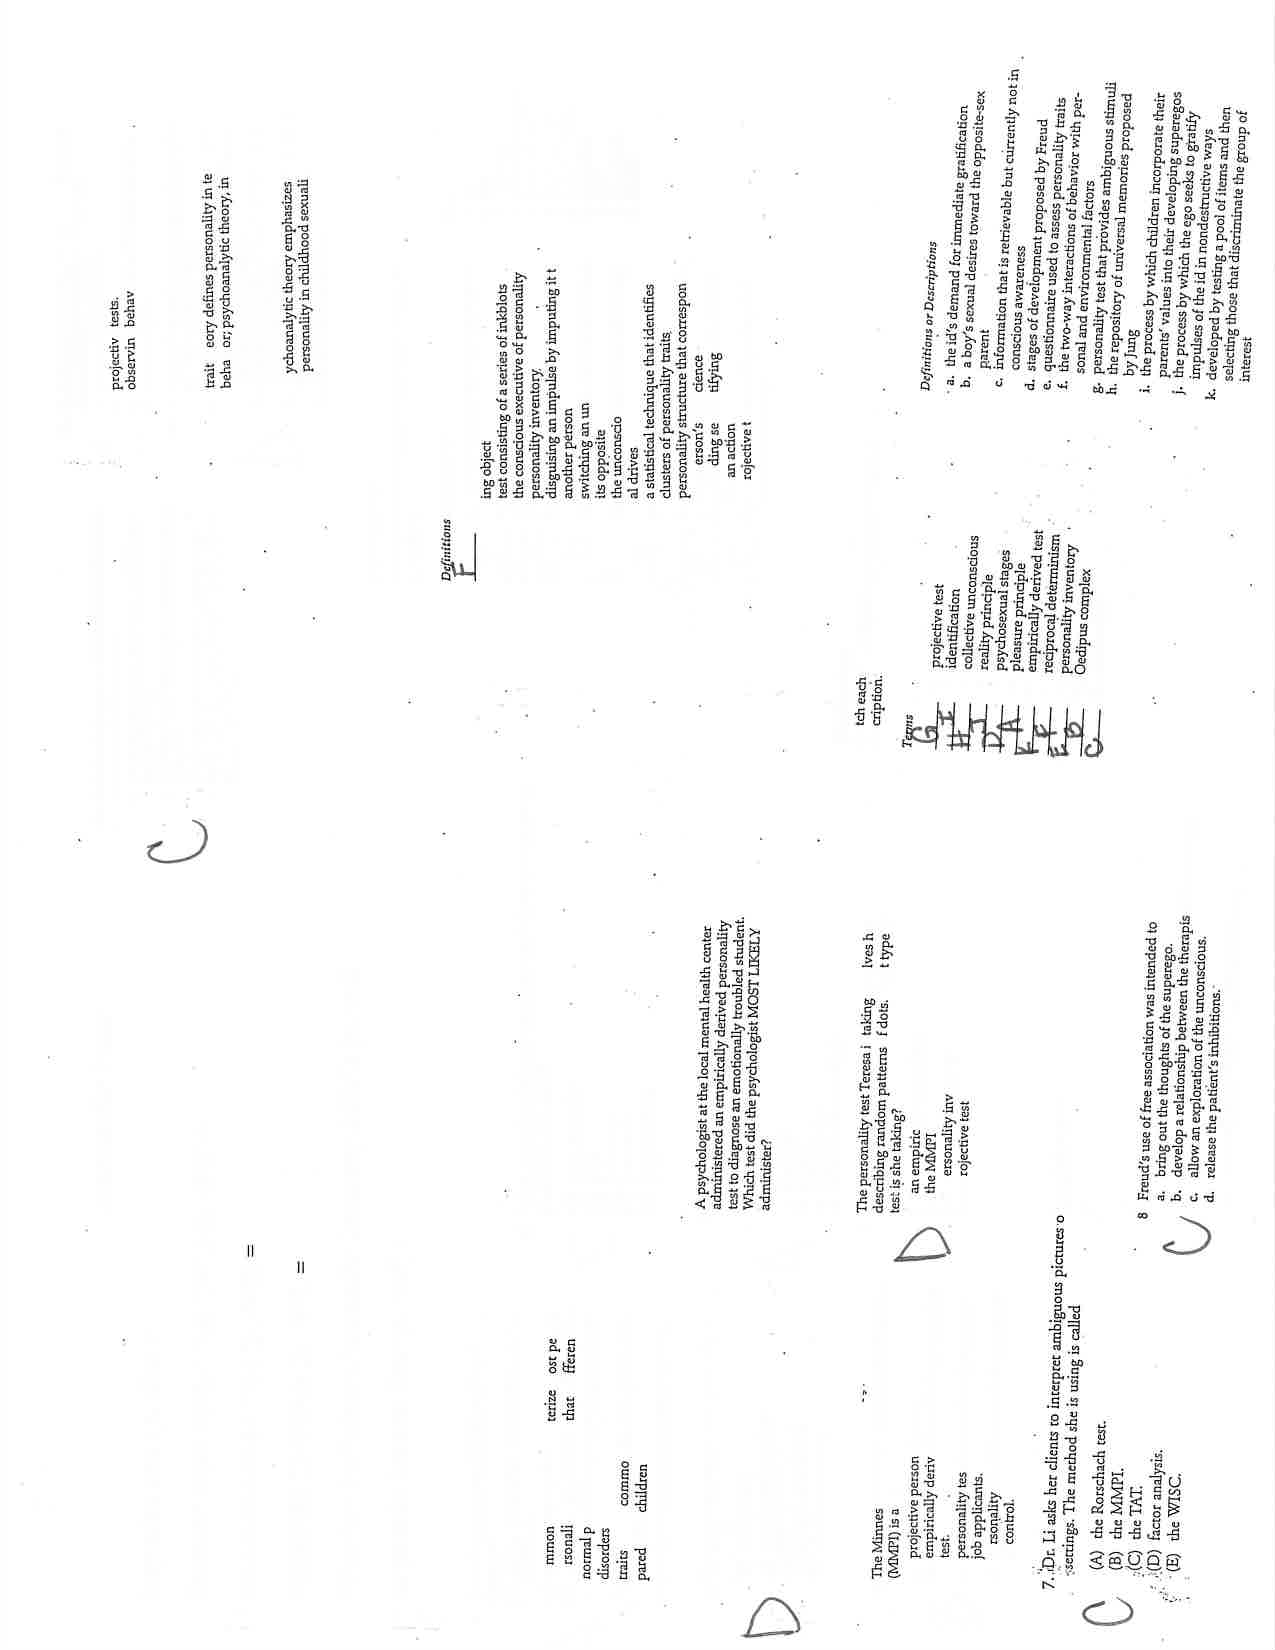
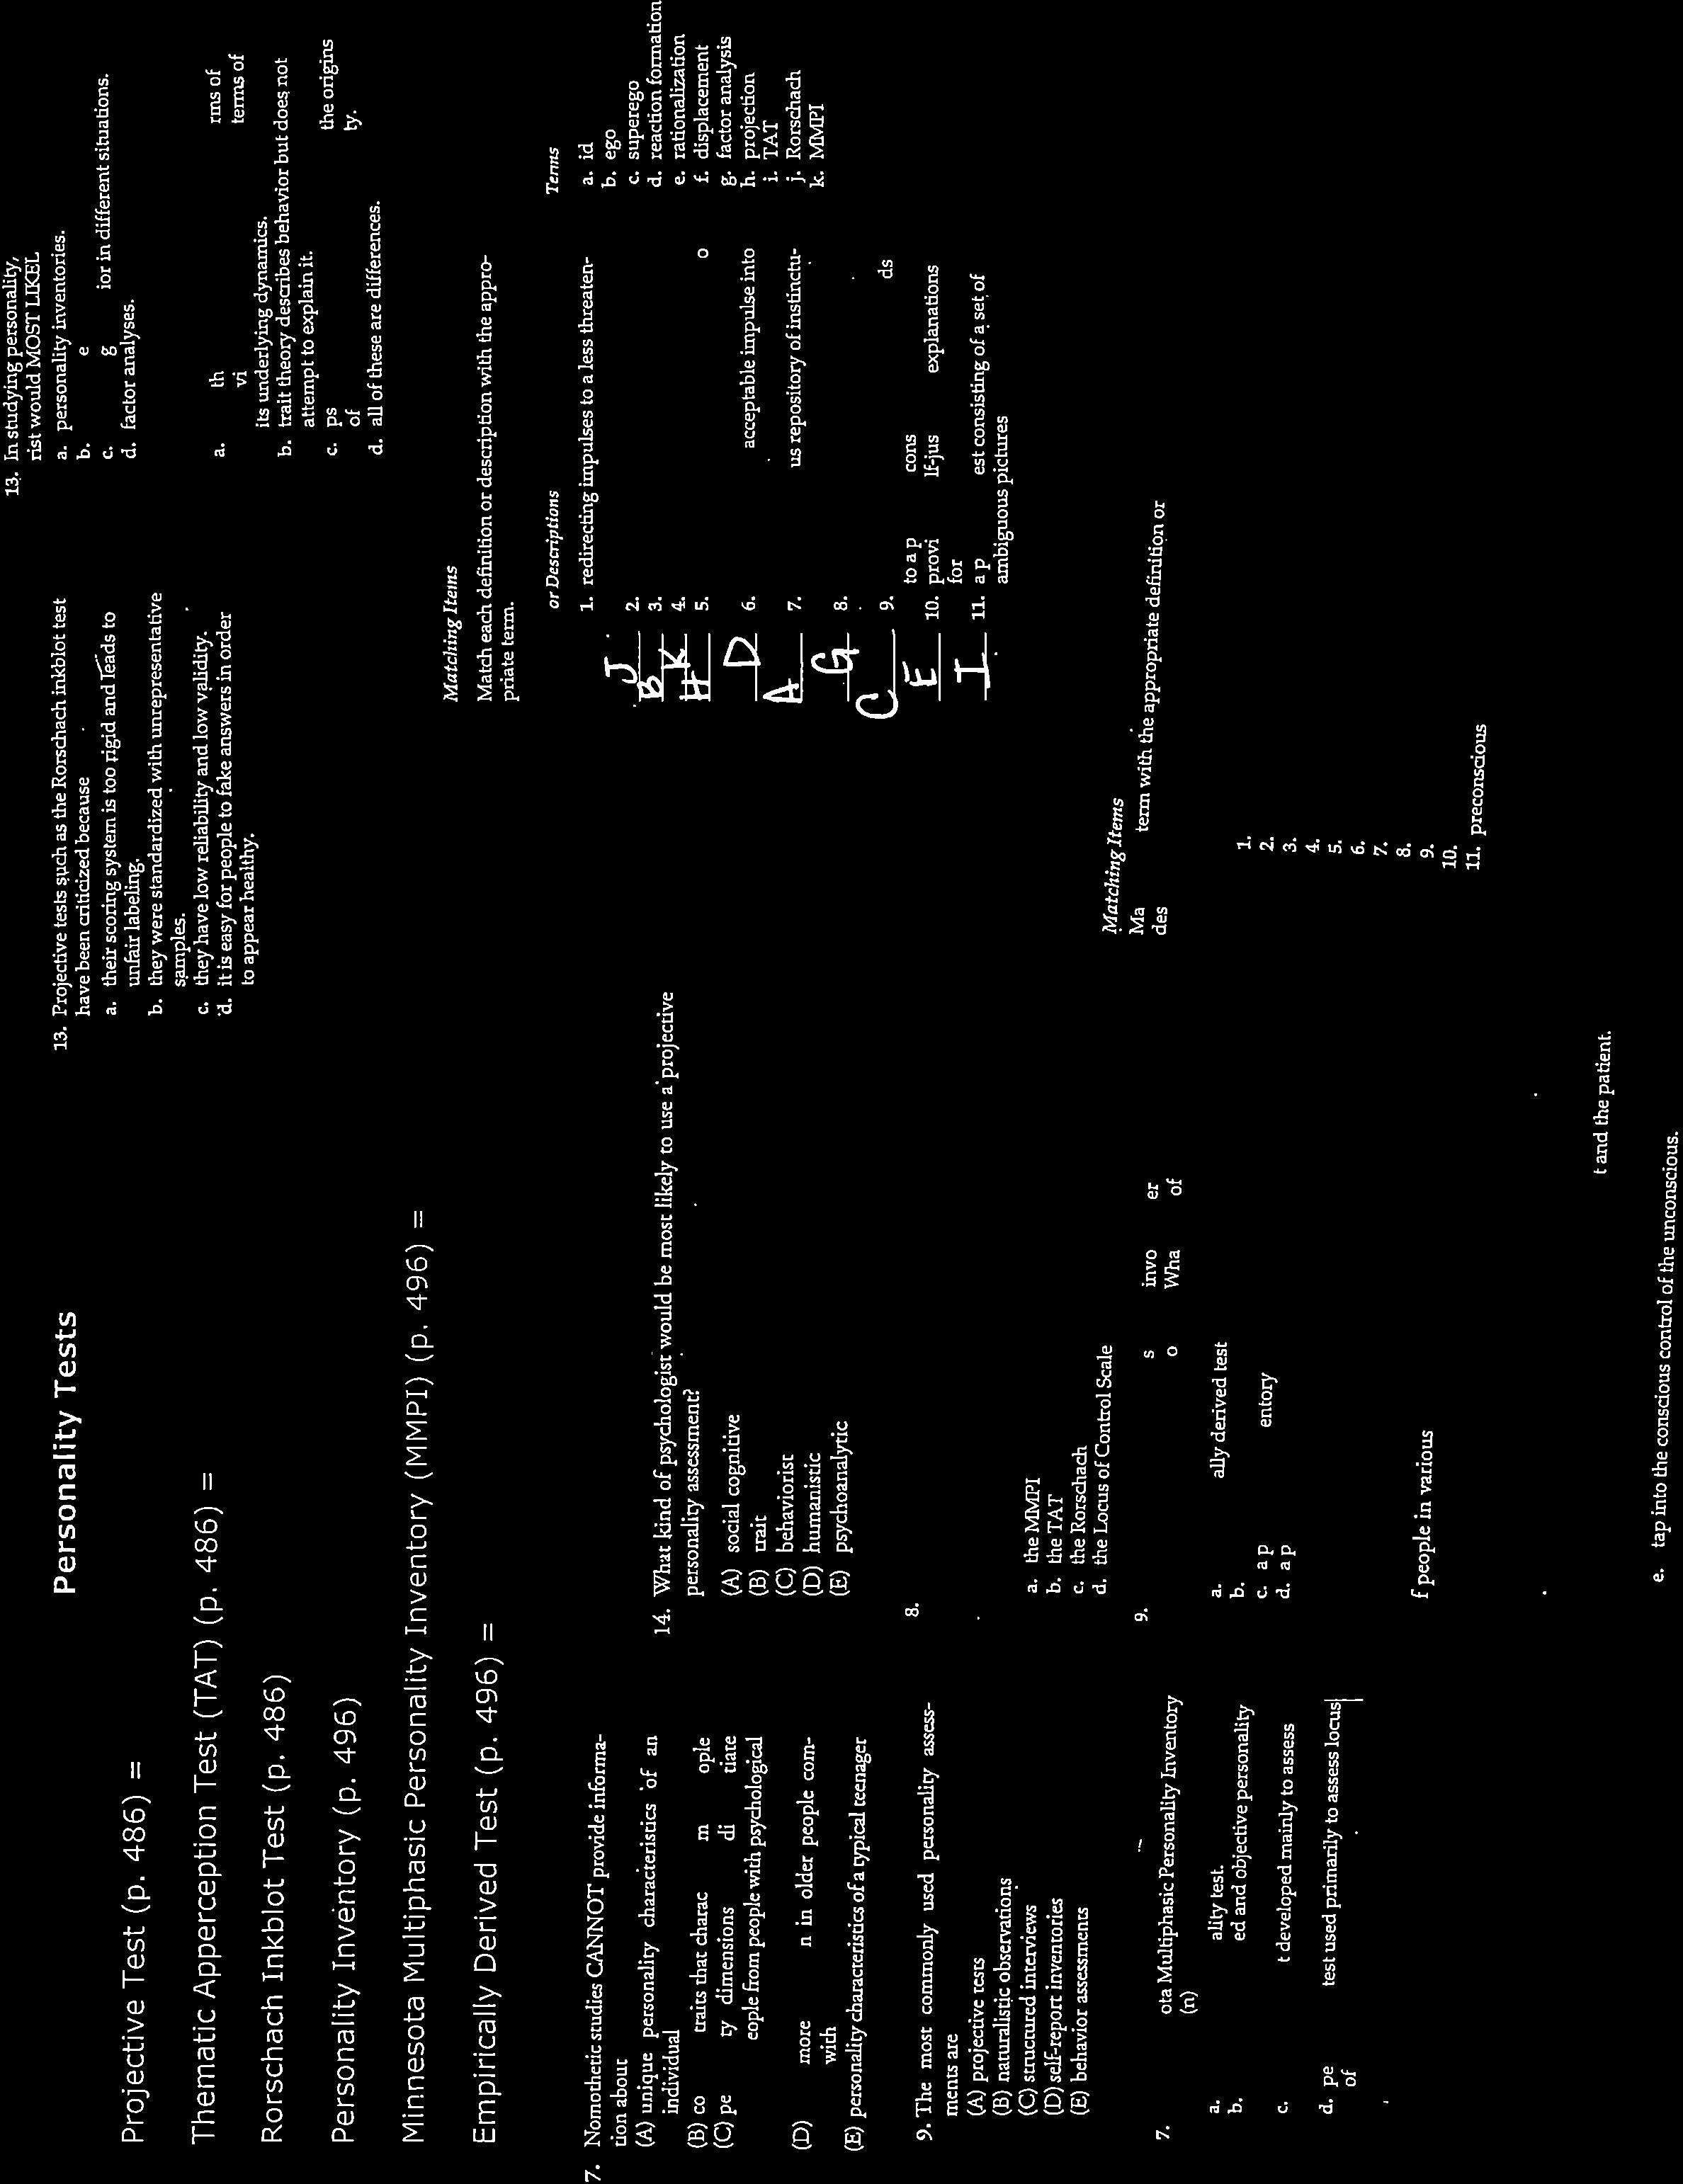
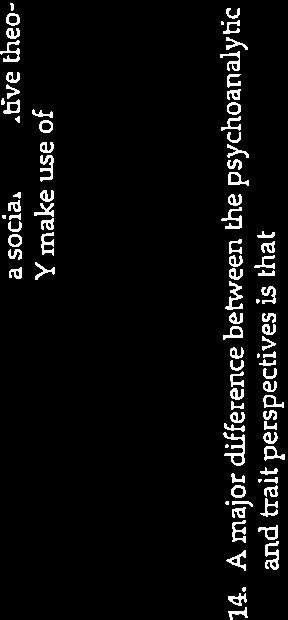
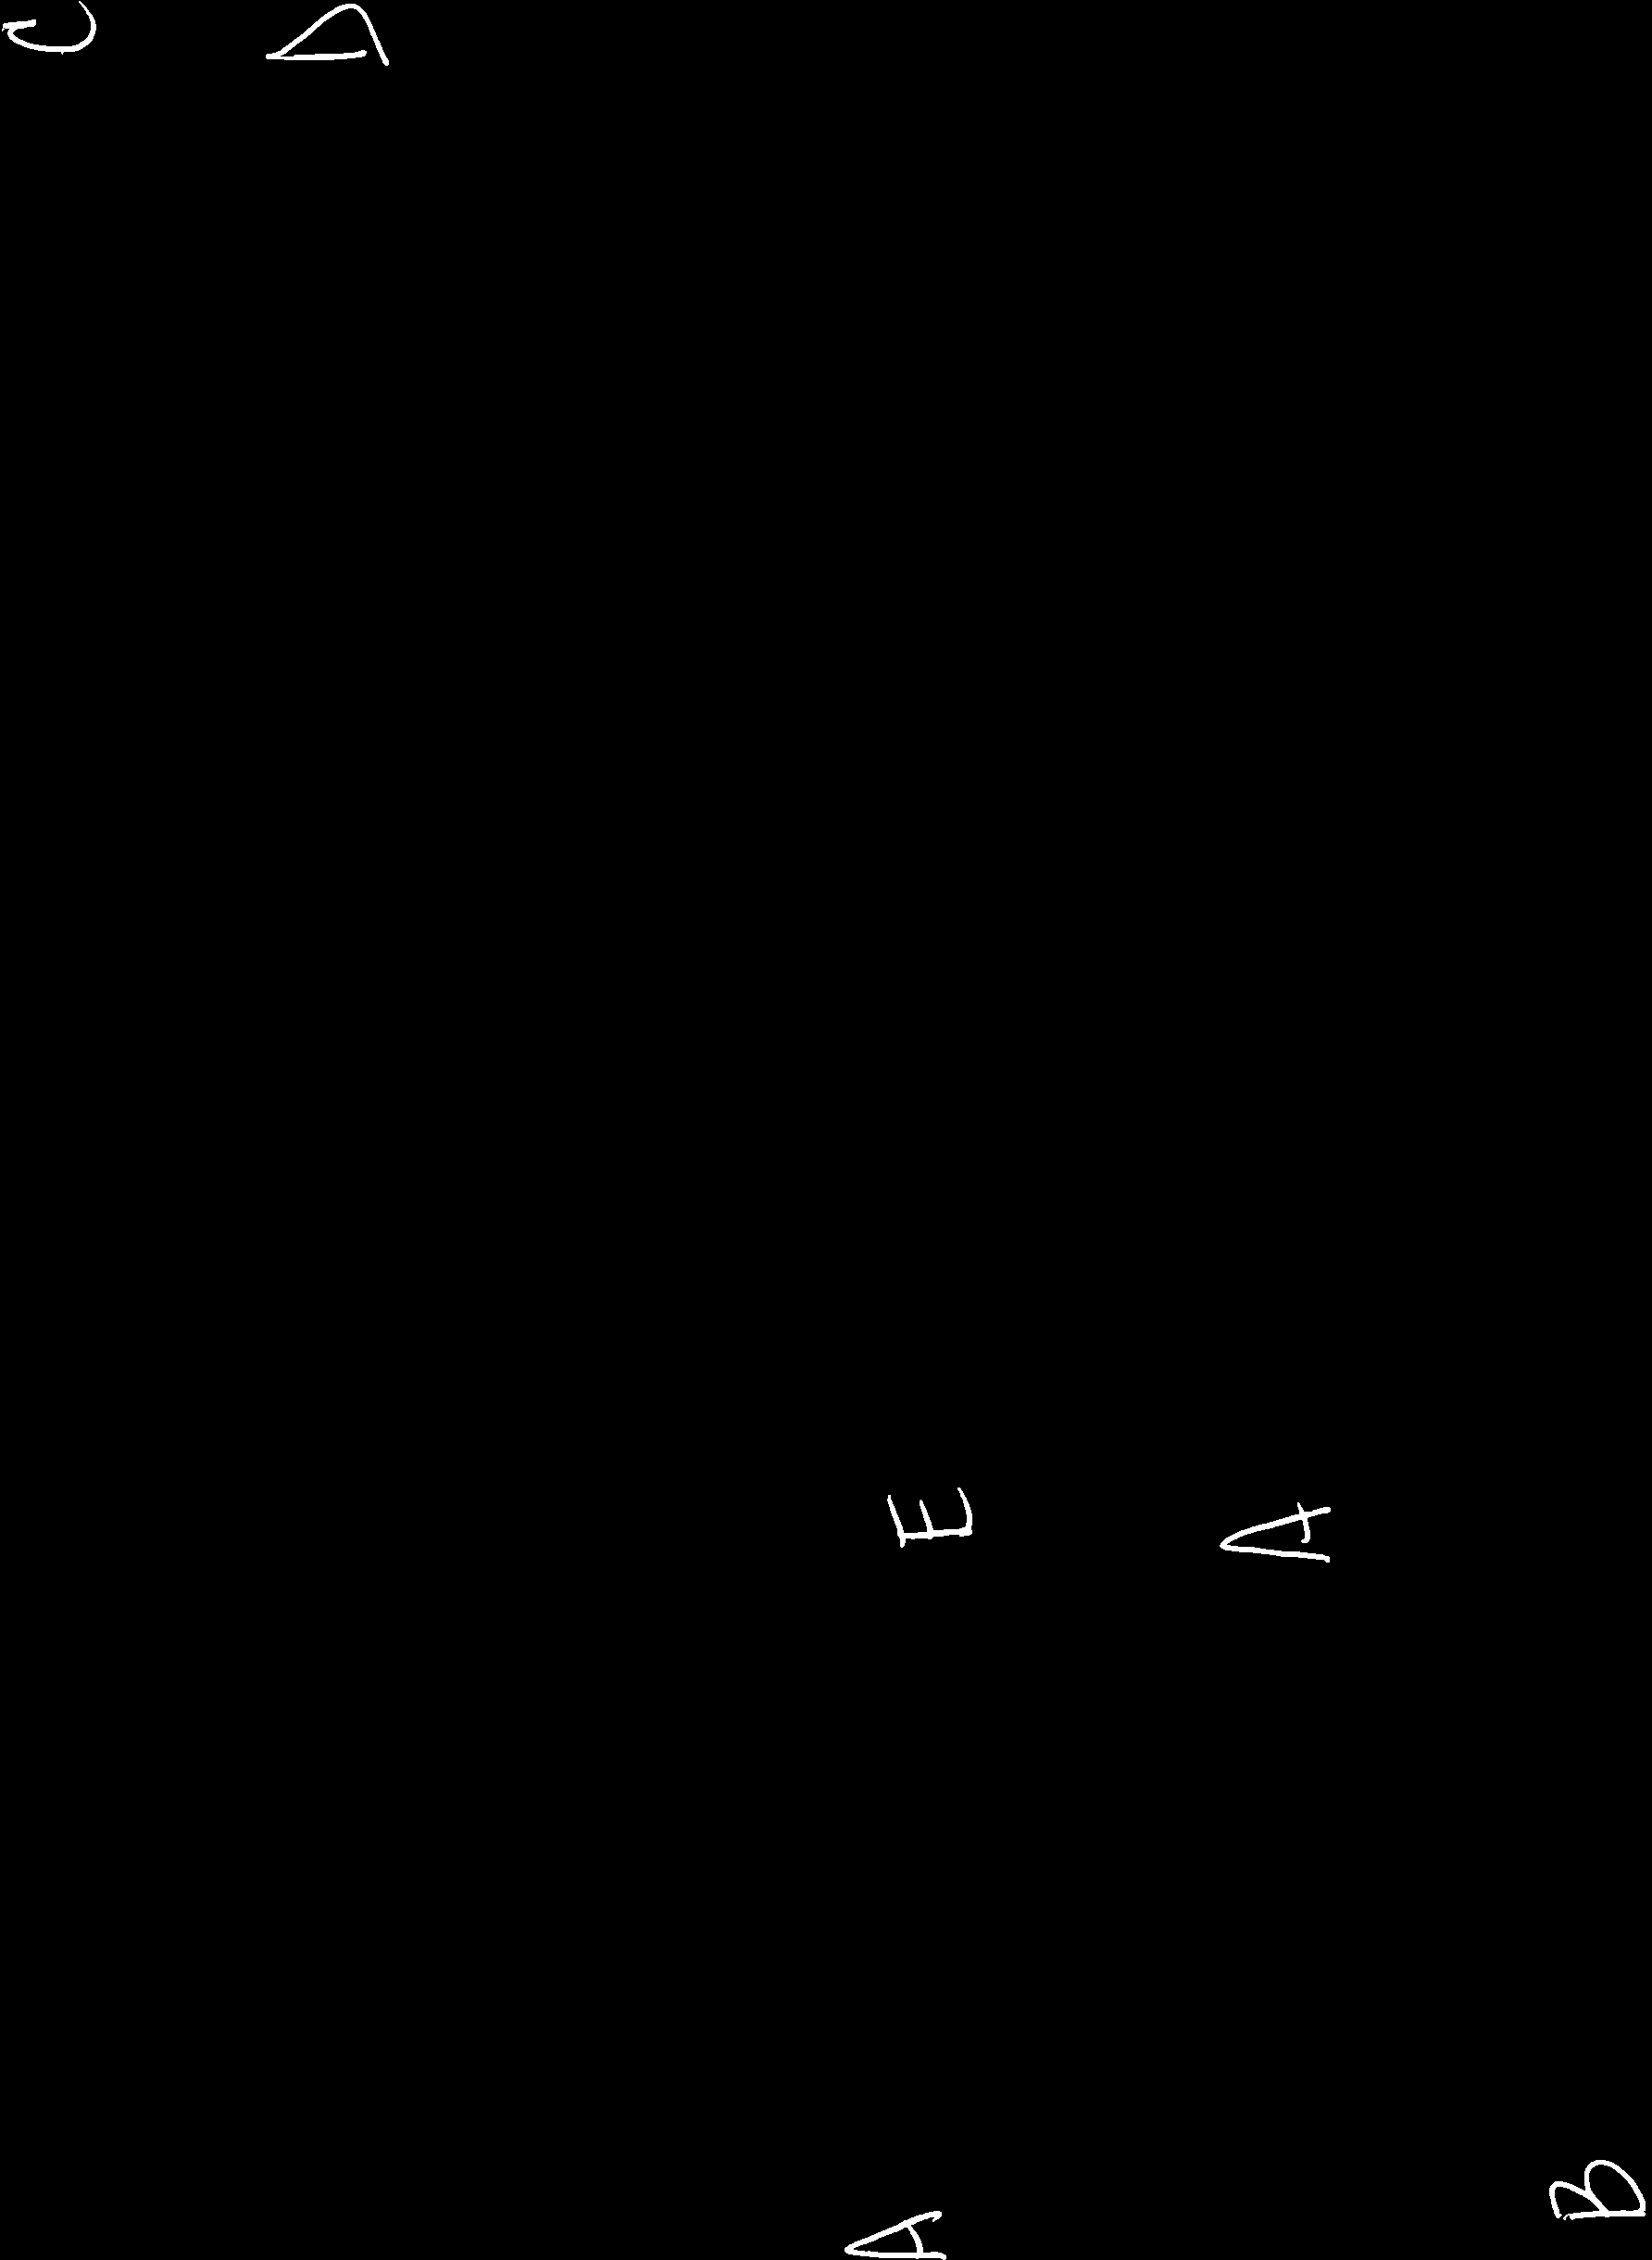

In [19]:
print(extract_pdf_content("u7_practice.pdf"))

In [51]:
calculator(3, 2, "power")

9.0

In [58]:
# test web_search
query = "What is Cognitive Triad?"
web_search(query)

[{'title': 'Cognitive Behavioral Therapy (CBT): Types, Techniques, Uses',
  'url': 'https://www.simplypsychology.org/cognitive-therapy.html',
  'content': 'The Cognitive Triad\nThe cognitive triad is three forms of negative (i.e., helpless and critical) thinking that are typical of individuals with depression: namely, negative thoughts about the self, the world, and the future.\nThese thoughts tended to be automatic in depressed people as they occurred spontaneously. [...] The cognitive triangle is a tool used in CBT to demonstrate the interplay between thoughts, feelings, and behaviors.\nIndividuals can identify and avoid harmful patterns by recording and categorizing negative thoughts. While surface emotions might be apparent, deeper underlying emotions can influence reactions.\nAddressing these root emotions and modifying thought patterns can lead to positive behavioral changes, aiding in treating mental health issues like anxiety or depression. [...] Cognitive therapy helps people 

## State

In [62]:
def assistant(state: AgentState):
  """ Function that defines how the agent interacts with the user and tools to
      perform a task."""

  # a string variable containing descriptions of available tools
  textual_description_of_tool = """
    extract_text(img_path: str) -> str:
      Extract text from an image file using a multimodal model.

      Args:
        img_path: A local image file path (strings).

      Returns:
        A single string containing the concatenated text extracted from each image.

    extract_pdf_content(pdf_path: str) -> str:
      Extract text and images from a PDF file and format them for LLM processing.

      Args:
        pdf_path: A local PDF file path (strings).

      Returns:
        A dictionary containing the concatenated text extracted from each page

    process_pdf_for_llm(pdf_path: str) -> str:
      Process the extracted content from a PDF and send it to the LLM in manageable chunks.

      Args:
        pdf_path: A local PDF file path (string).

      Returns:
        A string containing the LLM-processed output from the extracted PDF content.


    web_search(query: str) -> str:
      Search the web for relevant information based on a query using TavilySearchResults.

      Args:
        query: A search query string.

      Returns:
        A string containing the relevant search results.

    calculate(a: float, b: float, operation: str) -> float:
      Performs mathematical operation on a and b
  """

  # retrives the image from current input file
  image = state["input_file"]
  # create a SystemMessage object that sets up the role and describes the available tools in the textual_description_of_tool string
  sys_msg = SystemMessage(content=f"You are an helpful agent that can analyse images, extract text, search the web for information, run some computation with provided tools :\n{textual_description_of_tool} \n Your responce is presented in a easy to copy format. Currently the loaded image or file: {image}")

  # returns a dictionary containing a list with the LLM response to the input massage
  return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])], "input_file": state["input_file"]}


## Graph

In [63]:
builder = StateGraph(AgentState)

## Nodes

Define `Tools` node as a list of tools, `Assistant` node is the model with tools

In [64]:
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

## Edges

In [65]:
# determine the flow control
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant",  tools_condition) # if the latest message requires a tool, route to tools otherwise provide a direct response
builder.add_edge("tools", "assistant")

## Compile

In [66]:
react_graph = builder.compile()

## Display

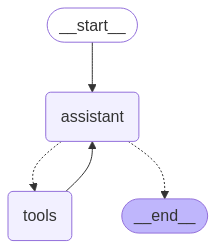

In [15]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Example uses of Agent

In [27]:
messages = [HumanMessage(content="What are the main concepts and ideas in pdf file")]

messages = react_graph.invoke({"messages": messages,"input_file":"u5_study_guide.pdf"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What are the main concepts anad ideas in pdf file
================================== Ai Message ==================================
Tool Calls:
  extract_pdf_content (call_J6rt4skMV1U5mnSTNuN6LurO)
 Call ID: call_J6rt4skMV1U5mnSTNuN6LurO
  Args:
    pdf_path: u5_study_guide.pdf
================================= Tool Message =================================
Name: extract_pdf_content

{"text": "Unit 5: Mental and Physical Health \nModules 5.1-5.5 \n \nWhile people’s overall health and well-being is a deep interest of all psychologists, there are more specific \nareas within these categories on which certain psychologists place their main research focus. Health \npsychologists explore factors that help people lead mentally and physically healthy lives. Positive psychologists \nexplore factors related to mental health and happiness, focusing on positive emotions, cognitions, and \nexperiences. Psychologists w

In [29]:
messages = [HumanMessage(content="Answer the Essential Questions, explain the Learning Targets, and define and give example of Concepts to master in the pdf file and present the answers in a easy to copy format.")]

messages = react_graph.invoke({"messages": messages,"input_file":"u5_study_guide.pdf"})
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Answer the Essential Questions, explain the Learning Targets, and define and give example of Concepts to master in the pdf file and present the answers in a easy to copy format.
================================== Ai Message ==================================
Tool Calls:
  extract_pdf_content (call_ruJrK2TWy5dHphs2B2z9GJZr)
 Call ID: call_ruJrK2TWy5dHphs2B2z9GJZr
  Args:
    pdf_path: u5_study_guide.pdf
================================= Tool Message =================================
Name: extract_pdf_content

{"text": "Unit 5: Mental and Physical Health \nModules 5.1-5.5 \n \nWhile people’s overall health and well-being is a deep interest of all psychologists, there are more specific \nareas within these categories on which certain psychologists place their main research focus. Health \npsychologists explore factors that help people lead mentally and physically healthy lives. Positive psychologists \nexplo

In [67]:
messages = [HumanMessage(content="Please provide detailed answers of the Essential Questions, give detailed explanantions of the Learning Targets from 5.1 to 5.5, and succinct definitions with examples of all Concepts to master, including all nested concepts, listed in the provided pdf file.")]

messages = react_graph.invoke({"messages": messages,"input_file":"u5_study_guide.pdf"})

for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Please provide detailed answers of the Essential Questions, give detailed explanantions of the Learning Targets from 5.1 to 5.5, and succinct definitions with examples of all Concepts to master, including all nested concepts, listed in the provided pdf file.
================================== Ai Message ==================================
Tool Calls:
  extract_pdf_content (call_ohx3Uzewh5w4nD5aMsGTDk7S)
 Call ID: call_ohx3Uzewh5w4nD5aMsGTDk7S
  Args:
    pdf_path: u5_study_guide.pdf
================================= Tool Message =================================
Name: extract_pdf_content

{"text": "Unit 5: Mental and Physical Health \nModules 5.1-5.5 \n \nWhile people’s overall health and well-being is a deep interest of all psychologists, there are more specific \nareas within these categories on which certain psychologists place their main research focus. Health \npsychologists explore factors that help 